In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("/disk/u/gio/retrieval")

import json
import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

from src.utils.training_utils import get_device_map

model_key = "meta-llama/Llama-3.3-70B-Instruct"

device_map = get_device_map(model_key, 32, n_gpus=8)
print(device_map)

os.chdir("/disk/u/gio/mechinterp")
print(os.getcwd())

from src.models import ModelandTokenizer

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    device_map=device_map,
)



/disk/u/gio/.conda/envs/retrieval2/lib/python3.11/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


2025-09-09 09:13:59 __main__ INFO     torch.__version__='2.8.0+cu128', torch.version.cuda='12.8'
2025-09-09 09:13:59 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-09 09:13:59 __main__ INFO     transformers.__version__='4.54.1'
2025-09-09 09:14:02 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/gio/retrieval, stdin=None, shell=False, universal_newlines=False)
2025-09-09 09:14:02 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/gio/retrieval, stdin=None, shell=False, universal_newlines=False)
{'model.embed_tokens': 7, 'model.norm': 7, 'model.rotary_emb': 7, 'lm_head': 7, 'model.layers.0': 0, 'model.layers.1': 1, 'model.layers.2': 2, 'model.layers.3': 3, 'model.layers.4': 4, 'model.layers.5': 5, 'model.layers.6': 6, 'model.layers.7': 7, 'model.layers.8': 0, 'model.layers.9': 1, 'model.layers.10': 2, 'model.layers.11': 3, 'model.layers.12': 4, 'model.layers.13': 5, 'model.layers.14': 

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-09-09 09:14:53 src.models INFO     loaded model <models/meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:7


2025-09-09 09:14:53 matplotlib DEBUG    matplotlib data path: /disk/u/gio/.conda/envs/retrieval2/lib/python3.11/site-packages/matplotlib/mpl-data
2025-09-09 09:14:53 matplotlib DEBUG    CONFIGDIR=/disk/u/gio/.config/matplotlib
2025-09-09 09:14:53 matplotlib DEBUG    interactive is False
2025-09-09 09:14:53 matplotlib DEBUG    platform is linux
2025-09-09 09:14:53 matplotlib DEBUG    CACHEDIR=/disk/u/gio/.cache/matplotlib
2025-09-09 09:14:53 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/gio/.cache/matplotlib/fontlist-v390.json
2025-09-09 09:14:53 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-09 09:14:53 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-09 09:14:53 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-09-09 09:14:53 matplotlib.font_manager DEB

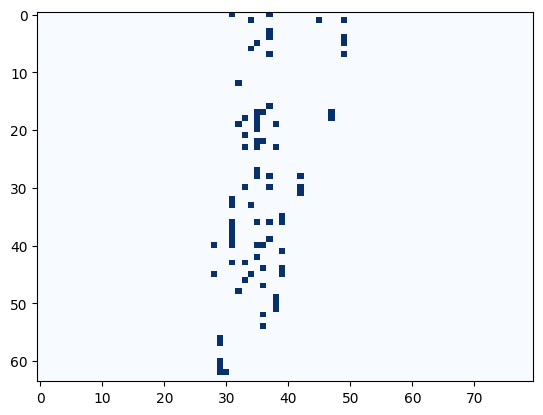

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from src.selection.data import SelectOneTask

optimized_path = os.path.join(
    "/disk/u/arnab/Codes/Projects/retrieval/results/"
    "selection/optimized_heads",
    mt.name.split("/")[-1],
    "distinct_options",
    "select_one",
    "epoch_10.npz"
)
optimization_results = np.load(optimized_path, allow_pickle=True)
optimal_head_mask = torch.tensor(optimization_results['optimal_mask']).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected
]
print(len(heads_selected))


In [42]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input

######################################################################
N_DISTRACTORS = 5
######################################################################


@torch.inference_mode()
def get_counterfactual_samples_within_task(
    task,
    patch_category: str | None = None,
    clean_category: str | None = None,
    shuffle_clean_options: bool = False,
    clean_prompt_template_idx=2,
    patch_prompt_template_idx=2,
    clean_option_style="single_line",
    patch_option_style="single_line",
    filter_by_lm_prediction: bool = True,
    distinct_options: bool = False,
    n_distractors: int = N_DISTRACTORS,
):
    categories = list(task.category_wise_examples.keys())
    if patch_category is None:
        patch_category = random.choice(categories)

    patch_subj, patch_obj = random.sample(
        task.category_wise_examples[patch_category], 2
    )
    logger.info(
        f"Patch category: {patch_category}, subject: {patch_subj}, object: {patch_obj}"
    )

    if clean_category is None:
        clean_category = random.choice(list(set(categories) - {patch_category}))

    clean_options = task.category_wise_examples[clean_category]
    random.shuffle(clean_options)

    clean_subj, clean_obj = random.sample(
        (
            KeyedSet(clean_options, mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)
        ).values,
        2,
    )
    logger.info(
        f"Clean category: {clean_category}, subject: {clean_subj}, object: {clean_obj}"
    )

    if distinct_options is False:
        patch_type_obj = patch_obj
        clean_type_obj = clean_obj
    else:
        patch_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[patch_category], mt.tokenizer)
                - KeyedSet([patch_obj], mt.tokenizer)
            ).values
        )
        clean_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[clean_category], mt.tokenizer)
                - KeyedSet([clean_obj], mt.tokenizer)
            ).values
        )

    patch_must_have_options = [patch_obj, clean_type_obj]
    clean_must_have_options = [clean_obj, patch_type_obj]

    logger.info(f"{patch_must_have_options=}")
    logger.info(f"{clean_must_have_options=}")
    logger.info(f"{clean_type_obj=}")
    logger.info(f"{patch_type_obj=}")

    patch_distractors = []
    other_categories = random.sample(
        list(set(categories) - {patch_category, clean_category}),
        k=n_distractors - (len(patch_must_have_options)) + 1,
    )

    for other_category in other_categories:
        other_examples = task.category_wise_examples[other_category]
        random.shuffle(other_examples)
        other_examples = KeyedSet(other_examples, mt.tokenizer)
        patch_distractors.append(
            random.choice(
                (
                    other_examples
                    - KeyedSet(
                        patch_must_have_options + patch_distractors,
                        tokenizer=mt.tokenizer,
                    )
                ).values
            )
        )

    patch_options = patch_must_have_options + patch_distractors
    random.shuffle(patch_options)
    patch_obj_idx = patch_options.index(patch_obj)
    logger.info(f"{patch_obj_idx=} | {patch_options}")

    if distinct_options is not True:
        clean_options = copy.deepcopy(patch_options)
        if shuffle_clean_options:
            # Useful for the pointer experiments
            while (
                clean_options.index(clean_obj) == patch_obj_idx
                or clean_options.index(patch_type_obj) == patch_obj_idx
            ):
                random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    else:
        other_categories = random.sample(
            list(set(categories) - {patch_category, clean_category}),
            k=N_DISTRACTORS - (len(clean_must_have_options)) + 1,
        )
        clean_distractors = []
        for other_category in other_categories:
            other_examples = task.category_wise_examples[other_category]
            random.shuffle(other_examples)
            other_examples = KeyedSet(other_examples, mt.tokenizer)
            clean_distractors.append(
                random.choice(
                    (
                        other_examples
                        - KeyedSet(
                            clean_must_have_options + clean_distractors,
                            tokenizer=mt.tokenizer,
                        )
                    ).values
                )
            )
        clean_options = clean_must_have_options + clean_distractors
        random.shuffle(clean_options)
        while clean_options.index(clean_obj) == patch_obj_idx:
            random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    logger.info(f"{clean_obj_idx=} | {clean_options}")

    print(f"{type(task)=}")
    if isinstance(task, SelectOneTask):
        patch_metadata = {
            "track_category": clean_category,
            "track_type_obj": clean_type_obj,
            "track_type_obj_idx": patch_options.index(clean_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                clean_type_obj, mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_category": patch_category,
            "track_type_obj": patch_type_obj,
            "track_type_obj_idx": clean_options.index(patch_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                patch_type_obj, mt.tokenizer, prefix=" "
            ),
        }
    else:
        raise NotImplementedError(f"Unsupported task type: {type(task)}")

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        answer=patch_obj,
        obj_idx=patch_obj_idx,
        ans_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        category=patch_category,
        metadata=patch_metadata,
        prompt_template = task.prompt_templates[patch_prompt_template_idx],
        default_option_style=patch_option_style,
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        answer=clean_obj,
        obj_idx=clean_obj_idx,
        ans_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        category=clean_category,
        metadata=clean_metadata,
        prompt_template = task.prompt_templates[clean_prompt_template_idx],
        default_option_style=clean_option_style,
    )

    if filter_by_lm_prediction:
        test_samples = [patch_sample, clean_sample]
        if distinct_options is True:
            clean_sample_2 = copy.deepcopy(patch_sample)
            clean_sample_2.options = clean_options
            clean_sample_2.obj = clean_sample.metadata["track_type_obj"]
            clean_sample_2.obj_idx = clean_sample.metadata["track_type_obj_idx"]
            clean_sample_2.ans_token_id = clean_sample.metadata[
                "track_type_obj_token_id"
            ]
            test_samples.append(clean_sample_2)

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())
            is_correct, predictions, track_options = verify_correct_option(
                mt=mt, target=sample.obj, options=sample.options, input=tokenized
            )
            sample.metadata["tokenized"] = tokenized.data
            logger.info(sample.prompt())
            logger.info(
                f"{sample.subj} | {sample.category} -> {sample.obj} | pred={[str(p) for p in predictions]}"
            )
            if not is_correct:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                return get_counterfactual_samples_within_task(
                    task=task,
                    patch_category=patch_category,
                    clean_category=clean_category,
                    shuffle_clean_options=shuffle_clean_options,
                    clean_prompt_template_idx=clean_prompt_template_idx,
                    patch_prompt_template_idx=patch_prompt_template_idx,
                    clean_option_style=clean_option_style,
                    patch_option_style=patch_option_style,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    distinct_options=distinct_options,
                    n_distractors=n_distractors,
                )
            sample.prediction = predictions

    return patch_sample, clean_sample

## Question: before -> after & after -> before

In [41]:
TASK_CLS = SelectOneTask
N_DISTRACTORS = 5
prompt_template_idx = 3
OPTION_STYLE = "single_line"

select_task = TASK_CLS.load(
    path="/disk/u/gio/retrieval/data_save/selection/objects.json"
)

print(select_task.task_name)

select_one


In [43]:
validation_set = []
validation_limit = 100

while len(validation_set) < validation_limit:
    patch, clean = get_counterfactual_samples_within_task(
        task=select_task,
        clean_prompt_template_idx=3,
        patch_prompt_template_idx=2,
        filter_by_lm_prediction=True,
        distinct_options=True,
        n_distractors=N_DISTRACTORS
    )
    validation_set.append((clean, patch))

2025-09-09 10:57:14 __main__ INFO     Patch category: electronics, subject: Smartwatch, object: Television
2025-09-09 10:57:14 __main__ INFO     Clean category: vegetable, subject: Carrot, object: Lettuce
2025-09-09 10:57:14 __main__ INFO     patch_must_have_options=['Television', 'Cauliflower']
2025-09-09 10:57:14 __main__ INFO     clean_must_have_options=['Lettuce', 'Drone']
2025-09-09 10:57:14 __main__ INFO     clean_type_obj='Cauliflower'
2025-09-09 10:57:14 __main__ INFO     patch_type_obj='Drone'
2025-09-09 10:57:14 __main__ INFO     patch_obj_idx=3 | ['Chrysanthemum', 'Ottoman', 'Cauliflower', 'Television', 'Soap', 'Pineapple']
2025-09-09 10:57:14 __main__ INFO     clean_obj_idx=1 | ['Highlighter', 'Lettuce', 'Air fryer', 'Drone', 'Accordion', 'Factory']


type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-09 10:57:14 __main__ INFO     Which object from the following list is a electronics?
Options: Chrysanthemum, Ottoman, Cauliflower, Television, Soap, Pineapple.
Answer:
2025-09-09 10:57:14 __main__ INFO     Smartwatch | electronics -> Television | pred=['" Television"[41445] (p=0.652, logit=20.875)', '" The"[578] (p=0.212, logit=19.750)', '" A"[362] (p=0.053, logit=18.375)', '" TV"[6007] (p=0.011, logit=16.750)', '" From"[5659] (p=0.007, logit=16.375)']
2025-09-09 10:57:14 __main__ INFO     Options: Highlighter, Lettuce, Air fryer, Drone, Accordion, Factory.
Which among these objects mentioned above is a vegetable?
Answer:
2025-09-09 10:57:14 __main__ INFO     Carrot | vegetable -> Lettuce | pred=['" Let"[6914] (p=0.848, logit=22.625)', '" The"[578] (p=0.089, logit=20.375)', '" Among"[22395] (p=0.037, logit=19.500)', '" It"[1102] (p=0.003, logit=17.000)', '" ("[320] (p=0.002, logit=16.750)']
2025-09-09 10:57:14 __main__ INFO 

In [44]:
from tqdm import tqdm
from src.tokens import find_token_range
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):

    patch_ques = (
        find_token_range(
            tokenizer=mt.tokenizer,
            string=patch_sample.prompt(),
            substring="?",
            occurrence=-1,
        )[1]
        - 1
    )
    clean_ques = (
        find_token_range(
            tokenizer=mt.tokenizer,
            string=clean_sample.prompt(),
            substring="?",
            occurrence=-1,
        )[1]
        - 1
    )
    logger.debug(
        f"{patch_ques=} | \"{mt.tokenizer.decode(patch_sample.metadata['tokenized']['input_ids'][0][patch_ques])}\""
    )
    logger.debug(
        f"{clean_ques=} | \"{mt.tokenizer.decode(clean_sample.metadata['tokenized']['input_ids'][0][clean_ques])}\""
    )

    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=heads_selected,
        query_indices={
            #patch_ques: clean_ques,
            -3:-3,
            -2:-2,
            -1:-1
        },
        verify_head_behavior_on=None,
        ablate_possible_ans_info_from_options=True,
    )
    validation_results.append(result)
    print("=" * 80)

  0%|                                                                                                                                                                                           | 0/100 [00:00<?, ?it/s]

2025-09-09 10:58:06 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:06 __main__ DEBUG    clean_ques=25 | "?
"
2025-09-09 10:58:06 src.selection.optimization INFO     Caching the query states for the 78 heads


2025-09-09 10:58:06 src.selection.optimization INFO     patch_prediction=['" Monitor"[24423] (p=0.432, logit=18.750)', '" The"[578] (p=0.204, logit=18.000)', '" A"[362] (p=0.085, logit=17.125)', '" Ju"[22410] (p=0.085, logit=17.125)', '" There"[2684] (p=0.023, logit=15.812)', '" From"[5659] (p=0.019, logit=15.625)', '" ("[320] (p=0.012, logit=15.188)', '" "[220] (p=0.010, logit=14.938)', '" Two"[9220] (p=0.010, logit=14.938)', '" Among"[22395] (p=0.007, logit=14.688)', '" An"[1556] (p=0.006, logit=14.500)', '" monitor"[8891] (p=0.005, logit=14.312)', '" Out"[4470] (p=0.005, logit=14.188)', '" Only"[8442] (p=0.004, logit=14.125)', '" the"[279] (p=0.004, logit=14.062)', '" In"[763] (p=0.004, logit=14.062)', '" All"[2052] (p=0.004, logit=13.938)', '" a"[264] (p=0.003, logit=13.875)', '" Both"[11995] (p=0.003, logit=13.875)', '" \n"[720] (p=0.003, logit=13.750)', '" This"[1115] (p=0.002, logit=13.562)', '" Computer"[17863] (p=0.002, logit=13.562)', '" I"[358] (p=0.002, logit=13.500)', '" W

  1%|█▊                                                                                                                                                                                 | 1/100 [00:02<03:26,  2.08s/it]

2025-09-09 10:58:08 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:08 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 10:58:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:09 src.selection.optimization INFO     patch_prediction=['" Ottoman"[70110] (p=0.621, logit=20.625)', '" The"[578] (p=0.157, logit=19.250)', '" An"[1556] (p=0.157, logit=19.250)', '" ("[320] (p=0.007, logit=16.125)', '" A"[362] (p=0.005, logit=15.750)', '" an"[459] (p=0.004, logit=15.500)', '" Out"[4470] (p=0.004, logit=15.500)', '" Furniture"[30339] (p=0.004, logit=15.500)', '" "[220] (p=0.003, logit=15.438)', '" Only"[8442] (p=0.003, logit=15.125)', '" ""[330] (p=0.002, logit=14.812)', '" From"[5659] (p=0.002, logit=14.812)', '" “"[1054] (p=0.002, logit=14.750)', '" It"[1102] (p=0.002, logit=14.688)', '" Among"[22395] (p=0.001, logit=14.500)', '" In"[763] (p=0.001, logit=14.438)', '" All"[2052] (p=0.001, logit=14.250)', '" OT"[8775] (p=0.001, logit=14.188

  2%|███▌                                                                                                                                                                               | 2/100 [00:04<03:17,  2.02s/it]

2025-09-09 10:58:10 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:10 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 10:58:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:11 src.selection.optimization INFO     patch_prediction=['" Grape"[80629] (p=0.496, logit=20.125)', '" The"[578] (p=0.301, logit=19.625)', '" A"[362] (p=0.111, logit=18.625)', '" Fruit"[44187] (p=0.013, logit=16.500)', '" Among"[22395] (p=0.008, logit=15.938)', '" "[220] (p=0.006, logit=15.750)', '" GRA"[65120] (p=0.005, logit=15.562)', '" Only"[8442] (p=0.005, logit=15.438)', '" Gr"[2895] (p=0.004, logit=15.375)', '" Out"[4470] (p=0.004, logit=15.250)', '" From"[5659] (p=0.004, logit=15.188)', '" An"[1556] (p=0.003, logit=14.938)', '" In"[763] (p=0.002, logit=14.625)', '" ("[320] (p=0.002, logit=14.500)', '" “"[1054] (p=0.001, logit=14.312)', '" Option"[7104] (p=0.001, logit=14.312)', '" the"[279] (p=0.001, logit=14.062)', '" Of"[5046] (p=0.001, logit=14.0

  3%|█████▎                                                                                                                                                                             | 3/100 [00:06<03:13,  1.99s/it]

2025-09-09 10:58:12 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:12 __main__ DEBUG    clean_ques=25 | "?
"
2025-09-09 10:58:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:12 src.selection.optimization INFO     patch_prediction=['" Bro"[6031] (p=0.848, logit=21.750)', '" The"[578] (p=0.102, logit=19.625)', '" A"[362] (p=0.008, logit=17.125)', '" Among"[22395] (p=0.006, logit=16.750)', '" BRO"[78687] (p=0.003, logit=16.000)', '" Out"[4470] (p=0.002, logit=15.875)', '" Only"[8442] (p=0.002, logit=15.750)', '" "[220] (p=0.002, logit=15.688)', '" From"[5659] (p=0.002, logit=15.688)', '" ("[320] (p=0.002, logit=15.625)', '" Vegetable"[95392] (p=0.001, logit=15.312)', '" broccoli"[79276] (p=0.001, logit=15.250)', '" Option"[7104] (p=0.001, logit=15.188)', '" It"[1102] (p=0.001, logit=15.062)', '" ""[330] (p=0.001, logit=15.000)', '" “"[1054] (p=0.001, logit=15.000)', '" None"[2290] (p=0.001, logit=14.938)', '" Of"[5046] (p=0.001, l

  4%|███████▏                                                                                                                                                                           | 4/100 [00:07<03:09,  1.97s/it]

2025-09-09 10:58:14 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 10:58:14 __main__ DEBUG    clean_ques=31 | "?
"
2025-09-09 10:58:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:14 src.selection.optimization INFO     patch_prediction=['" Tooth"[83499] (p=0.637, logit=21.250)', '" The"[578] (p=0.183, logit=20.000)', '" A"[362] (p=0.142, logit=19.750)', '" TO"[5257] (p=0.004, logit=16.250)', '" Out"[4470] (p=0.003, logit=15.812)', '" "[220] (p=0.002, logit=15.688)', '" ("[320] (p=0.002, logit=15.500)', '" From"[5659] (p=0.002, logit=15.312)', '" Only"[8442] (p=0.002, logit=15.250)', '" tooth"[26588] (p=0.001, logit=15.125)', '" a"[264] (p=0.001, logit=15.000)', '" To"[2057] (p=0.001, logit=14.812)', '" Toilet"[82994] (p=0.001, logit=14.812)', '" ""[330] (p=0.001, logit=14.750)', '" B"[426] (p=0.001, logit=14.500)', '" the"[279] (p=0.001, logit=14.312)', '" Among"[22395] (p=0.001, logit=14.312)', '" D"[423] (p=0.001, logit=14.250)', '

  5%|████████▉                                                                                                                                                                          | 5/100 [00:09<03:06,  1.97s/it]

2025-09-09 10:58:16 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:16 __main__ DEBUG    clean_ques=29 | "?
"
2025-09-09 10:58:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:16 src.selection.optimization INFO     patch_prediction=['" Train"[27217] (p=0.602, logit=21.625)', '" The"[578] (p=0.252, logit=20.750)', '" A"[362] (p=0.104, logit=19.875)', '" Out"[4470] (p=0.004, logit=16.625)', '" "[220] (p=0.003, logit=16.375)', '" Among"[22395] (p=0.003, logit=16.375)', '" From"[5659] (p=0.003, logit=16.250)', '" ("[320] (p=0.002, logit=15.875)', '" Only"[8442] (p=0.002, logit=15.688)', '" Since"[8876] (p=0.001, logit=15.562)', '" Vehicle"[25736] (p=0.001, logit=15.500)', '" Option"[7104] (p=0.001, logit=15.250)', '" “"[1054] (p=0.001, logit=15.188)', '" train"[5542] (p=0.001, logit=15.188)', '" In"[763] (p=0.001, logit=15.125)', '"Train"[35713] (p=0.001, logit=15.125)', '" ""[330] (p=0.001, logit=15.062)', '" One"[3861] (p=0.001, lo

  6%|██████████▋                                                                                                                                                                        | 6/100 [00:11<03:04,  1.96s/it]

2025-09-09 10:58:18 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:18 __main__ DEBUG    clean_ques=25 | "?
"
2025-09-09 10:58:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:18 src.selection.optimization INFO     patch_prediction=['" Daisy"[71264] (p=0.500, logit=20.625)', '" The"[578] (p=0.303, logit=20.125)', '" A"[362] (p=0.144, logit=19.375)', '" d"[294] (p=0.006, logit=16.125)', '" D"[423] (p=0.004, logit=15.875)', '" Only"[8442] (p=0.003, logit=15.500)', '" "[220] (p=0.003, logit=15.438)', '" ""[330] (p=0.003, logit=15.438)', '" ("[320] (p=0.002, logit=15.312)', '" Flower"[43786] (p=0.002, logit=15.312)', '" the"[279] (p=0.002, logit=14.875)', '" “"[1054] (p=0.001, logit=14.750)', '" Option"[7104] (p=0.001, logit=14.750)', '" From"[5659] (p=0.001, logit=14.625)', '" DA"[25561] (p=0.001, logit=14.625)', '" Out"[4470] (p=0.001, logit=14.500)', '" a"[264] (p=0.001, logit=14.438)', '" Of"[5046] (p=0.001, logit=14.312)', '" In

  7%|████████████▌                                                                                                                                                                      | 7/100 [00:13<03:02,  1.96s/it]

2025-09-09 10:58:20 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:20 __main__ DEBUG    clean_ques=31 | "?
"
2025-09-09 10:58:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:20 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.332, logit=19.875)', '" Stadium"[23462] (p=0.332, logit=19.875)', '" A"[362] (p=0.260, logit=19.625)', '" ST"[4015] (p=0.007, logit=16.000)', '" Out"[4470] (p=0.005, logit=15.750)', '" From"[5659] (p=0.005, logit=15.750)', '" "[220] (p=0.004, logit=15.500)', '" Only"[8442] (p=0.004, logit=15.438)', '" Among"[22395] (p=0.004, logit=15.438)', '" ""[330] (p=0.003, logit=15.312)', '" Option"[7104] (p=0.003, logit=15.125)', '" An"[1556] (p=0.003, logit=15.000)', '" Building"[17283] (p=0.003, logit=15.000)', '" the"[279] (p=0.002, logit=14.750)', '" a"[264] (p=0.002, logit=14.688)', '" ("[320] (p=0.002, logit=14.688)', '" “"[1054] (p=0.002, logit=14.625)', '" This"[1115] (p=0.001, logit=14

  8%|██████████████▎                                                                                                                                                                    | 8/100 [00:15<03:00,  1.96s/it]

2025-09-09 10:58:22 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:22 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 10:58:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:22 src.selection.optimization INFO     patch_prediction=['" Hick"[79028] (p=0.789, logit=20.875)', '" The"[578] (p=0.106, logit=18.875)', '" A"[362] (p=0.057, logit=18.250)', '" Only"[8442] (p=0.003, logit=15.375)', '" "[220] (p=0.003, logit=15.312)', '" ("[320] (p=0.003, logit=15.188)', '" Among"[22395] (p=0.003, logit=15.188)', '" h"[305] (p=0.002, logit=15.062)', '" “"[1054] (p=0.002, logit=14.812)', '" Out"[4470] (p=0.002, logit=14.812)', '" ""[330] (p=0.002, logit=14.750)', '" From"[5659] (p=0.002, logit=14.688)', '" Option"[7104] (p=0.002, logit=14.625)', '" Tree"[9119] (p=0.001, logit=14.562)', '" H"[473] (p=0.001, logit=14.312)', '" a"[264] (p=0.001, logit=14.125)', '" It"[1102] (p=0.001, logit=14.062)', '" An"[1556] (p=0.001, logit=14.000)', '" Of"

  9%|████████████████                                                                                                                                                                   | 9/100 [00:17<02:58,  1.96s/it]

2025-09-09 10:58:24 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 10:58:24 __main__ DEBUG    clean_ques=25 | "?
"
2025-09-09 10:58:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:24 src.selection.optimization INFO     patch_prediction=['" C"[356] (p=0.629, logit=21.000)', '" The"[578] (p=0.232, logit=20.000)', '" A"[362] (p=0.075, logit=18.875)', '" It"[1102] (p=0.009, logit=16.750)', '" Option"[7104] (p=0.004, logit=15.938)', '" c"[272] (p=0.004, logit=15.812)', '" Out"[4470] (p=0.004, logit=15.812)', '" ("[320] (p=0.003, logit=15.688)', '" "[220] (p=0.003, logit=15.625)', '" ""[330] (p=0.002, logit=15.375)', '" “"[1054] (p=0.002, logit=15.375)', '" B"[426] (p=0.001, logit=14.938)', '" Among"[22395] (p=0.001, logit=14.875)', '" This"[1115] (p=0.001, logit=14.750)', '" We"[1226] (p=0.001, logit=14.750)', '" From"[5659] (p=0.001, logit=14.750)', '" One"[3861] (p=0.001, logit=14.688)', '" ‘"[3451] (p=0.001, logit=14.625)', '" the"[279

 10%|█████████████████▊                                                                                                                                                                | 10/100 [00:19<02:56,  1.96s/it]

2025-09-09 10:58:26 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:26 __main__ DEBUG    clean_ques=29 | "?
"
2025-09-09 10:58:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:26 src.selection.optimization INFO     patch_prediction=['" Truck"[34785] (p=0.469, logit=20.750)', '" The"[578] (p=0.250, logit=20.125)', '" A"[362] (p=0.222, logit=20.000)', '" TR"[5091] (p=0.007, logit=16.500)', '" "[220] (p=0.005, logit=16.250)', '" Only"[8442] (p=0.004, logit=15.938)', '" Vehicle"[25736] (p=0.004, logit=15.875)', '" a"[264] (p=0.003, logit=15.562)', '" Out"[4470] (p=0.003, logit=15.562)', '" From"[5659] (p=0.002, logit=15.312)', '" the"[279] (p=0.002, logit=15.125)', '" Of"[5046] (p=0.002, logit=15.125)', '" This"[1115] (p=0.001, logit=14.938)', '" It"[1102] (p=0.001, logit=14.812)', '" Turn"[12268] (p=0.001, logit=14.688)', '" truck"[11092] (p=0.001, logit=14.625)', '" ""[330] (p=0.001, logit=14.562)', '" “"[1054] (p=0.001, logit=14.5

 11%|███████████████████▌                                                                                                                                                              | 11/100 [00:21<02:54,  1.96s/it]

2025-09-09 10:58:28 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:28 __main__ DEBUG    clean_ques=30 | "?
"
2025-09-09 10:58:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:28 src.selection.optimization INFO     patch_prediction=['" Pine"[42609] (p=0.562, logit=20.875)', '" The"[578] (p=0.301, logit=20.250)', '" A"[362] (p=0.086, logit=19.000)', '" Only"[8442] (p=0.006, logit=16.375)', '" "[220] (p=0.004, logit=15.938)', '" Fruit"[44187] (p=0.004, logit=15.812)', '" From"[5659] (p=0.002, logit=15.438)', '" Among"[22395] (p=0.002, logit=15.312)', '" Out"[4470] (p=0.002, logit=15.250)', '" ""[330] (p=0.001, logit=14.938)', '" Option"[7104] (p=0.001, logit=14.875)', '" Apple"[8325] (p=0.001, logit=14.812)', '" pineapple"[78182] (p=0.001, logit=14.688)', '" It"[1102] (p=0.001, logit=14.500)', '" ("[320] (p=0.001, logit=14.438)', '" P"[393] (p=0.001, logit=14.438)', '" the"[279] (p=0.001, logit=14.312)', '" “"[1054] (p=0.001, logit

 12%|█████████████████████▎                                                                                                                                                            | 12/100 [00:23<02:52,  1.96s/it]

2025-09-09 10:58:30 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 10:58:30 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 10:58:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:30 src.selection.optimization INFO     patch_prediction=['" Viol"[30555] (p=0.559, logit=21.125)', '" The"[578] (p=0.264, logit=20.375)', '" A"[362] (p=0.110, logit=19.500)', '" Out"[4470] (p=0.006, logit=16.625)', '" From"[5659] (p=0.006, logit=16.625)', '" ("[320] (p=0.005, logit=16.500)', '" Option"[7104] (p=0.005, logit=16.375)', '" Among"[22395] (p=0.005, logit=16.375)', '" violin"[63137] (p=0.003, logit=16.000)', '" "[220] (p=0.003, logit=15.812)', '" Only"[8442] (p=0.003, logit=15.750)', '" It"[1102] (p=0.002, logit=15.688)', '" VI"[30768] (p=0.002, logit=15.688)', '" ""[330] (p=0.002, logit=15.562)', '" “"[1054] (p=0.002, logit=15.375)', '" B"[426] (p=0.001, logit=15.062)', '" In"[763] (p=0.001, logit=15.000)', '" Vi"[11655] (p=0.001, logit=14.812)'

 13%|███████████████████████▏                                                                                                                                                          | 13/100 [00:25<02:50,  1.97s/it]

2025-09-09 10:58:32 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:32 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 10:58:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:32 src.selection.optimization INFO     patch_prediction=['" Monitor"[24423] (p=0.324, logit=18.250)', '" The"[578] (p=0.224, logit=17.875)', '" Black"[5348] (p=0.082, logit=16.875)', '" A"[362] (p=0.072, logit=16.750)', '" There"[2684] (p=0.030, logit=15.875)', '" From"[5659] (p=0.030, logit=15.875)', '" All"[2052] (p=0.018, logit=15.375)', '" ("[320] (p=0.015, logit=15.188)', '" Slow"[39247] (p=0.013, logit=15.062)', '" An"[1556] (p=0.012, logit=14.938)', '" Among"[22395] (p=0.012, logit=14.938)', '" "[220] (p=0.010, logit=14.750)', '" Electronics"[38784] (p=0.009, logit=14.688)', '" In"[763] (p=0.007, logit=14.438)', '" Out"[4470] (p=0.007, logit=14.438)', '" Objects"[25083] (p=0.006, logit=14.250)', '" More"[4497] (p=0.006, logit=14.188)', '" Any"[5884] 

 14%|████████████████████████▉                                                                                                                                                         | 14/100 [00:27<02:49,  1.97s/it]

2025-09-09 10:58:34 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 10:58:34 __main__ DEBUG    clean_ques=31 | "?
"
2025-09-09 10:58:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:34 src.selection.optimization INFO     patch_prediction=['" Pen"[13597] (p=0.602, logit=21.375)', '" The"[578] (p=0.195, logit=20.250)', '" A"[362] (p=0.135, logit=19.875)', '" PEN"[81770] (p=0.009, logit=17.125)', '" ("[320] (p=0.006, logit=16.750)', '" "[220] (p=0.005, logit=16.625)', '" An"[1556] (p=0.005, logit=16.500)', '" From"[5659] (p=0.005, logit=16.500)', '" Office"[8410] (p=0.004, logit=16.250)', '" ""[330] (p=0.003, logit=16.125)', '" Out"[4470] (p=0.003, logit=16.000)', '" Only"[8442] (p=0.003, logit=15.938)', '" a"[264] (p=0.002, logit=15.812)', '" pen"[5869] (p=0.002, logit=15.812)', '" Among"[22395] (p=0.002, logit=15.625)', '" \n"[720] (p=0.001, logit=15.312)', '" the"[279] (p=0.001, logit=15.250)', '"Pen"[29305] (p=0.001, logit=15.188)', '

 15%|██████████████████████████▋                                                                                                                                                       | 15/100 [00:29<02:49,  2.00s/it]

2025-09-09 10:58:36 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:36 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 10:58:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:36 src.selection.optimization INFO     patch_prediction=['" Strawberry"[89077] (p=0.562, logit=20.375)', '" The"[578] (p=0.266, logit=19.625)', '" A"[362] (p=0.086, logit=18.500)', '" An"[1556] (p=0.007, logit=16.000)', '" Only"[8442] (p=0.007, logit=16.000)', '" "[220] (p=0.006, logit=15.750)', '" strawberry"[73700] (p=0.005, logit=15.625)', '" Fruit"[44187] (p=0.005, logit=15.562)', '" From"[5659] (p=0.003, logit=15.188)', '" Straw"[57944] (p=0.003, logit=15.062)', '" Onion"[87035] (p=0.003, logit=15.062)', '" Among"[22395] (p=0.002, logit=14.938)', '" Out"[4470] (p=0.002, logit=14.875)', '" STR"[12428] (p=0.002, logit=14.875)', '" ""[330] (p=0.002, logit=14.688)', '" ("[320] (p=0.002, logit=14.500)', '" “"[1054] (p=0.001, logit=14.438)', '" It"[1102] (p=

 16%|████████████████████████████▍                                                                                                                                                     | 16/100 [00:31<02:48,  2.01s/it]

2025-09-09 10:58:38 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:38 __main__ DEBUG    clean_ques=29 | "?
"
2025-09-09 10:58:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:38 src.selection.optimization INFO     patch_prediction=['" Night"[13120] (p=0.574, logit=21.250)', '" The"[578] (p=0.211, logit=20.250)', '" A"[362] (p=0.164, logit=20.000)', '" "[220] (p=0.004, logit=16.250)', '" Only"[8442] (p=0.004, logit=16.250)', '" night"[3814] (p=0.003, logit=16.125)', '" Y"[816] (p=0.003, logit=16.000)', '" From"[5659] (p=0.003, logit=15.938)', '" Among"[22395] (p=0.003, logit=15.875)', '" Out"[4470] (p=0.003, logit=15.812)', '" a"[264] (p=0.002, logit=15.562)', '" ""[330] (p=0.002, logit=15.562)', '" ("[320] (p=0.002, logit=15.500)', '" the"[279] (p=0.002, logit=15.438)', '" It"[1102] (p=0.002, logit=15.312)', '" Of"[5046] (p=0.001, logit=14.875)', '" “"[1054] (p=0.001, logit=14.750)', '" In"[763] (p=0.001, logit=14.688)', '" Furn

 17%|██████████████████████████████▎                                                                                                                                                   | 17/100 [00:33<02:45,  1.99s/it]

2025-09-09 10:58:40 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:40 __main__ DEBUG    clean_ques=29 | "?
"
2025-09-09 10:58:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:40 src.selection.optimization INFO     patch_prediction=['" Tiger"[36845] (p=0.832, logit=21.625)', '" The"[578] (p=0.113, logit=19.625)', '" A"[362] (p=0.022, logit=18.000)', '" ("[320] (p=0.003, logit=16.000)', '" "[220] (p=0.002, logit=15.812)', '" An"[1556] (p=0.002, logit=15.812)', '" From"[5659] (p=0.002, logit=15.750)', '" Only"[8442] (p=0.002, logit=15.562)', '" Among"[22395] (p=0.002, logit=15.312)', '" Out"[4470] (p=0.001, logit=15.250)', '" ""[330] (p=0.001, logit=15.188)', '" tiger"[52835] (p=0.001, logit=15.125)', '" Animal"[21995] (p=0.001, logit=14.938)', '" Since"[8876] (p=0.001, logit=14.625)', '" “"[1054] (p=0.001, logit=14.500)', '" Option"[7104] (p=0.001, logit=14.500)', '" \n"[720] (p=0.001, logit=14.375)', '" the"[279] (p=0.001, logit=

 18%|████████████████████████████████                                                                                                                                                  | 18/100 [00:35<02:42,  1.98s/it]

2025-09-09 10:58:42 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 10:58:42 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 10:58:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:42 src.selection.optimization INFO     patch_prediction=['" Drum"[46506] (p=0.621, logit=20.750)', '" The"[578] (p=0.229, logit=19.750)', '" A"[362] (p=0.095, logit=18.875)', '" DR"[14644] (p=0.009, logit=16.500)', '" From"[5659] (p=0.003, logit=15.375)', '" ("[320] (p=0.003, logit=15.312)', '" Only"[8442] (p=0.003, logit=15.312)', '" Out"[4470] (p=0.003, logit=15.250)', '" "[220] (p=0.002, logit=15.188)', '" ""[330] (p=0.002, logit=14.938)', '" C"[356] (p=0.002, logit=14.875)', '" Among"[22395] (p=0.002, logit=14.812)', '" Option"[7104] (p=0.002, logit=14.750)', '" It"[1102] (p=0.001, logit=14.562)', '" D"[423] (p=0.001, logit=14.500)', '" “"[1054] (p=0.001, logit=14.438)', '" In"[763] (p=0.001, logit=14.312)', '" the"[279] (p=0.001, logit=14.125)', '" Of"

 19%|█████████████████████████████████▊                                                                                                                                                | 19/100 [00:37<02:40,  1.98s/it]

2025-09-09 10:58:44 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 10:58:44 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 10:58:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:44 src.selection.optimization INFO     patch_prediction=['" Sh"[1443] (p=0.652, logit=21.250)', '" The"[578] (p=0.271, logit=20.375)', '" A"[362] (p=0.022, logit=17.875)', '" Only"[8442] (p=0.005, logit=16.375)', '" Out"[4470] (p=0.004, logit=16.250)', '" "[220] (p=0.004, logit=16.125)', '" SH"[6570] (p=0.004, logit=16.125)', '" ""[330] (p=0.003, logit=15.812)', '"Sh"[2059] (p=0.003, logit=15.812)', '" Option"[7104] (p=0.003, logit=15.750)', '" From"[5659] (p=0.003, logit=15.688)', '" \n"[720] (p=0.002, logit=15.375)', '" ("[320] (p=0.001, logit=15.125)', '" Among"[22395] (p=0.001, logit=15.062)', '" shampoo"[63032] (p=0.001, logit=15.062)', '" One"[3861] (p=0.001, logit=15.000)', '" Of"[5046] (p=0.001, logit=14.812)', '" “"[1054] (p=0.001, logit=14.750)', 

 20%|███████████████████████████████████▌                                                                                                                                              | 20/100 [00:39<02:38,  1.98s/it]

2025-09-09 10:58:46 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:46 __main__ DEBUG    clean_ques=25 | "?
"
2025-09-09 10:58:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:46 src.selection.optimization INFO     patch_prediction=['" Gir"[48035] (p=0.543, logit=20.625)', '" The"[578] (p=0.258, logit=19.875)', '" A"[362] (p=0.138, logit=19.250)', '" "[220] (p=0.006, logit=16.125)', '" Only"[8442] (p=0.006, logit=16.125)', '" ("[320] (p=0.003, logit=15.500)', '" An"[1556] (p=0.003, logit=15.375)', '" Animal"[21995] (p=0.003, logit=15.375)', '" Out"[4470] (p=0.003, logit=15.312)', '"G"[38] (p=0.002, logit=15.000)', '" the"[279] (p=0.002, logit=15.000)', '" From"[5659] (p=0.002, logit=14.938)', '" Option"[7104] (p=0.002, logit=14.938)', '" Among"[22395] (p=0.002, logit=14.938)', '" \n"[720] (p=0.002, logit=14.875)', '" It"[1102] (p=0.001, logit=14.688)', '" a"[264] (p=0.001, logit=14.625)', '" Since"[8876] (p=0.001, logit=14.375)',

 21%|█████████████████████████████████████▍                                                                                                                                            | 21/100 [00:41<02:35,  1.97s/it]

2025-09-09 10:58:48 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:48 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 10:58:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:48 src.selection.optimization INFO     patch_prediction=['" Pants"[67553] (p=0.594, logit=20.250)', '" The"[578] (p=0.318, logit=19.625)', '" A"[362] (p=0.014, logit=16.500)', '" ("[320] (p=0.008, logit=16.000)', '" "[220] (p=0.005, logit=15.500)', '" Out"[4470] (p=0.005, logit=15.500)', '" ""[330] (p=0.005, logit=15.375)', '" Pant"[54222] (p=0.005, logit=15.375)', '" From"[5659] (p=0.004, logit=15.312)', '" Only"[8442] (p=0.004, logit=15.312)', '" “"[1054] (p=0.002, logit=14.625)', '" Among"[22395] (p=0.002, logit=14.625)', '" the"[279] (p=0.002, logit=14.375)', '" An"[1556] (p=0.002, logit=14.312)', '" Of"[5046] (p=0.002, logit=14.312)', '" One"[3861] (p=0.001, logit=14.250)', '" pants"[25567] (p=0.001, logit=14.250)', '" In"[763] (p=0.001, logit=14.000)'

 22%|███████████████████████████████████████▏                                                                                                                                          | 22/100 [00:43<02:33,  1.97s/it]

2025-09-09 10:58:50 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:50 __main__ DEBUG    clean_ques=26 | "?
"
2025-09-09 10:58:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:50 src.selection.optimization INFO     patch_prediction=['" Y"[816] (p=0.428, logit=20.375)', '" A"[362] (p=0.260, logit=19.875)', '" The"[578] (p=0.260, logit=19.875)', '" Out"[4470] (p=0.003, logit=15.500)', '" "[220] (p=0.003, logit=15.438)', '" From"[5659] (p=0.003, logit=15.375)', '" Since"[8876] (p=0.003, logit=15.250)', '" Only"[8442] (p=0.002, logit=15.188)', '" yacht"[73032] (p=0.002, logit=15.125)', '" a"[264] (p=0.002, logit=15.000)', '" Among"[22395] (p=0.002, logit=14.875)', '" ("[320] (p=0.002, logit=14.750)', '" This"[1115] (p=0.002, logit=14.750)', '" Option"[7104] (p=0.001, logit=14.562)', '" the"[279] (p=0.001, logit=14.438)', '"Y"[56] (p=0.001, logit=14.375)', '" Boat"[45332] (p=0.001, logit=14.375)', '" In"[763] (p=0.001, logit=14.312)',

 23%|████████████████████████████████████████▉                                                                                                                                         | 23/100 [00:45<02:32,  1.98s/it]

2025-09-09 10:58:52 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 10:58:52 __main__ DEBUG    clean_ques=26 | "?
"
2025-09-09 10:58:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:52 src.selection.optimization INFO     patch_prediction=['" D"[423] (p=0.730, logit=20.750)', '" The"[578] (p=0.144, logit=19.125)', '" A"[362] (p=0.068, logit=18.375)', '" Sco"[50159] (p=0.006, logit=16.000)', '" ("[320] (p=0.004, logit=15.625)', '" Among"[22395] (p=0.003, logit=15.375)', '" "[220] (p=0.003, logit=15.188)', '" ""[330] (p=0.002, logit=14.938)', '" There"[2684] (p=0.002, logit=14.938)', '" \n"[720] (p=0.002, logit=14.875)', '" From"[5659] (p=0.002, logit=14.875)', '" All"[2052] (p=0.002, logit=14.750)', '" Option"[7104] (p=0.002, logit=14.625)', '" In"[763] (p=0.001, logit=14.500)', '" Out"[4470] (p=0.001, logit=14.500)', '" Only"[8442] (p=0.001, logit=14.500)', '" It"[1102] (p=0.001, logit=14.438)', '" a"[264] (p=0.001, logit=14.312)', '" d

 24%|██████████████████████████████████████████▋                                                                                                                                       | 24/100 [00:47<02:33,  2.02s/it]

2025-09-09 10:58:54 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:54 __main__ DEBUG    clean_ques=26 | "?
"
2025-09-09 10:58:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:54 src.selection.optimization INFO     patch_prediction=['" Library"[11896] (p=0.582, logit=21.500)', '" The"[578] (p=0.188, logit=20.375)', '" A"[362] (p=0.166, logit=20.250)', '" From"[5659] (p=0.011, logit=17.500)', '" Out"[4470] (p=0.007, logit=17.125)', '" Among"[22395] (p=0.007, logit=17.125)', '" "[220] (p=0.003, logit=16.375)', '" Only"[8442] (p=0.003, logit=16.375)', '" ("[320] (p=0.003, logit=16.125)', '" “"[1054] (p=0.003, logit=16.125)', '" Building"[17283] (p=0.002, logit=16.000)', '" It"[1102] (p=0.002, logit=15.875)', '" Option"[7104] (p=0.002, logit=15.750)', '" ""[330] (p=0.001, logit=15.500)', '" library"[6875] (p=0.001, logit=15.438)', '" LIB"[31371] (p=0.001, logit=15.125)', '" In"[763] (p=0.001, logit=15.062)', '" Since"[8876] (p=0.001,

 25%|████████████████████████████████████████████▌                                                                                                                                     | 25/100 [00:49<02:33,  2.05s/it]

2025-09-09 10:58:56 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:56 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 10:58:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:56 src.selection.optimization INFO     patch_prediction=['" Iris"[66821] (p=0.475, logit=20.375)', '" The"[578] (p=0.326, logit=20.000)', '" An"[1556] (p=0.120, logit=19.000)', '" A"[362] (p=0.018, logit=17.125)', '" Only"[8442] (p=0.009, logit=16.375)', '" IR"[16646] (p=0.006, logit=16.000)', '" ""[330] (p=0.004, logit=15.500)', '" "[220] (p=0.003, logit=15.375)', '" the"[279] (p=0.002, logit=15.000)', '" I"[358] (p=0.002, logit=14.938)', '" an"[459] (p=0.002, logit=14.875)', '" Ir"[12227] (p=0.002, logit=14.875)', '" Flower"[43786] (p=0.002, logit=14.812)', '" “"[1054] (p=0.002, logit=14.750)', '" ("[320] (p=0.001, logit=14.562)', '" Option"[7104] (p=0.001, logit=14.562)', '" It"[1102] (p=0.001, logit=14.500)', '" None"[2290] (p=0.001, logit=14.312)', '" 

 26%|██████████████████████████████████████████████▎                                                                                                                                   | 26/100 [00:51<02:31,  2.05s/it]

2025-09-09 10:58:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:58:58 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 10:58:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:58:58 src.selection.optimization INFO     patch_prediction=['" Tul"[43316] (p=0.531, logit=20.500)', '" The"[578] (p=0.252, logit=19.750)', '" A"[362] (p=0.152, logit=19.250)', '" Only"[8442] (p=0.011, logit=16.625)', '" "[220] (p=0.006, logit=16.000)', '" ""[330] (p=0.003, logit=15.250)', '" the"[279] (p=0.002, logit=15.125)', '" a"[264] (p=0.002, logit=15.062)', '" Option"[7104] (p=0.002, logit=15.062)', '" It"[1102] (p=0.002, logit=14.812)', '" An"[1556] (p=0.002, logit=14.750)', '" Flower"[43786] (p=0.002, logit=14.688)', '" Among"[22395] (p=0.001, logit=14.625)', '" None"[2290] (p=0.001, logit=14.562)', '" ("[320] (p=0.001, logit=14.438)', '" “"[1054] (p=0.001, logit=14.438)', '" T"[350] (p=0.001, logit=14.375)', '" \n"[720] (p=0.001, logit=14.312)', '" O

 27%|████████████████████████████████████████████████                                                                                                                                  | 27/100 [00:53<02:30,  2.06s/it]

2025-09-09 10:59:00 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:00 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 10:59:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:00 src.selection.optimization INFO     patch_prediction=['" Head"[11452] (p=0.613, logit=20.500)', '" The"[578] (p=0.289, logit=19.750)', '" ("[320] (p=0.009, logit=16.250)', '" Out"[4470] (p=0.009, logit=16.250)', '" A"[362] (p=0.008, logit=16.125)', '" An"[1556] (p=0.006, logit=15.938)', '" From"[5659] (p=0.006, logit=15.875)', '" headphones"[44101] (p=0.006, logit=15.812)', '" "[220] (p=0.005, logit=15.625)', '" Option"[7104] (p=0.004, logit=15.438)', '" Among"[22395] (p=0.004, logit=15.375)', '" Electronics"[38784] (p=0.003, logit=15.188)', '" HEAD"[34180] (p=0.003, logit=15.125)', '" Only"[8442] (p=0.002, logit=14.875)', '"Head"[12626] (p=0.002, logit=14.688)', '" ""[330] (p=0.002, logit=14.625)', '" out"[704] (p=0.002, logit=14.500)', '" “"[1054] (p=0

 28%|█████████████████████████████████████████████████▊                                                                                                                                | 28/100 [00:55<02:29,  2.08s/it]

2025-09-09 10:59:02 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:02 __main__ DEBUG    clean_ques=26 | "?
"
2025-09-09 10:59:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:02 src.selection.optimization INFO     patch_prediction=['" Onion"[87035] (p=0.602, logit=20.875)', '" The"[578] (p=0.222, logit=19.875)', '" An"[1556] (p=0.119, logit=19.250)', '" A"[362] (p=0.005, logit=16.125)', '" On"[1952] (p=0.004, logit=15.875)', '" Only"[8442] (p=0.004, logit=15.875)', '" Out"[4470] (p=0.004, logit=15.750)', '" Among"[22395] (p=0.003, logit=15.625)', '" "[220] (p=0.003, logit=15.500)', '" From"[5659] (p=0.003, logit=15.500)', '" ("[320] (p=0.002, logit=15.125)', '" ON"[6328] (p=0.001, logit=14.875)', '" an"[459] (p=0.001, logit=14.688)', '"An"[2127] (p=0.001, logit=14.688)', '" In"[763] (p=0.001, logit=14.625)', '" Vegetable"[95392] (p=0.001, logit=14.625)', '" Since"[8876] (p=0.001, logit=14.562)', '" ""[330] (p=0.001, logit=14.500

 29%|███████████████████████████████████████████████████▌                                                                                                                              | 29/100 [00:58<02:29,  2.10s/it]

2025-09-09 10:59:04 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:04 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 10:59:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:05 src.selection.optimization INFO     patch_prediction=['" Pendant"[81501] (p=0.836, logit=22.000)', '" The"[578] (p=0.088, logit=19.750)', '" A"[362] (p=0.053, logit=19.250)', '" ("[320] (p=0.003, logit=16.250)', '" Among"[22395] (p=0.002, logit=15.938)', '" Out"[4470] (p=0.002, logit=15.812)', '" Tr"[1183] (p=0.002, logit=15.688)', '" "[220] (p=0.001, logit=15.500)', '" Only"[8442] (p=0.001, logit=15.500)', '" Pend"[63500] (p=0.001, logit=15.250)', '" ""[330] (p=0.001, logit=15.062)', '" From"[5659] (p=0.001, logit=15.062)', '" Option"[7104] (p=0.001, logit=15.000)', '" P"[393] (p=0.001, logit=14.625)', '" a"[264] (p=0.000, logit=14.562)', '" C"[356] (p=0.000, logit=14.562)', '" c"[272] (p=0.000, logit=14.375)', '" the"[279] (p=0.000, logit=14.375)', '" 

 30%|█████████████████████████████████████████████████████▍                                                                                                                            | 30/100 [01:00<02:25,  2.07s/it]

2025-09-09 10:59:06 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 10:59:06 __main__ DEBUG    clean_ques=29 | "?
"
2025-09-09 10:59:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:07 src.selection.optimization INFO     patch_prediction=['" Coffee"[27171] (p=0.473, logit=21.125)', '" The"[578] (p=0.326, logit=20.750)', '" A"[362] (p=0.153, logit=20.000)', '" "[220] (p=0.004, logit=16.375)', '" CO"[7432] (p=0.003, logit=16.000)', '" Only"[8442] (p=0.003, logit=16.000)', '" ""[330] (p=0.002, logit=15.812)', '" a"[264] (p=0.002, logit=15.750)', '" Out"[4470] (p=0.002, logit=15.750)', '" From"[5659] (p=0.002, logit=15.750)', '" Kitchen"[19915] (p=0.002, logit=15.688)', '" Coff"[76233] (p=0.002, logit=15.625)', '" the"[279] (p=0.002, logit=15.562)', '" Among"[22395] (p=0.002, logit=15.500)', '" Of"[5046] (p=0.002, logit=15.375)', '" Option"[7104] (p=0.001, logit=15.312)', '" ("[320] (p=0.001, logit=15.125)', '" “"[1054] (p=0.001, logit=15.

 31%|███████████████████████████████████████████████████████▏                                                                                                                          | 31/100 [01:02<02:21,  2.05s/it]

2025-09-09 10:59:08 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 10:59:08 __main__ DEBUG    clean_ques=26 | "?
"
2025-09-09 10:59:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:09 src.selection.optimization INFO     patch_prediction=['" Toilet"[82994] (p=0.605, logit=20.875)', '" The"[578] (p=0.324, logit=20.250)', '" A"[362] (p=0.010, logit=16.750)', '" Only"[8442] (p=0.008, logit=16.500)', '" Out"[4470] (p=0.005, logit=16.125)', '" ""[330] (p=0.004, logit=15.938)', '" "[220] (p=0.003, logit=15.562)', '" TO"[5257] (p=0.002, logit=15.375)', '" From"[5659] (p=0.002, logit=15.250)', '" toilet"[27306] (p=0.002, logit=15.062)', '" ("[320] (p=0.002, logit=15.000)', '" Option"[7104] (p=0.002, logit=15.000)', '" “"[1054] (p=0.001, logit=14.812)', '" Of"[5046] (p=0.001, logit=14.750)', '" the"[279] (p=0.001, logit=14.688)', '" B"[426] (p=0.001, logit=14.688)', '" One"[3861] (p=0.001, logit=14.625)', '" To"[2057] (p=0.001, logit=14.500)', 

 32%|████████████████████████████████████████████████████████▉                                                                                                                         | 32/100 [01:04<02:17,  2.02s/it]

2025-09-09 10:59:10 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 10:59:10 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 10:59:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:11 src.selection.optimization INFO     patch_prediction=['" Acc"[11683] (p=0.598, logit=22.125)', '" The"[578] (p=0.250, logit=21.250)', '" An"[1556] (p=0.118, logit=20.500)', '" ("[320] (p=0.003, logit=16.750)', '" Accord"[80657] (p=0.002, logit=16.625)', '" "[220] (p=0.002, logit=16.500)', '" A"[362] (p=0.002, logit=16.375)', '" From"[5659] (p=0.002, logit=16.375)', '" It"[1102] (p=0.002, logit=16.250)', '" Out"[4470] (p=0.001, logit=16.125)', '" Only"[8442] (p=0.001, logit=16.125)', '" Among"[22395] (p=0.001, logit=16.000)', '" ""[330] (p=0.001, logit=15.750)', '" I"[358] (p=0.001, logit=15.688)', '" the"[279] (p=0.001, logit=15.562)', '" an"[459] (p=0.001, logit=15.562)', '" Answer"[22559] (p=0.001, logit=15.500)', '" One"[3861] (p=0.001, logit=15.250)'

 33%|██████████████████████████████████████████████████████████▋                                                                                                                       | 33/100 [01:06<02:14,  2.01s/it]

2025-09-09 10:59:12 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:12 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 10:59:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:13 src.selection.optimization INFO     patch_prediction=['" L"[445] (p=0.434, logit=20.875)', '" The"[578] (p=0.297, logit=20.500)', '" A"[362] (p=0.204, logit=20.125)', '" Only"[8442] (p=0.010, logit=17.125)', '" ("[320] (p=0.008, logit=16.875)', '" lo"[781] (p=0.004, logit=16.250)', '" "[220] (p=0.003, logit=16.000)', '" Out"[4470] (p=0.003, logit=15.875)', '" a"[264] (p=0.003, logit=15.812)', '" From"[5659] (p=0.003, logit=15.750)', '" ""[330] (p=0.002, logit=15.625)', '" Option"[7104] (p=0.002, logit=15.625)', '" the"[279] (p=0.002, logit=15.438)', '" Among"[22395] (p=0.002, logit=15.250)', '" LO"[5125] (p=0.001, logit=15.125)', '" It"[1102] (p=0.001, logit=15.062)', '" Since"[8876] (p=0.001, logit=15.062)', '" “"[1054] (p=0.001, logit=14.875)', '" In"[

 34%|████████████████████████████████████████████████████████████▌                                                                                                                     | 34/100 [01:08<02:12,  2.01s/it]

2025-09-09 10:59:14 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:14 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 10:59:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:15 src.selection.optimization INFO     patch_prediction=['" Rose"[16344] (p=0.660, logit=21.125)', '" The"[578] (p=0.147, logit=19.625)', '" A"[362] (p=0.130, logit=19.500)', '" Bro"[6031] (p=0.006, logit=16.500)', '" Only"[8442] (p=0.004, logit=16.000)', '" "[220] (p=0.003, logit=15.875)', '" From"[5659] (p=0.003, logit=15.750)', '" rose"[16392] (p=0.003, logit=15.688)', '" RO"[12076] (p=0.003, logit=15.625)', '" Among"[22395] (p=0.003, logit=15.562)', '" ("[320] (p=0.002, logit=15.500)', '" Out"[4470] (p=0.002, logit=15.500)', '" ""[330] (p=0.002, logit=15.312)', '" “"[1054] (p=0.002, logit=15.250)', '" Flower"[43786] (p=0.002, logit=15.250)', '" a"[264] (p=0.001, logit=15.000)', '" It"[1102] (p=0.001, logit=15.000)', '" Option"[7104] (p=0.001, logit=15.0

 35%|██████████████████████████████████████████████████████████████▎                                                                                                                   | 35/100 [01:10<02:09,  2.00s/it]

2025-09-09 10:59:16 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:16 __main__ DEBUG    clean_ques=25 | "?
"
2025-09-09 10:59:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:16 src.selection.optimization INFO     patch_prediction=['" Iris"[66821] (p=0.418, logit=20.250)', '" The"[578] (p=0.287, logit=19.875)', '" An"[1556] (p=0.224, logit=19.625)', '" A"[362] (p=0.013, logit=16.750)', '" IR"[16646] (p=0.006, logit=16.000)', '" Only"[8442] (p=0.004, logit=15.688)', '" "[220] (p=0.003, logit=15.312)', '" an"[459] (p=0.003, logit=15.312)', '" Flower"[43786] (p=0.002, logit=15.062)', '" ("[320] (p=0.002, logit=14.938)', '" the"[279] (p=0.002, logit=14.875)', '" I"[358] (p=0.002, logit=14.688)', '" It"[1102] (p=0.002, logit=14.688)', '" ""[330] (p=0.002, logit=14.625)', '" Of"[5046] (p=0.001, logit=14.500)', '" Ir"[12227] (p=0.001, logit=14.375)', '" “"[1054] (p=0.001, logit=14.312)', '" This"[1115] (p=0.001, logit=14.312)', '" None

 36%|████████████████████████████████████████████████████████████████                                                                                                                  | 36/100 [01:11<02:07,  1.99s/it]

2025-09-09 10:59:18 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 10:59:18 __main__ DEBUG    clean_ques=24 | "?
"
2025-09-09 10:59:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:18 src.selection.optimization INFO     patch_prediction=['" Trump"[3420] (p=0.484, logit=21.000)', '" The"[578] (p=0.379, logit=20.750)', '" A"[362] (p=0.096, logit=19.375)', '" Only"[8442] (p=0.003, logit=16.000)', '" Out"[4470] (p=0.003, logit=15.875)', '" "[220] (p=0.003, logit=15.812)', '" From"[5659] (p=0.003, logit=15.812)', '"Trump"[16509] (p=0.002, logit=15.625)', '" ("[320] (p=0.001, logit=15.188)', '" Among"[22395] (p=0.001, logit=15.188)', '" TR"[5091] (p=0.001, logit=15.125)', '" Of"[5046] (p=0.001, logit=14.750)', '" In"[763] (p=0.001, logit=14.625)', '" It"[1102] (p=0.001, logit=14.625)', '" ""[330] (p=0.001, logit=14.562)', '" the"[279] (p=0.001, logit=14.500)', '" a"[264] (p=0.001, logit=14.438)', '" Since"[8876] (p=0.001, logit=14.438)', '"

 37%|█████████████████████████████████████████████████████████████████▊                                                                                                                | 37/100 [01:13<02:04,  1.98s/it]

2025-09-09 10:59:20 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 10:59:20 __main__ DEBUG    clean_ques=30 | "?
"
2025-09-09 10:59:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:20 src.selection.optimization INFO     patch_prediction=['" Paper"[18343] (p=0.773, logit=21.375)', '" The"[578] (p=0.152, logit=19.750)', '" A"[362] (p=0.018, logit=17.625)', '" Only"[8442] (p=0.005, logit=16.375)', '" ("[320] (p=0.004, logit=16.125)', '" An"[1556] (p=0.004, logit=16.125)', '" paper"[5684] (p=0.004, logit=16.125)', '" "[220] (p=0.004, logit=16.000)', '" From"[5659] (p=0.004, logit=16.000)', '" ""[330] (p=0.003, logit=15.688)', '" Out"[4470] (p=0.002, logit=15.438)', '" Among"[22395] (p=0.002, logit=15.250)', '" Office"[8410] (p=0.001, logit=15.000)', '" the"[279] (p=0.001, logit=14.875)', '" \n"[720] (p=0.001, logit=14.875)', '" “"[1054] (p=0.001, logit=14.875)', '"Paper"[31998] (p=0.001, logit=14.688)', '" None"[2290] (p=0.001, logit=14.6

 38%|███████████████████████████████████████████████████████████████████▋                                                                                                              | 38/100 [01:15<02:02,  1.97s/it]

2025-09-09 10:59:22 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:22 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 10:59:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:22 src.selection.optimization INFO     patch_prediction=['" Re"[1050] (p=0.539, logit=21.250)', '" The"[578] (p=0.225, logit=20.375)', '" A"[362] (p=0.175, logit=20.125)', '" ("[320] (p=0.009, logit=17.125)', '" Out"[4470] (p=0.007, logit=16.875)', '" From"[5659] (p=0.005, logit=16.625)', '" Only"[8442] (p=0.004, logit=16.375)', '" "[220] (p=0.004, logit=16.250)', '" Among"[22395] (p=0.003, logit=16.125)', '" ""[330] (p=0.002, logit=15.750)', '" Option"[7104] (p=0.002, logit=15.750)', '" a"[264] (p=0.002, logit=15.500)', '" RE"[3680] (p=0.002, logit=15.438)', '" “"[1054] (p=0.001, logit=15.312)', '" It"[1102] (p=0.001, logit=15.188)', '" the"[279] (p=0.001, logit=15.000)', '" An"[1556] (p=0.001, logit=14.938)', '" Chair"[16478] (p=0.001, logit=14.938)', '" 

 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                            | 39/100 [01:17<02:00,  1.97s/it]

2025-09-09 10:59:24 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 10:59:24 __main__ DEBUG    clean_ques=30 | "?
"
2025-09-09 10:59:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:24 src.selection.optimization INFO     patch_prediction=['" R"[432] (p=0.574, logit=20.875)', '" The"[578] (p=0.239, logit=20.000)', '" A"[362] (p=0.146, logit=19.500)', '" ""[330] (p=0.003, logit=15.562)', '" a"[264] (p=0.002, logit=15.375)', '" ("[320] (p=0.002, logit=15.312)', '" "[220] (p=0.002, logit=15.250)', '" the"[279] (p=0.002, logit=15.188)', '" Sport"[18707] (p=0.002, logit=15.188)', '" Only"[8442] (p=0.002, logit=14.938)', '" From"[5659] (p=0.001, logit=14.812)', '" I"[358] (p=0.001, logit=14.750)', '" In"[763] (p=0.001, logit=14.750)', '" Out"[4470] (p=0.001, logit=14.625)', '" Option"[7104] (p=0.001, logit=14.562)', '" racket"[82612] (p=0.001, logit=14.438)', '" “"[1054] (p=0.001, logit=14.375)', '"R"[49] (p=0.001, logit=14.312)', '" This"[11

 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                          | 40/100 [01:19<01:58,  1.98s/it]

2025-09-09 10:59:26 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:26 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 10:59:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:26 src.selection.optimization INFO     patch_prediction=['" Sk"[4923] (p=0.625, logit=21.250)', '" The"[578] (p=0.203, logit=20.125)', '" A"[362] (p=0.123, logit=19.625)', '" Only"[8442] (p=0.006, logit=16.625)', '" "[220] (p=0.005, logit=16.375)', '" ""[330] (p=0.003, logit=15.875)', '" From"[5659] (p=0.003, logit=15.812)', '" ("[320] (p=0.002, logit=15.625)', '" Out"[4470] (p=0.002, logit=15.625)', '" \n"[720] (p=0.002, logit=15.438)', '"Sk"[19847] (p=0.002, logit=15.438)', '" SK"[12343] (p=0.002, logit=15.375)', '" Option"[7104] (p=0.001, logit=15.125)', '" a"[264] (p=0.001, logit=15.062)', '" “"[1054] (p=0.001, logit=14.750)', '" the"[279] (p=0.001, logit=14.688)', '" One"[3861] (p=0.001, logit=14.688)', '" Among"[22395] (p=0.001, logit=14.688)', '" An"

 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                         | 41/100 [01:21<01:57,  1.98s/it]

2025-09-09 10:59:28 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:28 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 10:59:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:28 src.selection.optimization INFO     patch_prediction=['" Turn"[12268] (p=0.770, logit=21.125)', '" The"[578] (p=0.134, logit=19.375)', '" A"[362] (p=0.049, logit=18.375)', '" Only"[8442] (p=0.004, logit=15.875)', '" Ward"[27738] (p=0.004, logit=15.812)', '" Among"[22395] (p=0.003, logit=15.500)', '" Ti"[23126] (p=0.003, logit=15.500)', '" Out"[4470] (p=0.003, logit=15.438)', '" "[220] (p=0.002, logit=15.188)', '" From"[5659] (p=0.002, logit=15.188)', '" turn"[2543] (p=0.002, logit=15.125)', '" None"[2290] (p=0.002, logit=14.938)', '" ("[320] (p=0.001, logit=14.750)', '" Vegetable"[95392] (p=0.001, logit=14.625)', '" Since"[8876] (p=0.001, logit=14.562)', '" TURN"[83469] (p=0.001, logit=14.562)', '" a"[264] (p=0.001, logit=14.438)', '" Of"[5046] (p=0.001,

 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                       | 42/100 [01:23<01:54,  1.98s/it]

2025-09-09 10:59:30 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:30 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 10:59:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:30 src.selection.optimization INFO     patch_prediction=['" Strawberry"[89077] (p=0.648, logit=20.750)', '" The"[578] (p=0.211, logit=19.625)', '" A"[362] (p=0.068, logit=18.500)', '" Among"[22395] (p=0.006, logit=16.125)', '" STR"[12428] (p=0.006, logit=16.000)', '" Only"[8442] (p=0.005, logit=15.875)', '" Out"[4470] (p=0.005, logit=15.812)', '" From"[5659] (p=0.005, logit=15.812)', '" "[220] (p=0.004, logit=15.750)', '" strawberry"[73700] (p=0.004, logit=15.688)', '" Straw"[57944] (p=0.003, logit=15.438)', '" ("[320] (p=0.002, logit=15.000)', '" Fruit"[44187] (p=0.002, logit=15.000)', '" “"[1054] (p=0.002, logit=14.750)', '" An"[1556] (p=0.002, logit=14.688)', '" ""[330] (p=0.001, logit=14.625)', '" Option"[7104] (p=0.001, logit=14.625)', '"\xa0"[4194] (p

 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 43/100 [01:25<01:52,  1.98s/it]

2025-09-09 10:59:32 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:32 __main__ DEBUG    clean_ques=26 | "?
"
2025-09-09 10:59:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:32 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.350, logit=19.875)', '" Stadium"[23462] (p=0.350, logit=19.875)', '" A"[362] (p=0.212, logit=19.375)', '" An"[1556] (p=0.008, logit=16.125)', '" Out"[4470] (p=0.008, logit=16.125)', '" From"[5659] (p=0.007, logit=15.938)', '" "[220] (p=0.005, logit=15.625)', '" ST"[4015] (p=0.004, logit=15.500)', '" Building"[17283] (p=0.004, logit=15.438)', '" Among"[22395] (p=0.004, logit=15.438)', '" Option"[7104] (p=0.004, logit=15.375)', '" ""[330] (p=0.003, logit=14.938)', '" Only"[8442] (p=0.003, logit=14.938)', '" ("[320] (p=0.002, logit=14.812)', '" Since"[8876] (p=0.002, logit=14.562)', '" “"[1054] (p=0.002, logit=14.438)', '" This"[1115] (p=0.001, logit=14.188)', '" One"[3861] (p=0.001, lo

 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 44/100 [01:27<01:50,  1.97s/it]

2025-09-09 10:59:34 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 10:59:34 __main__ DEBUG    clean_ques=31 | "?
"
2025-09-09 10:59:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:34 src.selection.optimization INFO     patch_prediction=['" Refriger"[75258] (p=0.504, logit=20.625)', '" The"[578] (p=0.270, logit=20.000)', '" A"[362] (p=0.164, logit=19.500)', '" Only"[8442] (p=0.004, logit=15.875)', '" Ref"[8718] (p=0.004, logit=15.875)', '" "[220] (p=0.004, logit=15.750)', '" F"[435] (p=0.004, logit=15.688)', '" Out"[4470] (p=0.003, logit=15.562)', '" From"[5659] (p=0.003, logit=15.500)', '" ""[330] (p=0.002, logit=15.125)', '" One"[3861] (p=0.002, logit=15.125)', '" Option"[7104] (p=0.002, logit=15.062)', '" ("[320] (p=0.002, logit=14.812)', '" Among"[22395] (p=0.001, logit=14.750)', '" “"[1054] (p=0.001, logit=14.625)', '" There"[2684] (p=0.001, logit=14.500)', '" refrigerator"[46044] (p=0.001, logit=14.438)', '" It"[1102] (p=0.001, 

 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                  | 45/100 [01:29<01:48,  1.97s/it]

2025-09-09 10:59:36 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:36 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 10:59:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:36 src.selection.optimization INFO     patch_prediction=['" Blue"[8868] (p=0.770, logit=21.750)', '" The"[578] (p=0.134, logit=20.000)', '" A"[362] (p=0.056, logit=19.125)', '" Fruit"[44187] (p=0.005, logit=16.750)', '" Only"[8442] (p=0.004, logit=16.375)', '" "[220] (p=0.003, logit=16.125)', '" From"[5659] (p=0.002, logit=15.625)', '" Iris"[66821] (p=0.001, logit=15.312)', '" blue"[6437] (p=0.001, logit=15.250)', '" Out"[4470] (p=0.001, logit=15.188)', '" Among"[22395] (p=0.001, logit=15.125)', '" BLUE"[56992] (p=0.001, logit=15.125)', '" An"[1556] (p=0.001, logit=15.062)', '" a"[264] (p=0.001, logit=14.938)', '" In"[763] (p=0.001, logit=14.875)', '" the"[279] (p=0.001, logit=14.812)', '" Car"[3341] (p=0.001, logit=14.812)', '" Since"[8876] (p=0.001, logit

 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 46/100 [01:32<01:53,  2.11s/it]

2025-09-09 10:59:38 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:38 __main__ DEBUG    clean_ques=29 | "?
"
2025-09-09 10:59:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:39 src.selection.optimization INFO     patch_prediction=['" Tr"[1183] (p=0.570, logit=20.875)', '" The"[578] (p=0.209, logit=19.875)', '" A"[362] (p=0.163, logit=19.625)', '" tractor"[59785] (p=0.007, logit=16.500)', '" Out"[4470] (p=0.005, logit=16.125)', '" "[220] (p=0.004, logit=15.875)', '" From"[5659] (p=0.004, logit=15.812)', '" Only"[8442] (p=0.003, logit=15.688)', '" ("[320] (p=0.002, logit=15.438)', '" Among"[22395] (p=0.002, logit=15.438)', '" Option"[7104] (p=0.002, logit=15.375)', '" a"[264] (p=0.002, logit=15.250)', '" ""[330] (p=0.002, logit=15.062)', '"Tr"[1305] (p=0.002, logit=15.062)', '" TR"[5091] (p=0.002, logit=14.938)', '" It"[1102] (p=0.001, logit=14.625)', '" Vehicle"[25736] (p=0.001, logit=14.500)', '" In"[763] (p=0.001, logit=14.438

 47%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 47/100 [01:34<01:49,  2.07s/it]

2025-09-09 10:59:40 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:40 __main__ DEBUG    clean_ques=24 | "?
"
2025-09-09 10:59:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:41 src.selection.optimization INFO     patch_prediction=['" Bro"[6031] (p=0.859, logit=22.125)', '" The"[578] (p=0.103, logit=20.000)', '" A"[362] (p=0.006, logit=17.125)', '" Among"[22395] (p=0.003, logit=16.375)', '" Only"[8442] (p=0.002, logit=16.250)', '" BRO"[78687] (p=0.002, logit=16.250)', '" "[220] (p=0.002, logit=16.125)', '" Out"[4470] (p=0.002, logit=16.000)', '" From"[5659] (p=0.002, logit=15.875)', '" Vegetable"[95392] (p=0.002, logit=15.812)', '" None"[2290] (p=0.001, logit=15.500)', '" Of"[5046] (p=0.001, logit=15.125)', '" broccoli"[79276] (p=0.001, logit=15.000)', '"Bro"[27368] (p=0.001, logit=14.938)', '" Veget"[43800] (p=0.001, logit=14.875)', '" ("[320] (p=0.001, logit=14.812)', '" ""[330] (p=0.001, logit=14.688)', '" It"[1102] (p=0.000,

 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 48/100 [01:36<01:45,  2.04s/it]

2025-09-09 10:59:42 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 10:59:42 __main__ DEBUG    clean_ques=25 | "?
"
2025-09-09 10:59:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:43 src.selection.optimization INFO     patch_prediction=['" Har"[5340] (p=0.602, logit=21.500)', '" The"[578] (p=0.285, logit=20.750)', '" A"[362] (p=0.082, logit=19.500)', '" Only"[8442] (p=0.002, logit=16.000)', '" har"[4960] (p=0.002, logit=15.812)', '" "[220] (p=0.002, logit=15.688)', '" HAR"[87588] (p=0.001, logit=15.375)', '" ("[320] (p=0.001, logit=15.250)', '" It"[1102] (p=0.001, logit=15.250)', '" Out"[4470] (p=0.001, logit=15.188)', '" the"[279] (p=0.001, logit=15.062)', '" H"[473] (p=0.001, logit=15.062)', '" As"[1666] (p=0.001, logit=14.750)', '" I"[358] (p=0.001, logit=14.688)', '" From"[5659] (p=0.001, logit=14.625)', '" Music"[10948] (p=0.001, logit=14.625)', '" a"[264] (p=0.001, logit=14.562)', '" This"[1115] (p=0.001, logit=14.562)', '" ""[

 49%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 49/100 [01:38<01:42,  2.02s/it]

2025-09-09 10:59:44 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:44 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 10:59:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:45 src.selection.optimization INFO     patch_prediction=['" Bro"[6031] (p=0.875, logit=22.375)', '" The"[578] (p=0.092, logit=20.125)', '" A"[362] (p=0.005, logit=17.250)', '" Only"[8442] (p=0.003, logit=16.750)', '" Among"[22395] (p=0.003, logit=16.625)', '" Out"[4470] (p=0.002, logit=16.500)', '" "[220] (p=0.002, logit=16.375)', '" From"[5659] (p=0.002, logit=16.125)', '" Vegetable"[95392] (p=0.001, logit=15.750)', '" broccoli"[79276] (p=0.001, logit=15.688)', '" BRO"[78687] (p=0.001, logit=15.625)', '" Of"[5046] (p=0.001, logit=15.188)', '" It"[1102] (p=0.001, logit=15.062)', '" Veget"[43800] (p=0.001, logit=15.062)', '" None"[2290] (p=0.001, logit=15.000)', '" In"[763] (p=0.000, logit=14.750)', '" “"[1054] (p=0.000, logit=14.750)', '" ("[320] (p=0.000, 

 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 50/100 [01:40<01:40,  2.00s/it]

2025-09-09 10:59:46 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:46 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 10:59:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:47 src.selection.optimization INFO     patch_prediction=['" Cant"[42931] (p=0.676, logit=21.125)', '" The"[578] (p=0.219, logit=20.000)', '" A"[362] (p=0.063, logit=18.750)', '" "[220] (p=0.005, logit=16.250)', '" Only"[8442] (p=0.004, logit=15.938)', '" Fruit"[44187] (p=0.004, logit=15.938)', '" C"[356] (p=0.002, logit=15.438)', '" From"[5659] (p=0.002, logit=15.188)', '" Out"[4470] (p=0.001, logit=15.000)', '" Among"[22395] (p=0.001, logit=14.875)', '" cant"[16869] (p=0.001, logit=14.812)', '" Option"[7104] (p=0.001, logit=14.750)', '" ("[320] (p=0.001, logit=14.688)', '" Of"[5046] (p=0.001, logit=14.500)', '" the"[279] (p=0.001, logit=14.375)', '" ""[330] (p=0.001, logit=14.375)', '" a"[264] (p=0.001, logit=14.188)', '" An"[1556] (p=0.001, logit=14.062)'

 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 51/100 [01:42<01:37,  2.00s/it]

2025-09-09 10:59:48 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:48 __main__ DEBUG    clean_ques=30 | "?
"
2025-09-09 10:59:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:49 src.selection.optimization INFO     patch_prediction=['" Rad"[21254] (p=0.805, logit=21.625)', '" The"[578] (p=0.109, logit=19.625)', '" A"[362] (p=0.045, logit=18.750)', '" Only"[8442] (p=0.007, logit=16.875)', '" From"[5659] (p=0.003, logit=16.125)', '" Out"[4470] (p=0.003, logit=15.938)', '" Among"[22395] (p=0.003, logit=15.875)', '" "[220] (p=0.002, logit=15.812)', '"Rad"[43031] (p=0.002, logit=15.688)', '" rad"[9038] (p=0.001, logit=15.188)', '" RAD"[75250] (p=0.001, logit=15.188)', '" ""[330] (p=0.001, logit=14.875)', '" ("[320] (p=0.001, logit=14.688)', '" “"[1054] (p=0.001, logit=14.688)', '" Vegetable"[95392] (p=0.001, logit=14.500)', '" Option"[7104] (p=0.001, logit=14.438)', '" In"[763] (p=0.001, logit=14.375)', '" It"[1102] (p=0.001, logit=14

 52%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 52/100 [01:44<01:35,  1.99s/it]

2025-09-09 10:59:50 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:50 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 10:59:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:50 src.selection.optimization INFO     patch_prediction=['" Strawberry"[89077] (p=0.586, logit=20.000)', '" The"[578] (p=0.190, logit=18.875)', '" A"[362] (p=0.090, logit=18.125)', '" Beet"[75049] (p=0.029, logit=17.000)', '" Fruit"[44187] (p=0.009, logit=15.812)', '" "[220] (p=0.007, logit=15.562)', '" Straw"[57944] (p=0.005, logit=15.312)', '" Both"[11995] (p=0.005, logit=15.250)', '" strawberry"[73700] (p=0.005, logit=15.250)', '" From"[5659] (p=0.004, logit=15.125)', '" Only"[8442] (p=0.004, logit=15.125)', '" Among"[22395] (p=0.004, logit=15.062)', '" There"[2684] (p=0.004, logit=14.938)', '" STR"[12428] (p=0.003, logit=14.625)', '" ("[320] (p=0.002, logit=14.438)', '" ""[330] (p=0.002, logit=14.375)', '" “"[1054] (p=0.002, logit=14.312)', '" Out"[4470

 53%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 53/100 [01:45<01:33,  1.99s/it]

2025-09-09 10:59:52 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 10:59:52 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 10:59:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:52 src.selection.optimization INFO     patch_prediction=['" Coffee"[27171] (p=0.535, logit=21.625)', '" The"[578] (p=0.252, logit=20.875)', '" A"[362] (p=0.174, logit=20.500)', '" Only"[8442] (p=0.006, logit=17.125)', '" "[220] (p=0.004, logit=16.625)', '" ""[330] (p=0.002, logit=16.125)', '" Of"[5046] (p=0.002, logit=16.000)', '" Out"[4470] (p=0.002, logit=15.750)', '" From"[5659] (p=0.002, logit=15.750)', '" a"[264] (p=0.001, logit=15.625)', '" Option"[7104] (p=0.001, logit=15.625)', '" CO"[7432] (p=0.001, logit=15.562)', '" Coff"[76233] (p=0.001, logit=15.562)', '" Among"[22395] (p=0.001, logit=15.438)', '" “"[1054] (p=0.001, logit=15.375)', '" It"[1102] (p=0.001, logit=15.062)', '" the"[279] (p=0.001, logit=15.000)', '" \n"[720] (p=0.001, logit=14.938)'

 54%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 54/100 [01:47<01:30,  1.98s/it]

2025-09-09 10:59:54 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 10:59:54 __main__ DEBUG    clean_ques=29 | "?
"
2025-09-09 10:59:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:54 src.selection.optimization INFO     patch_prediction=['" P"[393] (p=0.570, logit=20.875)', '" The"[578] (p=0.210, logit=19.875)', '" A"[362] (p=0.164, logit=19.625)', '" "[220] (p=0.006, logit=16.250)', '" Only"[8442] (p=0.004, logit=16.000)', '" ("[320] (p=0.004, logit=15.938)', '" From"[5659] (p=0.003, logit=15.688)', '" a"[264] (p=0.002, logit=15.375)', '" Office"[8410] (p=0.002, logit=15.375)', '" \n"[720] (p=0.002, logit=15.188)', '" Out"[4470] (p=0.002, logit=15.062)', '" I"[358] (p=0.002, logit=14.938)', '" ""[330] (p=0.001, logit=14.875)', '" An"[1556] (p=0.001, logit=14.812)', '" Among"[22395] (p=0.001, logit=14.812)', '" Option"[7104] (p=0.001, logit=14.688)', '" the"[279] (p=0.001, logit=14.625)', '" pencil"[47218] (p=0.001, logit=14.625)', '"

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 55/100 [01:49<01:28,  1.97s/it]

2025-09-09 10:59:56 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:56 __main__ DEBUG    clean_ques=26 | "?
"
2025-09-09 10:59:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:56 src.selection.optimization INFO     patch_prediction=['" House"[4783] (p=0.574, logit=21.250)', '" The"[578] (p=0.239, logit=20.375)', '" A"[362] (p=0.128, logit=19.750)', '" HOUSE"[69461] (p=0.005, logit=16.500)', '" Building"[17283] (p=0.004, logit=16.375)', '" "[220] (p=0.004, logit=16.250)', '" ""[330] (p=0.003, logit=16.125)', '" D"[423] (p=0.003, logit=15.938)', '" Out"[4470] (p=0.003, logit=15.812)', '" ("[320] (p=0.002, logit=15.750)', '" Only"[8442] (p=0.002, logit=15.688)', '" “"[1054] (p=0.002, logit=15.562)', '" house"[3838] (p=0.002, logit=15.562)', '" the"[279] (p=0.002, logit=15.500)', '" From"[5659] (p=0.002, logit=15.438)', '"House"[29707] (p=0.001, logit=15.250)', '" a"[264] (p=0.001, logit=15.125)', '" This"[1115] (p=0.001, logit=15.00

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 56/100 [01:51<01:26,  1.97s/it]

2025-09-09 10:59:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:59:58 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 10:59:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:59:58 src.selection.optimization INFO     patch_prediction=['" Mar"[2947] (p=0.754, logit=21.250)', '" The"[578] (p=0.148, logit=19.625)', '" A"[362] (p=0.048, logit=18.500)', '" MAR"[38599] (p=0.007, logit=16.500)', '" Only"[8442] (p=0.004, logit=16.125)', '" "[220] (p=0.003, logit=15.688)', '" ("[320] (p=0.002, logit=15.500)', '" mar"[3678] (p=0.002, logit=15.438)', '"Mar"[12331] (p=0.002, logit=15.312)', '" From"[5659] (p=0.002, logit=15.250)', '" ""[330] (p=0.002, logit=15.188)', '" Option"[7104] (p=0.002, logit=15.188)', '" Out"[4470] (p=0.002, logit=15.062)', '" Flower"[43786] (p=0.001, logit=15.000)', '" “"[1054] (p=0.001, logit=14.688)', '" Among"[22395] (p=0.001, logit=14.688)', '" It"[1102] (p=0.001, logit=14.562)', '" the"[279] (p=0.001, logit=14.50

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 57/100 [01:53<01:24,  1.97s/it]

2025-09-09 11:00:00 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:00 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 11:00:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:00 src.selection.optimization INFO     patch_prediction=['" Lily"[48390] (p=0.574, logit=20.750)', '" The"[578] (p=0.271, logit=20.000)', '" A"[362] (p=0.100, logit=19.000)', '" Flower"[43786] (p=0.004, logit=15.875)', '" L"[445] (p=0.004, logit=15.750)', '" ""[330] (p=0.004, logit=15.688)', '" "[220] (p=0.003, logit=15.562)', '" Only"[8442] (p=0.003, logit=15.500)', '" ("[320] (p=0.003, logit=15.375)', '" Lilly"[82934] (p=0.002, logit=15.312)', '" Out"[4470] (p=0.002, logit=15.125)', '" Option"[7104] (p=0.002, logit=15.000)', '" the"[279] (p=0.002, logit=14.875)', '" “"[1054] (p=0.002, logit=14.812)', '" l"[326] (p=0.001, logit=14.750)', '" From"[5659] (p=0.001, logit=14.688)', '" a"[264] (p=0.001, logit=14.625)', '" It"[1102] (p=0.001, logit=14.625)', '" 

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 58/100 [01:55<01:22,  1.97s/it]

2025-09-09 11:00:02 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 11:00:02 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 11:00:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:02 src.selection.optimization INFO     patch_prediction=['" P"[393] (p=0.498, logit=20.750)', '" The"[578] (p=0.235, logit=20.000)', '" A"[362] (p=0.207, logit=19.875)', '" "[220] (p=0.006, logit=16.375)', '" a"[264] (p=0.004, logit=16.000)', '" Only"[8442] (p=0.004, logit=16.000)', '" Office"[8410] (p=0.004, logit=15.938)', '" ("[320] (p=0.004, logit=15.875)', '" pencil"[47218] (p=0.002, logit=15.438)', '" I"[358] (p=0.002, logit=15.250)', '" \n"[720] (p=0.002, logit=15.250)', '" From"[5659] (p=0.002, logit=15.250)', '" the"[279] (p=0.002, logit=15.062)', '" ""[330] (p=0.001, logit=14.875)', '" Out"[4470] (p=0.001, logit=14.875)', '" Pen"[13597] (p=0.001, logit=14.875)', '" An"[1556] (p=0.001, logit=14.812)', '" Among"[22395] (p=0.001, logit=14.812)', '" O

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 59/100 [01:57<01:20,  1.97s/it]

2025-09-09 11:00:04 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 11:00:04 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 11:00:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:04 src.selection.optimization INFO     patch_prediction=['" Oven"[87213] (p=0.492, logit=20.375)', '" The"[578] (p=0.232, logit=19.625)', '" An"[1556] (p=0.205, logit=19.500)', '" O"[507] (p=0.013, logit=16.750)', '" A"[362] (p=0.008, logit=16.250)', '" Out"[4470] (p=0.005, logit=15.688)', '" "[220] (p=0.004, logit=15.438)', '" Only"[8442] (p=0.003, logit=15.375)', '" From"[5659] (p=0.003, logit=15.250)', '" an"[459] (p=0.002, logit=15.062)', '" ("[320] (p=0.002, logit=14.812)', '" Option"[7104] (p=0.002, logit=14.625)', '" ""[330] (p=0.001, logit=14.562)', '" Of"[5046] (p=0.001, logit=14.562)', '" Among"[22395] (p=0.001, logit=14.562)', '" the"[279] (p=0.001, logit=14.375)', '" “"[1054] (p=0.001, logit=14.312)', '" oven"[24276] (p=0.001, logit=14.188)', '"

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 60/100 [01:59<01:18,  1.97s/it]

2025-09-09 11:00:06 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:06 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 11:00:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:06 src.selection.optimization INFO     patch_prediction=['" Bike"[38930] (p=0.498, logit=20.750)', '" The"[578] (p=0.303, logit=20.250)', '" A"[362] (p=0.143, logit=19.500)', '" Out"[4470] (p=0.006, logit=16.250)', '" "[220] (p=0.004, logit=16.000)', '" Only"[8442] (p=0.004, logit=15.812)', '" ""[330] (p=0.002, logit=15.438)', '" ("[320] (p=0.002, logit=15.312)', '" B"[426] (p=0.002, logit=15.312)', '" Bicycle"[79447] (p=0.002, logit=15.125)', '" a"[264] (p=0.002, logit=15.000)', '" It"[1102] (p=0.001, logit=14.938)', '" From"[5659] (p=0.001, logit=14.875)', '" “"[1054] (p=0.001, logit=14.812)', '" Of"[5046] (p=0.001, logit=14.812)', '" Option"[7104] (p=0.001, logit=14.750)', '" BI"[48153] (p=0.001, logit=14.750)', '" the"[279] (p=0.001, logit=14.625)', '" 

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 61/100 [02:01<01:16,  1.97s/it]

2025-09-09 11:00:08 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 11:00:08 __main__ DEBUG    clean_ques=26 | "?
"
2025-09-09 11:00:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:08 src.selection.optimization INFO     patch_prediction=['" Tennis"[58251] (p=0.404, logit=20.250)', '" The"[578] (p=0.314, logit=20.000)', '" A"[362] (p=0.217, logit=19.625)', '" ""[330] (p=0.004, logit=15.750)', '" "[220] (p=0.004, logit=15.688)', '" Only"[8442] (p=0.004, logit=15.625)', '" ("[320] (p=0.004, logit=15.500)', '" a"[264] (p=0.003, logit=15.375)', '" Option"[7104] (p=0.003, logit=15.312)', '" From"[5659] (p=0.003, logit=15.250)', '" the"[279] (p=0.002, logit=15.125)', '" \n"[720] (p=0.002, logit=14.875)', '" Out"[4470] (p=0.002, logit=14.875)', '" It"[1102] (p=0.002, logit=14.750)', '" Sport"[18707] (p=0.002, logit=14.750)', '" B"[426] (p=0.002, logit=14.688)', '" Among"[22395] (p=0.001, logit=14.562)', '" tennis"[32515] (p=0.001, logit=14.50

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 62/100 [02:03<01:14,  1.97s/it]

2025-09-09 11:00:10 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 11:00:10 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 11:00:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:10 src.selection.optimization INFO     patch_prediction=['" Air"[6690] (p=0.434, logit=21.375)', '" An"[1556] (p=0.299, logit=21.000)', '" The"[578] (p=0.232, logit=20.750)', '" ("[320] (p=0.004, logit=16.625)', '" "[220] (p=0.003, logit=16.375)', '" an"[459] (p=0.003, logit=16.250)', '" ""[330] (p=0.002, logit=16.000)', '" A"[362] (p=0.002, logit=15.875)', '" Out"[4470] (p=0.001, logit=15.625)', '" Answer"[22559] (p=0.001, logit=15.625)', '" Kitchen"[19915] (p=0.001, logit=15.562)', '" From"[5659] (p=0.001, logit=15.438)', '" Option"[7104] (p=0.001, logit=15.438)', '" Only"[8442] (p=0.001, logit=15.375)', '" “"[1054] (p=0.001, logit=15.312)', '" air"[3805] (p=0.001, logit=15.125)', '" Among"[22395] (p=0.001, logit=15.125)', '" Since"[8876] (p=0.001, logit=

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 63/100 [02:05<01:12,  1.97s/it]

2025-09-09 11:00:12 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:12 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 11:00:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:12 src.selection.optimization INFO     patch_prediction=['" S"[328] (p=0.789, logit=21.250)', '" The"[578] (p=0.155, logit=19.625)', '" From"[5659] (p=0.007, logit=16.500)', '" A"[362] (p=0.006, logit=16.375)', '" Out"[4470] (p=0.006, logit=16.375)', '" Among"[22395] (p=0.005, logit=16.125)', '" "[220] (p=0.003, logit=15.750)', '" ""[330] (p=0.003, logit=15.688)', '" Only"[8442] (p=0.003, logit=15.500)', '" ("[320] (p=0.002, logit=15.375)', '" “"[1054] (p=0.002, logit=15.312)', '" Lav"[43950] (p=0.001, logit=14.875)', '" In"[763] (p=0.001, logit=14.688)', '" Since"[8876] (p=0.001, logit=14.562)', '" socks"[40086] (p=0.001, logit=14.562)', '" Option"[7104] (p=0.001, logit=14.500)', '" out"[704] (p=0.001, logit=14.312)', '" An"[1556] (p=0.001, logit=14.062)',

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 64/100 [02:07<01:10,  1.97s/it]

2025-09-09 11:00:14 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:14 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 11:00:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:14 src.selection.optimization INFO     patch_prediction=['" Orch"[55405] (p=0.668, logit=21.000)', '" The"[578] (p=0.169, logit=19.625)', '" An"[1556] (p=0.116, logit=19.250)', '" Only"[8442] (p=0.003, logit=15.688)', '" OR"[2794] (p=0.003, logit=15.625)', '" A"[362] (p=0.003, logit=15.438)', '" "[220] (p=0.002, logit=15.312)', '" an"[459] (p=0.002, logit=15.125)', '" orch"[41245] (p=0.002, logit=15.062)', '" ("[320] (p=0.001, logit=14.875)', '" It"[1102] (p=0.001, logit=14.812)', '" Orchard"[84252] (p=0.001, logit=14.688)', '" ""[330] (p=0.001, logit=14.500)', '" Flower"[43786] (p=0.001, logit=14.500)', '" I"[358] (p=0.001, logit=14.438)', '" This"[1115] (p=0.001, logit=14.438)', '"An"[2127] (p=0.001, logit=14.438)', '" the"[279] (p=0.001, logit=14.375)', 

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 65/100 [02:09<01:09,  1.97s/it]

2025-09-09 11:00:16 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 11:00:16 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 11:00:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:16 src.selection.optimization INFO     patch_prediction=['" Folder"[36943] (p=0.531, logit=20.625)', '" The"[578] (p=0.222, logit=19.750)', '" A"[362] (p=0.173, logit=19.500)', '" "[220] (p=0.007, logit=16.250)', '" An"[1556] (p=0.006, logit=16.125)', '" ("[320] (p=0.005, logit=16.000)', '" Office"[8410] (p=0.004, logit=15.688)', '" F"[435] (p=0.004, logit=15.625)', '" folder"[8695] (p=0.003, logit=15.562)', '" a"[264] (p=0.003, logit=15.375)', '" From"[5659] (p=0.003, logit=15.375)', '" Only"[8442] (p=0.003, logit=15.375)', '" ""[330] (p=0.002, logit=15.250)', '" It"[1102] (p=0.002, logit=15.125)', '"Folder"[13996] (p=0.002, logit=15.125)', '" Out"[4470] (p=0.002, logit=15.000)', '" \n"[720] (p=0.002, logit=14.875)', '" the"[279] (p=0.002, logit=14.812)', 

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 66/100 [02:11<01:07,  1.97s/it]

2025-09-09 11:00:18 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:18 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 11:00:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:18 src.selection.optimization INFO     patch_prediction=['" Rabbit"[49431] (p=0.461, logit=20.250)', '" The"[578] (p=0.316, logit=19.875)', '" A"[362] (p=0.116, logit=18.875)', '" Only"[8442] (p=0.011, logit=16.500)', '" "[220] (p=0.008, logit=16.250)', '" Out"[4470] (p=0.007, logit=16.125)', '" An"[1556] (p=0.007, logit=16.000)', '" From"[5659] (p=0.007, logit=16.000)', '" ("[320] (p=0.006, logit=15.938)', '" Among"[22395] (p=0.005, logit=15.812)', '" ""[330] (p=0.005, logit=15.625)', '" Animal"[21995] (p=0.004, logit=15.375)', '" rabbit"[39824] (p=0.003, logit=15.188)', '"R"[49] (p=0.003, logit=15.062)', '" Rab"[36824] (p=0.002, logit=15.000)', '" “"[1054] (p=0.002, logit=14.938)', '" a"[264] (p=0.002, logit=14.812)', '" the"[279] (p=0.002, logit=14.812)'

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 67/100 [02:13<01:05,  1.97s/it]

2025-09-09 11:00:20 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:20 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 11:00:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:20 src.selection.optimization INFO     patch_prediction=['" Van"[13000] (p=0.688, logit=21.625)', '" The"[578] (p=0.135, logit=20.000)', '" A"[362] (p=0.119, logit=19.875)', '" Out"[4470] (p=0.008, logit=17.125)', '" From"[5659] (p=0.006, logit=16.875)', '" VAN"[97753] (p=0.005, logit=16.625)', '" "[220] (p=0.003, logit=16.250)', '" Among"[22395] (p=0.003, logit=16.250)', '" Only"[8442] (p=0.002, logit=16.000)', '" Option"[7104] (p=0.002, logit=15.938)', '" Vehicle"[25736] (p=0.002, logit=15.875)', '" “"[1054] (p=0.002, logit=15.688)', '" ""[330] (p=0.002, logit=15.562)', '" van"[5355] (p=0.002, logit=15.500)', '" It"[1102] (p=0.001, logit=15.438)', '" ("[320] (p=0.001, logit=15.375)', '"Van"[46324] (p=0.001, logit=15.375)', '" a"[264] (p=0.001, logit=15.31

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 68/100 [02:15<01:03,  1.97s/it]

2025-09-09 11:00:22 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:22 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 11:00:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:22 src.selection.optimization INFO     patch_prediction=['" Cran"[67530] (p=0.727, logit=20.875)', '" The"[578] (p=0.162, logit=19.375)', '" A"[362] (p=0.060, logit=18.375)', '" "[220] (p=0.005, logit=15.938)', '" Only"[8442] (p=0.005, logit=15.938)', '" Fruit"[44187] (p=0.005, logit=15.812)', '" CR"[12904] (p=0.002, logit=15.062)', '" Among"[22395] (p=0.002, logit=15.000)', '" From"[5659] (p=0.002, logit=14.812)', '" ("[320] (p=0.001, logit=14.625)', '" Out"[4470] (p=0.001, logit=14.625)', '" C"[356] (p=0.001, logit=14.562)', '" Of"[5046] (p=0.001, logit=14.438)', '" ""[330] (p=0.001, logit=14.375)', '" Option"[7104] (p=0.001, logit=14.312)', '" cran"[70637] (p=0.001, logit=14.312)', '" “"[1054] (p=0.001, logit=14.250)', '" a"[264] (p=0.001, logit=14.188)'

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 69/100 [02:17<01:01,  1.97s/it]

2025-09-09 11:00:24 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:24 __main__ DEBUG    clean_ques=26 | "?
"
2025-09-09 11:00:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:24 src.selection.optimization INFO     patch_prediction=['" Project"[5907] (p=0.684, logit=21.125)', '" The"[578] (p=0.152, logit=19.625)', '" A"[362] (p=0.104, logit=19.250)', '" ("[320] (p=0.008, logit=16.625)', '" From"[5659] (p=0.007, logit=16.500)', '" Out"[4470] (p=0.005, logit=16.250)', '" projector"[69085] (p=0.003, logit=15.750)', '" "[220] (p=0.003, logit=15.688)', '" Only"[8442] (p=0.003, logit=15.562)', '" a"[264] (p=0.002, logit=15.375)', '" Among"[22395] (p=0.002, logit=15.375)', '" Electronics"[38784] (p=0.002, logit=15.125)', '" out"[704] (p=0.001, logit=14.812)', '" ""[330] (p=0.001, logit=14.750)', '" An"[1556] (p=0.001, logit=14.750)', '" Option"[7104] (p=0.001, logit=14.625)', '" \n"[720] (p=0.001, logit=14.562)', '" Object"[3075] (p=0.0

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 70/100 [02:19<00:59,  1.97s/it]

2025-09-09 11:00:26 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:26 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 11:00:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:26 src.selection.optimization INFO     patch_prediction=['" Eagle"[36895] (p=0.496, logit=20.625)', '" An"[1556] (p=0.266, logit=20.000)', '" The"[578] (p=0.183, logit=19.625)', '" E"[469] (p=0.008, logit=16.500)', '" "[220] (p=0.006, logit=16.125)', '" ("[320] (p=0.005, logit=15.938)', '" an"[459] (p=0.004, logit=15.750)', '" Only"[8442] (p=0.004, logit=15.688)', '" A"[362] (p=0.002, logit=15.000)', '" Out"[4470] (p=0.002, logit=14.875)', '" Since"[8876] (p=0.001, logit=14.750)', '" the"[279] (p=0.001, logit=14.562)', '" From"[5659] (p=0.001, logit=14.562)', '" \n"[720] (p=0.001, logit=14.375)', '" Among"[22395] (p=0.001, logit=14.375)', '" Eagles"[32709] (p=0.001, logit=14.312)', '" ""[330] (p=0.001, logit=14.188)', '" Animal"[21995] (p=0.001, logit=14.18

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 71/100 [02:21<00:56,  1.96s/it]

2025-09-09 11:00:28 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:28 __main__ DEBUG    clean_ques=33 | "?
"
2025-09-09 11:00:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:28 src.selection.optimization INFO     patch_prediction=['" C"[356] (p=0.801, logit=21.625)', '" The"[578] (p=0.139, logit=19.875)', '" A"[362] (p=0.015, logit=17.625)', '" From"[5659] (p=0.005, logit=16.625)', '" Only"[8442] (p=0.005, logit=16.500)', '" Among"[22395] (p=0.005, logit=16.500)', '" Out"[4470] (p=0.004, logit=16.250)', '" "[220] (p=0.003, logit=15.938)', '" Cran"[67530] (p=0.003, logit=15.938)', '" Of"[5046] (p=0.001, logit=15.125)', '" “"[1054] (p=0.001, logit=14.875)', '" Option"[7104] (p=0.001, logit=14.875)', '" In"[763] (p=0.001, logit=14.812)', '" Vegetable"[95392] (p=0.001, logit=14.812)', '" None"[2290] (p=0.001, logit=14.750)', '" Since"[8876] (p=0.001, logit=14.625)', '" Answer"[22559] (p=0.001, logit=14.562)', '" the"[279] (p=0.001,

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 72/100 [02:23<00:54,  1.96s/it]

2025-09-09 11:00:30 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:30 __main__ DEBUG    clean_ques=29 | "?
"
2025-09-09 11:00:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:30 src.selection.optimization INFO     patch_prediction=['" Museum"[16730] (p=0.594, logit=21.125)', '" A"[362] (p=0.192, logit=20.000)', '" The"[578] (p=0.170, logit=19.875)', '" "[220] (p=0.005, logit=16.250)', '" Only"[8442] (p=0.004, logit=16.125)', '" ""[330] (p=0.002, logit=15.562)', '" a"[264] (p=0.002, logit=15.438)', '" the"[279] (p=0.002, logit=15.375)', '" Building"[17283] (p=0.002, logit=15.375)', '" “"[1054] (p=0.002, logit=15.312)', '" Out"[4470] (p=0.002, logit=15.312)', '" It"[1102] (p=0.002, logit=15.250)', '" From"[5659] (p=0.002, logit=15.188)', '" This"[1115] (p=0.001, logit=15.062)', '" Among"[22395] (p=0.001, logit=14.938)', '" museum"[24925] (p=0.001, logit=14.938)', '" Muse"[51108] (p=0.001, logit=14.625)', '" Object"[3075] (p=0.001,

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 73/100 [02:25<00:53,  1.97s/it]

2025-09-09 11:00:32 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 11:00:32 __main__ DEBUG    clean_ques=26 | "?
"
2025-09-09 11:00:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:32 src.selection.optimization INFO     patch_prediction=['" X"[1630] (p=0.486, logit=21.500)', '" The"[578] (p=0.334, logit=21.125)', '" A"[362] (p=0.140, logit=20.250)', '" Only"[8442] (p=0.004, logit=16.750)', '" An"[1556] (p=0.003, logit=16.500)', '" "[220] (p=0.003, logit=16.375)', '" ("[320] (p=0.003, logit=16.375)', '" Out"[4470] (p=0.003, logit=16.250)', '" From"[5659] (p=0.002, logit=15.938)', '" Among"[22395] (p=0.002, logit=15.875)', '" Option"[7104] (p=0.002, logit=15.812)', '" a"[264] (p=0.001, logit=15.438)', '" It"[1102] (p=0.001, logit=15.438)', '" the"[279] (p=0.001, logit=15.188)', '" ""[330] (p=0.001, logit=15.188)', '" One"[3861] (p=0.001, logit=15.125)', '" xy"[31884] (p=0.001, logit=15.062)', '" XY"[58419] (p=0.001, logit=15.000)', '" T

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 74/100 [02:27<00:51,  1.97s/it]

2025-09-09 11:00:34 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 11:00:34 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 11:00:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:34 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.445, logit=20.125)', '" Toilet"[82994] (p=0.348, logit=19.875)', '" A"[362] (p=0.128, logit=18.875)', '" Out"[4470] (p=0.009, logit=16.250)', '" From"[5659] (p=0.006, logit=15.750)', '" Only"[8442] (p=0.005, logit=15.562)', '" "[220] (p=0.003, logit=15.250)', '" TO"[5257] (p=0.003, logit=15.250)', '" Of"[5046] (p=0.003, logit=15.000)', '" Option"[7104] (p=0.002, logit=14.688)', '" ("[320] (p=0.002, logit=14.625)', '" One"[3861] (p=0.002, logit=14.625)', '" the"[279] (p=0.002, logit=14.562)', '" Since"[8876] (p=0.002, logit=14.500)', '" I"[358] (p=0.001, logit=14.312)', '" To"[2057] (p=0.001, logit=14.312)', '" This"[1115] (p=0.001, logit=14.188)', '" All"[2052] (p=0.001, logit=14.125

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 75/100 [02:29<00:49,  1.96s/it]

2025-09-09 11:00:36 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 11:00:36 __main__ DEBUG    clean_ques=25 | "?
"
2025-09-09 11:00:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:36 src.selection.optimization INFO     patch_prediction=['" Sh"[1443] (p=0.703, logit=20.500)', '" The"[578] (p=0.202, logit=19.250)', '" A"[362] (p=0.019, logit=16.875)', '" Out"[4470] (p=0.009, logit=16.125)', '" SH"[6570] (p=0.006, logit=15.750)', '" From"[5659] (p=0.005, logit=15.625)', '" Among"[22395] (p=0.005, logit=15.625)', '" "[220] (p=0.004, logit=15.312)', '" ("[320] (p=0.003, logit=15.188)', '"Sh"[2059] (p=0.002, logit=14.812)', '" ""[330] (p=0.002, logit=14.500)', '" Lav"[43950] (p=0.002, logit=14.500)', '" Option"[7104] (p=0.002, logit=14.438)', '" One"[3861] (p=0.002, logit=14.375)', '" In"[763] (p=0.001, logit=14.312)', '" Only"[8442] (p=0.001, logit=14.250)', '" Since"[8876] (p=0.001, logit=14.250)', '" “"[1054] (p=0.001, logit=14.188)', '

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 76/100 [02:31<00:47,  1.97s/it]

2025-09-09 11:00:38 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:38 __main__ DEBUG    clean_ques=31 | "?
"
2025-09-09 11:00:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:38 src.selection.optimization INFO     patch_prediction=['" Dolphin"[96096] (p=0.699, logit=21.125)', '" The"[578] (p=0.177, logit=19.750)', '" A"[362] (p=0.083, logit=19.000)', '" "[220] (p=0.004, logit=16.000)', '" Only"[8442] (p=0.004, logit=16.000)', '" dolphin"[99269] (p=0.002, logit=15.250)', '" From"[5659] (p=0.002, logit=15.125)', '" ("[320] (p=0.001, logit=14.938)', '" Out"[4470] (p=0.001, logit=14.875)', '" Dolphins"[54812] (p=0.001, logit=14.875)', '" D"[423] (p=0.001, logit=14.812)', '" An"[1556] (p=0.001, logit=14.812)', '" ""[330] (p=0.001, logit=14.625)', '" the"[279] (p=0.001, logit=14.500)', '" \n"[720] (p=0.001, logit=14.438)', '" Option"[7104] (p=0.001, logit=14.438)', '" Animal"[21995] (p=0.001, logit=14.312)', '" a"[264] (p=0.001, logit

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 77/100 [02:33<00:45,  1.96s/it]

2025-09-09 11:00:40 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:40 __main__ DEBUG    clean_ques=26 | "?
"
2025-09-09 11:00:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:40 src.selection.optimization INFO     patch_prediction=['" Strawberry"[89077] (p=0.598, logit=20.875)', '" The"[578] (p=0.249, logit=20.000)', '" A"[362] (p=0.104, logit=19.125)', '" STR"[12428] (p=0.004, logit=15.938)', '" "[220] (p=0.004, logit=15.812)', '" Only"[8442] (p=0.003, logit=15.438)', '" Straw"[57944] (p=0.002, logit=15.250)', '" Fruit"[44187] (p=0.002, logit=15.188)', '" ""[330] (p=0.002, logit=15.125)', '" strawberry"[73700] (p=0.002, logit=15.125)', '" Out"[4470] (p=0.002, logit=15.000)', '" An"[1556] (p=0.001, logit=14.875)', '" “"[1054] (p=0.001, logit=14.812)', '" From"[5659] (p=0.001, logit=14.625)', '" ("[320] (p=0.001, logit=14.500)', '" Among"[22395] (p=0.001, logit=14.375)', '" the"[279] (p=0.001, logit=14.250)', '"\xa0"[4194] (p=0.0

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 78/100 [02:35<00:43,  1.96s/it]

2025-09-09 11:00:41 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:41 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 11:00:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:42 src.selection.optimization INFO     patch_prediction=['" Smart"[16147] (p=0.281, logit=17.750)', '" The"[578] (p=0.248, logit=17.625)', '" A"[362] (p=0.063, logit=16.250)', '" Calculator"[37128] (p=0.055, logit=16.125)', '" All"[2052] (p=0.046, logit=15.938)', '" Electronics"[38784] (p=0.036, logit=15.688)', '" From"[5659] (p=0.023, logit=15.250)', '" There"[2684] (p=0.022, logit=15.188)', '" Among"[22395] (p=0.018, logit=15.000)', '" Out"[4470] (p=0.013, logit=14.688)', '" "[220] (p=0.012, logit=14.562)', '" Dish"[49268] (p=0.012, logit=14.562)', '" ("[320] (p=0.010, logit=14.375)', '" An"[1556] (p=0.008, logit=14.250)', '" These"[4314] (p=0.008, logit=14.125)', '" Objects"[25083] (p=0.007, logit=14.000)', '" In"[763] (p=0.006, logit=13.875)', '" smart"

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 79/100 [02:37<00:41,  1.97s/it]

2025-09-09 11:00:43 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:43 __main__ DEBUG    clean_ques=32 | "?
"
2025-09-09 11:00:43 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:44 src.selection.optimization INFO     patch_prediction=['" Elder"[39669] (p=0.742, logit=21.375)', '" The"[578] (p=0.146, logit=19.750)', '" An"[1556] (p=0.078, logit=19.125)', '" Only"[8442] (p=0.004, logit=16.125)', '" Fruit"[44187] (p=0.003, logit=16.000)', '" "[220] (p=0.003, logit=15.688)', '" A"[362] (p=0.002, logit=15.562)', '" Among"[22395] (p=0.001, logit=14.938)', '" an"[459] (p=0.001, logit=14.500)', '" This"[1115] (p=0.001, logit=14.500)', '" the"[279] (p=0.001, logit=14.438)', '" Of"[5046] (p=0.001, logit=14.438)', '" From"[5659] (p=0.001, logit=14.438)', '" Since"[8876] (p=0.001, logit=14.438)', '" It"[1102] (p=0.001, logit=14.375)', '" Eld"[27965] (p=0.001, logit=14.125)', '" E"[469] (p=0.000, logit=14.062)', '" In"[763] (p=0.000, logit=14.0

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 80/100 [02:39<00:39,  1.96s/it]

2025-09-09 11:00:45 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:45 __main__ DEBUG    clean_ques=26 | "?
"
2025-09-09 11:00:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:46 src.selection.optimization INFO     patch_prediction=['" Eagle"[36895] (p=0.562, logit=20.875)', '" The"[578] (p=0.207, logit=19.875)', '" An"[1556] (p=0.183, logit=19.750)', '" E"[469] (p=0.007, logit=16.500)', '" "[220] (p=0.005, logit=16.250)', '" Only"[8442] (p=0.005, logit=16.125)', '" ("[320] (p=0.003, logit=15.500)', '" an"[459] (p=0.002, logit=15.438)', '" A"[362] (p=0.002, logit=15.188)', '" Out"[4470] (p=0.001, logit=14.875)', '" From"[5659] (p=0.001, logit=14.812)', '" Since"[8876] (p=0.001, logit=14.812)', '" the"[279] (p=0.001, logit=14.625)', '" Animal"[21995] (p=0.001, logit=14.625)', '" ""[330] (p=0.001, logit=14.500)', '" “"[1054] (p=0.001, logit=14.125)', '" Among"[22395] (p=0.001, logit=14.125)', '" eagle"[60989] (p=0.001, logit=14.125

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 81/100 [02:41<00:37,  1.96s/it]

2025-09-09 11:00:47 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:47 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 11:00:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:48 src.selection.optimization INFO     patch_prediction=['" Palm"[33578] (p=0.594, logit=20.125)', '" A"[362] (p=0.133, logit=18.625)', '" The"[578] (p=0.133, logit=18.625)', '" Tul"[43316] (p=0.043, logit=17.500)', '" From"[5659] (p=0.008, logit=15.812)', '" Only"[8442] (p=0.005, logit=15.438)', '" Among"[22395] (p=0.005, logit=15.375)', '" "[220] (p=0.005, logit=15.312)', '" ("[320] (p=0.005, logit=15.312)', '" a"[264] (p=0.004, logit=15.062)', '" Option"[7104] (p=0.003, logit=14.875)', '" palm"[33552] (p=0.003, logit=14.875)', '" Tree"[9119] (p=0.003, logit=14.812)', '" PAL"[52569] (p=0.003, logit=14.750)', '" Both"[11995] (p=0.003, logit=14.688)', '" There"[2684] (p=0.002, logit=14.562)', '" Out"[4470] (p=0.002, logit=14.562)', '" None"[2290] (p=0.002, 

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 82/100 [02:43<00:35,  1.96s/it]

2025-09-09 11:00:49 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:49 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 11:00:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:49 src.selection.optimization INFO     patch_prediction=['" Tie"[59825] (p=0.381, logit=20.000)', '" The"[578] (p=0.262, logit=19.625)', '" A"[362] (p=0.180, logit=19.250)', '" Tow"[41493] (p=0.109, logit=18.750)', '" From"[5659] (p=0.009, logit=16.250)', '" Only"[8442] (p=0.005, logit=15.750)', '" Out"[4470] (p=0.005, logit=15.625)', '" ("[320] (p=0.005, logit=15.562)', '" ""[330] (p=0.004, logit=15.500)', '" "[220] (p=0.004, logit=15.312)', '" a"[264] (p=0.002, logit=14.625)', '" Among"[22395] (p=0.002, logit=14.562)', '" Since"[8876] (p=0.002, logit=14.500)', '" An"[1556] (p=0.001, logit=14.312)', '" “"[1054] (p=0.001, logit=14.250)', '" the"[279] (p=0.001, logit=14.188)', '" T"[350] (p=0.001, logit=14.125)', '" In"[763] (p=0.001, logit=14.125)', '" Opti

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 83/100 [02:44<00:33,  1.96s/it]

2025-09-09 11:00:51 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:51 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 11:00:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:51 src.selection.optimization INFO     patch_prediction=['" Car"[3341] (p=0.426, logit=20.250)', '" The"[578] (p=0.293, logit=19.875)', '" A"[362] (p=0.201, logit=19.500)', '" Out"[4470] (p=0.007, logit=16.125)', '" Only"[8442] (p=0.005, logit=15.875)', '" ""[330] (p=0.005, logit=15.812)', '" "[220] (p=0.005, logit=15.750)', '" From"[5659] (p=0.004, logit=15.625)', '" “"[1054] (p=0.004, logit=15.500)', '" a"[264] (p=0.003, logit=15.438)', '" the"[279] (p=0.003, logit=15.250)', '" It"[1102] (p=0.003, logit=15.250)', '" Among"[22395] (p=0.003, logit=15.188)', '" In"[763] (p=0.002, logit=14.812)', '" This"[1115] (p=0.002, logit=14.812)', '" CAR"[28876] (p=0.002, logit=14.812)', '" We"[1226] (p=0.002, logit=14.688)', '" ("[320] (p=0.002, logit=14.625)', '" car"

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 84/100 [02:46<00:31,  1.97s/it]

2025-09-09 11:00:53 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:53 __main__ DEBUG    clean_ques=29 | "?
"
2025-09-09 11:00:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:53 src.selection.optimization INFO     patch_prediction=['" Motorcycle"[70762] (p=0.762, logit=21.625)', '" The"[578] (p=0.117, logit=19.750)', '" A"[362] (p=0.091, logit=19.500)', '" Out"[4470] (p=0.003, logit=16.125)', '" "[220] (p=0.003, logit=16.000)', '" Only"[8442] (p=0.002, logit=15.875)', '" Motor"[18079] (p=0.002, logit=15.688)', '" From"[5659] (p=0.002, logit=15.438)', '" ("[320] (p=0.001, logit=15.125)', '" motorcycle"[35404] (p=0.001, logit=15.125)', '" Among"[22395] (p=0.001, logit=14.812)', '" a"[264] (p=0.001, logit=14.500)', '" Option"[7104] (p=0.001, logit=14.500)', '" Motorola"[63590] (p=0.001, logit=14.500)', '" ""[330] (p=0.001, logit=14.438)', '" An"[1556] (p=0.001, logit=14.438)', '" Since"[8876] (p=0.001, logit=14.438)', '" “"[1054] (

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 85/100 [02:48<00:29,  1.96s/it]

2025-09-09 11:00:55 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:55 __main__ DEBUG    clean_ques=26 | "?
"
2025-09-09 11:00:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:55 src.selection.optimization INFO     patch_prediction=['" Elm"[65329] (p=0.672, logit=21.125)', '" The"[578] (p=0.170, logit=19.750)', '" An"[1556] (p=0.103, logit=19.250)', '" A"[362] (p=0.010, logit=16.875)', '" Only"[8442] (p=0.004, logit=16.000)', '" ""[330] (p=0.004, logit=15.875)', '" "[220] (p=0.003, logit=15.812)', '" elm"[43305] (p=0.003, logit=15.562)', '" Tree"[9119] (p=0.002, logit=15.500)', '" an"[459] (p=0.002, logit=15.188)', '" This"[1115] (p=0.002, logit=15.125)', '" the"[279] (p=0.002, logit=15.062)', '" Option"[7104] (p=0.001, logit=15.000)', '" “"[1054] (p=0.001, logit=14.875)', '" It"[1102] (p=0.001, logit=14.688)', '" I"[358] (p=0.001, logit=14.562)', '" EL"[17705] (p=0.001, logit=14.438)', '" ("[320] (p=0.001, logit=14.250)', '"An"[

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 86/100 [02:50<00:27,  1.96s/it]

2025-09-09 11:00:57 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:57 __main__ DEBUG    clean_ques=30 | "?
"
2025-09-09 11:00:57 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:57 src.selection.optimization INFO     patch_prediction=['" Oak"[18787] (p=0.598, logit=19.875)', '" The"[578] (p=0.151, logit=18.500)', '" An"[1556] (p=0.104, logit=18.125)', '" A"[362] (p=0.023, logit=16.625)', '" ("[320] (p=0.010, logit=15.750)', '" Among"[22395] (p=0.009, logit=15.688)', '" "[220] (p=0.007, logit=15.375)', '" Only"[8442] (p=0.007, logit=15.375)', '" From"[5659] (p=0.006, logit=15.188)', '" Tree"[9119] (p=0.005, logit=15.125)', '" “"[1054] (p=0.005, logit=15.062)', '" ""[330] (p=0.005, logit=15.000)', '" There"[2684] (p=0.004, logit=14.938)', '" Two"[9220] (p=0.004, logit=14.875)', '" Jasmine"[82452] (p=0.004, logit=14.750)', '" Out"[4470] (p=0.003, logit=14.688)', '" Both"[11995] (p=0.003, logit=14.688)', '" In"[763] (p=0.003, logit=14.

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 87/100 [02:52<00:25,  1.96s/it]

2025-09-09 11:00:59 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:00:59 __main__ DEBUG    clean_ques=29 | "?
"
2025-09-09 11:00:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:00:59 src.selection.optimization INFO     patch_prediction=['" Cedar"[57748] (p=0.645, logit=21.000)', '" The"[578] (p=0.210, logit=19.875)', '" A"[362] (p=0.099, logit=19.125)', '" Tree"[9119] (p=0.004, logit=15.812)', '" ""[330] (p=0.003, logit=15.750)', '" "[220] (p=0.003, logit=15.562)', '" Only"[8442] (p=0.003, logit=15.500)', '" C"[356] (p=0.002, logit=15.188)', '" Ced"[79613] (p=0.002, logit=15.188)', '" Option"[7104] (p=0.002, logit=15.125)', '" “"[1054] (p=0.002, logit=14.938)', '" a"[264] (p=0.001, logit=14.812)', '" From"[5659] (p=0.001, logit=14.812)', '" the"[279] (p=0.001, logit=14.688)', '" ("[320] (p=0.001, logit=14.688)', '" Out"[4470] (p=0.001, logit=14.688)', '" It"[1102] (p=0.001, logit=14.438)', '" Among"[22395] (p=0.001, logit=14.312)', '

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 88/100 [02:54<00:23,  1.96s/it]

2025-09-09 11:01:01 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:01:01 __main__ DEBUG    clean_ques=29 | "?
"
2025-09-09 11:01:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:01:01 src.selection.optimization INFO     patch_prediction=['" St"[800] (p=0.656, logit=21.250)', '" The"[578] (p=0.165, logit=19.875)', '" A"[362] (p=0.129, logit=19.625)', '" Out"[4470] (p=0.005, logit=16.375)', '" ("[320] (p=0.004, logit=16.250)', '" From"[5659] (p=0.004, logit=16.125)', '" Among"[22395] (p=0.003, logit=16.000)', '" Only"[8442] (p=0.003, logit=15.938)', '" ST"[4015] (p=0.003, logit=15.750)', '" "[220] (p=0.003, logit=15.688)', '" “"[1054] (p=0.002, logit=15.188)', '" ""[330] (p=0.001, logit=15.062)', '" stool"[64172] (p=0.001, logit=15.062)', '" Furniture"[30339] (p=0.001, logit=15.000)', '" Object"[3075] (p=0.001, logit=14.938)', '" a"[264] (p=0.001, logit=14.688)', '" In"[763] (p=0.001, logit=14.688)', '" the"[279] (p=0.001, logit=14.562)

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 89/100 [02:56<00:21,  1.97s/it]

2025-09-09 11:01:03 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:01:03 __main__ DEBUG    clean_ques=31 | "?
"
2025-09-09 11:01:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:01:03 src.selection.optimization INFO     patch_prediction=['" Eagle"[36895] (p=0.570, logit=20.875)', '" The"[578] (p=0.186, logit=19.750)', '" An"[1556] (p=0.186, logit=19.750)', '" E"[469] (p=0.009, logit=16.750)', '" Only"[8442] (p=0.005, logit=16.125)', '" "[220] (p=0.004, logit=16.000)', '" ("[320] (p=0.004, logit=15.812)', '" Out"[4470] (p=0.003, logit=15.750)', '" From"[5659] (p=0.002, logit=15.438)', '" an"[459] (p=0.002, logit=15.375)', '" Among"[22395] (p=0.002, logit=15.062)', '" Since"[8876] (p=0.002, logit=15.000)', '" A"[362] (p=0.002, logit=14.938)', '" ""[330] (p=0.001, logit=14.875)', '" the"[279] (p=0.001, logit=14.625)', '" “"[1054] (p=0.001, logit=14.562)', '" Option"[7104] (p=0.001, logit=14.500)', '" Animal"[21995] (p=0.001, logit=14.312

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 90/100 [02:58<00:19,  1.97s/it]

2025-09-09 11:01:05 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 11:01:05 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 11:01:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:01:05 src.selection.optimization INFO     patch_prediction=['" Sax"[68027] (p=0.633, logit=21.250)', '" The"[578] (p=0.264, logit=20.375)', '" A"[362] (p=0.067, logit=19.000)', '" Out"[4470] (p=0.003, logit=16.000)', '" "[220] (p=0.003, logit=15.875)', '" From"[5659] (p=0.003, logit=15.812)', '" ("[320] (p=0.002, logit=15.688)', '" Only"[8442] (p=0.002, logit=15.688)', '" SAX"[75326] (p=0.002, logit=15.688)', '" Among"[22395] (p=0.002, logit=15.250)', '" ""[330] (p=0.001, logit=14.750)', '" Option"[7104] (p=0.001, logit=14.750)', '" It"[1102] (p=0.001, logit=14.688)', '" In"[763] (p=0.001, logit=14.375)', '" the"[279] (p=0.001, logit=14.250)', '" “"[1054] (p=0.001, logit=14.250)', '" An"[1556] (p=0.001, logit=14.250)', '" Of"[5046] (p=0.001, logit=14.188)', '"

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 91/100 [03:00<00:17,  1.97s/it]

2025-09-09 11:01:07 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 11:01:07 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 11:01:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:01:07 src.selection.optimization INFO     patch_prediction=['" Paper"[18343] (p=0.447, logit=19.000)', '" Pin"[17929] (p=0.211, logit=18.250)', '" The"[578] (p=0.128, logit=17.750)', '" A"[362] (p=0.042, logit=16.625)', '" There"[2684] (p=0.022, logit=16.000)', '" From"[5659] (p=0.010, logit=15.250)', '" Among"[22395] (p=0.010, logit=15.188)', '" "[220] (p=0.008, logit=14.938)', '" ("[320] (p=0.007, logit=14.875)', '" All"[2052] (p=0.007, logit=14.812)', '" paper"[5684] (p=0.007, logit=14.812)', '" Both"[11995] (p=0.006, logit=14.688)', '" Out"[4470] (p=0.005, logit=14.438)', '" An"[1556] (p=0.004, logit=14.375)', '" Of"[5046] (p=0.004, logit=14.312)', '" Only"[8442] (p=0.004, logit=14.312)', '" \n"[720] (p=0.004, logit=14.188)', '" Office"[8410] (p=0.003, log

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 92/100 [03:02<00:15,  1.97s/it]

2025-09-09 11:01:09 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:01:09 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 11:01:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:01:09 src.selection.optimization INFO     patch_prediction=['" Onion"[87035] (p=0.645, logit=20.625)', '" The"[578] (p=0.144, logit=19.125)', '" An"[1556] (p=0.127, logit=19.000)', '" On"[1952] (p=0.010, logit=16.500)', '" Only"[8442] (p=0.007, logit=16.125)', '" A"[362] (p=0.005, logit=15.812)', '" From"[5659] (p=0.005, logit=15.688)', '" "[220] (p=0.004, logit=15.500)', '" Among"[22395] (p=0.004, logit=15.438)', '" Out"[4470] (p=0.003, logit=15.312)', '" ("[320] (p=0.002, logit=15.000)', '" In"[763] (p=0.002, logit=14.812)', '" We"[1226] (p=0.002, logit=14.688)', '" an"[459] (p=0.002, logit=14.625)', '" It"[1102] (p=0.002, logit=14.625)', '" “"[1054] (p=0.002, logit=14.562)', '" onion"[38427] (p=0.002, logit=14.562)', '" Since"[8876] (p=0.001, logit=14.438)'

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 93/100 [03:04<00:13,  1.97s/it]

2025-09-09 11:01:11 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 11:01:11 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 11:01:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:01:11 src.selection.optimization INFO     patch_prediction=['" Food"[12369] (p=0.535, logit=21.500)', '" The"[578] (p=0.224, logit=20.625)', '" A"[362] (p=0.197, logit=20.500)', '" "[220] (p=0.004, logit=16.625)', '" food"[3691] (p=0.003, logit=16.250)', '" a"[264] (p=0.002, logit=16.125)', '" Kitchen"[19915] (p=0.002, logit=16.125)', '" Only"[8442] (p=0.002, logit=15.750)', '" It"[1102] (p=0.002, logit=15.625)', '" From"[5659] (p=0.002, logit=15.625)', '" the"[279] (p=0.001, logit=15.562)', '" ""[330] (p=0.001, logit=15.500)', '" Object"[3075] (p=0.001, logit=15.500)', '" ("[320] (p=0.001, logit=15.375)', '" Out"[4470] (p=0.001, logit=15.312)', '" Black"[5348] (p=0.001, logit=15.250)', '" “"[1054] (p=0.001, logit=15.125)', '" This"[1115] (p=0.001, logit=15.12

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 94/100 [03:06<00:11,  1.97s/it]

2025-09-09 11:01:13 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:01:13 __main__ DEBUG    clean_ques=26 | "?
"
2025-09-09 11:01:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:01:13 src.selection.optimization INFO     patch_prediction=['" Drone"[74581] (p=0.383, logit=19.125)', '" The"[578] (p=0.231, logit=18.625)', '" A"[362] (p=0.141, logit=18.125)', '" Blender"[88668] (p=0.031, logit=16.625)', '" D"[423] (p=0.024, logit=16.375)', '" From"[5659] (p=0.019, logit=16.125)', '" There"[2684] (p=0.016, logit=15.938)', '" "[220] (p=0.010, logit=15.500)', '" Out"[4470] (p=0.010, logit=15.500)', '" Among"[22395] (p=0.009, logit=15.375)', '" An"[1556] (p=0.008, logit=15.250)', '" ("[320] (p=0.007, logit=15.188)', '" Only"[8442] (p=0.006, logit=15.000)', '" We"[1226] (p=0.005, logit=14.812)', '" All"[2052] (p=0.005, logit=14.750)', '" Electronics"[38784] (p=0.005, logit=14.688)', '" \n"[720] (p=0.004, logit=14.562)', '" In"[763] (p=0.004, lo

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 95/100 [03:08<00:09,  1.97s/it]

2025-09-09 11:01:15 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:01:15 __main__ DEBUG    clean_ques=32 | "?
"
2025-09-09 11:01:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:01:15 src.selection.optimization INFO     patch_prediction=['" Cat"[17810] (p=0.645, logit=21.250)', '" The"[578] (p=0.210, logit=20.125)', '" A"[362] (p=0.087, logit=19.250)', '" Only"[8442] (p=0.007, logit=16.750)', '" "[220] (p=0.006, logit=16.625)', '" cat"[8415] (p=0.004, logit=16.125)', '" ("[320] (p=0.003, logit=15.812)', '" CAT"[45081] (p=0.003, logit=15.812)', '" a"[264] (p=0.002, logit=15.438)', '" ""[330] (p=0.002, logit=15.438)', '" Out"[4470] (p=0.002, logit=15.438)', '" An"[1556] (p=0.002, logit=15.250)', '" the"[279] (p=0.002, logit=15.188)', '" \n"[720] (p=0.001, logit=15.125)', '" From"[5659] (p=0.001, logit=15.125)', '" Animal"[21995] (p=0.001, logit=15.062)', '"Cat"[27899] (p=0.001, logit=15.000)', '" Since"[8876] (p=0.001, logit=14.625)', '

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 96/100 [03:10<00:07,  1.97s/it]

2025-09-09 11:01:17 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:01:17 __main__ DEBUG    clean_ques=28 | "?
"
2025-09-09 11:01:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:01:17 src.selection.optimization INFO     patch_prediction=['" Rabbit"[49431] (p=0.471, logit=20.500)', '" The"[578] (p=0.324, logit=20.125)', '" A"[362] (p=0.135, logit=19.250)', '" Only"[8442] (p=0.009, logit=16.500)', '" "[220] (p=0.007, logit=16.250)', '" Out"[4470] (p=0.004, logit=15.625)', '" An"[1556] (p=0.003, logit=15.500)', '" a"[264] (p=0.003, logit=15.375)', '" ("[320] (p=0.003, logit=15.375)', '" Animal"[21995] (p=0.002, logit=15.125)', '"R"[49] (p=0.002, logit=15.062)', '" the"[279] (p=0.002, logit=15.062)', '" Rab"[36824] (p=0.002, logit=15.062)', '" ""[330] (p=0.002, logit=15.000)', '" Since"[8876] (p=0.002, logit=14.938)', '" \n"[720] (p=0.002, logit=14.875)', '" From"[5659] (p=0.002, logit=14.875)', '" R"[432] (p=0.002, logit=14.812)', '" rab

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 97/100 [03:12<00:05,  1.97s/it]

2025-09-09 11:01:19 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 11:01:19 __main__ DEBUG    clean_ques=26 | "?
"
2025-09-09 11:01:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:01:19 src.selection.optimization INFO     patch_prediction=['" Acc"[11683] (p=0.672, logit=22.125)', '" The"[578] (p=0.218, logit=21.000)', '" An"[1556] (p=0.080, logit=20.000)', '" Only"[8442] (p=0.004, logit=16.875)', '" Accord"[80657] (p=0.004, logit=16.875)', '" "[220] (p=0.002, logit=16.250)', '" A"[362] (p=0.001, logit=15.938)', '" It"[1102] (p=0.001, logit=15.938)', '" From"[5659] (p=0.001, logit=15.750)', '" the"[279] (p=0.001, logit=15.625)', '" I"[358] (p=0.001, logit=15.375)', '" an"[459] (p=0.001, logit=15.312)', '" ("[320] (p=0.001, logit=15.250)', '" ""[330] (p=0.001, logit=15.250)', '" Out"[4470] (p=0.001, logit=15.188)', '" This"[1115] (p=0.001, logit=15.000)', '" One"[3861] (p=0.001, logit=15.000)', '" Answer"[22559] (p=0.001, logit=15.000)', 

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 98/100 [03:14<00:03,  1.97s/it]

2025-09-09 11:01:21 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 11:01:21 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 11:01:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:01:21 src.selection.optimization INFO     patch_prediction=['" Sk"[4923] (p=0.590, logit=21.375)', '" The"[578] (p=0.246, logit=20.500)', '" A"[362] (p=0.116, logit=19.750)', '" "[220] (p=0.005, logit=16.500)', '" Out"[4470] (p=0.004, logit=16.250)', '" Only"[8442] (p=0.003, logit=16.125)', '" Among"[22395] (p=0.003, logit=15.938)', '" From"[5659] (p=0.002, logit=15.750)', '" ("[320] (p=0.002, logit=15.688)', '" ""[330] (p=0.002, logit=15.625)', '" \n"[720] (p=0.002, logit=15.562)', '" a"[264] (p=0.001, logit=15.312)', '" SK"[12343] (p=0.001, logit=15.312)', '"Sk"[19847] (p=0.001, logit=15.250)', '" the"[279] (p=0.001, logit=15.188)', '" An"[1556] (p=0.001, logit=15.188)', '" Since"[8876] (p=0.001, logit=14.875)', '" Acc"[11683] (p=0.001, logit=14.875)', '" In

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 99/100 [03:16<00:01,  1.97s/it]

2025-09-09 11:01:23 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-09 11:01:23 __main__ DEBUG    clean_ques=26 | "?
"
2025-09-09 11:01:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 11:01:23 src.selection.optimization INFO     patch_prediction=['" Highlight"[57094] (p=0.582, logit=20.625)', '" The"[578] (p=0.215, logit=19.625)', '" A"[362] (p=0.147, logit=19.250)', '" "[220] (p=0.007, logit=16.250)', '" Only"[8442] (p=0.003, logit=15.438)', '" ("[320] (p=0.003, logit=15.250)', '" An"[1556] (p=0.003, logit=15.250)', '" Office"[8410] (p=0.003, logit=15.250)', '" H"[473] (p=0.002, logit=14.938)', '" \n"[720] (p=0.002, logit=14.875)', '" Out"[4470] (p=0.002, logit=14.812)', '" From"[5659] (p=0.002, logit=14.812)', '" a"[264] (p=0.002, logit=14.750)', '" the"[279] (p=0.001, logit=14.500)', '" I"[358] (p=0.001, logit=14.375)', '" Of"[5046] (p=0.001, logit=14.250)', '" Answer"[22559] (p=0.001, logit=14.250)', '" It"[1102] (p=0.001, logit=13.938)', 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:18<00:00,  1.98s/it]

In [45]:
counter_patch_type_top_option = 0
failed_cases = []
all_cases = []

for intervention_result in tqdm(validation_results):
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    clean_logit_before = clean_track[clean_obj][1].logit
    clean_logit_after = int_track[clean_obj][1].logit

    target_logit_before = clean_track[target_obj][1].logit
    target_logit_after = int_track[target_obj][1].logit

    clean_logit_delta = clean_logit_after - clean_logit_before
    target_logit_delta = target_logit_after - target_logit_before

    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ):
        counter_patch_type_top_option += 1
        failed = False
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track
            }
        )
        failed = True
    all_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
                "clean_logit_delta": clean_logit_delta,
                "target_logit_delta": target_logit_delta,
                "failed": failed
            }
    )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)

print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f}",
    f"({counter_patch_type_top_option}/{len(validation_results)})"
)

print(f"Average clean logit delta: {sum(case['clean_logit_delta'] for case in all_cases) / len(all_cases)}")
print(f"Average target logit delta: {sum(case['target_logit_delta'] for case in all_cases) / len(all_cases)}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 45003.26it/s]

Counterfactual patching accuracy: 0.1300 (13/100)
Average clean logit delta: -4.1675
Average target logit delta: 1.6921875


In [10]:
from src.selection.data import SelectOrderTask

@torch.inference_mode()
def get_counterfactual_samples_within_task(
    task: SelectOneTask | SelectOrderTask = select_task,
    patch_category: str | None = None,
    clean_category: str | None = None,
    shuffle_clean_options: bool = False,
    clean_prompt_template_idx=2,
    patch_prompt_template_idx=3,
    clean_option_style="numbered",
    patch_option_style="single_line",
    filter_by_lm_prediction: bool = True,
    distinct_options: bool = False,
    n_distractors: int = N_DISTRACTORS,
):
    categories = list(task.category_wise_examples.keys())
    if patch_category is None:
        patch_category = random.choice(categories)

    patch_subj, patch_obj = random.sample(
        task.category_wise_examples[patch_category], 2
    )
    logger.info(
        f"Patch category: {patch_category}, subject: {patch_subj}, object: {patch_obj}"
    )

    if clean_category is None:
        clean_category = random.choice(list(set(categories) - {patch_category}))

    clean_options = task.category_wise_examples[clean_category]
    random.shuffle(clean_options)

    clean_subj, clean_obj = random.sample(
        (
            KeyedSet(clean_options, mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)
        ).values,
        2,
    )
    logger.info(
        f"Clean category: {clean_category}, subject: {clean_subj}, object: {clean_obj}"
    )

    if distinct_options is False:
        patch_type_obj = patch_obj
        clean_type_obj = clean_obj
    else:
        patch_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[patch_category], mt.tokenizer)
                - KeyedSet([patch_obj], mt.tokenizer)
            ).values
        )
        clean_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[clean_category], mt.tokenizer)
                - KeyedSet([clean_obj], mt.tokenizer)
            ).values
        )

    patch_must_have_options = [patch_obj, clean_type_obj]
    clean_must_have_options = [clean_obj, patch_type_obj]

    logger.info(f"{patch_must_have_options=}")
    logger.info(f"{clean_must_have_options=}")
    logger.info(f"{clean_type_obj=}")
    logger.info(f"{patch_type_obj=}")

    patch_distractors = []
    other_categories = random.sample(
        list(set(categories) - {patch_category, clean_category}),
        k=n_distractors - (len(patch_must_have_options)) + 1,
    )

    for other_category in other_categories:
        other_examples = task.category_wise_examples[other_category]
        random.shuffle(other_examples)
        other_examples = KeyedSet(other_examples, mt.tokenizer)
        patch_distractors.append(
            random.choice(
                (
                    other_examples
                    - KeyedSet(
                        patch_must_have_options + patch_distractors,
                        tokenizer=mt.tokenizer,
                    )
                ).values
            )
        )

    patch_options = patch_must_have_options + patch_distractors
    random.shuffle(patch_options)
    patch_obj_idx = patch_options.index(patch_obj)
    logger.info(f"{patch_obj_idx=} | {patch_options}")

    if distinct_options is not True:
        clean_options = copy.deepcopy(patch_options)
        if shuffle_clean_options:
            # Useful for the pointer experiments
            while (
                clean_options.index(clean_obj) == patch_obj_idx
                or clean_options.index(patch_type_obj) == patch_obj_idx
            ):
                random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    else:
        other_categories = random.sample(
            list(set(categories) - {patch_category, clean_category}),
            k=N_DISTRACTORS - (len(clean_must_have_options)) + 1,
        )
        clean_distractors = []
        for other_category in other_categories:
            other_examples = task.category_wise_examples[other_category]
            random.shuffle(other_examples)
            other_examples = KeyedSet(other_examples, mt.tokenizer)
            clean_distractors.append(
                random.choice(
                    (
                        other_examples
                        - KeyedSet(
                            clean_must_have_options + clean_distractors,
                            tokenizer=mt.tokenizer,
                        )
                    ).values
                )
            )
        clean_options = clean_must_have_options + clean_distractors
        random.shuffle(clean_options)
        while clean_options.index(clean_obj) == patch_obj_idx:
            random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    logger.info(f"{clean_obj_idx=} | {clean_options}")

    print(f"{type(task)=}")
    if isinstance(task, SelectOrderTask):
        patch_metadata = {
            "track_type_obj_idx": clean_obj_idx,
            "track_type_obj": patch_options[clean_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                patch_options[clean_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_type_obj_idx": patch_obj_idx,
            "track_type_obj": clean_options[patch_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                clean_options[patch_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
    elif isinstance(task, SelectOneTask):
        patch_metadata = {
            "track_category": clean_category,
            "track_type_obj": clean_type_obj,
            "track_type_obj_idx": patch_options.index(clean_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                clean_type_obj, mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_category": patch_category,
            "track_type_obj": patch_type_obj,
            "track_type_obj_idx": clean_options.index(patch_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                patch_type_obj, mt.tokenizer, prefix=" "
            ),
        }
    else:
        raise NotImplementedError(f"Unsupported task type: {type(task)}")

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        answer=patch_obj,
        obj_idx=patch_obj_idx,
        ans_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        category=patch_category,
        metadata=patch_metadata,
        prompt_template = task.prompt_templates[patch_prompt_template_idx],
        default_option_style=patch_option_style,
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        answer=clean_obj,
        obj_idx=clean_obj_idx,
        ans_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        category=clean_category,
        metadata=clean_metadata,
        prompt_template = task.prompt_templates[clean_prompt_template_idx],
        default_option_style=clean_option_style,
    )

    if filter_by_lm_prediction:
        test_samples = [patch_sample, clean_sample]
        if distinct_options is True:
            clean_sample_2 = copy.deepcopy(patch_sample)
            clean_sample_2.options = clean_options
            clean_sample_2.obj = clean_sample.metadata["track_type_obj"]
            clean_sample_2.obj_idx = clean_sample.metadata["track_type_obj_idx"]
            clean_sample_2.ans_token_id = clean_sample.metadata[
                "track_type_obj_token_id"
            ]
            test_samples.append(clean_sample_2)

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())
            is_correct, predictions, track_options = verify_correct_option(
                mt=mt, target=sample.obj, options=sample.options, input=tokenized
            )
            sample.metadata["tokenized"] = tokenized.data
            logger.info(sample.prompt())
            logger.info(
                f"{sample.subj} | {sample.category} -> {sample.obj} | pred={[str(p) for p in predictions]}"
            )
            if not is_correct:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                return get_counterfactual_samples_within_task(
                    task=task,
                    patch_category=patch_category,
                    clean_category=clean_category,
                    shuffle_clean_options=shuffle_clean_options,
                    clean_prompt_template_idx=clean_prompt_template_idx,
                    patch_prompt_template_idx=patch_prompt_template_idx,
                    clean_option_style=clean_option_style,
                    patch_option_style=patch_option_style,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    distinct_options=distinct_options,
                    n_distractors=n_distractors,
                )
            sample.prediction = predictions

    return patch_sample, clean_sample

In [37]:
from src.functional import free_gpu_cache
free_gpu_cache()
validation_set = []
validation_limit = 10

while len(validation_set) < validation_limit:
    patch, clean = get_counterfactual_samples_within_task(
        filter_by_lm_prediction=True,
        distinct_options=True,
        n_distractors=N_DISTRACTORS,
        clean_prompt_template_idx=3,
        patch_prompt_template_idx=2,
        clean_option_style="single_line",
        patch_option_style="single_line",
    )
    validation_set.append((clean, patch))

2025-09-09 10:56:26 __main__ INFO     Patch category: fruit, subject: Raspberry, object: Watermelon
2025-09-09 10:56:26 __main__ INFO     Clean category: office supply, subject: Eraser, object: Scissors
2025-09-09 10:56:26 __main__ INFO     patch_must_have_options=['Watermelon', 'Ruler']
2025-09-09 10:56:26 __main__ INFO     clean_must_have_options=['Scissors', 'Grape']
2025-09-09 10:56:26 __main__ INFO     clean_type_obj='Ruler'
2025-09-09 10:56:26 __main__ INFO     patch_type_obj='Grape'
2025-09-09 10:56:26 __main__ INFO     patch_obj_idx=3 | ['Coffee maker', 'Eagle', 'Basketball', 'Watermelon', 'Ruler', 'Lettuce']
2025-09-09 10:56:26 __main__ INFO     clean_obj_idx=2 | ['Potato', 'Grape', 'Scissors', 'Harmonica', 'Oven', 'Eagle']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-09 10:56:26 __main__ INFO     Which object from the following list is a fruit?
Options: Coffee maker, Eagle, Basketball, Watermelon, Ruler, Lettuce.
Answer:
2025-09-09 10:56:26 __main__ INFO     

2025-09-09 10:56:31 __main__ INFO     Which object from the following list is a vegetable?
Options: Spinach, Flute, Cantaloupe, Truck, Dishwasher, Bookshelf.
Answer:
2025-09-09 10:56:31 __main__ INFO     Radish | vegetable -> Spinach | pred=['" Spin"[41785] (p=0.824, logit=21.625)', '" The"[578] (p=0.126, logit=19.750)', '" Only"[8442] (p=0.008, logit=17.000)', '" A"[362] (p=0.004, logit=16.375)', '" "[220] (p=0.003, logit=16.125)']
2025-09-09 10:56:31 __main__ INFO     Patch category: bathroom item, subject: Mirror, object: Hairdryer
2025-09-09 10:56:31 __main__ INFO     Clean category: animal, subject: Zebra, object: Tiger
2025-09-09 10:56:31 __main__ INFO     patch_must_have_options=['Hairdryer', 'Dog']
2025-09-09 10:56:31 __main__ INFO     clean_must_have_options=['Tiger', 'Lotion']
2025-09-09 10:56:31 __main__ INFO     clean_type_obj='Dog'
2025-09-09 10:56:31 __main__ INFO     patch_type_obj='Lotion'
2025-09-09 10:56:31 __main__ INFO     patch_obj_idx=1 | ['Palm', 'Hairdryer', 'Ro

In [38]:
from tqdm.auto import tqdm

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):
    patch_ques = (
        find_token_range(
            tokenizer=mt.tokenizer,
            string=patch_sample.prompt(),
            substring="?",
            occurrence=-1,
        )[1]
        - 1
    )
    clean_ques = (
        find_token_range(
            tokenizer=mt.tokenizer,
            string=clean_sample.prompt(),
            substring="?",
            occurrence=-1,
        )[1]
        - 1
    )
    logger.debug(
        f"{patch_ques=} | \"{mt.tokenizer.decode(patch_sample.metadata['tokenized']['input_ids'][0][patch_ques])}\""
    )
    logger.debug(
        f"{clean_ques=} | \"{mt.tokenizer.decode(clean_sample.metadata['tokenized']['input_ids'][0][clean_ques])}\""
    )

    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        # heads=HEADS,
        heads = heads_selected,
        query_indices={
            #patch_ques: clean_ques,
            -3: -3,
            -2: -2,
            -1: -1
        },
        verify_head_behavior_on=None,
    )
    validation_results.append(result)
    print("=" * 80)

  0%|          | 0/10 [00:00<?, ?it/s]

2025-09-09 10:56:32 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-09 10:56:32 __main__ DEBUG    clean_ques=27 | "?
"
2025-09-09 10:56:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:56:32 src.selection.optimization INFO     patch_prediction=['" Water"[10164] (p=0.793, logit=21.875)', '" The"[578] (p=0.156, logit=20.250)', '" A"[362] (p=0.019, logit=18.125)', '" "[220] (p=0.003, logit=16.375)', '" Fruit"[44187] (p=0.003, logit=16.250)', '" Only"[8442] (p=0.002, logit=16.000)', '" water"[3090] (p=0.002, logit=15.812)', '" Among"[22395] (p=0.001, logit=15.562)', '" Out"[4470] (p=0.001, logit=15.438)', '" From"[5659] (p=0.001, logit=15.375)', '" WATER"[76347] (p=0.001, logit=15.312)', '" ("[320] (p=0.001, logit=15.188)', '"Water"[29353] (p=0.001, logit=15.062)', '" Of"[5046] (p=0.001, logit=14.938)', '" Let"[6914] (p=0.001, logit=14.750)', '" F"[435] (p=0.000, logit=14.500)', '" the"[279] (p=0.000, logit=14.438)', '" Since"[8876] (p=0.000, lo

2025-09-09 10:56:32 src.selection.optimization INFO     clean_prediction=['" Sc"[2522] (p=0.855, logit=20.625)', '" None"[2290] (p=0.048, logit=17.750)', '" The"[578] (p=0.020, logit=16.875)', '" Among"[22395] (p=0.014, logit=16.500)', '"Sc"[3407] (p=0.006, logit=15.625)']
2025-09-09 10:56:32 src.selection.optimization INFO     clean_track=OrderedDict([(2522, (1, PredictedToken(token=' Sc', prob=0.85546875, logit=20.625, token_id=2522, metadata=None))), (40759, (11, PredictedToken(token=' Harmon', prob=0.0025634765625, logit=14.8125, token_id=40759, metadata=None))), (80629, (18, PredictedToken(token=' Grape', prob=0.000782012939453125, logit=13.625, token_id=80629, metadata=None))), (36895, (64, PredictedToken(token=' Eagle', prob=0.00010585784912109375, logit=11.625, token_id=36895, metadata=None))), (78703, (82, PredictedToken(token=' Potato', prob=8.249282836914062e-05, logit=11.375, token_id=78703, metadata=None))), (87213, (941, PredictedToken(token=' Oven', prob=1.25169754028320

In [40]:
counter_patch_type_top_option = 0
failed_cases = []
all_cases = []

for intervention_result in tqdm(validation_results):
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    clean_logit_before = clean_track[clean_obj][1].logit
    clean_logit_after = int_track[clean_obj][1].logit

    target_logit_before = clean_track[target_obj][1].logit
    target_logit_after = int_track[target_obj][1].logit

    clean_logit_delta = clean_logit_after - clean_logit_before
    target_logit_delta = target_logit_after - target_logit_before

    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"] # In the updated data this will actually have the position token id rather than the pexisitng
    ):
        counter_patch_type_top_option += 1
        failed = False
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track
            }
        )
        failed = True
    all_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
                "clean_logit_delta": clean_logit_delta,
                "target_logit_delta": target_logit_delta,
                "failed": failed
            }
    )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)

print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f}",
    f"({counter_patch_type_top_option}/{len(validation_results)})"
)

print(f"Average clean logit delta: {sum(case['clean_logit_delta'] for case in all_cases) / len(all_cases)}")
print(f"Average target logit delta: {sum(case['target_logit_delta'] for case in all_cases) / len(all_cases)}")

  0%|          | 0/10 [00:00<?, ?it/s]

Counterfactual patching accuracy: 0.2000 (2/10)
Average clean logit delta: -7.09375
Average target logit delta: 4.125


## Options: single line -> lettered & lettered -> single line

In [32]:
validation_set = []
validation_limit = 1024

while len(validation_set) < validation_limit:
    patch, clean = get_counterfactual_samples_within_task(
        task=select_task,
        clean_prompt_template_idx=3,
        patch_prompt_template_idx=3,
        filter_by_lm_prediction=True,
        distinct_options=True,
        clean_option_style="numbered",
        patch_option_style="single_line",
        n_distractors=N_DISTRACTORS
    )
    validation_set.append((clean, patch))

2025-09-09 10:43:55 __main__ INFO     Patch category: furniture, subject: Recliner, object: Nightstand
2025-09-09 10:43:55 __main__ INFO     Clean category: animal, subject: Sheep, object: Giraffe
2025-09-09 10:43:55 __main__ INFO     patch_must_have_options=['Nightstand', 'Monkey']
2025-09-09 10:43:55 __main__ INFO     clean_must_have_options=['Giraffe', 'Dresser']
2025-09-09 10:43:55 __main__ INFO     clean_type_obj='Monkey'
2025-09-09 10:43:55 __main__ INFO     patch_type_obj='Dresser'
2025-09-09 10:43:55 __main__ INFO     patch_obj_idx=1 | ['Monkey', 'Nightstand', 'Factory', 'Cabbage', 'Dishwasher', 'Birch']
2025-09-09 10:43:55 __main__ INFO     clean_obj_idx=4 | ['Lotion', 'Bus', 'House', 'Dresser', 'Giraffe', 'Basketball']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-09 10:43:56 __main__ INFO     Options: Monkey, Nightstand, Factory, Cabbage, Dishwasher, Birch.
Which among these objects mentioned above is a furniture?
Answer:
2025-09-09 10:43:56 __main__ INFO    

2025-09-09 10:43:56 __main__ INFO     Options: Lotion, Bus, House, Dresser, Giraffe, Basketball.
Which among these objects mentioned above is a furniture?
Answer:
2025-09-09 10:43:56 __main__ INFO     Recliner | furniture -> Dresser | pred=['" Dress"[29318] (p=0.703, logit=22.000)', '" The"[578] (p=0.138, logit=20.375)', '" A"[362] (p=0.084, logit=19.875)', '" Among"[22395] (p=0.045, logit=19.250)', '" It"[1102] (p=0.005, logit=17.000)']
2025-09-09 10:43:56 __main__ INFO     Patch category: electronics, subject: Drone, object: Router
2025-09-09 10:43:56 __main__ INFO     Clean category: vegetable, subject: Celery, object: Carrot
2025-09-09 10:43:56 __main__ INFO     patch_must_have_options=['Router', 'Cauliflower']
2025-09-09 10:43:56 __main__ INFO     clean_must_have_options=['Carrot', 'Camera']
2025-09-09 10:43:56 __main__ INFO     clean_type_obj='Cauliflower'
2025-09-09 10:43:56 __main__ INFO     patch_type_obj='Camera'
2025-09-09 10:43:56 __main__ INFO     patch_obj_idx=5 | ['Folde

In [33]:
from tqdm import tqdm
from src.tokens import find_token_range
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):

    # patch_ques = (
    #     find_token_range(
    #         tokenizer=mt.tokenizer,
    #         string=patch_sample.prompt(),
    #         substring="?",
    #         occurrence=-1,
    #     )[1]
    #     - 1
    # )
    # clean_ques = (
    #     find_token_range(
    #         tokenizer=mt.tokenizer,
    #         string=clean_sample.prompt(),
    #         substring="?",
    #         occurrence=-1,
    #     )[1]
    #     - 1
    # )
    # logger.debug(
    #     f"{patch_ques=} | \"{mt.tokenizer.decode(patch_sample.metadata['tokenized']['input_ids'][0][patch_ques])}\""
    # )
    # logger.debug(
    #     f"{clean_ques=} | \"{mt.tokenizer.decode(clean_sample.metadata['tokenized']['input_ids'][0][clean_ques])}\""
    # )

    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=heads_selected,
        query_indices={
            #patch_ques: clean_ques,
            -3:-3,
            -2:-2,
            -1:-1
        },
        verify_head_behavior_on=None,
        #ablate_possible_ans_info_from_options=True,
    )
    validation_results.append(result)
    print("=" * 80)

  0%|                                                                                                                                                                                          | 0/1024 [00:00<?, ?it/s]

2025-09-09 10:52:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:47 src.selection.optimization INFO     patch_prediction=['" Night"[13120] (p=0.848, logit=22.000)', '" A"[362] (p=0.048, logit=19.125)', '" Among"[22395] (p=0.037, logit=18.875)', '" The"[578] (p=0.033, logit=18.750)', '" night"[3814] (p=0.004, logit=16.625)', '" It"[1102] (p=0.003, logit=16.375)', '" "[220] (p=0.002, logit=16.000)', '" ("[320] (p=0.002, logit=15.750)', '" There"[2684] (p=0.001, logit=15.625)', '" Only"[8442] (p=0.001, logit=15.562)', '" a"[264] (p=0.001, logit=15.500)', '" Option"[7104] (p=0.001, logit=15.375)', '" Answer"[22559] (p=0.001, logit=15.250)', '" Monkey"[58937] (p=0.001, logit=15.062)', '" Birch"[88088] (p=0.001, logit=15.062)', '" Dish"[49268] (p=0.001, logit=14.875)', '" Out"[4470] (p=0.001, logit=14.812)', '" We"[1226] (p=0.001, logit=14.750)', '" ""[330] (p=0.001, logit=14.688)', '" \n"[720] (p=0.001, logit=14.688)', '" In"[763] (p=0.001, 

2025-09-09 10:52:47 src.selection.optimization INFO     clean_prediction=['" e"[384] (p=0.473, logit=21.625)', '" ("[320] (p=0.326, logit=21.250)', '" The"[578] (p=0.064, logit=19.625)', '" A"[362] (p=0.027, logit=18.750)', '" Option"[7104] (p=0.021, logit=18.500)']
2025-09-09 10:52:47 src.selection.optimization INFO     clean_track=OrderedDict([(48035, (6, PredictedToken(token=' Gir', prob=0.020751953125, logit=18.5, token_id=48035, metadata=None))), (445, (71, PredictedToken(token=' L', prob=3.7670135498046875e-05, logit=12.1875, token_id=445, metadata=None))), (4783, (475, PredictedToken(token=' House', prob=8.866190910339355e-07, logit=8.4375, token_id=4783, metadata=None))), (19111, (506, PredictedToken(token=' Bus', prob=8.344650268554688e-07, logit=8.375, token_id=19111, metadata=None))), (29318, (688, PredictedToken(token=' Dress', prob=5.21540641784668e-07, logit=7.90625, token_id=29318, metadata=None))), (47589, (2426, PredictedToken(token=' Basketball', prob=9.35979187488555

  0%|▏                                                                                                                                                                                 | 1/1024 [00:00<07:49,  2.18it/s]

2025-09-09 10:52:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:47 src.selection.optimization INFO     patch_prediction=['" Router"[10777] (p=0.762, logit=20.875)', '" The"[578] (p=0.081, logit=18.625)', '" Among"[22395] (p=0.049, logit=18.125)', '" A"[362] (p=0.038, logit=17.875)', '" It"[1102] (p=0.007, logit=16.250)', '" ("[320] (p=0.007, logit=16.125)', '" router"[9457] (p=0.005, logit=15.750)', '" "[220] (p=0.003, logit=15.375)', '" Only"[8442] (p=0.003, logit=15.375)', '" Option"[7104] (p=0.003, logit=15.250)', '" There"[2684] (p=0.003, logit=15.188)', '" Out"[4470] (p=0.003, logit=15.188)', '"Router"[9713] (p=0.003, logit=15.188)', '" “"[1054] (p=0.002, logit=14.938)', '" a"[264] (p=0.002, logit=14.875)', '" In"[763] (p=0.002, logit=14.750)', '" R"[432] (p=0.001, logit=14.312)', '" Its"[11699] (p=0.001, logit=14.188)', '" Answer"[22559] (p=0.001, logit=14.188)', '" We"[1226] (p=0.001, logit=14.125)', '" the"[279] (p=0.001, logit

  0%|▎                                                                                                                                                                                 | 2/1024 [00:00<07:50,  2.17it/s]

2025-09-09 10:52:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:48 src.selection.optimization INFO     patch_prediction=['" Spr"[15883] (p=0.902, logit=21.750)', '" The"[578] (p=0.027, logit=18.250)', '" Among"[22395] (p=0.027, logit=18.250)', '" C"[356] (p=0.005, logit=16.625)', '" A"[362] (p=0.005, logit=16.500)', '" Option"[7104] (p=0.003, logit=15.875)', '" SPR"[52367] (p=0.003, logit=15.875)', '" spr"[8314] (p=0.002, logit=15.812)', '" There"[2684] (p=0.002, logit=15.750)', '" Only"[8442] (p=0.002, logit=15.688)', '" It"[1102] (p=0.002, logit=15.625)', '" None"[2290] (p=0.002, logit=15.438)', '"Spr"[64505] (p=0.001, logit=15.250)', '" ("[320] (p=0.001, logit=15.188)', '" "[220] (p=0.001, logit=15.000)', '" We"[1226] (p=0.001, logit=14.688)', '" This"[1115] (p=0.001, logit=14.375)', '" Answer"[22559] (p=0.001, logit=14.312)', '" c"[272] (p=0.000, logit=14.125)', '" One"[3861] (p=0.000, logit=14.000)', '" Since"[8876] (p=0.000, logi

  0%|▌                                                                                                                                                                                 | 3/1024 [00:01<07:48,  2.18it/s]

2025-09-09 10:52:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:48 src.selection.optimization INFO     patch_prediction=['" Toilet"[82994] (p=0.668, logit=20.125)', '" The"[578] (p=0.132, logit=18.500)', '" Among"[22395] (p=0.062, logit=17.750)', '" A"[362] (p=0.038, logit=17.250)', '" Option"[7104] (p=0.016, logit=16.375)', '" ("[320] (p=0.007, logit=15.625)', '" Out"[4470] (p=0.007, logit=15.500)', '" toilet"[27306] (p=0.005, logit=15.312)', '" TO"[5257] (p=0.004, logit=14.875)', '" "[220] (p=0.003, logit=14.688)', '" An"[1556] (p=0.003, logit=14.562)', '" It"[1102] (p=0.002, logit=14.500)', '" “"[1054] (p=0.002, logit=14.188)', '" From"[5659] (p=0.002, logit=14.188)', '" d"[294] (p=0.002, logit=14.125)', '" ""[330] (p=0.002, logit=14.125)', '" Answer"[22559] (p=0.002, logit=14.125)', '" the"[279] (p=0.001, logit=14.000)', '" In"[763] (p=0.001, logit=14.000)', '" D"[423] (p=0.001, logit=13.812)', '" B"[426] (p=0.001, logit=13.812)', 

  0%|▋                                                                                                                                                                                 | 4/1024 [00:01<07:52,  2.16it/s]

2025-09-09 10:52:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:49 src.selection.optimization INFO     patch_prediction=['" Helmet"[67629] (p=0.691, logit=20.625)', '" The"[578] (p=0.106, logit=18.750)', '" A"[362] (p=0.073, logit=18.375)', '" Among"[22395] (p=0.039, logit=17.750)', '" C"[356] (p=0.011, logit=16.500)', '" It"[1102] (p=0.010, logit=16.375)', '" HEL"[38757] (p=0.010, logit=16.375)', '" c"[272] (p=0.005, logit=15.688)', '" Only"[8442] (p=0.004, logit=15.375)', '" helmet"[32635] (p=0.004, logit=15.375)', '" "[220] (p=0.003, logit=15.312)', '" Option"[7104] (p=0.003, logit=15.062)', '" ("[320] (p=0.002, logit=15.000)', '" Out"[4470] (p=0.002, logit=14.875)', '" In"[763] (p=0.002, logit=14.625)', '" “"[1054] (p=0.002, logit=14.625)', '" Helm"[63142] (p=0.002, logit=14.562)', '" ""[330] (p=0.001, logit=14.438)', '" We"[1226] (p=0.001, logit=14.438)', '" One"[3861] (p=0.001, logit=14.375)', '" a"[264] (p=0.001, logit=14.250)',

  0%|▊                                                                                                                                                                                 | 5/1024 [00:02<07:57,  2.13it/s]

2025-09-09 10:52:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:49 src.selection.optimization INFO     patch_prediction=['" Gir"[48035] (p=0.621, logit=20.750)', '" The"[578] (p=0.139, logit=19.250)', '" A"[362] (p=0.123, logit=19.125)', '" Among"[22395] (p=0.051, logit=18.250)', '" "[220] (p=0.009, logit=16.500)', '" It"[1102] (p=0.005, logit=16.000)', '" Option"[7104] (p=0.005, logit=15.875)', '" ("[320] (p=0.003, logit=15.500)', '" \n"[720] (p=0.002, logit=15.188)', '"G"[38] (p=0.002, logit=15.125)', '" a"[264] (p=0.002, logit=15.125)', '" Animal"[21995] (p=0.002, logit=15.000)', '" the"[279] (p=0.002, logit=14.938)', '" G"[480] (p=0.002, logit=14.938)', '" Out"[4470] (p=0.002, logit=14.938)', '" Only"[8442] (p=0.002, logit=14.812)', '" There"[2684] (p=0.001, logit=14.688)', '" gir"[41389] (p=0.001, logit=14.500)', '" GIR"[86109] (p=0.001, logit=14.375)', '" ""[330] (p=0.001, logit=14.125)', '" In"[763] (p=0.001, logit=14.125)', '" 

  1%|█                                                                                                                                                                                 | 6/1024 [00:02<08:03,  2.11it/s]

2025-09-09 10:52:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:50 src.selection.optimization INFO     patch_prediction=['" Soap"[61731] (p=0.898, logit=21.375)', '" Among"[22395] (p=0.024, logit=17.750)', '" The"[578] (p=0.019, logit=17.500)', '" SOAP"[64332] (p=0.019, logit=17.500)', '" None"[2290] (p=0.003, logit=15.750)', '" Out"[4470] (p=0.003, logit=15.688)', '" Option"[7104] (p=0.003, logit=15.562)', '" ("[320] (p=0.002, logit=15.375)', '" A"[362] (p=0.002, logit=15.312)', '" Only"[8442] (p=0.002, logit=15.250)', '" It"[1102] (p=0.002, logit=15.188)', '" soap"[27883] (p=0.002, logit=15.062)', '" "[220] (p=0.001, logit=14.750)', '" ""[330] (p=0.001, logit=14.688)', '" In"[763] (p=0.001, logit=14.562)', '" Tie"[59825] (p=0.001, logit=14.562)', '" “"[1054] (p=0.001, logit=14.312)', '" Since"[8876] (p=0.001, logit=14.250)', '" Cel"[47643] (p=0.001, logit=14.125)', '" There"[2684] (p=0.001, logit=14.062)', '" This"[1115] (p=0.001, lo

  1%|█▏                                                                                                                                                                                | 7/1024 [00:03<08:05,  2.09it/s]

2025-09-09 10:52:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:50 src.selection.optimization INFO     patch_prediction=['" Notebook"[69755] (p=0.785, logit=20.750)', '" A"[362] (p=0.057, logit=18.125)', '" The"[578] (p=0.057, logit=18.125)', '" Among"[22395] (p=0.034, logit=17.625)', '" Note"[7181] (p=0.008, logit=16.125)', '" It"[1102] (p=0.005, logit=15.750)', '" "[220] (p=0.004, logit=15.375)', '" Option"[7104] (p=0.004, logit=15.375)', '" notebook"[38266] (p=0.003, logit=15.312)', '" Out"[4470] (p=0.003, logit=15.250)', '" ("[320] (p=0.002, logit=15.000)', '" Chain"[29625] (p=0.002, logit=14.875)', '" In"[763] (p=0.002, logit=14.500)', '" There"[2684] (p=0.001, logit=14.375)', '" Only"[8442] (p=0.001, logit=14.375)', '" a"[264] (p=0.001, logit=14.312)', '" ""[330] (p=0.001, logit=14.250)', '" “"[1054] (p=0.001, logit=14.250)', '" From"[5659] (p=0.001, logit=14.250)', '" NOTE"[17160] (p=0.001, logit=14.250)', '" As"[1666] (p=0.001,

  1%|█▍                                                                                                                                                                                | 8/1024 [00:03<08:06,  2.09it/s]

2025-09-09 10:52:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:51 src.selection.optimization INFO     patch_prediction=['" Project"[5907] (p=0.473, logit=20.000)', '" K"[735] (p=0.174, logit=19.000)', '" The"[578] (p=0.093, logit=18.375)', '" Among"[22395] (p=0.093, logit=18.375)', '" A"[362] (p=0.050, logit=17.750)', '" ("[320] (p=0.011, logit=16.250)', '" Out"[4470] (p=0.010, logit=16.125)', '" There"[2684] (p=0.007, logit=15.812)', '" Only"[8442] (p=0.006, logit=15.688)', '" Option"[7104] (p=0.006, logit=15.625)', '" It"[1102] (p=0.005, logit=15.500)', '" "[220] (p=0.005, logit=15.375)', '" In"[763] (p=0.004, logit=15.250)', '" From"[5659] (p=0.004, logit=15.250)', '" “"[1054] (p=0.004, logit=15.125)', '" projector"[69085] (p=0.003, logit=15.000)', '" a"[264] (p=0.003, logit=14.875)', '" out"[704] (p=0.003, logit=14.875)', '" We"[1226] (p=0.002, logit=14.750)', '" Options"[14908] (p=0.002, logit=14.562)', '" Bro"[6031] (p=0.002, lo

  1%|█▌                                                                                                                                                                                | 9/1024 [00:04<08:03,  2.10it/s]

2025-09-09 10:52:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:51 src.selection.optimization INFO     patch_prediction=['" Train"[27217] (p=0.672, logit=21.875)', '" The"[578] (p=0.117, logit=20.125)', '" A"[362] (p=0.103, logit=20.000)', '" Among"[22395] (p=0.071, logit=19.625)', '" ("[320] (p=0.004, logit=16.750)', '" It"[1102] (p=0.004, logit=16.750)', '" Viol"[30555] (p=0.002, logit=16.125)', '" None"[2290] (p=0.002, logit=15.875)', '" "[220] (p=0.002, logit=15.812)', '" train"[5542] (p=0.002, logit=15.812)', '" Out"[4470] (p=0.001, logit=15.750)', '" There"[2684] (p=0.001, logit=15.625)', '"Train"[35713] (p=0.001, logit=15.562)', '" Option"[7104] (p=0.001, logit=15.438)', '" Vehicle"[25736] (p=0.001, logit=15.375)', '" From"[5659] (p=0.001, logit=15.312)', '" ""[330] (p=0.001, logit=15.188)', '" “"[1054] (p=0.001, logit=15.000)', '" TRAIN"[68609] (p=0.001, logit=14.875)', '" In"[763] (p=0.001, logit=14.750)', '" a"[264] (p=0.001,

  1%|█▋                                                                                                                                                                               | 10/1024 [00:04<08:00,  2.11it/s]

2025-09-09 10:52:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:52 src.selection.optimization INFO     patch_prediction=['" Wrestling"[62668] (p=0.621, logit=20.500)', '" The"[578] (p=0.139, logit=19.000)', '" Among"[22395] (p=0.074, logit=18.375)', '" A"[362] (p=0.058, logit=18.125)', '" Option"[7104] (p=0.013, logit=16.625)', '" It"[1102] (p=0.010, logit=16.375)', '" ("[320] (p=0.006, logit=15.875)', '" Mat"[7011] (p=0.006, logit=15.812)', '" Wrest"[46037] (p=0.006, logit=15.812)', '" "[220] (p=0.005, logit=15.750)', '" d"[294] (p=0.004, logit=15.438)', '" Out"[4470] (p=0.004, logit=15.375)', '" Only"[8442] (p=0.003, logit=15.250)', '" wrestling"[36540] (p=0.003, logit=15.125)', '" a"[264] (p=0.002, logit=14.875)', '" W"[468] (p=0.002, logit=14.875)', '" “"[1054] (p=0.002, logit=14.750)', '" In"[763] (p=0.002, logit=14.625)', '" Answer"[22559] (p=0.002, logit=14.625)', '" ""[330] (p=0.002, logit=14.562)', '" We"[1226] (p=0.002, logit

  1%|█▉                                                                                                                                                                               | 11/1024 [00:05<07:58,  2.12it/s]

2025-09-09 10:52:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:52 src.selection.optimization INFO     patch_prediction=['" Uk"[60413] (p=0.742, logit=22.000)', '" The"[578] (p=0.146, logit=20.375)', '" A"[362] (p=0.048, logit=19.250)', '" Among"[22395] (p=0.029, logit=18.750)', '" It"[1102] (p=0.004, logit=16.750)', '" "[220] (p=0.003, logit=16.625)', '" uk"[15012] (p=0.003, logit=16.375)', '" U"[549] (p=0.002, logit=16.250)', '" An"[1556] (p=0.002, logit=16.125)', '" ("[320] (p=0.002, logit=16.000)', '" UK"[6560] (p=0.002, logit=15.938)', '" Out"[4470] (p=0.002, logit=15.812)', '" Only"[8442] (p=0.001, logit=15.375)', '" a"[264] (p=0.001, logit=15.062)', '" the"[279] (p=0.001, logit=15.062)', '" ""[330] (p=0.001, logit=15.000)', '"U"[52] (p=0.000, logit=14.688)', '" “"[1054] (p=0.000, logit=14.688)', '" \n"[720] (p=0.000, logit=14.625)', '" There"[2684] (p=0.000, logit=14.562)', '" Option"[7104] (p=0.000, logit=14.500)', '" In"[763] 

  1%|██                                                                                                                                                                               | 12/1024 [00:05<08:01,  2.10it/s]

2025-09-09 10:52:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:52 src.selection.optimization INFO     patch_prediction=['" Tennis"[58251] (p=0.809, logit=20.875)', '" The"[578] (p=0.075, logit=18.500)', '" A"[362] (p=0.024, logit=17.375)', '" Among"[22395] (p=0.024, logit=17.375)', '" Option"[7104] (p=0.007, logit=16.125)', '" It"[1102] (p=0.005, logit=15.812)', '" tennis"[32515] (p=0.005, logit=15.812)', '" Van"[13000] (p=0.004, logit=15.625)', '" ("[320] (p=0.003, logit=15.312)', '" “"[1054] (p=0.003, logit=15.312)', '" "[220] (p=0.003, logit=15.188)', '" B"[426] (p=0.002, logit=14.938)', '" Out"[4470] (p=0.002, logit=14.875)', '" In"[763] (p=0.002, logit=14.625)', '" ""[330] (p=0.001, logit=14.500)', '" b"[293] (p=0.001, logit=14.438)', '" Only"[8442] (p=0.001, logit=14.375)', '" a"[264] (p=0.001, logit=14.188)', '" There"[2684] (p=0.001, logit=14.188)', '" We"[1226] (p=0.001, logit=14.125)', '" As"[1666] (p=0.001, logit=14.000)', 

  1%|██▏                                                                                                                                                                              | 13/1024 [00:06<08:01,  2.10it/s]

2025-09-09 10:52:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:53 src.selection.optimization INFO     patch_prediction=['" Gloves"[68554] (p=0.859, logit=21.125)', '" The"[578] (p=0.043, logit=18.125)', '" Among"[22395] (p=0.038, logit=18.000)', '" Glo"[25372] (p=0.006, logit=16.125)', '" Let"[6914] (p=0.005, logit=16.000)', '" ("[320] (p=0.004, logit=15.750)', '" A"[362] (p=0.003, logit=15.562)', '" It"[1102] (p=0.003, logit=15.438)', '" "[220] (p=0.002, logit=15.125)', '" There"[2684] (p=0.002, logit=15.125)', '" We"[1226] (p=0.002, logit=14.938)', '" gloves"[36516] (p=0.002, logit=14.938)', '" Option"[7104] (p=0.001, logit=14.688)', '" G"[480] (p=0.001, logit=14.500)', '" d"[294] (p=0.001, logit=14.438)', '" Out"[4470] (p=0.001, logit=14.438)', '" ""[330] (p=0.001, logit=14.188)', '" In"[763] (p=0.001, logit=14.188)', '" “"[1054] (p=0.001, logit=14.188)', '"G"[38] (p=0.001, logit=14.062)', '" Clothing"[54758] (p=0.001, logit=14.000

  1%|██▍                                                                                                                                                                              | 14/1024 [00:06<08:03,  2.09it/s]

2025-09-09 10:52:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:53 src.selection.optimization INFO     patch_prediction=['" Mixer"[72392] (p=0.703, logit=20.500)', '" The"[578] (p=0.084, logit=18.375)', '" A"[362] (p=0.074, logit=18.250)', '" Among"[22395] (p=0.051, logit=17.875)', '" Option"[7104] (p=0.017, logit=16.750)', '" ("[320] (p=0.010, logit=16.250)', '" It"[1102] (p=0.005, logit=15.562)', '" Out"[4470] (p=0.004, logit=15.250)', '" MIX"[81309] (p=0.003, logit=15.188)', '" mixer"[38878] (p=0.003, logit=14.938)', '" d"[294] (p=0.002, logit=14.812)', '" “"[1054] (p=0.002, logit=14.812)', '" Mix"[19771] (p=0.002, logit=14.688)', '" "[220] (p=0.002, logit=14.625)', '" ‘"[3451] (p=0.002, logit=14.562)', '" a"[264] (p=0.002, logit=14.438)', '" c"[272] (p=0.001, logit=14.312)', '" ""[330] (p=0.001, logit=14.188)', '" out"[704] (p=0.001, logit=14.062)', '" In"[763] (p=0.001, logit=14.062)', '" Mixing"[97699] (p=0.001, logit=14.062)', '

  1%|██▌                                                                                                                                                                              | 15/1024 [00:07<08:02,  2.09it/s]

2025-09-09 10:52:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:54 src.selection.optimization INFO     patch_prediction=['" Iris"[66821] (p=0.824, logit=21.375)', '" The"[578] (p=0.060, logit=18.750)', '" Among"[22395] (p=0.036, logit=18.250)', '" An"[1556] (p=0.028, logit=18.000)', '" IR"[16646] (p=0.008, logit=16.750)', '" It"[1102] (p=0.006, logit=16.375)', '" A"[362] (p=0.003, logit=15.812)', '" iris"[65042] (p=0.003, logit=15.750)', '" "[220] (p=0.002, logit=15.375)', '" ""[330] (p=0.002, logit=15.375)', '" Option"[7104] (p=0.002, logit=15.312)', '" ("[320] (p=0.002, logit=15.250)', '" “"[1054] (p=0.001, logit=15.062)', '" I"[358] (p=0.001, logit=14.750)', '" There"[2684] (p=0.001, logit=14.688)', '" an"[459] (p=0.001, logit=14.625)', '" d"[294] (p=0.001, logit=14.500)', '" Ir"[12227] (p=0.001, logit=14.500)', '" Answer"[22559] (p=0.001, logit=14.375)', '" Flower"[43786] (p=0.001, logit=14.250)', '" the"[279] (p=0.001, logit=14.00

  2%|██▊                                                                                                                                                                              | 16/1024 [00:07<08:01,  2.10it/s]

2025-09-09 10:52:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:54 src.selection.optimization INFO     patch_prediction=['" Cant"[42931] (p=0.695, logit=21.250)', '" The"[578] (p=0.121, logit=19.500)', '" Among"[22395] (p=0.083, logit=19.125)', '" A"[362] (p=0.057, logit=18.750)', '" C"[356] (p=0.008, logit=16.750)', '" "[220] (p=0.005, logit=16.375)', '" ("[320] (p=0.003, logit=15.750)', '" cant"[16869] (p=0.003, logit=15.688)', '" Fruit"[44187] (p=0.002, logit=15.500)', '" It"[1102] (p=0.002, logit=15.250)', '" \n"[720] (p=0.002, logit=15.125)', '" Option"[7104] (p=0.002, logit=15.125)', '" Only"[8442] (p=0.001, logit=15.062)', '" Out"[4470] (p=0.001, logit=15.000)', '" D"[423] (p=0.001, logit=14.625)', '" Mel"[11220] (p=0.001, logit=14.438)', '" among"[4315] (p=0.001, logit=14.375)', '" There"[2684] (p=0.001, logit=14.312)', '" a"[264] (p=0.001, logit=14.250)', '" the"[279] (p=0.000, logit=13.938)', '" ""[330] (p=0.000, logit=13.875

  2%|██▉                                                                                                                                                                              | 17/1024 [00:08<07:56,  2.11it/s]

2025-09-09 10:52:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:55 src.selection.optimization INFO     patch_prediction=['" Lav"[43950] (p=0.809, logit=21.000)', '" The"[578] (p=0.075, logit=18.625)', '" Among"[22395] (p=0.024, logit=17.500)', '" A"[362] (p=0.021, logit=17.375)', '" lavender"[81460] (p=0.008, logit=16.375)', '" L"[445] (p=0.007, logit=16.250)', '" None"[2290] (p=0.007, logit=16.250)', '" It"[1102] (p=0.005, logit=15.812)', '" Only"[8442] (p=0.005, logit=15.812)', '" Option"[7104] (p=0.004, logit=15.750)', '" "[220] (p=0.003, logit=15.438)', '" Flower"[43786] (p=0.003, logit=15.312)', '" ("[320] (p=0.002, logit=15.125)', '" There"[2684] (p=0.002, logit=15.000)', '" Out"[4470] (p=0.001, logit=14.625)', '" ""[330] (p=0.001, logit=14.562)', '" “"[1054] (p=0.001, logit=14.500)', '" We"[1226] (p=0.001, logit=14.312)', '" This"[1115] (p=0.001, logit=14.250)', '" One"[3861] (p=0.001, logit=14.062)', '" In"[763] (p=0.001, logit

  2%|███                                                                                                                                                                              | 18/1024 [00:08<07:56,  2.11it/s]

2025-09-09 10:52:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:55 src.selection.optimization INFO     patch_prediction=['" Blender"[88668] (p=0.867, logit=22.750)', '" The"[578] (p=0.049, logit=19.875)', '" A"[362] (p=0.034, logit=19.500)', '" Among"[22395] (p=0.030, logit=19.375)', '" C"[356] (p=0.002, logit=16.875)', '" ("[320] (p=0.002, logit=16.625)', '" It"[1102] (p=0.001, logit=16.250)', '" Option"[7104] (p=0.001, logit=16.125)', '" Out"[4470] (p=0.001, logit=16.000)', '" blender"[62895] (p=0.001, logit=16.000)', '" "[220] (p=0.001, logit=15.750)', '" D"[423] (p=0.001, logit=15.500)', '" B"[426] (p=0.001, logit=15.500)', '" There"[2684] (p=0.001, logit=15.438)', '" BLE"[52818] (p=0.001, logit=15.438)', '" Two"[9220] (p=0.001, logit=15.312)', '" We"[1226] (p=0.000, logit=15.125)', '" a"[264] (p=0.000, logit=15.000)', '" Blend"[55248] (p=0.000, logit=14.938)', '" ""[330] (p=0.000, logit=14.750)', '" From"[5659] (p=0.000, logit=14.

  2%|███▎                                                                                                                                                                             | 19/1024 [00:09<08:01,  2.09it/s]

2025-09-09 10:52:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:56 src.selection.optimization INFO     patch_prediction=['" Church"[9441] (p=0.824, logit=21.125)', '" The"[578] (p=0.041, logit=18.125)', '" A"[362] (p=0.028, logit=17.750)', '" None"[2290] (p=0.025, logit=17.625)', '" Among"[22395] (p=0.025, logit=17.625)', '" It"[1102] (p=0.006, logit=16.250)', '" There"[2684] (p=0.005, logit=15.938)', '" Only"[8442] (p=0.004, logit=15.812)', '" Ward"[27738] (p=0.004, logit=15.812)', '" Birch"[88088] (p=0.003, logit=15.562)', '" church"[8993] (p=0.003, logit=15.500)', '" CH"[6969] (p=0.002, logit=15.062)', '" "[220] (p=0.002, logit=14.938)', '" ""[330] (p=0.001, logit=14.750)', '" “"[1054] (p=0.001, logit=14.750)', '" We"[1226] (p=0.001, logit=14.750)', '" One"[3861] (p=0.001, logit=14.750)', '" ("[320] (p=0.001, logit=14.688)', '" This"[1115] (p=0.001, logit=14.625)', '" none"[7000] (p=0.001, logit=14.125)', '"Church"[84910] (p=0.001, 

  2%|███▍                                                                                                                                                                             | 20/1024 [00:09<08:01,  2.08it/s]

2025-09-09 10:52:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:56 src.selection.optimization INFO     patch_prediction=['" Elm"[65329] (p=0.781, logit=21.250)', '" The"[578] (p=0.083, logit=19.000)', '" Among"[22395] (p=0.057, logit=18.625)', '" An"[1556] (p=0.021, logit=17.625)', '" E"[469] (p=0.007, logit=16.500)', '" It"[1102] (p=0.005, logit=16.250)', '" Option"[7104] (p=0.005, logit=16.125)', '" A"[362] (p=0.004, logit=16.000)', '" ("[320] (p=0.004, logit=15.875)', '" elm"[43305] (p=0.003, logit=15.750)', '" "[220] (p=0.003, logit=15.688)', '" There"[2684] (p=0.002, logit=15.062)', '" Answer"[22559] (p=0.002, logit=15.062)', '" Only"[8442] (p=0.001, logit=14.750)', '" ""[330] (p=0.001, logit=14.688)', '" “"[1054] (p=0.001, logit=14.625)', '" We"[1226] (p=0.001, logit=14.625)', '" Tree"[9119] (p=0.001, logit=14.625)', '" EL"[17705] (p=0.001, logit=14.375)', '" an"[459] (p=0.001, logit=14.250)', '" Out"[4470] (p=0.001, logit=14.250

  2%|███▋                                                                                                                                                                             | 21/1024 [00:09<08:01,  2.08it/s]

2025-09-09 10:52:57 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:57 src.selection.optimization INFO     patch_prediction=['" Hat"[22050] (p=0.750, logit=21.375)', '" The"[578] (p=0.062, logit=18.875)', '" Among"[22395] (p=0.062, logit=18.875)', '" A"[362] (p=0.048, logit=18.625)', '" Van"[13000] (p=0.014, logit=17.375)', '" hat"[9072] (p=0.006, logit=16.500)', '" "[220] (p=0.003, logit=16.000)', '" It"[1102] (p=0.003, logit=16.000)', '" There"[2684] (p=0.003, logit=16.000)', '" Bro"[6031] (p=0.003, logit=15.938)', '" Only"[8442] (p=0.003, logit=15.875)', '" Out"[4470] (p=0.003, logit=15.812)', '" ("[320] (p=0.002, logit=15.625)', '" H"[473] (p=0.002, logit=15.562)', '" “"[1054] (p=0.002, logit=15.375)', '" Hats"[91315] (p=0.002, logit=15.375)', '" Option"[7104] (p=0.002, logit=15.312)', '" We"[1226] (p=0.001, logit=15.125)', '"Hat"[73387] (p=0.001, logit=15.000)', '" None"[2290] (p=0.001, logit=14.938)', '" ""[330] (p=0.001, logit=14.81

  2%|███▊                                                                                                                                                                             | 22/1024 [00:10<07:59,  2.09it/s]

2025-09-09 10:52:57 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:57 src.selection.optimization INFO     patch_prediction=['" Palm"[33578] (p=0.805, logit=21.375)', '" The"[578] (p=0.058, logit=18.750)', '" A"[362] (p=0.045, logit=18.500)', '" Among"[22395] (p=0.045, logit=18.500)', '" It"[1102] (p=0.007, logit=16.625)', '" Option"[7104] (p=0.004, logit=16.000)', '" PAL"[52569] (p=0.003, logit=15.875)', '" None"[2290] (p=0.003, logit=15.812)', '" There"[2684] (p=0.003, logit=15.688)', '" palm"[33552] (p=0.002, logit=15.500)', '" ("[320] (p=0.002, logit=15.188)', '" "[220] (p=0.002, logit=15.125)', '" a"[264] (p=0.001, logit=14.438)', '" We"[1226] (p=0.001, logit=14.438)', '" One"[3861] (p=0.001, logit=14.438)', '" “"[1054] (p=0.001, logit=14.312)', '" This"[1115] (p=0.001, logit=14.312)', '" Out"[4470] (p=0.001, logit=14.250)', '" Only"[8442] (p=0.001, logit=14.250)', '" ""[330] (p=0.001, logit=14.125)', '" Since"[8876] (p=0.001, logit=1

  2%|███▉                                                                                                                                                                             | 23/1024 [00:10<07:58,  2.09it/s]

2025-09-09 10:52:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:58 src.selection.optimization INFO     patch_prediction=['" X"[1630] (p=0.652, logit=21.250)', '" The"[578] (p=0.146, logit=19.750)', '" A"[362] (p=0.069, logit=19.000)', '" Among"[22395] (p=0.054, logit=18.750)', '" Blender"[88668] (p=0.014, logit=17.375)', '" It"[1102] (p=0.012, logit=17.250)', '" xy"[31884] (p=0.005, logit=16.375)', '" Speaker"[30173] (p=0.004, logit=16.250)', '" ("[320] (p=0.004, logit=16.125)', '" "[220] (p=0.003, logit=16.000)', '" XY"[58419] (p=0.003, logit=15.938)', '" Out"[4470] (p=0.003, logit=15.875)', '" Option"[7104] (p=0.003, logit=15.688)', '" There"[2684] (p=0.002, logit=15.438)', '" An"[1556] (p=0.002, logit=15.250)', '" We"[1226] (p=0.001, logit=15.000)', '" Its"[11699] (p=0.001, logit=14.938)', '" the"[279] (p=0.001, logit=14.875)', '" Answer"[22559] (p=0.001, logit=14.750)', '" a"[264] (p=0.001, logit=14.625)', '" ""[330] (p=0.001, logi

  2%|████▏                                                                                                                                                                            | 24/1024 [00:11<07:54,  2.11it/s]

2025-09-09 10:52:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:58 src.selection.optimization INFO     patch_prediction=['" Tie"[59825] (p=0.770, logit=21.625)', '" The"[578] (p=0.092, logit=19.500)', '" A"[362] (p=0.063, logit=19.125)', '" Among"[22395] (p=0.038, logit=18.625)', '" T"[350] (p=0.003, logit=16.125)', '" ("[320] (p=0.003, logit=16.000)', '" It"[1102] (p=0.003, logit=16.000)', '" Option"[7104] (p=0.002, logit=15.688)', '" "[220] (p=0.002, logit=15.625)', '" “"[1054] (p=0.002, logit=15.500)', '" Out"[4470] (p=0.002, logit=15.438)', '" An"[1556] (p=0.001, logit=15.375)', '" ""[330] (p=0.001, logit=15.188)', '" Only"[8442] (p=0.001, logit=14.750)', '" tie"[18623] (p=0.001, logit=14.688)', '" There"[2684] (p=0.001, logit=14.625)', '" In"[763] (p=0.001, logit=14.500)', '" ‘"[3451] (p=0.001, logit=14.438)', '" a"[264] (p=0.001, logit=14.312)', '" From"[5659] (p=0.001, logit=14.312)', '" One"[3861] (p=0.000, logit=14.125)', '" W

  2%|████▎                                                                                                                                                                            | 25/1024 [00:11<07:53,  2.11it/s]

2025-09-09 10:52:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:59 src.selection.optimization INFO     patch_prediction=['" D"[423] (p=0.840, logit=22.250)', '" The"[578] (p=0.078, logit=19.875)', '" Among"[22395] (p=0.029, logit=18.875)', '" A"[362] (p=0.025, logit=18.750)', '" d"[294] (p=0.005, logit=17.125)', '" DA"[25561] (p=0.003, logit=16.750)', '" It"[1102] (p=0.003, logit=16.500)', '" Option"[7104] (p=0.002, logit=16.125)', '" "[220] (p=0.002, logit=16.000)', '" ("[320] (p=0.002, logit=16.000)', '" Flower"[43786] (p=0.001, logit=15.562)', '" ""[330] (p=0.001, logit=15.375)', '" “"[1054] (p=0.001, logit=15.375)', '" Out"[4470] (p=0.001, logit=14.875)', '" the"[279] (p=0.000, logit=14.750)', '" a"[264] (p=0.000, logit=14.562)', '" In"[763] (p=0.000, logit=14.562)', '" From"[5659] (p=0.000, logit=14.312)', '" *"[353] (p=0.000, logit=14.188)', '" ‘"[3451] (p=0.000, logit=14.188)', '" Shower"[48471] (p=0.000, logit=14.188)', '" Only

  3%|████▍                                                                                                                                                                            | 26/1024 [00:12<07:55,  2.10it/s]

2025-09-09 10:52:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:52:59 src.selection.optimization INFO     patch_prediction=['" Y"[816] (p=0.727, logit=21.500)', '" A"[362] (p=0.099, logit=19.500)', '" The"[578] (p=0.060, logit=19.000)', '" Among"[22395] (p=0.053, logit=18.875)', '" K"[735] (p=0.013, logit=17.500)', '" It"[1102] (p=0.005, logit=16.500)', '" yacht"[73032] (p=0.004, logit=16.375)', '" Out"[4470] (p=0.003, logit=15.938)', '" Only"[8442] (p=0.003, logit=15.875)', '" None"[2290] (p=0.002, logit=15.625)', '" There"[2684] (p=0.002, logit=15.562)', '" ("[320] (p=0.002, logit=15.500)', '" Boat"[45332] (p=0.002, logit=15.438)', '" “"[1054] (p=0.002, logit=15.375)', '" "[220] (p=0.001, logit=15.312)', '" Option"[7104] (p=0.001, logit=15.312)', '" Since"[8876] (p=0.001, logit=15.312)', '" From"[5659] (p=0.001, logit=15.250)', '" ""[330] (p=0.001, logit=15.062)', '"Y"[56] (p=0.001, logit=15.000)', '" We"[1226] (p=0.001, logit=15.000)',

  3%|████▋                                                                                                                                                                            | 27/1024 [00:12<07:59,  2.08it/s]

2025-09-09 10:52:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:00 src.selection.optimization INFO     patch_prediction=['" Guitar"[47759] (p=0.520, logit=20.625)', '" The"[578] (p=0.191, logit=19.625)', '" Spr"[15883] (p=0.116, logit=19.125)', '" Among"[22395] (p=0.049, logit=18.250)', '" A"[362] (p=0.043, logit=18.125)', '" It"[1102] (p=0.018, logit=17.250)', '" ("[320] (p=0.007, logit=16.250)', '" Option"[7104] (p=0.007, logit=16.250)', '" G"[480] (p=0.005, logit=16.000)', '" guitar"[17418] (p=0.005, logit=15.875)', '" “"[1054] (p=0.003, logit=15.375)', '" Out"[4470] (p=0.002, logit=15.188)', '" ""[330] (p=0.002, logit=15.062)', '" "[220] (p=0.002, logit=15.000)', '" Its"[11699] (p=0.002, logit=15.000)', '" spr"[8314] (p=0.002, logit=14.875)', '" Only"[8442] (p=0.001, logit=14.750)', '" There"[2684] (p=0.001, logit=14.688)', '" the"[279] (p=0.001, logit=14.562)', '" ‘"[3451] (p=0.001, logit=14.562)', '"G"[38] (p=0.001, logit=14.500)

  3%|████▊                                                                                                                                                                            | 28/1024 [00:13<08:01,  2.07it/s]

2025-09-09 10:53:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:00 src.selection.optimization INFO     patch_prediction=['" Sun"[8219] (p=0.777, logit=21.375)', '" The"[578] (p=0.072, logit=19.000)', '" Among"[22395] (p=0.056, logit=18.750)', '" A"[362] (p=0.030, logit=18.125)', '" sun"[7160] (p=0.010, logit=17.000)', '" ("[320] (p=0.005, logit=16.250)', '" Option"[7104] (p=0.004, logit=16.125)', '" Rad"[21254] (p=0.003, logit=15.938)', '" It"[1102] (p=0.003, logit=15.812)', '" SUN"[57328] (p=0.003, logit=15.750)', '" d"[294] (p=0.002, logit=15.562)', '" "[220] (p=0.002, logit=15.500)', '" Flower"[43786] (p=0.002, logit=15.312)', '" Out"[4470] (p=0.001, logit=15.062)', '" D"[423] (p=0.001, logit=14.875)', '" There"[2684] (p=0.001, logit=14.875)', '" Hick"[79028] (p=0.001, logit=14.875)', '" ""[330] (p=0.001, logit=14.812)', '" “"[1054] (p=0.001, logit=14.812)', '" a"[264] (p=0.001, logit=14.625)', '" We"[1226] (p=0.001, logit=14.562)',

  3%|█████                                                                                                                                                                            | 29/1024 [00:13<08:00,  2.07it/s]

2025-09-09 10:53:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:01 src.selection.optimization INFO     patch_prediction=['" Air"[6690] (p=0.676, logit=22.875)', '" An"[1556] (p=0.193, logit=21.625)', '" The"[578] (p=0.071, logit=20.625)', '" Among"[22395] (p=0.038, logit=20.000)', '" It"[1102] (p=0.002, logit=17.250)', '" A"[362] (p=0.002, logit=17.000)', '" ("[320] (p=0.002, logit=16.875)', '" airplane"[44024] (p=0.001, logit=16.750)', '" an"[459] (p=0.001, logit=16.500)', '" Option"[7104] (p=0.001, logit=16.500)', '" Out"[4470] (p=0.001, logit=16.375)', '" Har"[5340] (p=0.001, logit=16.375)', '" Answer"[22559] (p=0.001, logit=16.375)', '" "[220] (p=0.001, logit=16.125)', '" There"[2684] (p=0.001, logit=16.000)', '" Aircraft"[59945] (p=0.001, logit=16.000)', '" Only"[8442] (p=0.001, logit=15.875)', '" From"[5659] (p=0.001, logit=15.688)', '" Vehicle"[25736] (p=0.000, logit=15.500)', '" None"[2290] (p=0.000, logit=15.375)', '" Plane"[4

  3%|█████▏                                                                                                                                                                           | 30/1024 [00:14<07:51,  2.11it/s]

2025-09-09 10:53:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:01 src.selection.optimization INFO     patch_prediction=['" Sofa"[61948] (p=0.711, logit=21.375)', '" The"[578] (p=0.109, logit=19.500)', '" A"[362] (p=0.052, logit=18.750)', '" Among"[22395] (p=0.052, logit=18.750)', '" SO"[5745] (p=0.009, logit=17.000)', '" sofa"[32169] (p=0.008, logit=16.875)', '" It"[1102] (p=0.007, logit=16.750)', '" ("[320] (p=0.005, logit=16.375)', '" Option"[7104] (p=0.005, logit=16.375)', '" Sof"[36647] (p=0.004, logit=16.250)', '" Out"[4470] (p=0.003, logit=16.000)', '" Piano"[56491] (p=0.003, logit=16.000)', '" There"[2684] (p=0.002, logit=15.562)', '" "[220] (p=0.002, logit=15.500)', '" a"[264] (p=0.002, logit=15.438)', '" “"[1054] (p=0.001, logit=15.188)', '" Answer"[22559] (p=0.001, logit=15.062)', '" d"[294] (p=0.001, logit=14.875)', '" the"[279] (p=0.001, logit=14.750)', '" Only"[8442] (p=0.001, logit=14.625)', '" Two"[9220] (p=0.001, logit

  3%|█████▎                                                                                                                                                                           | 31/1024 [00:14<07:51,  2.10it/s]

2025-09-09 10:53:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:02 src.selection.optimization INFO     patch_prediction=['" Sax"[68027] (p=0.574, logit=21.500)', '" The"[578] (p=0.271, logit=20.750)', '" A"[362] (p=0.068, logit=19.375)', '" Among"[22395] (p=0.047, logit=19.000)', '" It"[1102] (p=0.009, logit=17.375)', '" "[220] (p=0.003, logit=16.375)', '" ("[320] (p=0.003, logit=16.375)', '" Option"[7104] (p=0.003, logit=16.250)', '" SAX"[75326] (p=0.002, logit=15.875)', '" Out"[4470] (p=0.002, logit=15.812)', '" the"[279] (p=0.001, logit=15.062)', '" sax"[64108] (p=0.001, logit=15.000)', '" S"[328] (p=0.001, logit=14.938)', '" \n"[720] (p=0.001, logit=14.812)', '" There"[2684] (p=0.001, logit=14.750)', '" a"[264] (p=0.001, logit=14.688)', '" Only"[8442] (p=0.001, logit=14.625)', '" ""[330] (p=0.001, logit=14.562)', '" Answer"[22559] (p=0.000, logit=14.438)', '" out"[704] (p=0.000, logit=14.375)', '" among"[4315] (p=0.000, logit=14.25

  3%|█████▌                                                                                                                                                                           | 32/1024 [00:15<07:51,  2.10it/s]

2025-09-09 10:53:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:02 src.selection.optimization INFO     patch_prediction=['" Cow"[22607] (p=0.867, logit=22.500)', '" The"[578] (p=0.043, logit=19.500)', '" A"[362] (p=0.034, logit=19.250)', '" Among"[22395] (p=0.023, logit=18.875)', '" C"[356] (p=0.006, logit=17.500)', '" cow"[19923] (p=0.006, logit=17.500)', '" "[220] (p=0.003, logit=16.750)', '" ("[320] (p=0.002, logit=16.625)', '" It"[1102] (p=0.001, logit=16.125)', '" Option"[7104] (p=0.001, logit=16.125)', '" ""[330] (p=0.001, logit=15.688)', '" “"[1054] (p=0.001, logit=15.688)', '" Out"[4470] (p=0.001, logit=15.688)', '" a"[264] (p=0.001, logit=15.312)', '" An"[1556] (p=0.001, logit=15.250)', '" There"[2684] (p=0.000, logit=15.000)', '" \n"[720] (p=0.000, logit=14.938)', '" Only"[8442] (p=0.000, logit=14.938)', '" the"[279] (p=0.000, logit=14.812)', '" Animal"[21995] (p=0.000, logit=14.812)', '" In"[763] (p=0.000, logit=14.688)', '"

  3%|█████▋                                                                                                                                                                           | 33/1024 [00:15<07:50,  2.11it/s]

2025-09-09 10:53:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:02 src.selection.optimization INFO     patch_prediction=['" Acc"[11683] (p=0.738, logit=22.000)', '" The"[578] (p=0.113, logit=20.125)', '" An"[1556] (p=0.061, logit=19.500)', '" Among"[22395] (p=0.042, logit=19.125)', '" It"[1102] (p=0.012, logit=17.875)', '" Accord"[80657] (p=0.004, logit=16.750)', '" A"[362] (p=0.003, logit=16.500)', '" ("[320] (p=0.002, logit=16.000)', '" Answer"[22559] (p=0.002, logit=16.000)', '" "[220] (p=0.002, logit=15.938)', '" Option"[7104] (p=0.002, logit=15.938)', '" Its"[11699] (p=0.001, logit=15.750)', '" Out"[4470] (p=0.001, logit=15.562)', '" Only"[8442] (p=0.001, logit=15.500)', '" ""[330] (p=0.001, logit=15.438)', '" ACC"[26925] (p=0.001, logit=15.438)', '" an"[459] (p=0.001, logit=15.375)', '" d"[294] (p=0.001, logit=15.312)', '" There"[2684] (p=0.001, logit=15.188)', '" “"[1054] (p=0.001, logit=15.125)', '" In"[763] (p=0.001, logit=14.

  3%|█████▉                                                                                                                                                                           | 34/1024 [00:16<07:48,  2.11it/s]

2025-09-09 10:53:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:03 src.selection.optimization INFO     patch_prediction=['" House"[4783] (p=0.832, logit=22.750)', '" A"[362] (p=0.060, logit=20.125)', '" The"[578] (p=0.053, logit=20.000)', '" Among"[22395] (p=0.028, logit=19.375)', '" It"[1102] (p=0.003, logit=17.125)', '" house"[3838] (p=0.002, logit=16.750)', '" HOUSE"[69461] (p=0.002, logit=16.750)', '" ("[320] (p=0.002, logit=16.500)', '" Building"[17283] (p=0.001, logit=16.250)', '" Out"[4470] (p=0.001, logit=16.125)', '" "[220] (p=0.001, logit=16.000)', '"House"[29707] (p=0.001, logit=16.000)', '" Option"[7104] (p=0.001, logit=15.875)', '" “"[1054] (p=0.001, logit=15.812)', '" None"[2290] (p=0.001, logit=15.812)', '" Only"[8442] (p=0.001, logit=15.625)', '" There"[2684] (p=0.001, logit=15.375)', '" ""[330] (p=0.000, logit=15.250)', '" a"[264] (p=0.000, logit=15.188)', '" H"[473] (p=0.000, logit=15.062)', '" We"[1226] (p=0.000, log

  3%|██████                                                                                                                                                                           | 35/1024 [00:16<07:49,  2.11it/s]

2025-09-09 10:53:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:03 src.selection.optimization INFO     patch_prediction=['" Car"[3341] (p=0.863, logit=21.750)', '" The"[578] (p=0.033, logit=18.500)', '" Among"[22395] (p=0.026, logit=18.250)', '" J"[622] (p=0.012, logit=17.500)', '" A"[362] (p=0.011, logit=17.375)', '" None"[2290] (p=0.007, logit=16.875)', '" Only"[8442] (p=0.005, logit=16.625)', '" E"[469] (p=0.004, logit=16.250)', '" There"[2684] (p=0.004, logit=16.250)', '" Option"[7104] (p=0.003, logit=16.000)', '" ("[320] (p=0.003, logit=15.938)', '" CAR"[28876] (p=0.003, logit=15.938)', '" It"[1102] (p=0.002, logit=15.688)', '" Out"[4470] (p=0.002, logit=15.625)', '" "[220] (p=0.001, logit=15.312)', '"Car"[9028] (p=0.001, logit=15.312)', '" We"[1226] (p=0.001, logit=15.125)', '" C"[356] (p=0.001, logit=15.062)', '" In"[763] (p=0.001, logit=14.875)', '" From"[5659] (p=0.001, logit=14.688)', '" carrot"[75294] (p=0.001, logit=14.688)

  4%|██████▏                                                                                                                                                                          | 36/1024 [00:17<07:51,  2.10it/s]

2025-09-09 10:53:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:04 src.selection.optimization INFO     patch_prediction=['" Motorcycle"[70762] (p=0.926, logit=23.250)', '" A"[362] (p=0.022, logit=19.500)', '" The"[578] (p=0.022, logit=19.500)', '" Among"[22395] (p=0.015, logit=19.125)', '" Motor"[18079] (p=0.002, logit=17.000)', '" motorcycle"[35404] (p=0.002, logit=17.000)', '" ("[320] (p=0.001, logit=16.500)', '" Out"[4470] (p=0.001, logit=16.500)', '" "[220] (p=0.001, logit=16.125)', '" It"[1102] (p=0.001, logit=16.125)', '" Option"[7104] (p=0.001, logit=15.938)', '" Only"[8442] (p=0.000, logit=15.438)', '" From"[5659] (p=0.000, logit=15.312)', '" D"[423] (p=0.000, logit=15.125)', '" There"[2684] (p=0.000, logit=15.062)', '" C"[356] (p=0.000, logit=15.000)', '" \n"[720] (p=0.000, logit=14.875)', '" a"[264] (p=0.000, logit=14.812)', '" Motorola"[63590] (p=0.000, logit=14.812)', '" ""[330] (p=0.000, logit=14.688)', '" Vehicle"[25736] 

  4%|██████▍                                                                                                                                                                          | 37/1024 [00:17<07:50,  2.10it/s]

2025-09-09 10:53:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:04 src.selection.optimization INFO     patch_prediction=['" Apartment"[53889] (p=0.801, logit=21.875)', '" An"[1556] (p=0.058, logit=19.250)', '" The"[578] (p=0.045, logit=19.000)', '" None"[2290] (p=0.024, logit=18.375)', '" Among"[22395] (p=0.024, logit=18.375)', '" Tow"[41493] (p=0.010, logit=17.500)', '" It"[1102] (p=0.005, logit=16.875)', '" A"[362] (p=0.005, logit=16.750)', '" There"[2684] (p=0.003, logit=16.250)', '" Apt"[98087] (p=0.002, logit=15.875)', '" Only"[8442] (p=0.001, logit=15.375)', '" "[220] (p=0.001, logit=15.312)', '" This"[1115] (p=0.001, logit=15.312)', '" none"[7000] (p=0.001, logit=15.250)', '" an"[459] (p=0.001, logit=15.125)', '" Out"[4470] (p=0.001, logit=14.875)', '" apartment"[13455] (p=0.001, logit=14.875)', '" Building"[17283] (p=0.001, logit=14.875)', '" Flat"[24492] (p=0.001, logit=14.875)', '" “"[1054] (p=0.001, logit=14.812)', '" Apart"

  4%|██████▌                                                                                                                                                                          | 38/1024 [00:18<07:48,  2.10it/s]

2025-09-09 10:53:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:05 src.selection.optimization INFO     patch_prediction=['" Jasmine"[82452] (p=0.832, logit=21.625)', '" The"[578] (p=0.077, logit=19.250)', '" Among"[22395] (p=0.047, logit=18.750)', '" A"[362] (p=0.004, logit=16.375)', '" jasmine"[66909] (p=0.004, logit=16.250)', '" "[220] (p=0.003, logit=16.125)', '" Option"[7104] (p=0.003, logit=16.125)', '" Jas"[86216] (p=0.003, logit=16.125)', '" ("[320] (p=0.003, logit=16.000)', '" It"[1102] (p=0.003, logit=15.875)', '" ""[330] (p=0.001, logit=15.188)', '" J"[622] (p=0.001, logit=15.188)', '"J"[41] (p=0.001, logit=15.062)', '" Out"[4470] (p=0.001, logit=15.062)', '" “"[1054] (p=0.001, logit=14.938)', '" Flower"[43786] (p=0.001, logit=14.875)', '" There"[2684] (p=0.001, logit=14.812)', '" Only"[8442] (p=0.001, logit=14.750)', '" None"[2290] (p=0.001, logit=14.438)', '" In"[763] (p=0.000, logit=14.000)', '" among"[4315] (p=0.000, logi

  4%|██████▋                                                                                                                                                                          | 39/1024 [00:18<07:46,  2.11it/s]

2025-09-09 10:53:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:05 src.selection.optimization INFO     patch_prediction=['" Necklace"[86460] (p=0.785, logit=22.250)', '" The"[578] (p=0.106, logit=20.250)', '" A"[362] (p=0.057, logit=19.625)', '" Among"[22395] (p=0.027, logit=18.875)', '" It"[1102] (p=0.004, logit=17.000)', '" necklace"[55547] (p=0.003, logit=16.500)', '" "[220] (p=0.002, logit=16.250)', '" NE"[8014] (p=0.001, logit=15.938)', '" Only"[8442] (p=0.001, logit=15.938)', '" Jewelry"[62968] (p=0.001, logit=15.938)', '" Out"[4470] (p=0.001, logit=15.438)', '" ("[320] (p=0.001, logit=15.312)', '" Neck"[44055] (p=0.001, logit=15.062)', '" This"[1115] (p=0.000, logit=14.750)', '" Since"[8876] (p=0.000, logit=14.688)', '" the"[279] (p=0.000, logit=14.625)', '" Option"[7104] (p=0.000, logit=14.625)', '" a"[264] (p=0.000, logit=14.562)', '" There"[2684] (p=0.000, logit=14.438)', '" One"[3861] (p=0.000, logit=14.375)', '" “"[1054] (p

  4%|██████▉                                                                                                                                                                          | 40/1024 [00:19<07:43,  2.12it/s]

2025-09-09 10:53:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:06 src.selection.optimization INFO     patch_prediction=['" Smart"[16147] (p=0.762, logit=21.250)', '" The"[578] (p=0.062, logit=18.750)', '" Among"[22395] (p=0.049, logit=18.500)', '" A"[362] (p=0.030, logit=18.000)', '" smart"[7941] (p=0.018, logit=17.500)', '" Comb"[23262] (p=0.014, logit=17.250)', '" Hel"[16183] (p=0.010, logit=16.875)', '" ("[320] (p=0.007, logit=16.500)', '" Out"[4470] (p=0.005, logit=16.250)', '" It"[1102] (p=0.003, logit=15.812)', '" There"[2684] (p=0.003, logit=15.750)', '" From"[5659] (p=0.002, logit=15.500)', '" "[220] (p=0.002, logit=15.312)', '" In"[763] (p=0.002, logit=15.188)', '" Option"[7104] (p=0.002, logit=15.188)', '" Only"[8442] (p=0.002, logit=15.062)', '" Two"[9220] (p=0.002, logit=15.062)', '"Smart"[34917] (p=0.001, logit=15.000)', '" out"[704] (p=0.001, logit=14.875)', '" “"[1054] (p=0.001, logit=14.750)', '" d"[294] (p=0.001, logi

  4%|███████                                                                                                                                                                          | 41/1024 [00:19<07:42,  2.12it/s]

2025-09-09 10:53:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:06 src.selection.optimization INFO     patch_prediction=['" Car"[3341] (p=0.648, logit=22.000)', '" The"[578] (p=0.145, logit=20.500)', '" A"[362] (p=0.100, logit=20.125)', '" Among"[22395] (p=0.053, logit=19.500)', '" ("[320] (p=0.007, logit=17.500)', '" Option"[7104] (p=0.006, logit=17.375)', '" It"[1102] (p=0.006, logit=17.250)', '" Out"[4470] (p=0.003, logit=16.625)', '" "[220] (p=0.003, logit=16.500)', '" C"[356] (p=0.003, logit=16.500)', '" “"[1054] (p=0.002, logit=16.000)', '" car"[1841] (p=0.002, logit=15.938)', '" CAR"[28876] (p=0.001, logit=15.875)', '" ""[330] (p=0.001, logit=15.750)', '" Vehicle"[25736] (p=0.001, logit=15.438)', '" a"[264] (p=0.001, logit=15.312)', '" ‘"[3451] (p=0.001, logit=15.312)', '" c"[272] (p=0.001, logit=15.250)', '" D"[423] (p=0.001, logit=15.250)', '" In"[763] (p=0.001, logit=15.250)', '" There"[2684] (p=0.001, logit=15.250)', '" From

  4%|███████▎                                                                                                                                                                         | 42/1024 [00:19<07:44,  2.11it/s]

2025-09-09 10:53:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:07 src.selection.optimization INFO     patch_prediction=['" Oak"[18787] (p=0.809, logit=22.000)', '" The"[578] (p=0.066, logit=19.500)', '" Among"[22395] (p=0.059, logit=19.375)', '" An"[1556] (p=0.028, logit=18.625)', '" Option"[7104] (p=0.005, logit=16.875)', '" It"[1102] (p=0.004, logit=16.750)', '" A"[362] (p=0.004, logit=16.625)', '" ("[320] (p=0.003, logit=16.375)', '" oak"[38971] (p=0.002, logit=15.938)', '" "[220] (p=0.002, logit=15.750)', '" Out"[4470] (p=0.001, logit=15.562)', '" Tree"[9119] (p=0.001, logit=15.562)', '"Oak"[86939] (p=0.001, logit=15.375)', '" “"[1054] (p=0.001, logit=15.312)', '" ""[330] (p=0.001, logit=15.125)', '" In"[763] (p=0.001, logit=15.000)', '" There"[2684] (p=0.001, logit=15.000)', '" Only"[8442] (p=0.001, logit=14.938)', '" O"[507] (p=0.001, logit=14.750)', '" Answer"[22559] (p=0.001, logit=14.688)', '" Since"[8876] (p=0.000, logit=14.

  4%|███████▍                                                                                                                                                                         | 43/1024 [00:20<07:44,  2.11it/s]

2025-09-09 10:53:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:07 src.selection.optimization INFO     patch_prediction=['" Tiger"[36845] (p=0.852, logit=21.875)', '" The"[578] (p=0.054, logit=19.125)', '" Among"[22395] (p=0.033, logit=18.625)', '" A"[362] (p=0.026, logit=18.375)', '" Option"[7104] (p=0.004, logit=16.625)', '" tiger"[52835] (p=0.003, logit=16.375)', '" ("[320] (p=0.003, logit=16.250)', '" "[220] (p=0.002, logit=15.812)', '" It"[1102] (p=0.002, logit=15.625)', '" “"[1054] (p=0.001, logit=15.500)', '" T"[350] (p=0.001, logit=15.438)', '" Out"[4470] (p=0.001, logit=15.375)', '" Only"[8442] (p=0.001, logit=15.250)', '" Animal"[21995] (p=0.001, logit=15.125)', '" St"[800] (p=0.001, logit=14.875)', '" An"[1556] (p=0.001, logit=14.750)', '" ""[330] (p=0.001, logit=14.688)', '" In"[763] (p=0.001, logit=14.562)', '" d"[294] (p=0.000, logit=14.438)', '" There"[2684] (p=0.000, logit=14.438)', '" a"[264] (p=0.000, logit=14.312)', 

  4%|███████▌                                                                                                                                                                         | 44/1024 [00:20<07:43,  2.12it/s]

2025-09-09 10:53:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:08 src.selection.optimization INFO     patch_prediction=['" Pin"[17929] (p=0.855, logit=22.000)', '" A"[362] (p=0.048, logit=19.125)', '" The"[578] (p=0.033, logit=18.750)', '" Among"[22395] (p=0.014, logit=17.875)', '" It"[1102] (p=0.007, logit=17.125)', '" pin"[9160] (p=0.006, logit=17.000)', '" Bro"[6031] (p=0.005, logit=16.875)', '" PIN"[28228] (p=0.004, logit=16.625)', '" Only"[8442] (p=0.002, logit=16.000)', '" “"[1054] (p=0.002, logit=15.812)', '" "[220] (p=0.001, logit=15.625)', '" ("[320] (p=0.001, logit=15.625)', '" We"[1226] (p=0.001, logit=15.375)', '"Pin"[20452] (p=0.001, logit=15.312)', '" There"[2684] (p=0.001, logit=15.125)', '" ""[330] (p=0.001, logit=15.000)', '" a"[264] (p=0.001, logit=14.875)', '" None"[2290] (p=0.001, logit=14.875)', '" Option"[7104] (p=0.001, logit=14.812)', '" Since"[8876] (p=0.001, logit=14.688)', '" ‘"[3451] (p=0.001, logit=14.625)

  4%|███████▊                                                                                                                                                                         | 45/1024 [00:21<07:41,  2.12it/s]

2025-09-09 10:53:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:08 src.selection.optimization INFO     patch_prediction=['" Church"[9441] (p=0.805, logit=22.250)', '" The"[578] (p=0.075, logit=19.875)', '" A"[362] (p=0.066, logit=19.750)', '" Among"[22395] (p=0.021, logit=18.625)', '" It"[1102] (p=0.005, logit=17.125)', '" CH"[6969] (p=0.004, logit=16.875)', '" "[220] (p=0.002, logit=16.250)', '" ("[320] (p=0.002, logit=16.250)', '" Option"[7104] (p=0.002, logit=16.250)', '" Only"[8442] (p=0.002, logit=16.125)', '" There"[2684] (p=0.001, logit=15.688)', '" church"[8993] (p=0.001, logit=15.438)', '" Building"[17283] (p=0.001, logit=15.312)', '" None"[2290] (p=0.001, logit=15.188)', '" This"[1115] (p=0.001, logit=14.938)', '" Ti"[23126] (p=0.001, logit=14.938)', '" C"[356] (p=0.001, logit=14.875)', '" One"[3861] (p=0.001, logit=14.875)', '" a"[264] (p=0.000, logit=14.812)', '"Church"[84910] (p=0.000, logit=14.812)', '" Out"[4470] (p=0.00

  4%|███████▉                                                                                                                                                                         | 46/1024 [00:21<07:40,  2.12it/s]

2025-09-09 10:53:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:09 src.selection.optimization INFO     patch_prediction=['" Caul"[90538] (p=0.914, logit=22.875)', '" The"[578] (p=0.045, logit=19.875)', '" Among"[22395] (p=0.028, logit=19.375)', '" A"[362] (p=0.002, logit=16.750)', '" It"[1102] (p=0.002, logit=16.750)', '" CA"[9362] (p=0.002, logit=16.625)', '" "[220] (p=0.001, logit=16.000)', '" ("[320] (p=0.001, logit=15.500)', '" Out"[4470] (p=0.001, logit=15.500)', '" Option"[7104] (p=0.000, logit=15.188)', '" C"[356] (p=0.000, logit=15.062)', '" cauliflower"[96970] (p=0.000, logit=15.000)', '" Only"[8442] (p=0.000, logit=14.562)', '" the"[279] (p=0.000, logit=14.500)', '" There"[2684] (p=0.000, logit=14.500)', '" This"[1115] (p=0.000, logit=14.188)', '" Answer"[22559] (p=0.000, logit=14.188)', '" Vegetable"[95392] (p=0.000, logit=14.188)', '" From"[5659] (p=0.000, logit=14.062)', '" In"[763] (p=0.000, logit=14.000)', '" among"[4315

  5%|████████                                                                                                                                                                         | 47/1024 [00:22<07:43,  2.11it/s]

2025-09-09 10:53:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:09 src.selection.optimization INFO     patch_prediction=['" Banana"[76924] (p=0.746, logit=21.750)', '" The"[578] (p=0.101, logit=19.750)', '" A"[362] (p=0.054, logit=19.125)', '" Among"[22395] (p=0.048, logit=19.000)', '" B"[426] (p=0.008, logit=17.250)', '" ("[320] (p=0.006, logit=16.875)', '" Option"[7104] (p=0.003, logit=16.250)', '" It"[1102] (p=0.003, logit=16.125)', '" Ban"[23565] (p=0.003, logit=16.125)', '" banana"[44196] (p=0.002, logit=16.000)', '" "[220] (p=0.002, logit=15.875)', '" Out"[4470] (p=0.002, logit=15.812)', '" Fruit"[44187] (p=0.002, logit=15.812)', '" “"[1054] (p=0.001, logit=15.188)', '" Only"[8442] (p=0.001, logit=15.188)', '" a"[264] (p=0.001, logit=15.125)', '" ""[330] (p=0.001, logit=15.062)', '"Ban"[51341] (p=0.001, logit=14.812)', '" There"[2684] (p=0.001, logit=14.688)', '" D"[423] (p=0.001, logit=14.500)', '" In"[763] (p=0.001, logit=14.50

  5%|████████▎                                                                                                                                                                        | 48/1024 [00:22<07:46,  2.09it/s]

2025-09-09 10:53:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:10 src.selection.optimization INFO     patch_prediction=['" Temple"[19176] (p=0.754, logit=21.375)', '" The"[578] (p=0.090, logit=19.250)', '" A"[362] (p=0.080, logit=19.125)', '" Among"[22395] (p=0.026, logit=18.000)', '" TEM"[76770] (p=0.010, logit=17.000)', '" It"[1102] (p=0.005, logit=16.375)', '" Only"[8442] (p=0.004, logit=16.125)', '" None"[2290] (p=0.003, logit=15.938)', '" "[220] (p=0.003, logit=15.688)', '" There"[2684] (p=0.002, logit=15.375)', '" ("[320] (p=0.001, logit=14.812)', '" This"[1115] (p=0.001, logit=14.812)', '" An"[1556] (p=0.001, logit=14.812)', '" One"[3861] (p=0.001, logit=14.812)', '" Building"[17283] (p=0.001, logit=14.812)', '" a"[264] (p=0.001, logit=14.750)', '" “"[1054] (p=0.001, logit=14.750)', '" ""[330] (p=0.001, logit=14.688)', '" temple"[27850] (p=0.001, logit=14.625)', '" Out"[4470] (p=0.001, logit=14.562)', '"Tem"[22759] (p=0.001, lo

  5%|████████▍                                                                                                                                                                        | 49/1024 [00:23<07:46,  2.09it/s]

2025-09-09 10:53:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:10 src.selection.optimization INFO     patch_prediction=['" Car"[3341] (p=0.602, logit=21.875)', '" The"[578] (p=0.152, logit=20.500)', '" A"[362] (p=0.135, logit=20.375)', '" Among"[22395] (p=0.056, logit=19.500)', '" It"[1102] (p=0.009, logit=17.625)', '" ("[320] (p=0.004, logit=16.875)', '" Out"[4470] (p=0.004, logit=16.875)', '" Drone"[74581] (p=0.003, logit=16.625)', '" "[220] (p=0.003, logit=16.500)', '" D"[423] (p=0.003, logit=16.500)', '" Option"[7104] (p=0.002, logit=16.250)', '" CAR"[28876] (p=0.002, logit=16.000)', '" ""[330] (p=0.002, logit=15.938)', '" There"[2684] (p=0.002, logit=15.938)', '" “"[1054] (p=0.001, logit=15.875)', '" Highlight"[57094] (p=0.001, logit=15.875)', '" C"[356] (p=0.001, logit=15.688)', '" a"[264] (p=0.001, logit=15.625)', '" car"[1841] (p=0.001, logit=15.625)', '" Only"[8442] (p=0.001, logit=15.438)', '" From"[5659] (p=0.001, logit=15.

  5%|████████▋                                                                                                                                                                        | 50/1024 [00:23<07:46,  2.09it/s]

2025-09-09 10:53:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:11 src.selection.optimization INFO     patch_prediction=['" Sub"[3804] (p=0.730, logit=22.000)', '" A"[362] (p=0.112, logit=20.125)', '" The"[578] (p=0.077, logit=19.750)', '" Among"[22395] (p=0.041, logit=19.125)', '" It"[1102] (p=0.005, logit=17.000)', '" As"[1666] (p=0.003, logit=16.625)', '" Out"[4470] (p=0.003, logit=16.500)', '" Only"[8442] (p=0.003, logit=16.375)', '" ("[320] (p=0.002, logit=16.125)', '" "[220] (p=0.002, logit=16.000)', '" Option"[7104] (p=0.001, logit=15.688)', '" There"[2684] (p=0.001, logit=15.625)', '" submarine"[58629] (p=0.001, logit=15.500)', '" None"[2290] (p=0.001, logit=15.438)', '" From"[5659] (p=0.001, logit=15.438)', '" a"[264] (p=0.001, logit=15.375)', '"Sub"[3214] (p=0.001, logit=15.250)', '" Since"[8876] (p=0.001, logit=15.250)', '" Smart"[16147] (p=0.001, logit=15.000)', '" We"[1226] (p=0.001, logit=14.938)', '" Vehicle"[25736] (p=0

  5%|████████▊                                                                                                                                                                        | 51/1024 [00:24<07:43,  2.10it/s]

2025-09-09 10:53:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:11 src.selection.optimization INFO     patch_prediction=['" Viol"[30555] (p=0.719, logit=22.500)', '" The"[578] (p=0.160, logit=21.000)', '" A"[362] (p=0.059, logit=20.000)', '" Among"[22395] (p=0.031, logit=19.375)', '" It"[1102] (p=0.009, logit=18.125)', '" "[220] (p=0.002, logit=16.625)', '" VI"[30768] (p=0.002, logit=16.625)', '" ("[320] (p=0.002, logit=16.500)', '" Vi"[11655] (p=0.002, logit=16.500)', '" violin"[63137] (p=0.002, logit=16.500)', '" Out"[4470] (p=0.001, logit=16.250)', '" Option"[7104] (p=0.001, logit=15.938)', '" the"[279] (p=0.001, logit=15.250)', '" a"[264] (p=0.000, logit=15.125)', '" Its"[11699] (p=0.000, logit=15.125)', '"Viol"[50817] (p=0.000, logit=15.125)', '" There"[2684] (p=0.000, logit=15.000)', '" Answer"[22559] (p=0.000, logit=15.000)', '" \n"[720] (p=0.000, logit=14.938)', '" #"[674] (p=0.000, logit=14.750)', '" An"[1556] (p=0.000, logit=

  5%|████████▉                                                                                                                                                                        | 52/1024 [00:24<07:41,  2.11it/s]

2025-09-09 10:53:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:12 src.selection.optimization INFO     patch_prediction=['" Folder"[36943] (p=0.703, logit=20.750)', '" The"[578] (p=0.095, logit=18.750)', '" A"[362] (p=0.084, logit=18.625)', '" Among"[22395] (p=0.031, logit=17.625)', '" It"[1102] (p=0.013, logit=16.750)', '" F"[435] (p=0.006, logit=15.938)', '" "[220] (p=0.005, logit=15.812)', '" An"[1556] (p=0.004, logit=15.688)', '" None"[2290] (p=0.003, logit=15.312)', '" Only"[8442] (p=0.003, logit=15.250)', '" Out"[4470] (p=0.002, logit=15.062)', '" folder"[8695] (p=0.002, logit=15.062)', '"Folder"[13996] (p=0.002, logit=15.062)', '" Air"[6690] (p=0.002, logit=15.000)', '" There"[2684] (p=0.002, logit=14.812)', '" Since"[8876] (p=0.002, logit=14.688)', '" ("[320] (p=0.002, logit=14.625)', '" This"[1115] (p=0.001, logit=14.562)', '" Answer"[22559] (p=0.001, logit=14.562)', '" a"[264] (p=0.001, logit=14.500)', '" In"[763] (p=0.001, l

  5%|█████████▏                                                                                                                                                                       | 53/1024 [00:25<07:39,  2.11it/s]

2025-09-09 10:53:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:12 src.selection.optimization INFO     patch_prediction=['" Water"[10164] (p=0.879, logit=22.500)', '" The"[578] (p=0.056, logit=19.750)', '" Among"[22395] (p=0.034, logit=19.250)', '" A"[362] (p=0.008, logit=17.750)', '" water"[3090] (p=0.004, logit=17.000)', '" WATER"[76347] (p=0.002, logit=16.500)', '" Fruit"[44187] (p=0.002, logit=16.375)', '" "[220] (p=0.001, logit=16.125)', '" Out"[4470] (p=0.001, logit=16.000)', '" Only"[8442] (p=0.001, logit=15.875)', '" It"[1102] (p=0.001, logit=15.812)', '" ("[320] (p=0.001, logit=15.688)', '"Water"[29353] (p=0.001, logit=15.625)', '" Option"[7104] (p=0.001, logit=15.500)', '" “"[1054] (p=0.001, logit=15.312)', '" ""[330] (p=0.001, logit=15.125)', '" F"[435] (p=0.001, logit=15.062)', '" An"[1556] (p=0.000, logit=14.750)', '" From"[5659] (p=0.000, logit=14.750)', '" W"[468] (p=0.000, logit=14.625)', '" We"[1226] (p=0.000, logit=14

  5%|█████████▎                                                                                                                                                                       | 54/1024 [00:25<07:43,  2.09it/s]

2025-09-09 10:53:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:12 src.selection.optimization INFO     patch_prediction=['" Er"[9939] (p=0.676, logit=20.625)', '" An"[1556] (p=0.133, logit=19.000)', '" The"[578] (p=0.062, logit=18.250)', '" Among"[22395] (p=0.049, logit=18.000)', '" Harmon"[40759] (p=0.011, logit=16.500)', '" It"[1102] (p=0.007, logit=16.000)', '" er"[2781] (p=0.005, logit=15.688)', '" "[220] (p=0.004, logit=15.500)', '" ("[320] (p=0.004, logit=15.438)', '" Answer"[22559] (p=0.004, logit=15.375)', '" Out"[4470] (p=0.003, logit=15.312)', '" an"[459] (p=0.003, logit=15.250)', '" Office"[8410] (p=0.002, logit=15.000)', '" A"[362] (p=0.002, logit=14.938)', '" ER"[27590] (p=0.002, logit=14.875)', '" Har"[5340] (p=0.002, logit=14.625)', '" There"[2684] (p=0.001, logit=14.438)', '" From"[5659] (p=0.001, logit=14.438)', '" Option"[7104] (p=0.001, logit=14.375)', '" Only"[8442] (p=0.001, logit=14.375)', '" ""[330] (p=0.001, log

  5%|█████████▌                                                                                                                                                                       | 55/1024 [00:26<07:49,  2.07it/s]

2025-09-09 10:53:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:13 src.selection.optimization INFO     patch_prediction=['" P"[393] (p=0.758, logit=21.625)', '" The"[578] (p=0.090, logit=19.500)', '" A"[362] (p=0.055, logit=19.000)', '" Among"[22395] (p=0.048, logit=18.875)', '" It"[1102] (p=0.008, logit=17.125)', '" "[220] (p=0.004, logit=16.375)', '" pencil"[47218] (p=0.004, logit=16.250)', '" Out"[4470] (p=0.002, logit=15.625)', '" An"[1556] (p=0.002, logit=15.500)', '" Pen"[13597] (p=0.002, logit=15.500)', '" From"[5659] (p=0.002, logit=15.438)', '" Apartment"[53889] (p=0.002, logit=15.438)', '" ("[320] (p=0.001, logit=15.375)', '" Only"[8442] (p=0.001, logit=15.250)', '" ""[330] (p=0.001, logit=15.188)', '" There"[2684] (p=0.001, logit=15.062)', '" “"[1054] (p=0.001, logit=15.000)', '" In"[763] (p=0.001, logit=14.750)', '" a"[264] (p=0.001, logit=14.625)', '" This"[1115] (p=0.001, logit=14.625)', '" Option"[7104] (p=0.001, logit=1

  5%|█████████▋                                                                                                                                                                       | 56/1024 [00:26<07:49,  2.06it/s]

2025-09-09 10:53:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:13 src.selection.optimization INFO     patch_prediction=['" Cant"[42931] (p=0.625, logit=21.000)', '" The"[578] (p=0.140, logit=19.500)', '" Among"[22395] (p=0.140, logit=19.500)', '" A"[362] (p=0.040, logit=18.250)', '" ("[320] (p=0.008, logit=16.625)', '" cant"[16869] (p=0.006, logit=16.375)', '" Option"[7104] (p=0.005, logit=16.250)', '" C"[356] (p=0.004, logit=16.000)', '" Fruit"[44187] (p=0.004, logit=15.875)', '" "[220] (p=0.003, logit=15.812)', '" It"[1102] (p=0.003, logit=15.625)', '" Out"[4470] (p=0.003, logit=15.500)', '" Mel"[11220] (p=0.001, logit=14.688)', '" among"[4315] (p=0.001, logit=14.500)', '" From"[5659] (p=0.001, logit=14.500)', '" a"[264] (p=0.001, logit=14.250)', '" “"[1054] (p=0.001, logit=14.125)', '" ‘"[3451] (p=0.001, logit=14.125)', '" Only"[8442] (p=0.001, logit=14.125)', '" Canton"[73466] (p=0.001, logit=14.125)', '" ""[330] (p=0.001, logit=1

  6%|█████████▊                                                                                                                                                                       | 57/1024 [00:27<07:46,  2.07it/s]

2025-09-09 10:53:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:14 src.selection.optimization INFO     patch_prediction=['" Trom"[94467] (p=0.641, logit=21.125)', '" The"[578] (p=0.184, logit=19.875)', '" Among"[22395] (p=0.067, logit=18.875)', '" A"[362] (p=0.052, logit=18.625)', '" It"[1102] (p=0.012, logit=17.125)', '" Option"[7104] (p=0.006, logit=16.375)', '" ("[320] (p=0.004, logit=15.938)', '" Out"[4470] (p=0.004, logit=15.938)', '" "[220] (p=0.003, logit=15.750)', '" T"[350] (p=0.003, logit=15.750)', '" ""[330] (p=0.002, logit=15.250)', '" “"[1054] (p=0.002, logit=15.188)', '" There"[2684] (p=0.001, logit=14.625)', '" Comb"[23262] (p=0.001, logit=14.562)', '" trom"[65636] (p=0.001, logit=14.562)', '" the"[279] (p=0.001, logit=14.438)', '" From"[5659] (p=0.001, logit=14.375)', '" a"[264] (p=0.001, logit=14.312)', '" Its"[11699] (p=0.001, logit=14.250)', '" Answer"[22559] (p=0.001, logit=14.250)', '" out"[704] (p=0.001, logit=14.

  6%|██████████                                                                                                                                                                       | 58/1024 [00:27<07:42,  2.09it/s]

2025-09-09 10:53:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:14 src.selection.optimization INFO     patch_prediction=['" Museum"[16730] (p=0.793, logit=21.875)', '" A"[362] (p=0.074, logit=19.500)', '" The"[578] (p=0.058, logit=19.250)', '" Among"[22395] (p=0.031, logit=18.625)', '" None"[2290] (p=0.009, logit=17.375)', '" Only"[8442] (p=0.006, logit=17.000)', '" It"[1102] (p=0.005, logit=16.875)', '" "[220] (p=0.002, logit=15.938)', '" There"[2684] (p=0.002, logit=15.812)', '" One"[3861] (p=0.001, logit=15.125)', '" ("[320] (p=0.001, logit=15.000)', '" This"[1115] (p=0.001, logit=14.938)', '" We"[1226] (p=0.001, logit=14.938)', '" M"[386] (p=0.001, logit=14.875)', '" “"[1054] (p=0.001, logit=14.875)', '" Since"[8876] (p=0.001, logit=14.875)', '" a"[264] (p=0.001, logit=14.812)', '" Out"[4470] (p=0.001, logit=14.688)', '" museum"[24925] (p=0.001, logit=14.688)', '" Building"[17283] (p=0.001, logit=14.625)', '" *"[353] (p=0.000, logi

  6%|██████████▏                                                                                                                                                                      | 59/1024 [00:28<07:40,  2.10it/s]

2025-09-09 10:53:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:15 src.selection.optimization INFO     patch_prediction=['" Carn"[32749] (p=0.855, logit=21.625)', '" The"[578] (p=0.062, logit=19.000)', '" Among"[22395] (p=0.029, logit=18.250)', '" A"[362] (p=0.020, logit=17.875)', '" ("[320] (p=0.004, logit=16.250)', '" Option"[7104] (p=0.004, logit=16.250)', '" C"[356] (p=0.003, logit=16.125)', '" carn"[39438] (p=0.002, logit=15.688)', '" It"[1102] (p=0.002, logit=15.625)', '" "[220] (p=0.001, logit=15.188)', '" d"[294] (p=0.001, logit=14.688)', '" c"[272] (p=0.001, logit=14.500)', '" Out"[4470] (p=0.001, logit=14.500)', '" a"[264] (p=0.001, logit=14.375)', '" “"[1054] (p=0.001, logit=14.250)', '" Flower"[43786] (p=0.001, logit=14.250)', '" ""[330] (p=0.001, logit=14.188)', '" In"[763] (p=0.000, logit=14.125)', '" We"[1226] (p=0.000, logit=14.062)', '" the"[279] (p=0.000, logit=14.000)', '" Pendant"[81501] (p=0.000, logit=13.938)', '"

  6%|██████████▎                                                                                                                                                                      | 60/1024 [00:28<07:38,  2.10it/s]

2025-09-09 10:53:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:15 src.selection.optimization INFO     patch_prediction=['" Stadium"[23462] (p=0.668, logit=20.500)', '" The"[578] (p=0.090, logit=18.500)', '" Among"[22395] (p=0.080, logit=18.375)', '" A"[362] (p=0.070, logit=18.250)', '" None"[2290] (p=0.010, logit=16.250)', '" It"[1102] (p=0.007, logit=15.875)', '" Option"[7104] (p=0.005, logit=15.688)', '" Oak"[18787] (p=0.005, logit=15.625)', '" ("[320] (p=0.004, logit=15.438)', '" There"[2684] (p=0.004, logit=15.375)', '" ST"[4015] (p=0.004, logit=15.312)', '" Only"[8442] (p=0.004, logit=15.312)', '" "[220] (p=0.003, logit=15.250)', '" Out"[4470] (p=0.003, logit=15.188)', '" One"[3861] (p=0.003, logit=15.062)', '" Phone"[14642] (p=0.003, logit=14.938)', '" Trump"[3420] (p=0.002, logit=14.750)', '" This"[1115] (p=0.002, logit=14.688)', '" Since"[8876] (p=0.002, logit=14.500)', '" We"[1226] (p=0.002, logit=14.438)', '" stadium"[24833]

  6%|██████████▌                                                                                                                                                                      | 61/1024 [00:29<07:39,  2.10it/s]

2025-09-09 10:53:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:16 src.selection.optimization INFO     patch_prediction=['" Potato"[78703] (p=0.742, logit=21.875)', '" The"[578] (p=0.100, logit=19.875)', '" A"[362] (p=0.078, logit=19.625)', '" Among"[22395] (p=0.042, logit=19.000)', '" Pot"[14020] (p=0.006, logit=17.000)', '" POT"[62602] (p=0.005, logit=16.875)', '" potato"[39834] (p=0.003, logit=16.250)', '" ("[320] (p=0.002, logit=16.000)', '" It"[1102] (p=0.002, logit=16.000)', '" "[220] (p=0.002, logit=15.875)', '" a"[264] (p=0.001, logit=15.625)', '" Out"[4470] (p=0.001, logit=15.500)', '" Only"[8442] (p=0.001, logit=15.375)', '" “"[1054] (p=0.001, logit=15.125)', '" ""[330] (p=0.001, logit=15.062)', '" Option"[7104] (p=0.001, logit=14.938)', '" We"[1226] (p=0.001, logit=14.750)', '" There"[2684] (p=0.001, logit=14.625)', '" As"[1666] (p=0.000, logit=14.375)', '" the"[279] (p=0.000, logit=14.312)', '" In"[763] (p=0.000, logit=14.3

  6%|██████████▋                                                                                                                                                                      | 62/1024 [00:29<07:41,  2.09it/s]

2025-09-09 10:53:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:16 src.selection.optimization INFO     patch_prediction=['" Caul"[90538] (p=0.934, logit=23.000)', '" The"[578] (p=0.028, logit=19.500)', '" Among"[22395] (p=0.028, logit=19.500)', '" A"[362] (p=0.001, logit=16.500)', '" It"[1102] (p=0.001, logit=16.250)', '" CA"[9362] (p=0.001, logit=16.125)', '" "[220] (p=0.001, logit=15.750)', '" Out"[4470] (p=0.001, logit=15.562)', '" ("[320] (p=0.000, logit=15.438)', '" C"[356] (p=0.000, logit=15.188)', '" Option"[7104] (p=0.000, logit=15.125)', '" cauliflower"[96970] (p=0.000, logit=15.125)', '" the"[279] (p=0.000, logit=14.250)', '" among"[4315] (p=0.000, logit=14.250)', '" From"[5659] (p=0.000, logit=14.188)', '" ""[330] (p=0.000, logit=14.062)', '" There"[2684] (p=0.000, logit=14.062)', '" Only"[8442] (p=0.000, logit=14.062)', '" We"[1226] (p=0.000, logit=14.000)', '" In"[763] (p=0.000, logit=13.750)', '" This"[1115] (p=0.000, log

  6%|██████████▉                                                                                                                                                                      | 63/1024 [00:29<07:43,  2.07it/s]

2025-09-09 10:53:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:17 src.selection.optimization INFO     patch_prediction=['" Water"[10164] (p=0.598, logit=20.875)', '" Beet"[75049] (p=0.104, logit=19.125)', '" Among"[22395] (p=0.092, logit=19.000)', '" The"[578] (p=0.081, logit=18.875)', '" There"[2684] (p=0.023, logit=17.625)', '" Both"[11995] (p=0.021, logit=17.500)', '" A"[362] (p=0.014, logit=17.125)', '" Two"[9220] (p=0.010, logit=16.750)', '" We"[1226] (p=0.005, logit=16.000)', '" "[220] (p=0.004, logit=15.875)', '" water"[3090] (p=0.004, logit=15.875)', '" Between"[28232] (p=0.004, logit=15.875)', '" ("[320] (p=0.003, logit=15.438)', '" It"[1102] (p=0.002, logit=15.125)', '" From"[5659] (p=0.002, logit=15.062)', '" Only"[8442] (p=0.002, logit=15.062)', '" Fruit"[44187] (p=0.002, logit=15.062)', '" Out"[4470] (p=0.002, logit=14.938)', '" Options"[14908] (p=0.002, logit=14.938)', '" Since"[8876] (p=0.001, logit=14.875)', '" Option"

  6%|███████████                                                                                                                                                                      | 64/1024 [00:30<07:40,  2.08it/s]

2025-09-09 10:53:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:17 src.selection.optimization INFO     patch_prediction=['" Sofa"[61948] (p=0.672, logit=21.250)', '" The"[578] (p=0.133, logit=19.625)', '" A"[362] (p=0.062, logit=18.875)', '" Among"[22395] (p=0.043, logit=18.500)', '" SO"[5745] (p=0.020, logit=17.750)', '" It"[1102] (p=0.007, logit=16.750)', '" sofa"[32169] (p=0.006, logit=16.500)', '" K"[735] (p=0.005, logit=16.375)', '" D"[423] (p=0.005, logit=16.250)', '" Sof"[36647] (p=0.005, logit=16.250)', '" Option"[7104] (p=0.004, logit=16.125)', '" Out"[4470] (p=0.004, logit=16.000)', '" "[220] (p=0.002, logit=15.625)', '" ("[320] (p=0.002, logit=15.625)', '" Only"[8442] (p=0.002, logit=15.625)', '" There"[2684] (p=0.002, logit=15.375)', '" a"[264] (p=0.001, logit=15.125)', '" the"[279] (p=0.001, logit=15.000)', '" “"[1054] (p=0.001, logit=14.875)', '" E"[469] (p=0.001, logit=14.562)', '" d"[294] (p=0.001, logit=14.438)', '" ""

  6%|███████████▏                                                                                                                                                                     | 65/1024 [00:30<07:39,  2.09it/s]

2025-09-09 10:53:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:18 src.selection.optimization INFO     patch_prediction=['" Bike"[38930] (p=0.773, logit=22.000)', '" The"[578] (p=0.082, logit=19.750)', '" A"[362] (p=0.056, logit=19.375)', '" Among"[22395] (p=0.056, logit=19.375)', '" It"[1102] (p=0.005, logit=16.875)', '" Out"[4470] (p=0.002, logit=16.250)', '" "[220] (p=0.002, logit=15.812)', '" Option"[7104] (p=0.002, logit=15.812)', '" bike"[13260] (p=0.002, logit=15.812)', '" ("[320] (p=0.001, logit=15.750)', '" B"[426] (p=0.001, logit=15.750)', '" BI"[48153] (p=0.001, logit=15.500)', '" ""[330] (p=0.001, logit=15.438)', '" “"[1054] (p=0.001, logit=15.188)', '" From"[5659] (p=0.001, logit=15.125)', '" Vehicle"[25736] (p=0.001, logit=15.125)', '" There"[2684] (p=0.001, logit=14.938)', '" Only"[8442] (p=0.001, logit=14.875)', '" Bicycle"[79447] (p=0.001, logit=14.875)', '" One"[3861] (p=0.001, logit=14.688)', '" a"[264] (p=0.000, log

  6%|███████████▍                                                                                                                                                                     | 66/1024 [00:31<07:34,  2.11it/s]

2025-09-09 10:53:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:18 src.selection.optimization INFO     patch_prediction=['" Cran"[67530] (p=0.816, logit=21.375)', '" The"[578] (p=0.076, logit=19.000)', '" Among"[22395] (p=0.046, logit=18.500)', '" A"[362] (p=0.005, logit=16.375)', '" cran"[70637] (p=0.005, logit=16.375)', '" "[220] (p=0.005, logit=16.250)', '" Option"[7104] (p=0.005, logit=16.250)', '" ("[320] (p=0.004, logit=16.125)', '" None"[2290] (p=0.003, logit=15.688)', '" It"[1102] (p=0.003, logit=15.625)', '" Out"[4470] (p=0.002, logit=15.312)', '" ""[330] (p=0.002, logit=15.250)', '" There"[2684] (p=0.002, logit=15.250)', '" CR"[12904] (p=0.002, logit=15.188)', '" C"[356] (p=0.002, logit=15.125)', '" “"[1054] (p=0.002, logit=15.125)', '" Only"[8442] (p=0.001, logit=14.875)', '" Fruit"[44187] (p=0.001, logit=14.688)', '" ‘"[3451] (p=0.001, logit=14.375)', '" the"[279] (p=0.001, logit=14.188)', '" Options"[14908] (p=0.001, logit

  7%|███████████▌                                                                                                                                                                     | 67/1024 [00:31<07:32,  2.11it/s]

2025-09-09 10:53:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:19 src.selection.optimization INFO     patch_prediction=['" Cel"[47643] (p=0.863, logit=22.000)', '" Among"[22395] (p=0.055, logit=19.250)', '" The"[578] (p=0.049, logit=19.125)', '" It"[1102] (p=0.004, logit=16.500)', '" Option"[7104] (p=0.002, logit=16.125)', '" ("[320] (p=0.002, logit=16.000)', '" C"[356] (p=0.002, logit=16.000)', '" A"[362] (p=0.002, logit=15.938)', '" "[220] (p=0.002, logit=15.875)', '" Out"[4470] (p=0.002, logit=15.750)', '" CEL"[91521] (p=0.001, logit=15.375)', '" celery"[70121] (p=0.001, logit=15.188)', '" There"[2684] (p=0.001, logit=15.125)', '" None"[2290] (p=0.001, logit=14.812)', '" Only"[8442] (p=0.001, logit=14.812)', '" In"[763] (p=0.001, logit=14.750)', '" From"[5659] (p=0.001, logit=14.688)', '" We"[1226] (p=0.001, logit=14.625)', '" Answer"[22559] (p=0.000, logit=14.500)', '" among"[4315] (p=0.000, logit=14.438)', '" \n"[720] (p=0.000, l

  7%|███████████▊                                                                                                                                                                     | 68/1024 [00:32<07:31,  2.12it/s]

2025-09-09 10:53:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:19 src.selection.optimization INFO     patch_prediction=['" Tape"[58586] (p=0.891, logit=21.125)', '" The"[578] (p=0.034, logit=17.875)', '" Among"[22395] (p=0.016, logit=17.125)', '" D"[423] (p=0.006, logit=16.125)', '" A"[362] (p=0.005, logit=15.875)', '" It"[1102] (p=0.004, logit=15.688)', '" Only"[8442] (p=0.003, logit=15.562)', '" None"[2290] (p=0.003, logit=15.500)', '" "[220] (p=0.003, logit=15.250)', '" Tow"[41493] (p=0.003, logit=15.250)', '" Out"[4470] (p=0.002, logit=15.062)', '" tape"[17401] (p=0.002, logit=15.062)', '" ""[330] (p=0.002, logit=14.812)', '" There"[2684] (p=0.001, logit=14.688)', '" Option"[7104] (p=0.001, logit=14.625)', '" One"[3861] (p=0.001, logit=14.375)', '" Answer"[22559] (p=0.001, logit=14.375)', '" ("[320] (p=0.001, logit=14.312)', '" TA"[39991] (p=0.001, logit=14.312)', '" In"[763] (p=0.001, logit=14.188)', '" “"[1054] (p=0.001, logit=1

  7%|███████████▉                                                                                                                                                                     | 69/1024 [00:32<07:35,  2.10it/s]

2025-09-09 10:53:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:20 src.selection.optimization INFO     patch_prediction=['" Football"[21424] (p=0.922, logit=22.250)', '" The"[578] (p=0.028, logit=18.750)', '" A"[362] (p=0.015, logit=18.125)', '" Among"[22395] (p=0.013, logit=18.000)', '" football"[9141] (p=0.004, logit=16.750)', '" "[220] (p=0.002, logit=15.875)', '" FOOT"[81137] (p=0.001, logit=15.750)', '" Option"[7104] (p=0.001, logit=15.625)', '" It"[1102] (p=0.001, logit=15.562)', '" ("[320] (p=0.001, logit=15.438)', '" Foot"[15819] (p=0.001, logit=15.188)', '" Only"[8442] (p=0.001, logit=15.125)', '" None"[2290] (p=0.001, logit=14.875)', '" There"[2684] (p=0.001, logit=14.750)', '" d"[294] (p=0.000, logit=14.562)', '"Football"[87423] (p=0.000, logit=14.562)', '" a"[264] (p=0.000, logit=14.375)', '" In"[763] (p=0.000, logit=14.375)', '" “"[1054] (p=0.000, logit=14.250)', '" An"[1556] (p=0.000, logit=14.188)', '" Out"[4470] (p=0.00

  7%|████████████                                                                                                                                                                     | 70/1024 [00:33<07:34,  2.10it/s]

2025-09-09 10:53:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:20 src.selection.optimization INFO     patch_prediction=['" Stadium"[23462] (p=0.664, logit=20.875)', '" A"[362] (p=0.090, logit=18.875)', '" The"[578] (p=0.090, logit=18.875)', '" Among"[22395] (p=0.080, logit=18.750)', '" None"[2290] (p=0.009, logit=16.625)', '" Option"[7104] (p=0.008, logit=16.500)', '" It"[1102] (p=0.007, logit=16.375)', '" Only"[8442] (p=0.005, logit=16.000)', '" Out"[4470] (p=0.003, logit=15.625)', '" ("[320] (p=0.003, logit=15.562)', '" There"[2684] (p=0.002, logit=15.188)', '" Pressure"[40090] (p=0.002, logit=15.188)', '" "[220] (p=0.002, logit=15.125)', '" One"[3861] (p=0.002, logit=14.812)', '" Since"[8876] (p=0.001, logit=14.688)', '" We"[1226] (p=0.001, logit=14.625)', '" ST"[4015] (p=0.001, logit=14.625)', '" stadium"[24833] (p=0.001, logit=14.562)', '" This"[1115] (p=0.001, logit=14.500)', '" a"[264] (p=0.001, logit=14.312)', '" In"[763] (p=0

  7%|████████████▎                                                                                                                                                                    | 71/1024 [00:33<07:33,  2.10it/s]

2025-09-09 10:53:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:21 src.selection.optimization INFO     patch_prediction=['" Tape"[58586] (p=0.840, logit=20.625)', '" The"[578] (p=0.029, logit=17.250)', '" C"[356] (p=0.025, logit=17.125)', '" A"[362] (p=0.022, logit=17.000)', '" Among"[22395] (p=0.014, logit=16.500)', '" Comb"[23262] (p=0.011, logit=16.250)', '" None"[2290] (p=0.007, logit=15.812)', '" Stap"[63606] (p=0.004, logit=15.375)', '" Only"[8442] (p=0.004, logit=15.312)', '" "[220] (p=0.003, logit=14.875)', '" It"[1102] (p=0.002, logit=14.750)', '" tape"[17401] (p=0.002, logit=14.562)', '" Out"[4470] (p=0.002, logit=14.500)', '" There"[2684] (p=0.002, logit=14.438)', '" TA"[39991] (p=0.002, logit=14.375)', '" ("[320] (p=0.001, logit=14.250)', '" In"[763] (p=0.001, logit=14.188)', '" “"[1054] (p=0.001, logit=14.188)', '" Answer"[22559] (p=0.001, logit=14.125)', '" This"[1115] (p=0.001, logit=13.875)', '" ""[330] (p=0.001, logit=

  7%|████████████▍                                                                                                                                                                    | 72/1024 [00:34<07:30,  2.11it/s]

2025-09-09 10:53:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:21 src.selection.optimization INFO     patch_prediction=['" St"[800] (p=0.797, logit=22.375)', '" A"[362] (p=0.065, logit=19.875)', '" The"[578] (p=0.058, logit=19.750)', '" Among"[22395] (p=0.051, logit=19.625)', '" ("[320] (p=0.004, logit=17.000)', '" It"[1102] (p=0.003, logit=16.750)', '" stool"[64172] (p=0.003, logit=16.750)', '" Out"[4470] (p=0.003, logit=16.625)', '" Option"[7104] (p=0.002, logit=16.250)', '" "[220] (p=0.002, logit=16.125)', '" a"[264] (p=0.001, logit=15.375)', '" “"[1054] (p=0.001, logit=15.188)', '" ST"[4015] (p=0.001, logit=15.188)', '" Furniture"[30339] (p=0.001, logit=15.125)', '" E"[469] (p=0.001, logit=15.062)', '" out"[704] (p=0.000, logit=15.000)', '" Answer"[22559] (p=0.000, logit=15.000)', '" ""[330] (p=0.000, logit=14.875)', '" From"[5659] (p=0.000, logit=14.875)', '" the"[279] (p=0.000, logit=14.812)', '"St"[626] (p=0.000, logit=14.812)'

  7%|████████████▌                                                                                                                                                                    | 73/1024 [00:34<07:29,  2.12it/s]

2025-09-09 10:53:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:22 src.selection.optimization INFO     patch_prediction=['" St"[800] (p=0.785, logit=22.875)', '" The"[578] (p=0.083, logit=20.625)', '" A"[362] (p=0.064, logit=20.375)', '" Among"[22395] (p=0.044, logit=20.000)', '" Out"[4470] (p=0.003, logit=17.125)', '" stool"[64172] (p=0.002, logit=17.000)', '" ("[320] (p=0.002, logit=16.875)', '" "[220] (p=0.002, logit=16.625)', '" It"[1102] (p=0.002, logit=16.625)', '" Only"[8442] (p=0.001, logit=16.375)', '" ST"[4015] (p=0.001, logit=16.125)', '" “"[1054] (p=0.001, logit=15.688)', '" ""[330] (p=0.000, logit=15.500)', '" the"[279] (p=0.000, logit=15.375)', '" There"[2684] (p=0.000, logit=15.375)', '" Furniture"[30339] (p=0.000, logit=15.375)', '" a"[264] (p=0.000, logit=15.312)', '" One"[3861] (p=0.000, logit=15.312)', '"St"[626] (p=0.000, logit=15.188)', '" \n"[720] (p=0.000, logit=15.188)', '" We"[1226] (p=0.000, logit=15.062)', '"

  7%|████████████▊                                                                                                                                                                    | 74/1024 [00:35<07:32,  2.10it/s]

2025-09-09 10:53:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:22 src.selection.optimization INFO     patch_prediction=['" Coffee"[27171] (p=0.641, logit=21.750)', '" The"[578] (p=0.162, logit=20.375)', '" A"[362] (p=0.098, logit=19.875)', '" Among"[22395] (p=0.060, logit=19.375)', '" It"[1102] (p=0.006, logit=17.000)', '" CO"[7432] (p=0.006, logit=17.000)', '" "[220] (p=0.004, logit=16.625)', '" Only"[8442] (p=0.002, logit=16.000)', '" Coff"[76233] (p=0.002, logit=15.812)', '" Out"[4470] (p=0.002, logit=15.750)', '" ("[320] (p=0.001, logit=15.438)', '" ""[330] (p=0.001, logit=15.438)', '" From"[5659] (p=0.001, logit=15.250)', '" a"[264] (p=0.001, logit=15.188)', '" C"[356] (p=0.001, logit=15.000)', '" In"[763] (p=0.001, logit=15.000)', '" “"[1054] (p=0.001, logit=15.000)', '" One"[3861] (p=0.001, logit=14.938)', '" coffee"[11033] (p=0.001, logit=14.938)', '" There"[2684] (p=0.001, logit=14.875)', '" Of"[5046] (p=0.001, logit=14.688)'

  7%|████████████▉                                                                                                                                                                    | 75/1024 [00:35<07:34,  2.09it/s]

2025-09-09 10:53:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:23 src.selection.optimization INFO     patch_prediction=['" Bench"[36358] (p=0.770, logit=21.125)', '" The"[578] (p=0.072, logit=18.750)', '" Among"[22395] (p=0.056, logit=18.500)', '" A"[362] (p=0.049, logit=18.375)', '" B"[426] (p=0.005, logit=16.125)', '" It"[1102] (p=0.005, logit=16.000)', '" ("[320] (p=0.004, logit=15.938)', '" "[220] (p=0.003, logit=15.562)', '" There"[2684] (p=0.003, logit=15.500)', '" ""[330] (p=0.002, logit=15.188)', '" Option"[7104] (p=0.002, logit=15.125)', '" “"[1054] (p=0.002, logit=15.062)', '" bench"[13731] (p=0.002, logit=15.000)', '" Out"[4470] (p=0.002, logit=14.938)', '" a"[264] (p=0.001, logit=14.438)', '" We"[1226] (p=0.001, logit=14.375)', '" Elm"[65329] (p=0.001, logit=14.250)', '" In"[763] (p=0.001, logit=14.062)', '" Benchmark"[62722] (p=0.001, logit=14.062)', '" This"[1115] (p=0.001, logit=14.000)', '" Answer"[22559] (p=0.001, log

  7%|█████████████▏                                                                                                                                                                   | 76/1024 [00:36<07:34,  2.09it/s]

2025-09-09 10:53:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:23 src.selection.optimization INFO     patch_prediction=['" Chain"[29625] (p=0.918, logit=22.250)', '" The"[578] (p=0.022, logit=18.500)', '" A"[362] (p=0.019, logit=18.375)', '" None"[2290] (p=0.008, logit=17.500)', '" Among"[22395] (p=0.005, logit=17.125)', '" Mirror"[34954] (p=0.003, logit=16.375)', '" It"[1102] (p=0.002, logit=16.125)', '" chain"[8957] (p=0.002, logit=15.938)', '" There"[2684] (p=0.001, logit=15.750)', '" Only"[8442] (p=0.001, logit=15.750)', '" Baseball"[38258] (p=0.001, logit=15.750)', '" We"[1226] (p=0.001, logit=15.312)', '" Necklace"[86460] (p=0.001, logit=15.125)', '" "[220] (p=0.001, logit=15.062)', '" This"[1115] (p=0.001, logit=15.062)', '"Chain"[19368] (p=0.001, logit=15.062)', '" ""[330] (p=0.001, logit=15.000)', '" “"[1054] (p=0.001, logit=14.875)', '" ("[320] (p=0.001, logit=14.812)', '" Since"[8876] (p=0.001, logit=14.812)', '" CH"[6969] 

  8%|█████████████▎                                                                                                                                                                   | 77/1024 [00:36<07:31,  2.10it/s]

2025-09-09 10:53:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:23 src.selection.optimization INFO     patch_prediction=['" Baseball"[38258] (p=0.691, logit=21.375)', '" The"[578] (p=0.154, logit=19.875)', '" Among"[22395] (p=0.057, logit=18.875)', '" A"[362] (p=0.050, logit=18.750)', '" "[220] (p=0.003, logit=16.000)', '" It"[1102] (p=0.003, logit=16.000)', '" Option"[7104] (p=0.003, logit=16.000)', '" Only"[8442] (p=0.003, logit=15.938)', '" ("[320] (p=0.003, logit=15.812)', '" baseball"[20075] (p=0.002, logit=15.688)', '" Out"[4470] (p=0.002, logit=15.562)', '" BASE"[22984] (p=0.002, logit=15.438)', '" Base"[5464] (p=0.002, logit=15.250)', '" ""[330] (p=0.001, logit=15.125)', '" B"[426] (p=0.001, logit=15.125)', '" \n"[720] (p=0.001, logit=14.875)', '" There"[2684] (p=0.001, logit=14.812)', '" D"[423] (p=0.001, logit=14.750)', '" Based"[20817] (p=0.001, logit=14.750)', '" Harmon"[40759] (p=0.001, logit=14.625)', '" In"[763] (p=0.001

  8%|█████████████▍                                                                                                                                                                   | 78/1024 [00:37<07:30,  2.10it/s]

2025-09-09 10:53:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:24 src.selection.optimization INFO     patch_prediction=['" Dress"[29318] (p=0.848, logit=22.125)', '" The"[578] (p=0.062, logit=19.500)', '" Among"[22395] (p=0.033, logit=18.875)', '" A"[362] (p=0.029, logit=18.750)', '" It"[1102] (p=0.003, logit=16.500)', '" Lily"[48390] (p=0.002, logit=16.250)', '" There"[2684] (p=0.002, logit=16.000)', '" "[220] (p=0.002, logit=15.875)', '" Only"[8442] (p=0.001, logit=15.688)', '" ("[320] (p=0.001, logit=15.625)', '" Out"[4470] (p=0.001, logit=15.312)', '" Drawer"[49360] (p=0.001, logit=15.188)', '" dresser"[96637] (p=0.001, logit=15.125)', '" a"[264] (p=0.001, logit=15.000)', '" “"[1054] (p=0.001, logit=14.812)', '" One"[3861] (p=0.001, logit=14.812)', '" Answer"[22559] (p=0.001, logit=14.750)', '" ""[330] (p=0.000, logit=14.688)', '" We"[1226] (p=0.000, logit=14.625)', '" Phone"[14642] (p=0.000, logit=14.625)', '" D"[423] (p=0.000, l

  8%|█████████████▋                                                                                                                                                                   | 79/1024 [00:37<07:27,  2.11it/s]

2025-09-09 10:53:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:24 src.selection.optimization INFO     patch_prediction=['" Let"[6914] (p=0.777, logit=22.000)', '" The"[578] (p=0.119, logit=20.125)', '" Among"[22395] (p=0.072, logit=19.625)', '" LET"[36757] (p=0.005, logit=16.875)', '" It"[1102] (p=0.004, logit=16.750)', '" A"[362] (p=0.002, logit=16.125)', '" "[220] (p=0.002, logit=16.000)', '" Out"[4470] (p=0.002, logit=15.875)', '" Only"[8442] (p=0.001, logit=15.062)', '" ("[320] (p=0.001, logit=15.000)', '" Option"[7104] (p=0.001, logit=15.000)', '" lettuce"[71655] (p=0.001, logit=15.000)', '" ""[330] (p=0.001, logit=14.938)', '" \n"[720] (p=0.001, logit=14.875)', '" L"[445] (p=0.001, logit=14.812)', '" This"[1115] (p=0.001, logit=14.812)', '" From"[5659] (p=0.001, logit=14.812)', '" One"[3861] (p=0.000, logit=14.562)', '" There"[2684] (p=0.000, logit=14.500)', '" among"[4315] (p=0.000, logit=14.500)', '" Answer"[22559] (p=0.000, l

  8%|█████████████▊                                                                                                                                                                   | 80/1024 [00:38<07:27,  2.11it/s]

2025-09-09 10:53:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:25 src.selection.optimization INFO     patch_prediction=['" Pe"[5250] (p=0.531, logit=20.875)', '" The"[578] (p=0.195, logit=19.875)', '" Among"[22395] (p=0.135, logit=19.500)', '" A"[362] (p=0.072, logit=18.875)', '" ("[320] (p=0.008, logit=16.625)', '" It"[1102] (p=0.008, logit=16.625)', '" Option"[7104] (p=0.008, logit=16.625)', '" pe"[1069] (p=0.004, logit=15.875)', '" "[220] (p=0.003, logit=15.750)', '" ""[330] (p=0.003, logit=15.562)', '" “"[1054] (p=0.003, logit=15.562)', '" Flower"[43786] (p=0.002, logit=15.438)', '" C"[356] (p=0.002, logit=15.062)', '" the"[279] (p=0.001, logit=14.938)', '" Out"[4470] (p=0.001, logit=14.938)', '" a"[264] (p=0.001, logit=14.812)', '" From"[5659] (p=0.001, logit=14.750)', '" PE"[22557] (p=0.001, logit=14.688)', '" among"[4315] (p=0.001, logit=14.625)', '" P"[393] (p=0.001, logit=14.562)', '" In"[763] (p=0.001, logit=14.500)', '" opt

  8%|██████████████                                                                                                                                                                   | 81/1024 [00:38<07:28,  2.10it/s]

2025-09-09 10:53:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:25 src.selection.optimization INFO     patch_prediction=['" Potato"[78703] (p=0.824, logit=21.625)', '" The"[578] (p=0.060, logit=19.000)', '" A"[362] (p=0.041, logit=18.625)', '" Among"[22395] (p=0.028, logit=18.250)', '" Pot"[14020] (p=0.006, logit=16.625)', '" ("[320] (p=0.004, logit=16.250)', '" potato"[39834] (p=0.004, logit=16.250)', '" It"[1102] (p=0.003, logit=16.000)', '" None"[2290] (p=0.002, logit=15.812)', '" Option"[7104] (p=0.002, logit=15.688)', '" "[220] (p=0.002, logit=15.500)', '" There"[2684] (p=0.002, logit=15.500)', '" POT"[62602] (p=0.002, logit=15.375)', '" Only"[8442] (p=0.001, logit=15.125)', '" Out"[4470] (p=0.001, logit=14.875)', '" a"[264] (p=0.001, logit=14.812)', '" In"[763] (p=0.001, logit=14.500)', '" “"[1054] (p=0.001, logit=14.500)', '" Answer"[22559] (p=0.001, logit=14.438)', '" We"[1226] (p=0.001, logit=14.312)', '" Since"[8876] (p=0.000

  8%|██████████████▏                                                                                                                                                                  | 82/1024 [00:39<07:26,  2.11it/s]

2025-09-09 10:53:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:26 src.selection.optimization INFO     patch_prediction=['" Toilet"[82994] (p=0.797, logit=21.250)', '" The"[578] (p=0.095, logit=19.125)', '" Among"[22395] (p=0.040, logit=18.250)', '" A"[362] (p=0.019, logit=17.500)', '" Out"[4470] (p=0.005, logit=16.125)', '" toilet"[27306] (p=0.004, logit=16.000)', '" Only"[8442] (p=0.003, logit=15.750)', '" It"[1102] (p=0.003, logit=15.625)', '" "[220] (p=0.003, logit=15.500)', '" ("[320] (p=0.002, logit=15.375)', '" TO"[5257] (p=0.002, logit=15.312)', '" One"[3861] (p=0.001, logit=14.938)', '" ""[330] (p=0.001, logit=14.875)', '" Option"[7104] (p=0.001, logit=14.625)', '" the"[279] (p=0.001, logit=14.438)', '" out"[704] (p=0.001, logit=14.375)', '" There"[2684] (p=0.001, logit=14.375)', '" From"[5659] (p=0.001, logit=14.375)', '" This"[1115] (p=0.001, logit=14.312)', '" Bathroom"[37932] (p=0.001, logit=14.312)', '" “"[1054] (p=0.001,

  8%|██████████████▎                                                                                                                                                                  | 83/1024 [00:39<07:25,  2.11it/s]

2025-09-09 10:53:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:26 src.selection.optimization INFO     patch_prediction=['" D"[423] (p=0.762, logit=21.250)', '" The"[578] (p=0.103, logit=19.250)', '" A"[362] (p=0.049, logit=18.500)', '" Among"[22395] (p=0.043, logit=18.375)', '" It"[1102] (p=0.008, logit=16.750)', '" dumb"[30355] (p=0.007, logit=16.625)', '" Y"[816] (p=0.004, logit=15.875)', '" "[220] (p=0.002, logit=15.438)', '" Option"[7104] (p=0.002, logit=15.125)', '" We"[1226] (p=0.001, logit=14.875)', '" Only"[8442] (p=0.001, logit=14.875)', '" Out"[4470] (p=0.001, logit=14.688)', '" In"[763] (p=0.001, logit=14.500)', '" \n"[720] (p=0.001, logit=14.438)', '" From"[5659] (p=0.001, logit=14.438)', '" This"[1115] (p=0.001, logit=14.312)', '" ("[320] (p=0.001, logit=14.250)', '" There"[2684] (p=0.001, logit=14.250)', '" ""[330] (p=0.001, logit=14.188)', '" a"[264] (p=0.001, logit=14.062)', '" the"[279] (p=0.001, logit=14.000)', '" Si

  8%|██████████████▌                                                                                                                                                                  | 84/1024 [00:39<07:23,  2.12it/s]

2025-09-09 10:53:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:27 src.selection.optimization INFO     patch_prediction=['" Cow"[22607] (p=0.809, logit=22.500)', '" The"[578] (p=0.075, logit=20.125)', '" A"[362] (p=0.058, logit=19.875)', '" Among"[22395] (p=0.019, logit=18.750)', '" C"[356] (p=0.009, logit=18.000)', '" cow"[19923] (p=0.007, logit=17.750)', '" "[220] (p=0.004, logit=17.125)', '" ("[320] (p=0.003, logit=16.750)', '" Option"[7104] (p=0.002, logit=16.375)', '" It"[1102] (p=0.002, logit=16.250)', '" Out"[4470] (p=0.002, logit=16.250)', '" Only"[8442] (p=0.001, logit=16.125)', '" “"[1054] (p=0.001, logit=15.875)', '" An"[1556] (p=0.001, logit=15.812)', '" Animal"[21995] (p=0.001, logit=15.562)', '" a"[264] (p=0.001, logit=15.438)', '" ""[330] (p=0.001, logit=15.375)', '" the"[279] (p=0.001, logit=15.312)', '" \n"[720] (p=0.001, logit=15.312)', '" There"[2684] (p=0.000, logit=14.875)', '" In"[763] (p=0.000, logit=14.562)', '"

  8%|██████████████▋                                                                                                                                                                  | 85/1024 [00:40<07:23,  2.12it/s]

2025-09-09 10:53:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:27 src.selection.optimization INFO     patch_prediction=['" Microwave"[98641] (p=0.871, logit=21.750)', '" The"[578] (p=0.043, logit=18.750)', '" A"[362] (p=0.021, logit=18.000)', '" Among"[22395] (p=0.018, logit=17.875)', '" Option"[7104] (p=0.011, logit=17.375)', '" Mic"[28095] (p=0.003, logit=15.938)', '" ("[320] (p=0.002, logit=15.875)', '" MIC"[45841] (p=0.002, logit=15.812)', '" It"[1102] (p=0.002, logit=15.625)', '" microwave"[42374] (p=0.002, logit=15.500)', '" "[220] (p=0.001, logit=15.312)', '" “"[1054] (p=0.001, logit=15.312)', '" d"[294] (p=0.001, logit=15.250)', '" Only"[8442] (p=0.001, logit=15.188)', '" ""[330] (p=0.001, logit=15.125)', '" Out"[4470] (p=0.001, logit=15.062)', '" D"[423] (p=0.001, logit=14.938)', '" C"[356] (p=0.001, logit=14.750)', '" B"[426] (p=0.001, logit=14.750)', '" a"[264] (p=0.001, logit=14.562)', '" J"[622] (p=0.001, logit=14.562)', 

  8%|██████████████▊                                                                                                                                                                  | 86/1024 [00:40<07:27,  2.10it/s]

2025-09-09 10:53:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:28 src.selection.optimization INFO     patch_prediction=['" Tiger"[36845] (p=0.855, logit=22.375)', '" The"[578] (p=0.062, logit=19.750)', '" Among"[22395] (p=0.038, logit=19.250)', '" A"[362] (p=0.018, logit=18.500)', '" ("[320] (p=0.004, logit=17.000)', '" "[220] (p=0.003, logit=16.625)', '" tiger"[52835] (p=0.002, logit=16.375)', '" \n"[720] (p=0.002, logit=16.125)', '" Option"[7104] (p=0.002, logit=16.125)', '" Only"[8442] (p=0.001, logit=15.562)', '" There"[2684] (p=0.001, logit=15.375)', '" Sk"[4923] (p=0.001, logit=15.250)', '" T"[350] (p=0.001, logit=15.188)', '" It"[1102] (p=0.001, logit=15.188)', '" Animal"[21995] (p=0.001, logit=15.188)', '" ""[330] (p=0.001, logit=14.938)', '" Out"[4470] (p=0.001, logit=14.938)', '" Answer"[22559] (p=0.000, logit=14.812)', '" the"[279] (p=0.000, logit=14.688)', '" “"[1054] (p=0.000, logit=14.625)', '" Tigers"[40816] (p=0.000, l

  8%|███████████████                                                                                                                                                                  | 87/1024 [00:41<07:28,  2.09it/s]

2025-09-09 10:53:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:28 src.selection.optimization INFO     patch_prediction=['" Bus"[19111] (p=0.668, logit=22.250)', '" The"[578] (p=0.131, logit=20.625)', '" A"[362] (p=0.090, logit=20.250)', '" Among"[22395] (p=0.070, logit=20.000)', '" It"[1102] (p=0.006, logit=17.500)', '" BUS"[23504] (p=0.003, logit=16.875)', '" Out"[4470] (p=0.003, logit=16.750)', '" bus"[5951] (p=0.003, logit=16.750)', '" Option"[7104] (p=0.003, logit=16.750)', '" B"[426] (p=0.002, logit=16.625)', '" ("[320] (p=0.002, logit=16.500)', '" "[220] (p=0.001, logit=16.125)', '" b"[293] (p=0.001, logit=15.875)', '" Z"[1901] (p=0.001, logit=15.750)', '" D"[423] (p=0.001, logit=15.688)', '" From"[5659] (p=0.001, logit=15.688)', '" d"[294] (p=0.001, logit=15.562)', '" There"[2684] (p=0.001, logit=15.312)', '" ""[330] (p=0.001, logit=15.188)', '" “"[1054] (p=0.001, logit=15.188)', '" c"[272] (p=0.001, logit=15.125)', '" out"[704

  9%|███████████████▏                                                                                                                                                                 | 88/1024 [00:41<07:27,  2.09it/s]

2025-09-09 10:53:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:29 src.selection.optimization INFO     patch_prediction=['" House"[4783] (p=0.738, logit=21.750)', '" The"[578] (p=0.088, logit=19.625)', '" A"[362] (p=0.069, logit=19.375)', '" Among"[22395] (p=0.053, logit=19.125)', '" It"[1102] (p=0.006, logit=17.000)', '" None"[2290] (p=0.004, logit=16.500)', '" house"[3838] (p=0.004, logit=16.500)', '" HOUSE"[69461] (p=0.003, logit=16.125)', '" There"[2684] (p=0.002, logit=16.000)', '" "[220] (p=0.002, logit=15.938)', '" Only"[8442] (p=0.002, logit=15.875)', '" ("[320] (p=0.002, logit=15.812)', '" St"[800] (p=0.002, logit=15.750)', '" Harmon"[40759] (p=0.002, logit=15.562)', '" Out"[4470] (p=0.001, logit=15.375)', '"House"[29707] (p=0.001, logit=15.312)', '" Building"[17283] (p=0.001, logit=15.250)', '" a"[264] (p=0.001, logit=15.000)', '" H"[473] (p=0.001, logit=15.000)', '" We"[1226] (p=0.001, logit=15.000)', '" Birch"[88088] (p=0.0

  9%|███████████████▍                                                                                                                                                                 | 89/1024 [00:42<07:25,  2.10it/s]

2025-09-09 10:53:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:29 src.selection.optimization INFO     patch_prediction=['" C"[356] (p=0.770, logit=21.875)', '" A"[362] (p=0.063, logit=19.375)', '" The"[578] (p=0.063, logit=19.375)', '" Among"[22395] (p=0.056, logit=19.250)', '" Fl"[3061] (p=0.011, logit=17.625)', '" It"[1102] (p=0.004, logit=16.625)', '" Option"[7104] (p=0.003, logit=16.375)', '" "[220] (p=0.003, logit=16.250)', '" ("[320] (p=0.002, logit=16.000)', '" Only"[8442] (p=0.002, logit=16.000)', '" cuff"[75523] (p=0.002, logit=15.938)', '" Out"[4470] (p=0.002, logit=15.812)', '" a"[264] (p=0.001, logit=15.250)', '" As"[1666] (p=0.001, logit=15.188)', '" In"[763] (p=0.001, logit=15.000)', '" There"[2684] (p=0.001, logit=14.938)', '" “"[1054] (p=0.001, logit=14.875)', '" Answer"[22559] (p=0.001, logit=14.875)', '" c"[272] (p=0.001, logit=14.812)', '" Stap"[63606] (p=0.001, logit=14.750)', '" Since"[8876] (p=0.001, logit=14.688

  9%|███████████████▌                                                                                                                                                                 | 90/1024 [00:42<07:22,  2.11it/s]

2025-09-09 10:53:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:30 src.selection.optimization INFO     patch_prediction=['" Mirror"[34954] (p=0.957, logit=21.875)', '" The"[578] (p=0.009, logit=17.250)', '" A"[362] (p=0.008, logit=17.125)', '" Among"[22395] (p=0.004, logit=16.375)', '" None"[2290] (p=0.002, logit=15.562)', '" Ju"[22410] (p=0.002, logit=15.562)', '" mirror"[18327] (p=0.002, logit=15.500)', '" Only"[8442] (p=0.001, logit=15.188)', '" It"[1102] (p=0.001, logit=15.125)', '" F"[435] (p=0.001, logit=14.875)', '" Caul"[90538] (p=0.001, logit=14.875)', '" "[220] (p=0.001, logit=14.750)', '" ("[320] (p=0.001, logit=14.438)', '" There"[2684] (p=0.000, logit=14.312)', '" Mir"[14603] (p=0.000, logit=14.250)', '" ""[330] (p=0.000, logit=14.062)', '" “"[1054] (p=0.000, logit=14.000)', '" This"[1115] (p=0.000, logit=13.938)', '" Answer"[22559] (p=0.000, logit=13.938)', '" Since"[8876] (p=0.000, logit=13.875)', '"Mirror"[55316] (p=0.0

  9%|███████████████▋                                                                                                                                                                 | 91/1024 [00:43<07:21,  2.11it/s]

2025-09-09 10:53:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:30 src.selection.optimization INFO     patch_prediction=['" Tooth"[83499] (p=0.844, logit=21.250)', '" The"[578] (p=0.042, logit=18.250)', '" Among"[22395] (p=0.029, logit=17.875)', '" A"[362] (p=0.022, logit=17.625)', '" tooth"[26588] (p=0.006, logit=16.250)', '" Out"[4470] (p=0.004, logit=16.000)', '" Option"[7104] (p=0.004, logit=15.938)', '" B"[426] (p=0.004, logit=15.812)', '" ("[320] (p=0.003, logit=15.438)', '" It"[1102] (p=0.003, logit=15.438)', '" Toilet"[82994] (p=0.003, logit=15.438)', '" "[220] (p=0.002, logit=15.250)', '" From"[5659] (p=0.002, logit=15.250)', '" TO"[5257] (p=0.002, logit=15.188)', '" In"[763] (p=0.002, logit=15.000)', '" “"[1054] (p=0.002, logit=14.938)', '" Pen"[13597] (p=0.001, logit=14.812)', '" c"[272] (p=0.001, logit=14.688)', '" b"[293] (p=0.001, logit=14.688)', '" D"[423] (p=0.001, logit=14.688)', '" Only"[8442] (p=0.001, logit=14.688)'

  9%|███████████████▉                                                                                                                                                                 | 92/1024 [00:43<07:23,  2.10it/s]

2025-09-09 10:53:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:31 src.selection.optimization INFO     patch_prediction=['" D"[423] (p=0.852, logit=21.625)', '" The"[578] (p=0.070, logit=19.125)', '" A"[362] (p=0.029, logit=18.250)', '" Among"[22395] (p=0.016, logit=17.625)', '" It"[1102] (p=0.004, logit=16.375)', '" None"[2290] (p=0.004, logit=16.375)', '" Only"[8442] (p=0.003, logit=16.125)', '" "[220] (p=0.002, logit=15.562)', '" dumb"[30355] (p=0.002, logit=15.500)', '" Bro"[6031] (p=0.001, logit=15.188)', '" We"[1226] (p=0.001, logit=15.062)', '" There"[2684] (p=0.001, logit=15.000)', '" One"[3861] (p=0.001, logit=14.625)', '" ""[330] (p=0.001, logit=14.438)', '" This"[1115] (p=0.001, logit=14.438)', '" ("[320] (p=0.001, logit=14.312)', '" Option"[7104] (p=0.001, logit=14.250)', '" a"[264] (p=0.000, logit=14.188)', '" “"[1054] (p=0.000, logit=14.125)', '" Since"[8876] (p=0.000, logit=14.000)', '" In"[763] (p=0.000, logit=13.938)',

  9%|████████████████                                                                                                                                                                 | 93/1024 [00:44<07:23,  2.10it/s]

2025-09-09 10:53:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:31 src.selection.optimization INFO     patch_prediction=['" Head"[11452] (p=0.773, logit=21.250)', '" The"[578] (p=0.104, logit=19.250)', '" Among"[22395] (p=0.049, logit=18.500)', '" headphones"[44101] (p=0.010, logit=16.875)', '" F"[435] (p=0.005, logit=16.250)', '" "[220] (p=0.004, logit=16.000)', '" ("[320] (p=0.004, logit=16.000)', '" It"[1102] (p=0.004, logit=15.875)', '" Out"[4470] (p=0.003, logit=15.688)', '" HEAD"[34180] (p=0.002, logit=15.500)', '" Option"[7104] (p=0.002, logit=15.375)', '" Only"[8442] (p=0.002, logit=15.375)', '"Head"[12626] (p=0.002, logit=15.375)', '" A"[362] (p=0.002, logit=15.312)', '" From"[5659] (p=0.002, logit=15.312)', '" Electronics"[38784] (p=0.002, logit=15.188)', '" Sco"[50159] (p=0.002, logit=15.188)', '" In"[763] (p=0.002, logit=15.062)', '" “"[1054] (p=0.002, logit=15.062)', '" Answer"[22559] (p=0.002, logit=15.062)', '" There"[26

  9%|████████████████▏                                                                                                                                                                | 94/1024 [00:44<07:22,  2.10it/s]

2025-09-09 10:53:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:32 src.selection.optimization INFO     patch_prediction=['" K"[735] (p=0.742, logit=22.125)', '" A"[362] (p=0.088, logit=20.000)', '" The"[578] (p=0.078, logit=19.875)', '" Among"[22395] (p=0.061, logit=19.625)', '" It"[1102] (p=0.005, logit=17.125)', '" Option"[7104] (p=0.003, logit=16.500)', '" Out"[4470] (p=0.002, logit=16.125)', '" ("[320] (p=0.002, logit=16.000)', '" From"[5659] (p=0.002, logit=16.000)', '" "[220] (p=0.002, logit=15.938)', '" Kitchen"[19915] (p=0.001, logit=15.812)', '" We"[1226] (p=0.001, logit=15.562)', '" “"[1054] (p=0.001, logit=15.500)', '" kettle"[73418] (p=0.001, logit=15.500)', '" In"[763] (p=0.001, logit=15.438)', '" ""[330] (p=0.001, logit=15.312)', '" There"[2684] (p=0.001, logit=14.938)', '" Answer"[22559] (p=0.001, logit=14.875)', '" Only"[8442] (p=0.000, logit=14.812)', '" a"[264] (p=0.000, logit=14.625)', '" One"[3861] (p=0.000, logit=1

  9%|████████████████▍                                                                                                                                                                | 95/1024 [00:45<07:22,  2.10it/s]

2025-09-09 10:53:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:32 src.selection.optimization INFO     patch_prediction=['" Wrestling"[62668] (p=0.504, logit=19.625)', '" The"[578] (p=0.164, logit=18.500)', '" Among"[22395] (p=0.113, logit=18.125)', '" A"[362] (p=0.068, logit=17.625)', '" It"[1102] (p=0.010, logit=15.688)', '" Rad"[21254] (p=0.008, logit=15.438)', '" "[220] (p=0.007, logit=15.375)', '" Mat"[7011] (p=0.007, logit=15.375)', '" Option"[7104] (p=0.007, logit=15.375)', '" Tooth"[83499] (p=0.007, logit=15.375)', '" There"[2684] (p=0.006, logit=15.188)', '" ("[320] (p=0.005, logit=15.062)', '" Wrest"[46037] (p=0.005, logit=15.000)', '" Out"[4470] (p=0.005, logit=14.938)', '" Only"[8442] (p=0.004, logit=14.875)', '" Project"[5907] (p=0.004, logit=14.812)', '" Tie"[59825] (p=0.004, logit=14.812)', '" In"[763] (p=0.003, logit=14.500)', '" W"[468] (p=0.003, logit=14.438)', '" a"[264] (p=0.002, logit=14.312)', '" None"[2290] (p=0.

  9%|████████████████▌                                                                                                                                                                | 96/1024 [00:45<07:21,  2.10it/s]

2025-09-09 10:53:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:32 src.selection.optimization INFO     patch_prediction=['" Van"[13000] (p=0.867, logit=21.625)', '" The"[578] (p=0.033, logit=18.375)', '" Among"[22395] (p=0.026, logit=18.125)', '" Tiger"[36845] (p=0.020, logit=17.875)', '" A"[362] (p=0.011, logit=17.250)', '" VAN"[97753] (p=0.008, logit=17.000)', '" Option"[7104] (p=0.002, logit=15.750)', '" It"[1102] (p=0.002, logit=15.688)', '" van"[5355] (p=0.002, logit=15.688)', '" “"[1054] (p=0.002, logit=15.625)', '" ""[330] (p=0.002, logit=15.500)', '" ("[320] (p=0.002, logit=15.438)', '" Pine"[42609] (p=0.002, logit=15.312)', '"Van"[46324] (p=0.002, logit=15.312)', '" "[220] (p=0.001, logit=15.250)', '" Only"[8442] (p=0.001, logit=15.125)', '" There"[2684] (p=0.001, logit=15.062)', '" None"[2290] (p=0.001, logit=15.000)', '" Out"[4470] (p=0.001, logit=14.625)', '" ‘"[3451] (p=0.001, logit=14.500)', '" *"[353] (p=0.001, logit=14.

  9%|████████████████▊                                                                                                                                                                | 97/1024 [00:46<07:19,  2.11it/s]

2025-09-09 10:53:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:33 src.selection.optimization INFO     patch_prediction=['" Sax"[68027] (p=0.617, logit=20.875)', '" The"[578] (p=0.177, logit=19.625)', '" A"[362] (p=0.083, logit=18.875)', '" Among"[22395] (p=0.051, logit=18.375)', '" Option"[7104] (p=0.013, logit=17.000)', '" It"[1102] (p=0.011, logit=16.875)', '" ("[320] (p=0.006, logit=16.250)', '" SAX"[75326] (p=0.004, logit=15.750)', '" "[220] (p=0.003, logit=15.625)', '" Out"[4470] (p=0.003, logit=15.625)', '" S"[328] (p=0.003, logit=15.500)', '" sax"[64108] (p=0.002, logit=15.188)', '" the"[279] (p=0.002, logit=14.875)', '" option"[3072] (p=0.001, logit=14.688)', '" a"[264] (p=0.001, logit=14.562)', '" “"[1054] (p=0.001, logit=14.438)', '" out"[704] (p=0.001, logit=14.375)', '" ""[330] (p=0.001, logit=14.250)', '" There"[2684] (p=0.001, logit=14.125)', '" Answer"[22559] (p=0.001, logit=14.125)', '" Its"[11699] (p=0.001, logit=14.0

 10%|████████████████▉                                                                                                                                                                | 98/1024 [00:46<07:18,  2.11it/s]

2025-09-09 10:53:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:33 src.selection.optimization INFO     patch_prediction=['" Razor"[74968] (p=0.441, logit=19.375)', '" Iris"[66821] (p=0.391, logit=19.250)', '" None"[2290] (p=0.032, logit=16.750)', '" The"[578] (p=0.022, logit=16.375)', '" Among"[22395] (p=0.022, logit=16.375)', '" Shower"[48471] (p=0.005, logit=14.938)', '" Raz"[77919] (p=0.005, logit=14.875)', '" A"[362] (p=0.005, logit=14.812)', '" IR"[16646] (p=0.004, logit=14.688)', '" Sh"[1443] (p=0.004, logit=14.625)', '" ("[320] (p=0.003, logit=14.500)', '" Only"[8442] (p=0.003, logit=14.500)', '" It"[1102] (p=0.003, logit=14.438)', '" There"[2684] (p=0.003, logit=14.375)', '" Not"[2876] (p=0.003, logit=14.375)', '" R"[432] (p=0.002, logit=14.062)', '" Acc"[11683] (p=0.002, logit=14.062)', '" “"[1054] (p=0.002, logit=14.000)', '" An"[1556] (p=0.002, logit=14.000)', '" "[220] (p=0.002, logit=13.875)', '" No"[2360] (p=0.002, logit=

 10%|█████████████████                                                                                                                                                                | 99/1024 [00:47<07:21,  2.10it/s]

2025-09-09 10:53:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:34 src.selection.optimization INFO     patch_prediction=['" Warehouse"[52466] (p=0.781, logit=21.000)', '" The"[578] (p=0.064, logit=18.500)', '" A"[362] (p=0.039, logit=18.000)', '" Ottoman"[70110] (p=0.039, logit=18.000)', '" Among"[22395] (p=0.014, logit=17.000)', '" warehouse"[31212] (p=0.006, logit=16.125)', '" ("[320] (p=0.005, logit=15.938)', '" Option"[7104] (p=0.005, logit=15.875)', '"Warehouse"[98167] (p=0.003, logit=15.562)', '" There"[2684] (p=0.003, logit=15.312)', '" "[220] (p=0.002, logit=15.250)', '" It"[1102] (p=0.002, logit=15.250)', '" An"[1556] (p=0.002, logit=15.250)', '" Tomato"[94091] (p=0.002, logit=15.250)', '" Only"[8442] (p=0.002, logit=15.125)', '" Ware"[69834] (p=0.002, logit=15.000)', '" Out"[4470] (p=0.002, logit=14.875)', '" “"[1054] (p=0.002, logit=14.812)', '" One"[3861] (p=0.001, logit=14.562)', '" a"[264] (p=0.001, logit=14.438)', '" We"

 10%|█████████████████▏                                                                                                                                                              | 100/1024 [00:47<07:21,  2.09it/s]

2025-09-09 10:53:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:34 src.selection.optimization INFO     patch_prediction=['" Head"[11452] (p=0.793, logit=21.250)', '" The"[578] (p=0.065, logit=18.750)', '" Among"[22395] (p=0.051, logit=18.500)', '" Sub"[3804] (p=0.024, logit=17.750)', '" headphones"[44101] (p=0.013, logit=17.125)', '" It"[1102] (p=0.004, logit=15.875)', '" "[220] (p=0.003, logit=15.750)', '" A"[362] (p=0.003, logit=15.562)', '" Only"[8442] (p=0.003, logit=15.562)', '" ("[320] (p=0.003, logit=15.500)', '" Out"[4470] (p=0.002, logit=15.375)', '" From"[5659] (p=0.002, logit=15.375)', '" There"[2684] (p=0.002, logit=15.312)', '" HEAD"[34180] (p=0.002, logit=15.125)', '" Option"[7104] (p=0.002, logit=15.000)', '" Spr"[15883] (p=0.002, logit=15.000)', '" Pen"[13597] (p=0.001, logit=14.875)', '" In"[763] (p=0.001, logit=14.750)', '" head"[2010] (p=0.001, logit=14.688)', '" None"[2290] (p=0.001, logit=14.688)', '"Head"[12626] (

 10%|█████████████████▎                                                                                                                                                              | 101/1024 [00:48<07:20,  2.09it/s]

2025-09-09 10:53:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:35 src.selection.optimization INFO     patch_prediction=['" Baseball"[38258] (p=0.840, logit=21.125)', '" The"[578] (p=0.054, logit=18.375)', '" A"[362] (p=0.020, logit=17.375)', '" Among"[22395] (p=0.017, logit=17.250)', '" None"[2290] (p=0.006, logit=16.250)', '" Only"[8442] (p=0.006, logit=16.250)', '" Bat"[16488] (p=0.006, logit=16.125)', '" baseball"[20075] (p=0.006, logit=16.125)', '" It"[1102] (p=0.004, logit=15.750)', '" Horse"[34392] (p=0.003, logit=15.625)', '" ("[320] (p=0.002, logit=15.062)', '" "[220] (p=0.002, logit=15.000)', '" ""[330] (p=0.002, logit=14.875)', '" B"[426] (p=0.002, logit=14.812)', '" There"[2684] (p=0.002, logit=14.812)', '" Option"[7104] (p=0.002, logit=14.812)', '" This"[1115] (p=0.001, logit=14.688)', '" One"[3861] (p=0.001, logit=14.625)', '" Base"[5464] (p=0.001, logit=14.625)', '" a"[264] (p=0.001, logit=14.500)', '" In"[763] (p=0.001,

 10%|█████████████████▌                                                                                                                                                              | 102/1024 [00:48<07:19,  2.10it/s]

2025-09-09 10:53:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:35 src.selection.optimization INFO     patch_prediction=['" Elephant"[79189] (p=0.781, logit=22.000)', '" An"[1556] (p=0.105, logit=20.000)', '" The"[578] (p=0.050, logit=19.250)', '" Among"[22395] (p=0.024, logit=18.500)', '" Option"[7104] (p=0.004, logit=16.750)', '" "[220] (p=0.003, logit=16.375)', '" E"[469] (p=0.003, logit=16.375)', '" an"[459] (p=0.002, logit=16.000)', '" It"[1102] (p=0.002, logit=16.000)', '" Only"[8442] (p=0.002, logit=16.000)', '" ("[320] (p=0.002, logit=15.938)', '" Animal"[21995] (p=0.002, logit=15.812)', '" Ele"[27039] (p=0.002, logit=15.812)', '" elephant"[46840] (p=0.001, logit=15.688)', '" Out"[4470] (p=0.001, logit=15.562)', '" There"[2684] (p=0.001, logit=15.438)', '" Let"[6914] (p=0.001, logit=15.312)', '"Ele"[46439] (p=0.001, logit=15.250)', '" Answer"[22559] (p=0.001, logit=15.188)', '" “"[1054] (p=0.001, logit=15.000)', '" J"[622] (p=0

 10%|█████████████████▋                                                                                                                                                              | 103/1024 [00:49<07:17,  2.10it/s]

2025-09-09 10:53:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:36 src.selection.optimization INFO     patch_prediction=['" Bro"[6031] (p=0.891, logit=22.375)', '" The"[578] (p=0.044, logit=19.375)', '" Among"[22395] (p=0.039, logit=19.250)', '" It"[1102] (p=0.003, logit=16.750)', '" A"[362] (p=0.003, logit=16.625)', '" Only"[8442] (p=0.002, logit=16.250)', '" BRO"[78687] (p=0.002, logit=16.250)', '" "[220] (p=0.002, logit=16.000)', '" Out"[4470] (p=0.001, logit=15.875)', '" Option"[7104] (p=0.001, logit=15.750)', '" B"[426] (p=0.001, logit=15.562)', '" ("[320] (p=0.001, logit=15.438)', '" broccoli"[79276] (p=0.001, logit=15.312)', '" “"[1054] (p=0.001, logit=15.188)', '" Vegetable"[95392] (p=0.001, logit=15.125)', '"Bro"[27368] (p=0.001, logit=15.062)', '" ""[330] (p=0.000, logit=14.812)', '" From"[5659] (p=0.000, logit=14.750)', '" We"[1226] (p=0.000, logit=14.625)', '" There"[2684] (p=0.000, logit=14.500)', '" In"[763] (p=0.000, log

 10%|█████████████████▉                                                                                                                                                              | 104/1024 [00:49<07:15,  2.11it/s]

2025-09-09 10:53:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:36 src.selection.optimization INFO     patch_prediction=['" Highlight"[57094] (p=0.820, logit=21.750)', '" The"[578] (p=0.059, logit=19.125)', '" Among"[22395] (p=0.046, logit=18.875)', '" A"[362] (p=0.041, logit=18.750)', '" It"[1102] (p=0.005, logit=16.625)', '" ("[320] (p=0.003, logit=16.000)', '" "[220] (p=0.002, logit=15.750)', '" Out"[4470] (p=0.002, logit=15.625)', '" highlight"[11415] (p=0.001, logit=15.250)', '" H"[473] (p=0.001, logit=15.188)', '" Option"[7104] (p=0.001, logit=15.188)', '" Office"[8410] (p=0.001, logit=15.125)', '" An"[1556] (p=0.001, logit=15.000)', '" Answer"[22559] (p=0.001, logit=14.812)', '" Only"[8442] (p=0.001, logit=14.750)', '" In"[763] (p=0.001, logit=14.625)', '" “"[1054] (p=0.001, logit=14.625)', '" There"[2684] (p=0.001, logit=14.625)', '" From"[5659] (p=0.001, logit=14.625)', '" a"[264] (p=0.001, logit=14.500)', '" B"[426] (p=0.001,

 10%|██████████████████                                                                                                                                                              | 105/1024 [00:49<07:14,  2.11it/s]

2025-09-09 10:53:37 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:37 src.selection.optimization INFO     patch_prediction=['" Sofa"[61948] (p=0.703, logit=21.125)', '" The"[578] (p=0.122, logit=19.375)', '" A"[362] (p=0.058, logit=18.625)', '" Among"[22395] (p=0.031, logit=18.000)', '" Option"[7104] (p=0.011, logit=17.000)', '" sofa"[32169] (p=0.009, logit=16.750)', '" ("[320] (p=0.007, logit=16.500)', '" SO"[5745] (p=0.006, logit=16.375)', '" d"[294] (p=0.005, logit=16.250)', '" Sof"[36647] (p=0.005, logit=16.125)', '" Out"[4470] (p=0.004, logit=15.875)', '" a"[264] (p=0.003, logit=15.688)', '" It"[1102] (p=0.003, logit=15.688)', '" "[220] (p=0.003, logit=15.500)', '" Only"[8442] (p=0.002, logit=15.125)', '" c"[272] (p=0.002, logit=15.062)', '" Answer"[22559] (p=0.001, logit=14.938)', '" the"[279] (p=0.001, logit=14.812)', '" b"[293] (p=0.001, logit=14.688)', '" “"[1054] (p=0.001, logit=14.688)', '" There"[2684] (p=0.001, logit=14.688)'

 10%|██████████████████▏                                                                                                                                                             | 106/1024 [00:50<07:16,  2.10it/s]

2025-09-09 10:53:37 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:37 src.selection.optimization INFO     patch_prediction=['" X"[1630] (p=0.758, logit=21.375)', '" The"[578] (p=0.090, logit=19.250)', '" Among"[22395] (p=0.062, logit=18.875)', '" A"[362] (p=0.029, logit=18.125)', '" It"[1102] (p=0.008, logit=16.875)', '" Option"[7104] (p=0.006, logit=16.500)', '" xy"[31884] (p=0.005, logit=16.250)', '" ("[320] (p=0.004, logit=16.000)', '" "[220] (p=0.003, logit=15.875)', '" Out"[4470] (p=0.003, logit=15.875)', '" C"[356] (p=0.003, logit=15.812)', '" There"[2684] (p=0.002, logit=15.312)', '" “"[1054] (p=0.001, logit=15.125)', '" ""[330] (p=0.001, logit=15.062)', '" An"[1556] (p=0.001, logit=15.062)', '" Only"[8442] (p=0.001, logit=15.062)', '" Charm"[58600] (p=0.001, logit=14.938)', '" One"[3861] (p=0.001, logit=14.875)', '" XY"[58419] (p=0.001, logit=14.812)', '" ‘"[3451] (p=0.001, logit=14.625)', '" the"[279] (p=0.001, logit=14.562)', '"

 10%|██████████████████▍                                                                                                                                                             | 107/1024 [00:50<07:16,  2.10it/s]

2025-09-09 10:53:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:38 src.selection.optimization INFO     patch_prediction=['" Apartment"[53889] (p=0.848, logit=22.750)', '" An"[1556] (p=0.054, logit=20.000)', '" Among"[22395] (p=0.048, logit=19.875)', '" The"[578] (p=0.026, logit=19.250)', '" None"[2290] (p=0.003, logit=17.000)', '" A"[362] (p=0.002, logit=16.625)', '" It"[1102] (p=0.002, logit=16.500)', '" There"[2684] (p=0.001, logit=16.375)', '" Only"[8442] (p=0.001, logit=16.125)', '" Amb"[20423] (p=0.001, logit=15.938)', '" Apt"[98087] (p=0.001, logit=15.938)', '" ("[320] (p=0.001, logit=15.875)', '" apartment"[13455] (p=0.001, logit=15.875)', '" Out"[4470] (p=0.001, logit=15.750)', '" an"[459] (p=0.001, logit=15.688)', '" Option"[7104] (p=0.001, logit=15.688)', '" This"[1115] (p=0.001, logit=15.625)', '" "[220] (p=0.001, logit=15.500)', '" Since"[8876] (p=0.001, logit=15.500)', '" Building"[17283] (p=0.001, logit=15.500)', '" We"[1

 11%|██████████████████▌                                                                                                                                                             | 108/1024 [00:51<07:16,  2.10it/s]

2025-09-09 10:53:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:38 src.selection.optimization INFO     patch_prediction=['" Tape"[58586] (p=0.707, logit=19.500)', '" Router"[10777] (p=0.108, logit=17.625)', '" The"[578] (p=0.045, logit=16.750)', '" None"[2290] (p=0.017, logit=15.750)', '" Among"[22395] (p=0.016, logit=15.688)', '" Jasmine"[82452] (p=0.007, logit=14.938)', '" A"[362] (p=0.007, logit=14.812)', '" Stap"[63606] (p=0.005, logit=14.625)', '" Spr"[15883] (p=0.005, logit=14.562)', '" There"[2684] (p=0.004, logit=14.250)', '" "[220] (p=0.003, logit=14.188)', '" It"[1102] (p=0.003, logit=14.188)', '" Soap"[61731] (p=0.003, logit=14.188)', '" Only"[8442] (p=0.003, logit=14.062)', '" ("[320] (p=0.003, logit=13.938)', '" ""[330] (p=0.002, logit=13.812)', '" “"[1054] (p=0.002, logit=13.562)', '" In"[763] (p=0.001, logit=13.312)', '" tape"[17401] (p=0.001, logit=13.250)', '" none"[7000] (p=0.001, logit=13.188)', '" the"[279] (p=0.001

 11%|██████████████████▋                                                                                                                                                             | 109/1024 [00:51<07:14,  2.10it/s]

2025-09-09 10:53:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:39 src.selection.optimization INFO     patch_prediction=['" Gloves"[68554] (p=0.645, logit=21.250)', '" The"[578] (p=0.112, logit=19.500)', '" Among"[22395] (p=0.087, logit=19.250)', '" Glo"[25372] (p=0.068, logit=19.000)', '" A"[362] (p=0.041, logit=18.500)', '" G"[480] (p=0.006, logit=16.500)', '" Out"[4470] (p=0.004, logit=16.250)', '" ("[320] (p=0.003, logit=15.875)', '" ""[330] (p=0.003, logit=15.812)', '" It"[1102] (p=0.002, logit=15.688)', '" "[220] (p=0.002, logit=15.500)', '" Only"[8442] (p=0.002, logit=15.188)', '" “"[1054] (p=0.001, logit=15.062)', '" From"[5659] (p=0.001, logit=14.875)', '" gloves"[36516] (p=0.001, logit=14.875)', '" There"[2684] (p=0.001, logit=14.812)', '" a"[264] (p=0.001, logit=14.750)', '" One"[3861] (p=0.001, logit=14.625)', '" Option"[7104] (p=0.001, logit=14.562)', '" D"[423] (p=0.001, logit=14.500)', '"G"[38] (p=0.001, logit=14.375)', 

 11%|██████████████████▉                                                                                                                                                             | 110/1024 [00:52<07:11,  2.12it/s]

2025-09-09 10:53:39 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:39 src.selection.optimization INFO     patch_prediction=['" Bat"[16488] (p=0.863, logit=21.875)', '" The"[578] (p=0.049, logit=19.000)', '" Among"[22395] (p=0.030, logit=18.500)', '" A"[362] (p=0.023, logit=18.250)', '" Bath"[19710] (p=0.005, logit=16.625)', '" BAT"[79081] (p=0.005, logit=16.625)', '" Tub"[40640] (p=0.002, logit=15.812)', '" It"[1102] (p=0.002, logit=15.750)', '" ("[320] (p=0.001, logit=15.500)', '" Out"[4470] (p=0.001, logit=15.438)', '" "[220] (p=0.001, logit=15.250)', '" Option"[7104] (p=0.001, logit=15.000)', '" B"[426] (p=0.001, logit=14.875)', '" From"[5659] (p=0.001, logit=14.812)', '" Answer"[22559] (p=0.001, logit=14.812)', '" \n"[720] (p=0.001, logit=14.688)', '" bathtub"[81188] (p=0.001, logit=14.688)', '" ""[330] (p=0.001, logit=14.500)', '" One"[3861] (p=0.001, logit=14.438)', '"Bat"[59500] (p=0.000, logit=14.375)', '" a"[264] (p=0.000, logit=

 11%|███████████████████                                                                                                                                                             | 111/1024 [00:52<07:11,  2.12it/s]

2025-09-09 10:53:39 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:40 src.selection.optimization INFO     patch_prediction=['" Shorts"[91782] (p=0.691, logit=20.750)', '" The"[578] (p=0.106, logit=18.875)', '" Among"[22395] (p=0.050, logit=18.125)', '" Short"[10928] (p=0.039, logit=17.875)', '" A"[362] (p=0.034, logit=17.750)', '" shorts"[36876] (p=0.013, logit=16.750)', '" ("[320] (p=0.007, logit=16.125)', '" ""[330] (p=0.006, logit=16.000)', '" SHORT"[66024] (p=0.004, logit=15.562)', '" “"[1054] (p=0.003, logit=15.438)', '" Option"[7104] (p=0.003, logit=15.375)', '" Out"[4470] (p=0.003, logit=15.250)', '" "[220] (p=0.002, logit=15.125)', '" It"[1102] (p=0.002, logit=15.000)', '" P"[393] (p=0.002, logit=14.938)', '" Only"[8442] (p=0.002, logit=14.938)', '" Shirt"[55807] (p=0.002, logit=14.688)', '" a"[264] (p=0.001, logit=14.438)', '" We"[1226] (p=0.001, logit=14.438)', '" ‘"[3451] (p=0.001, logit=14.375)', '" In"[763] (p=0.001, logit=14

 11%|███████████████████▎                                                                                                                                                            | 112/1024 [00:53<07:12,  2.11it/s]

2025-09-09 10:53:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:40 src.selection.optimization INFO     patch_prediction=['" Refriger"[75258] (p=0.582, logit=21.000)', '" The"[578] (p=0.147, logit=19.625)', '" A"[362] (p=0.115, logit=19.375)', '" Among"[22395] (p=0.089, logit=19.125)', '" F"[435] (p=0.011, logit=17.000)', '" It"[1102] (p=0.006, logit=16.500)', '" Out"[4470] (p=0.004, logit=16.125)', '" ("[320] (p=0.004, logit=16.000)', '" Option"[7104] (p=0.004, logit=16.000)', '" Ref"[8718] (p=0.003, logit=15.750)', '" Dress"[29318] (p=0.003, logit=15.562)', '" "[220] (p=0.002, logit=15.312)', '" ""[330] (p=0.002, logit=15.125)', '" One"[3861] (p=0.001, logit=14.938)', '" From"[5659] (p=0.001, logit=14.875)', '" “"[1054] (p=0.001, logit=14.750)', '" There"[2684] (p=0.001, logit=14.688)', '" refrigerator"[46044] (p=0.001, logit=14.625)', '" out"[704] (p=0.001, logit=14.500)', '" a"[264] (p=0.001, logit=14.375)', '"Re"[697] (p=0.001, log

 11%|███████████████████▍                                                                                                                                                            | 113/1024 [00:53<07:16,  2.09it/s]

2025-09-09 10:53:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:41 src.selection.optimization INFO     patch_prediction=['" Binder"[91263] (p=0.863, logit=21.250)', '" The"[578] (p=0.038, logit=18.125)', '" A"[362] (p=0.030, logit=17.875)', '" Among"[22395] (p=0.020, logit=17.500)', '" Ring"[22249] (p=0.005, logit=16.000)', '" "[220] (p=0.002, logit=15.312)', '" It"[1102] (p=0.002, logit=15.312)', '" Option"[7104] (p=0.002, logit=15.188)', '" B"[426] (p=0.002, logit=15.125)', '" Out"[4470] (p=0.002, logit=15.062)', '" ""[330] (p=0.002, logit=15.000)', '" There"[2684] (p=0.002, logit=15.000)', '" Answer"[22559] (p=0.002, logit=14.938)', '" binder"[55114] (p=0.001, logit=14.750)', '" Only"[8442] (p=0.001, logit=14.688)', '" In"[763] (p=0.001, logit=14.562)', '" a"[264] (p=0.001, logit=14.500)', '" ("[320] (p=0.001, logit=14.438)', '" Drum"[46506] (p=0.001, logit=14.375)', '" “"[1054] (p=0.001, logit=14.250)', '" One"[3861] (p=0.001, logi

 11%|███████████████████▌                                                                                                                                                            | 114/1024 [00:54<07:18,  2.07it/s]

2025-09-09 10:53:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:41 src.selection.optimization INFO     patch_prediction=['" X"[1630] (p=0.695, logit=21.500)', '" The"[578] (p=0.106, logit=19.625)', '" A"[362] (p=0.073, logit=19.250)', '" Among"[22395] (p=0.064, logit=19.125)', '" It"[1102] (p=0.010, logit=17.250)', '" Option"[7104] (p=0.009, logit=17.125)', '" ("[320] (p=0.004, logit=16.375)', '" Out"[4470] (p=0.004, logit=16.250)', '" xy"[31884] (p=0.003, logit=16.125)', '" “"[1054] (p=0.003, logit=15.938)', '" "[220] (p=0.003, logit=15.875)', '" XY"[58419] (p=0.002, logit=15.750)', '" An"[1556] (p=0.002, logit=15.562)', '" ""[330] (p=0.001, logit=15.188)', '" C"[356] (p=0.001, logit=15.125)', '" ‘"[3451] (p=0.001, logit=15.000)', '" a"[264] (p=0.001, logit=14.812)', '" the"[279] (p=0.001, logit=14.625)', '" In"[763] (p=0.001, logit=14.625)', '" There"[2684] (p=0.001, logit=14.562)', '" One"[3861] (p=0.001, logit=14.562)', '" Only"[84

 11%|███████████████████▊                                                                                                                                                            | 115/1024 [00:54<07:16,  2.08it/s]

2025-09-09 10:53:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:42 src.selection.optimization INFO     patch_prediction=['" Hick"[79028] (p=0.879, logit=21.125)', '" None"[2290] (p=0.039, logit=18.000)', '" The"[578] (p=0.021, logit=17.375)', '" S"[328] (p=0.016, logit=17.125)', '" There"[2684] (p=0.005, logit=16.000)', '" A"[362] (p=0.005, logit=15.938)', '" Among"[22395] (p=0.004, logit=15.688)', '" Monitor"[24423] (p=0.003, logit=15.312)', '" H"[473] (p=0.002, logit=14.812)', '" X"[1630] (p=0.002, logit=14.812)', '" Only"[8442] (p=0.001, logit=14.625)', '" none"[7000] (p=0.001, logit=14.500)', '" "[220] (p=0.001, logit=14.438)', '" Not"[2876] (p=0.001, logit=14.438)', '" ("[320] (p=0.001, logit=14.375)', '" It"[1102] (p=0.001, logit=14.250)', '" No"[2360] (p=0.001, logit=14.062)', '" One"[3861] (p=0.001, logit=14.062)', '" Option"[7104] (p=0.001, logit=14.000)', '" All"[2052] (p=0.001, logit=13.875)', '" “"[1054] (p=0.001, logit=13.

 11%|███████████████████▉                                                                                                                                                            | 116/1024 [00:55<07:14,  2.09it/s]

2025-09-09 10:53:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:42 src.selection.optimization INFO     patch_prediction=['" Chain"[29625] (p=0.941, logit=22.375)', '" The"[578] (p=0.013, logit=18.125)', '" Tie"[59825] (p=0.009, logit=17.750)', '" A"[362] (p=0.008, logit=17.625)', '" Among"[22395] (p=0.006, logit=17.375)', '" chain"[8957] (p=0.002, logit=16.125)', '" Necklace"[86460] (p=0.002, logit=16.125)', '" It"[1102] (p=0.001, logit=15.750)', '" None"[2290] (p=0.001, logit=15.625)', '" ""[330] (p=0.001, logit=15.500)', '" There"[2684] (p=0.001, logit=15.375)', '" "[220] (p=0.001, logit=15.062)', '" “"[1054] (p=0.001, logit=15.000)', '" We"[1226] (p=0.000, logit=14.812)', '"Chain"[19368] (p=0.000, logit=14.750)', '" This"[1115] (p=0.000, logit=14.688)', '" CH"[6969] (p=0.000, logit=14.625)', '" ("[320] (p=0.000, logit=14.562)', '" Bed"[13394] (p=0.000, logit=14.562)', '" Elder"[39669] (p=0.000, logit=14.562)', '" Only"[8442] (p=0.00

 11%|████████████████████                                                                                                                                                            | 117/1024 [00:55<07:11,  2.10it/s]

2025-09-09 10:53:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:42 src.selection.optimization INFO     patch_prediction=['" Clar"[31181] (p=0.738, logit=21.625)', '" The"[578] (p=0.128, logit=19.875)', '" A"[362] (p=0.047, logit=18.875)', '" Among"[22395] (p=0.029, logit=18.375)', '" It"[1102] (p=0.008, logit=17.125)', '" Option"[7104] (p=0.006, logit=16.750)', '" c"[272] (p=0.005, logit=16.625)', '" ("[320] (p=0.005, logit=16.625)', '" C"[356] (p=0.003, logit=16.250)', '" clar"[20064] (p=0.003, logit=16.000)', '" "[220] (p=0.003, logit=15.938)', '" CL"[7121] (p=0.003, logit=15.938)', '" a"[264] (p=0.002, logit=15.875)', '" d"[294] (p=0.002, logit=15.562)', '" “"[1054] (p=0.002, logit=15.562)', '"Clar"[100069] (p=0.001, logit=15.125)', '" the"[279] (p=0.001, logit=15.000)', '" Out"[4470] (p=0.001, logit=15.000)', '" ""[330] (p=0.001, logit=14.688)', '" Its"[11699] (p=0.001, logit=14.688)', '" An"[1556] (p=0.001, logit=14.562)', '" Only

 12%|████████████████████▎                                                                                                                                                           | 118/1024 [00:56<07:10,  2.11it/s]

2025-09-09 10:53:43 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:43 src.selection.optimization INFO     patch_prediction=['" Hospital"[15429] (p=0.895, logit=22.750)', '" The"[578] (p=0.031, logit=19.375)', '" Among"[22395] (p=0.027, logit=19.250)', '" A"[362] (p=0.024, logit=19.125)', '" Only"[8442] (p=0.003, logit=16.875)', '" It"[1102] (p=0.002, logit=16.750)', '" Option"[7104] (p=0.002, logit=16.500)', '" None"[2290] (p=0.002, logit=16.375)', '" "[220] (p=0.001, logit=16.250)', '" hospital"[8952] (p=0.001, logit=16.125)', '" There"[2684] (p=0.001, logit=15.938)', '" ("[320] (p=0.001, logit=15.688)', '" Out"[4470] (p=0.001, logit=15.688)', '" H"[473] (p=0.001, logit=15.562)', '" One"[3861] (p=0.001, logit=15.375)', '" ""[330] (p=0.000, logit=15.125)', '" “"[1054] (p=0.000, logit=15.125)', '" This"[1115] (p=0.000, logit=14.938)', '" Since"[8876] (p=0.000, logit=14.875)', '" Building"[17283] (p=0.000, logit=14.875)', '"Hospital"[82566]

 12%|████████████████████▍                                                                                                                                                           | 119/1024 [00:56<07:09,  2.11it/s]

2025-09-09 10:53:43 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:43 src.selection.optimization INFO     patch_prediction=['" Caul"[90538] (p=0.895, logit=22.500)', '" Among"[22395] (p=0.050, logit=19.625)', '" The"[578] (p=0.039, logit=19.375)', '" It"[1102] (p=0.002, logit=16.125)', '" "[220] (p=0.001, logit=15.812)', '" A"[362] (p=0.001, logit=15.812)', '" ("[320] (p=0.001, logit=15.625)', '" Out"[4470] (p=0.001, logit=15.625)', '" Option"[7104] (p=0.001, logit=15.625)', '" There"[2684] (p=0.001, logit=15.562)', '" C"[356] (p=0.001, logit=15.312)', '" Only"[8442] (p=0.001, logit=15.188)', '" From"[5659] (p=0.001, logit=15.062)', '" cauliflower"[96970] (p=0.000, logit=15.000)', '" Clar"[31181] (p=0.000, logit=14.938)', '" CA"[9362] (p=0.000, logit=14.875)', '" None"[2290] (p=0.000, logit=14.562)', '" among"[4315] (p=0.000, logit=14.438)', '" Answer"[22559] (p=0.000, logit=14.312)', '" the"[279] (p=0.000, logit=14.250)', '" One"[3861] (

 12%|████████████████████▋                                                                                                                                                           | 120/1024 [00:57<07:11,  2.10it/s]

2025-09-09 10:53:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:44 src.selection.optimization INFO     patch_prediction=['" Tooth"[83499] (p=0.770, logit=21.625)', '" A"[362] (p=0.081, logit=19.375)', '" The"[578] (p=0.081, logit=19.375)', '" Among"[22395] (p=0.030, logit=18.375)', '" TO"[5257] (p=0.004, logit=16.250)', '" Out"[4470] (p=0.003, logit=16.125)', '" It"[1102] (p=0.003, logit=16.000)', '" tooth"[26588] (p=0.002, logit=15.812)', '" ("[320] (p=0.002, logit=15.750)', '" "[220] (p=0.002, logit=15.562)', '" Toilet"[82994] (p=0.002, logit=15.438)', '" Only"[8442] (p=0.001, logit=15.312)', '" From"[5659] (p=0.001, logit=15.000)', '" To"[2057] (p=0.001, logit=14.938)', '" a"[264] (p=0.001, logit=14.625)', '" “"[1054] (p=0.001, logit=14.500)', '" ""[330] (p=0.001, logit=14.375)', '" In"[763] (p=0.001, logit=14.375)', '" This"[1115] (p=0.001, logit=14.375)', '" Since"[8876] (p=0.001, logit=14.375)', '" One"[3861] (p=0.000, logit=14.2

 12%|████████████████████▊                                                                                                                                                           | 121/1024 [00:57<07:11,  2.09it/s]

2025-09-09 10:53:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:44 src.selection.optimization INFO     patch_prediction=['" Pine"[42609] (p=0.797, logit=20.875)', '" The"[578] (p=0.065, logit=18.375)', '" Among"[22395] (p=0.058, logit=18.250)', '" A"[362] (p=0.013, logit=16.750)', '" There"[2684] (p=0.010, logit=16.500)', '" It"[1102] (p=0.007, logit=16.125)', '" None"[2290] (p=0.006, logit=16.000)', '" Option"[7104] (p=0.006, logit=16.000)', '" ("[320] (p=0.003, logit=15.250)', '" Only"[8442] (p=0.003, logit=15.250)', '" "[220] (p=0.002, logit=15.062)', '" pine"[34697] (p=0.001, logit=14.500)', '" Answer"[22559] (p=0.001, logit=14.312)', '" ""[330] (p=0.001, logit=14.250)', '" P"[393] (p=0.001, logit=14.250)', '" Since"[8876] (p=0.001, logit=14.188)', '" We"[1226] (p=0.001, logit=14.125)', '" This"[1115] (p=0.001, logit=14.062)', '" One"[3861] (p=0.001, logit=14.062)', '" Har"[5340] (p=0.001, logit=14.000)', '" Out"[4470] (p=0.001, lo

 12%|████████████████████▉                                                                                                                                                           | 122/1024 [00:58<07:10,  2.10it/s]

2025-09-09 10:53:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:45 src.selection.optimization INFO     patch_prediction=['" B"[426] (p=0.738, logit=21.625)', '" A"[362] (p=0.068, logit=19.250)', '" The"[578] (p=0.061, logit=19.125)', '" Among"[22395] (p=0.047, logit=18.875)', '" b"[293] (p=0.029, logit=18.375)', '" It"[1102] (p=0.010, logit=17.375)', '" Tie"[59825] (p=0.007, logit=17.000)', '" As"[1666] (p=0.003, logit=16.250)', '" Out"[4470] (p=0.003, logit=16.250)', '" ("[320] (p=0.002, logit=15.875)', '" “"[1054] (p=0.002, logit=15.875)', '" Option"[7104] (p=0.002, logit=15.875)', '" Palm"[33578] (p=0.002, logit=15.875)', '" There"[2684] (p=0.002, logit=15.500)', '" Bang"[17343] (p=0.002, logit=15.500)', '" "[220] (p=0.001, logit=15.375)', '" Only"[8442] (p=0.001, logit=15.375)', '" In"[763] (p=0.001, logit=15.312)', '" ‘"[3451] (p=0.001, logit=15.250)', '" From"[5659] (p=0.001, logit=15.125)', '" Since"[8876] (p=0.001, logit=15.062

 12%|█████████████████████▏                                                                                                                                                          | 123/1024 [00:58<07:07,  2.11it/s]

2025-09-09 10:53:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:45 src.selection.optimization INFO     patch_prediction=['" Soap"[61731] (p=0.895, logit=22.000)', '" The"[578] (p=0.031, logit=18.625)', '" Among"[22395] (p=0.027, logit=18.500)', '" SOAP"[64332] (p=0.013, logit=17.750)', '" A"[362] (p=0.009, logit=17.375)', '" Out"[4470] (p=0.003, logit=16.125)', '" Only"[8442] (p=0.003, logit=16.125)', '" soap"[27883] (p=0.001, logit=15.562)', '" "[220] (p=0.001, logit=15.438)', '" It"[1102] (p=0.001, logit=15.312)', '" ("[320] (p=0.001, logit=15.188)', '" ""[330] (p=0.001, logit=14.812)', '" In"[763] (p=0.001, logit=14.750)', '" From"[5659] (p=0.001, logit=14.688)', '" “"[1054] (p=0.001, logit=14.625)', '" There"[2684] (p=0.000, logit=14.438)', '" None"[2290] (p=0.000, logit=14.375)', '" This"[1115] (p=0.000, logit=14.250)', '" We"[1226] (p=0.000, logit=14.188)', '" One"[3861] (p=0.000, logit=14.188)', '" Since"[8876] (p=0.000, logit=1

 12%|█████████████████████▎                                                                                                                                                          | 124/1024 [00:58<07:04,  2.12it/s]

2025-09-09 10:53:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:46 src.selection.optimization INFO     patch_prediction=['" Eagle"[36895] (p=0.723, logit=21.375)', '" An"[1556] (p=0.110, logit=19.500)', '" The"[578] (p=0.076, logit=19.125)', '" Among"[22395] (p=0.041, logit=18.500)', '" E"[469] (p=0.010, logit=17.125)', '" Only"[8442] (p=0.006, logit=16.625)', '" "[220] (p=0.003, logit=15.875)', '" It"[1102] (p=0.003, logit=15.812)', '" Option"[7104] (p=0.002, logit=15.562)', '" “"[1054] (p=0.002, logit=15.438)', '" Out"[4470] (p=0.002, logit=15.438)', '" an"[459] (p=0.002, logit=15.375)', '" ("[320] (p=0.002, logit=15.250)', '" A"[362] (p=0.001, logit=14.938)', '" eagle"[60989] (p=0.001, logit=14.875)', '" Animal"[21995] (p=0.001, logit=14.750)', '" There"[2684] (p=0.001, logit=14.625)', '" From"[5659] (p=0.001, logit=14.562)', '" Answer"[22559] (p=0.001, logit=14.562)', '" ""[330] (p=0.001, logit=14.500)', '" Since"[8876] (p=0.001, l

 12%|█████████████████████▍                                                                                                                                                          | 125/1024 [00:59<07:03,  2.12it/s]

2025-09-09 10:53:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:46 src.selection.optimization INFO     patch_prediction=['" K"[735] (p=0.730, logit=21.375)', '" A"[362] (p=0.087, logit=19.250)', '" The"[578] (p=0.087, logit=19.250)', '" Among"[22395] (p=0.053, logit=18.750)', '" Kitchen"[19915] (p=0.004, logit=16.125)', '" Option"[7104] (p=0.003, logit=16.000)', '" ("[320] (p=0.003, logit=15.875)', '" It"[1102] (p=0.003, logit=15.875)', '" Out"[4470] (p=0.002, logit=15.688)', '" "[220] (p=0.002, logit=15.562)', '" From"[5659] (p=0.002, logit=15.438)', '" Sco"[50159] (p=0.002, logit=15.312)', '" ""[330] (p=0.002, logit=15.250)', '" kettle"[73418] (p=0.001, logit=15.125)', '" We"[1226] (p=0.001, logit=14.938)', '" In"[763] (p=0.001, logit=14.875)', '" “"[1054] (p=0.001, logit=14.875)', '" Only"[8442] (p=0.001, logit=14.750)', '" a"[264] (p=0.001, logit=14.625)', '" Answer"[22559] (p=0.001, logit=14.625)', '" k"[597] (p=0.001, logit=14.31

 12%|█████████████████████▋                                                                                                                                                          | 126/1024 [00:59<07:08,  2.10it/s]

2025-09-09 10:53:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:47 src.selection.optimization INFO     patch_prediction=['" Folder"[36943] (p=0.645, logit=20.125)', '" The"[578] (p=0.112, logit=18.375)', '" A"[362] (p=0.087, logit=18.125)', '" Among"[22395] (p=0.036, logit=17.250)', '" Spr"[15883] (p=0.012, logit=16.125)', '" folder"[8695] (p=0.010, logit=16.000)', '" It"[1102] (p=0.009, logit=15.875)', '" "[220] (p=0.007, logit=15.625)', '" F"[435] (p=0.006, logit=15.500)', '" Only"[8442] (p=0.005, logit=15.250)', '" There"[2684] (p=0.005, logit=15.188)', '" a"[264] (p=0.004, logit=15.125)', '"Folder"[13996] (p=0.004, logit=14.938)', '" Mall"[32498] (p=0.003, logit=14.750)', '" ("[320] (p=0.003, logit=14.625)', '" Clar"[31181] (p=0.002, logit=14.500)', '" the"[279] (p=0.002, logit=14.375)', '" Office"[8410] (p=0.002, logit=14.375)', '" ""[330] (p=0.002, logit=14.125)', '" In"[763] (p=0.002, logit=14.125)', '" This"[1115] (p=0.002, log

 12%|█████████████████████▊                                                                                                                                                          | 127/1024 [01:00<07:09,  2.09it/s]

2025-09-09 10:53:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:47 src.selection.optimization INFO     patch_prediction=['" Ward"[27738] (p=0.844, logit=21.750)', '" The"[578] (p=0.054, logit=19.000)', '" A"[362] (p=0.042, logit=18.750)', '" Among"[22395] (p=0.026, logit=18.250)', '" It"[1102] (p=0.004, logit=16.500)', '" Out"[4470] (p=0.003, logit=16.000)', '" ("[320] (p=0.002, logit=15.812)', '" Option"[7104] (p=0.002, logit=15.812)', '" "[220] (p=0.002, logit=15.625)', '" Only"[8442] (p=0.001, logit=15.188)', '" W"[468] (p=0.001, logit=15.125)', '" There"[2684] (p=0.001, logit=14.875)', '" Furniture"[30339] (p=0.001, logit=14.812)', '" wardrobe"[46846] (p=0.001, logit=14.812)', '" a"[264] (p=0.001, logit=14.750)', '" Harmon"[40759] (p=0.001, logit=14.750)', '" ""[330] (p=0.001, logit=14.688)', '" Answer"[22559] (p=0.001, logit=14.625)', '" One"[3861] (p=0.001, logit=14.375)', '" Paper"[18343] (p=0.001, logit=14.375)', '"W"[54] (p=0.

 12%|██████████████████████                                                                                                                                                          | 128/1024 [01:00<07:10,  2.08it/s]

2025-09-09 10:53:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:48 src.selection.optimization INFO     patch_prediction=['" Cat"[17810] (p=0.797, logit=22.000)', '" The"[578] (p=0.074, logit=19.625)', '" A"[362] (p=0.058, logit=19.375)', '" Among"[22395] (p=0.027, logit=18.625)', '" CAT"[45081] (p=0.006, logit=17.125)', '" cat"[8415] (p=0.005, logit=17.000)', '" It"[1102] (p=0.004, logit=16.625)', '" "[220] (p=0.003, logit=16.500)', '" Only"[8442] (p=0.003, logit=16.375)', '" Out"[4470] (p=0.002, logit=16.125)', '" ("[320] (p=0.002, logit=16.000)', '" “"[1054] (p=0.002, logit=16.000)', '" ""[330] (p=0.002, logit=15.812)', '"Cat"[27899] (p=0.001, logit=15.625)', '" Option"[7104] (p=0.001, logit=15.438)', '" a"[264] (p=0.001, logit=15.062)', '" ‘"[3451] (p=0.001, logit=15.062)', '" Animal"[21995] (p=0.001, logit=14.812)', '" C"[356] (p=0.001, logit=14.750)', '" As"[1666] (p=0.001, logit=14.688)', '" Cats"[51849] (p=0.000, logit=14.625)',

 13%|██████████████████████▏                                                                                                                                                         | 129/1024 [01:01<07:09,  2.08it/s]

2025-09-09 10:53:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:48 src.selection.optimization INFO     patch_prediction=['" Jacket"[55870] (p=0.879, logit=22.500)', '" The"[578] (p=0.044, logit=19.500)', '" A"[362] (p=0.026, logit=19.000)', '" Among"[22395] (p=0.026, logit=19.000)', '" jacket"[27300] (p=0.007, logit=17.625)', '" ("[320] (p=0.001, logit=16.125)', '" Out"[4470] (p=0.001, logit=16.125)', '" Option"[7104] (p=0.001, logit=16.000)', '" J"[622] (p=0.001, logit=15.688)', '" "[220] (p=0.001, logit=15.250)', '" There"[2684] (p=0.001, logit=15.188)', '" It"[1102] (p=0.001, logit=15.125)', '" Let"[6914] (p=0.001, logit=15.125)', '" “"[1054] (p=0.000, logit=15.000)', '" a"[264] (p=0.000, logit=14.875)', '" ""[330] (p=0.000, logit=14.875)', '" Only"[8442] (p=0.000, logit=14.875)', '" out"[704] (p=0.000, logit=14.812)', '" Ti"[23126] (p=0.000, logit=14.812)', '" We"[1226] (p=0.000, logit=14.625)', '" Jackets"[86664] (p=0.000, logit=1

 13%|██████████████████████▎                                                                                                                                                         | 130/1024 [01:01<07:08,  2.09it/s]

2025-09-09 10:53:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:49 src.selection.optimization INFO     patch_prediction=['" Black"[5348] (p=0.781, logit=21.375)', '" The"[578] (p=0.083, logit=19.125)', '" Among"[22395] (p=0.039, logit=18.375)', '" A"[362] (p=0.030, logit=18.125)', '" black"[3776] (p=0.006, logit=16.500)', '" BlackBerry"[64528] (p=0.005, logit=16.375)', '" It"[1102] (p=0.005, logit=16.250)', '" Option"[7104] (p=0.004, logit=16.125)', '" Fruit"[44187] (p=0.003, logit=15.812)', '" "[220] (p=0.003, logit=15.750)', '" Only"[8442] (p=0.003, logit=15.750)', '" ("[320] (p=0.002, logit=15.625)', '" “"[1054] (p=0.002, logit=15.500)', '" B"[426] (p=0.002, logit=15.312)', '" ""[330] (p=0.002, logit=15.188)', '" There"[2684] (p=0.002, logit=15.188)', '"Black"[14755] (p=0.002, logit=15.125)', '" BLACK"[37747] (p=0.002, logit=15.125)', '" In"[763] (p=0.001, logit=14.938)', '" We"[1226] (p=0.001, logit=14.938)', '" ‘"[3451] (p=0.001, 

 13%|██████████████████████▌                                                                                                                                                         | 131/1024 [01:02<07:05,  2.10it/s]

2025-09-09 10:53:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:49 src.selection.optimization INFO     patch_prediction=['" Clar"[31181] (p=0.812, logit=21.625)', '" The"[578] (p=0.097, logit=19.500)', '" Among"[22395] (p=0.028, logit=18.250)', '" A"[362] (p=0.025, logit=18.125)', '" It"[1102] (p=0.007, logit=16.875)', '" CL"[7121] (p=0.003, logit=15.938)', '" "[220] (p=0.002, logit=15.750)', '" Option"[7104] (p=0.002, logit=15.750)', '" ("[320] (p=0.002, logit=15.688)', '" C"[356] (p=0.002, logit=15.375)', '" clar"[20064] (p=0.001, logit=15.188)', '" “"[1054] (p=0.001, logit=15.062)', '"Clar"[100069] (p=0.001, logit=14.938)', '" Out"[4470] (p=0.001, logit=14.875)', '" a"[264] (p=0.001, logit=14.812)', '" ""[330] (p=0.001, logit=14.688)', '" Only"[8442] (p=0.001, logit=14.688)', '" c"[272] (p=0.001, logit=14.625)', '" the"[279] (p=0.001, logit=14.625)', '" ‘"[3451] (p=0.001, logit=14.562)', '" Hick"[79028] (p=0.001, logit=14.375)', '" 

 13%|██████████████████████▋                                                                                                                                                         | 132/1024 [01:02<07:03,  2.11it/s]

2025-09-09 10:53:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:50 src.selection.optimization INFO     patch_prediction=['" Potato"[78703] (p=0.723, logit=21.500)', '" The"[578] (p=0.111, logit=19.625)', '" Among"[22395] (p=0.076, logit=19.250)', '" A"[362] (p=0.046, logit=18.750)', '" Pot"[14020] (p=0.008, logit=17.000)', '" POT"[62602] (p=0.004, logit=16.250)', '" It"[1102] (p=0.003, logit=16.125)', '" potato"[39834] (p=0.003, logit=15.875)', '" ("[320] (p=0.002, logit=15.812)', '" Out"[4470] (p=0.002, logit=15.688)', '" Option"[7104] (p=0.002, logit=15.625)', '" "[220] (p=0.002, logit=15.562)', '" From"[5659] (p=0.001, logit=14.938)', '" a"[264] (p=0.001, logit=14.812)', '" ""[330] (p=0.001, logit=14.688)', '" In"[763] (p=0.001, logit=14.688)', '" “"[1054] (p=0.001, logit=14.688)', '" There"[2684] (p=0.001, logit=14.562)', '" As"[1666] (p=0.001, logit=14.438)', '" the"[279] (p=0.001, logit=14.375)', '" We"[1226] (p=0.001, logit=14.3

 13%|██████████████████████▊                                                                                                                                                         | 133/1024 [01:03<07:03,  2.10it/s]

2025-09-09 10:53:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:50 src.selection.optimization INFO     patch_prediction=['" Sco"[50159] (p=0.621, logit=20.500)', '" J"[622] (p=0.096, logit=18.625)', '" The"[578] (p=0.074, logit=18.375)', '" Among"[22395] (p=0.074, logit=18.375)', '" A"[362] (p=0.058, logit=18.125)', '" There"[2684] (p=0.008, logit=16.125)', '" scooter"[76140] (p=0.008, logit=16.125)', '" Out"[4470] (p=0.006, logit=15.875)', '" ("[320] (p=0.005, logit=15.688)', '" It"[1102] (p=0.004, logit=15.562)', '" Option"[7104] (p=0.003, logit=15.125)', '" Two"[9220] (p=0.003, logit=15.000)', '" We"[1226] (p=0.002, logit=14.875)', '" "[220] (p=0.002, logit=14.812)', '" From"[5659] (p=0.002, logit=14.688)', '" Both"[11995] (p=0.002, logit=14.688)', '" a"[264] (p=0.002, logit=14.562)', '" Only"[8442] (p=0.002, logit=14.562)', '" Rose"[16344] (p=0.002, logit=14.500)', '" In"[763] (p=0.001, logit=14.062)', '" “"[1054] (p=0.001, logit=1

 13%|███████████████████████                                                                                                                                                         | 134/1024 [01:03<07:03,  2.10it/s]

2025-09-09 10:53:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:51 src.selection.optimization INFO     patch_prediction=['" Grape"[80629] (p=0.750, logit=20.500)', '" Among"[22395] (p=0.079, logit=18.250)', '" The"[578] (p=0.054, logit=17.875)', '" There"[2684] (p=0.012, logit=16.375)', '" A"[362] (p=0.011, logit=16.250)', '" GRA"[65120] (p=0.008, logit=16.000)', '" Gr"[2895] (p=0.006, logit=15.688)', '" Maple"[44570] (p=0.005, logit=15.438)', '" It"[1102] (p=0.004, logit=15.250)', '" Option"[7104] (p=0.004, logit=15.188)', '" Both"[11995] (p=0.004, logit=15.188)', '" Options"[14908] (p=0.003, logit=15.125)', '" "[220] (p=0.003, logit=15.062)', '" Only"[8442] (p=0.003, logit=15.062)', '" grape"[52252] (p=0.003, logit=15.000)', '" None"[2290] (p=0.003, logit=14.938)', '" ("[320] (p=0.003, logit=14.875)', '" We"[1226] (p=0.003, logit=14.875)', '" Two"[9220] (p=0.002, logit=14.750)', '" Between"[28232] (p=0.002, logit=14.375)', '" Fruit"[

 13%|███████████████████████▏                                                                                                                                                        | 135/1024 [01:04<07:03,  2.10it/s]

2025-09-09 10:53:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:51 src.selection.optimization INFO     patch_prediction=['" Caul"[90538] (p=0.957, logit=23.125)', '" Among"[22395] (p=0.018, logit=19.125)', '" The"[578] (p=0.016, logit=19.000)', '" It"[1102] (p=0.001, logit=16.375)', '" A"[362] (p=0.001, logit=16.250)', '" CA"[9362] (p=0.001, logit=15.750)', '" "[220] (p=0.001, logit=15.688)', '" Out"[4470] (p=0.000, logit=15.562)', '" cauliflower"[96970] (p=0.000, logit=15.500)', '" Option"[7104] (p=0.000, logit=15.250)', '" Only"[8442] (p=0.000, logit=14.938)', '" C"[356] (p=0.000, logit=14.875)', '" ("[320] (p=0.000, logit=14.688)', '" Sk"[4923] (p=0.000, logit=14.438)', '" There"[2684] (p=0.000, logit=14.375)', '" ""[330] (p=0.000, logit=14.250)', '" “"[1054] (p=0.000, logit=14.250)', '" From"[5659] (p=0.000, logit=14.188)', '" We"[1226] (p=0.000, logit=14.000)', '" the"[279] (p=0.000, logit=13.938)', '" In"[763] (p=0.000, logit=13.

 13%|███████████████████████▍                                                                                                                                                        | 136/1024 [01:04<07:02,  2.10it/s]

2025-09-09 10:53:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:52 src.selection.optimization INFO     patch_prediction=['" Jeans"[82507] (p=0.828, logit=22.250)', '" The"[578] (p=0.077, logit=19.875)', '" Among"[22395] (p=0.053, logit=19.500)', '" JE"[71430] (p=0.010, logit=17.875)', '" A"[362] (p=0.004, logit=16.875)', '" ""[330] (p=0.003, logit=16.500)', '" "[220] (p=0.002, logit=16.125)', '" Out"[4470] (p=0.002, logit=16.125)', '" Option"[7104] (p=0.002, logit=16.000)', '" ("[320] (p=0.002, logit=15.938)', '" Jean"[20263] (p=0.002, logit=15.938)', '" jeans"[34389] (p=0.001, logit=15.875)', '" From"[5659] (p=0.001, logit=15.250)', '" It"[1102] (p=0.001, logit=15.125)', '" Je"[14465] (p=0.001, logit=15.125)', '" d"[294] (p=0.001, logit=15.062)', '" “"[1054] (p=0.001, logit=15.062)', '" \n"[720] (p=0.001, logit=15.000)', '" Cat"[17810] (p=0.000, logit=14.812)', '" out"[704] (p=0.000, logit=14.438)', '" One"[3861] (p=0.000, logit=14.43

 13%|███████████████████████▌                                                                                                                                                        | 137/1024 [01:05<07:01,  2.10it/s]

2025-09-09 10:53:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:52 src.selection.optimization INFO     patch_prediction=['" Onion"[87035] (p=0.867, logit=22.000)', '" The"[578] (p=0.049, logit=19.125)', '" An"[1556] (p=0.038, logit=18.875)', '" Among"[22395] (p=0.020, logit=18.250)', '" On"[1952] (p=0.002, logit=16.000)', '" A"[362] (p=0.002, logit=15.812)', '" Option"[7104] (p=0.002, logit=15.688)', '" ("[320] (p=0.001, logit=15.625)', '" onion"[38427] (p=0.001, logit=15.562)', '" Only"[8442] (p=0.001, logit=15.500)', '" "[220] (p=0.001, logit=15.438)', '" It"[1102] (p=0.001, logit=15.375)', '" There"[2684] (p=0.001, logit=15.312)', '" an"[459] (p=0.001, logit=15.250)', '" ON"[6328] (p=0.001, logit=15.000)', '" Boys"[30857] (p=0.001, logit=14.938)', '"An"[2127] (p=0.001, logit=14.875)', '" None"[2290] (p=0.001, logit=14.875)', '" Out"[4470] (p=0.001, logit=14.750)', '" We"[1226] (p=0.000, logit=14.312)', '" Answer"[22559] (p=0.000, lo

 13%|███████████████████████▋                                                                                                                                                        | 138/1024 [01:05<06:58,  2.12it/s]

2025-09-09 10:53:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:52 src.selection.optimization INFO     patch_prediction=['" Cabinet"[34046] (p=0.863, logit=21.875)', '" The"[578] (p=0.055, logit=19.125)', '" A"[362] (p=0.030, logit=18.500)', '" Among"[22395] (p=0.023, logit=18.250)', '" "[220] (p=0.003, logit=16.125)', '" It"[1102] (p=0.002, logit=16.000)', '" Option"[7104] (p=0.002, logit=15.875)', '" cabinet"[22685] (p=0.002, logit=15.812)', '" ("[320] (p=0.002, logit=15.625)', '" Only"[8442] (p=0.001, logit=15.312)', '" CAB"[81217] (p=0.001, logit=15.312)', '" Out"[4470] (p=0.001, logit=15.250)', '" a"[264] (p=0.001, logit=15.062)', '" Cab"[27200] (p=0.001, logit=14.938)', '" There"[2684] (p=0.001, logit=14.750)', '" C"[356] (p=0.001, logit=14.562)', '" “"[1054] (p=0.001, logit=14.562)', '" We"[1226] (p=0.001, logit=14.562)', '" the"[279] (p=0.001, logit=14.438)', '" ""[330] (p=0.000, logit=14.375)', '" Cabinets"[78489] (p=0.000, lo

 14%|███████████████████████▉                                                                                                                                                        | 139/1024 [01:06<06:59,  2.11it/s]

2025-09-09 10:53:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:53 src.selection.optimization INFO     patch_prediction=['" St"[800] (p=0.801, logit=22.375)', '" The"[578] (p=0.066, logit=19.875)', '" A"[362] (p=0.051, logit=19.625)', '" Among"[22395] (p=0.051, logit=19.625)', '" "[220] (p=0.003, logit=16.750)', '" It"[1102] (p=0.003, logit=16.750)', '" ("[320] (p=0.002, logit=16.375)', '" stool"[64172] (p=0.002, logit=16.375)', '" Sax"[68027] (p=0.002, logit=16.375)', '" There"[2684] (p=0.002, logit=16.125)', '" Out"[4470] (p=0.002, logit=16.125)', '" Only"[8442] (p=0.001, logit=15.812)', '" ST"[4015] (p=0.001, logit=15.562)', '" Option"[7104] (p=0.001, logit=15.375)', '" a"[264] (p=0.001, logit=15.062)', '" “"[1054] (p=0.001, logit=15.062)', '" \n"[720] (p=0.000, logit=14.938)', '" In"[763] (p=0.000, logit=14.938)', '" One"[3861] (p=0.000, logit=14.938)', '" ""[330] (p=0.000, logit=14.875)', '"St"[626] (p=0.000, logit=14.875)', '" No

 14%|████████████████████████                                                                                                                                                        | 140/1024 [01:06<07:00,  2.10it/s]

2025-09-09 10:53:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:53 src.selection.optimization INFO     patch_prediction=['" Sc"[2522] (p=0.428, logit=20.875)', '" Pin"[17929] (p=0.377, logit=20.750)', '" The"[578] (p=0.065, logit=19.000)', '" A"[362] (p=0.045, logit=18.625)', '" Among"[22395] (p=0.035, logit=18.375)', '" It"[1102] (p=0.005, logit=16.500)', '" "[220] (p=0.003, logit=16.000)', '" Only"[8442] (p=0.003, logit=15.875)', '" Out"[4470] (p=0.002, logit=15.625)', '" ("[320] (p=0.002, logit=15.500)', '" There"[2684] (p=0.002, logit=15.438)', '" As"[1666] (p=0.001, logit=15.188)', '" “"[1054] (p=0.001, logit=15.062)', '" From"[5659] (p=0.001, logit=15.000)', '" pin"[9160] (p=0.001, logit=15.000)', '"Pin"[20452] (p=0.001, logit=14.812)', '" One"[3861] (p=0.001, logit=14.688)', '" scissors"[72724] (p=0.001, logit=14.688)', '" We"[1226] (p=0.001, logit=14.625)', '" a"[264] (p=0.001, logit=14.562)', '" the"[279] (p=0.001, logit=14.56

 14%|████████████████████████▏                                                                                                                                                       | 141/1024 [01:07<07:00,  2.10it/s]

2025-09-09 10:53:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:54 src.selection.optimization INFO     patch_prediction=['" Speaker"[30173] (p=0.488, logit=20.250)', '" The"[578] (p=0.180, logit=19.250)', '" Among"[22395] (p=0.085, logit=18.500)', '" A"[362] (p=0.075, logit=18.375)', '" Food"[12369] (p=0.052, logit=18.000)', '" There"[2684] (p=0.017, logit=16.875)', '" "[220] (p=0.008, logit=16.125)', '" speaker"[19114] (p=0.007, logit=16.000)', '" It"[1102] (p=0.007, logit=15.938)', '" ("[320] (p=0.005, logit=15.688)', '" Speakers"[81196] (p=0.004, logit=15.562)', '" Electronics"[38784] (p=0.004, logit=15.500)', '" Only"[8442] (p=0.004, logit=15.438)', '" Out"[4470] (p=0.004, logit=15.375)', '" Two"[9220] (p=0.004, logit=15.375)', '" \n"[720] (p=0.003, logit=15.250)', '" In"[763] (p=0.003, logit=15.125)', '" Blue"[8868] (p=0.003, logit=15.125)', '" We"[1226] (p=0.002, logit=14.812)', '" From"[5659] (p=0.002, logit=14.812)', '" a"[264]

 14%|████████████████████████▍                                                                                                                                                       | 142/1024 [01:07<07:02,  2.09it/s]

2025-09-09 10:53:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:54 src.selection.optimization INFO     patch_prediction=['" P"[393] (p=0.781, logit=21.125)', '" The"[578] (p=0.073, logit=18.750)', '" A"[362] (p=0.057, logit=18.500)', '" Among"[22395] (p=0.030, logit=17.875)', '" It"[1102] (p=0.007, logit=16.375)', '" Only"[8442] (p=0.005, logit=16.000)', '" pencil"[47218] (p=0.004, logit=15.875)', '" "[220] (p=0.004, logit=15.812)', '" Pen"[13597] (p=0.004, logit=15.750)', '" Out"[4470] (p=0.003, logit=15.562)', '" ("[320] (p=0.002, logit=15.312)', '" ""[330] (p=0.002, logit=14.938)', '" “"[1054] (p=0.001, logit=14.812)', '" From"[5659] (p=0.001, logit=14.812)', '" a"[264] (p=0.001, logit=14.750)', '" There"[2684] (p=0.001, logit=14.688)', '" In"[763] (p=0.001, logit=14.500)', '" This"[1115] (p=0.001, logit=14.500)', '" Option"[7104] (p=0.001, logit=14.500)', '" One"[3861] (p=0.001, logit=14.438)', '" Viol"[30555] (p=0.001, logit=14.43

 14%|████████████████████████▌                                                                                                                                                       | 143/1024 [01:08<06:59,  2.10it/s]

2025-09-09 10:53:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:55 src.selection.optimization INFO     patch_prediction=['" Spin"[41785] (p=0.910, logit=22.000)', '" The"[578] (p=0.027, logit=18.500)', '" Among"[22395] (p=0.027, logit=18.500)', '" Carn"[32749] (p=0.005, logit=16.750)', '" It"[1102] (p=0.003, logit=16.375)', '" Out"[4470] (p=0.002, logit=15.875)', '" Option"[7104] (p=0.002, logit=15.812)', '" Sk"[4923] (p=0.002, logit=15.688)', '" "[220] (p=0.002, logit=15.625)', '" spinach"[68798] (p=0.001, logit=15.500)', '" There"[2684] (p=0.001, logit=15.438)', '" Only"[8442] (p=0.001, logit=15.125)', '" A"[362] (p=0.001, logit=15.062)', '" Sp"[3165] (p=0.001, logit=14.938)', '" C"[356] (p=0.001, logit=14.875)', '" In"[763] (p=0.001, logit=14.875)', '" ("[320] (p=0.001, logit=14.812)', '" SP"[9440] (p=0.001, logit=14.750)', '" We"[1226] (p=0.001, logit=14.562)', '"Spin"[42838] (p=0.001, logit=14.500)', '" As"[1666] (p=0.000, logit=1

 14%|████████████████████████▊                                                                                                                                                       | 144/1024 [01:08<06:57,  2.11it/s]

2025-09-09 10:53:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:55 src.selection.optimization INFO     patch_prediction=['" Water"[10164] (p=0.836, logit=22.500)', '" The"[578] (p=0.078, logit=20.125)', '" Among"[22395] (p=0.047, logit=19.625)', '" A"[362] (p=0.013, logit=18.375)', '" water"[3090] (p=0.004, logit=17.125)', '" "[220] (p=0.002, logit=16.500)', '" Only"[8442] (p=0.002, logit=16.500)', '" WATER"[76347] (p=0.002, logit=16.500)', '" Out"[4470] (p=0.002, logit=16.250)', '" Fruit"[44187] (p=0.002, logit=16.250)', '" It"[1102] (p=0.001, logit=16.125)', '" ("[320] (p=0.001, logit=15.688)', '"Water"[29353] (p=0.001, logit=15.375)', '" There"[2684] (p=0.001, logit=15.188)', '" F"[435] (p=0.001, logit=15.125)', '" ""[330] (p=0.000, logit=15.000)', '" “"[1054] (p=0.000, logit=14.938)', '" We"[1226] (p=0.000, logit=14.938)', '" From"[5659] (p=0.000, logit=14.938)', '" Option"[7104] (p=0.000, logit=14.812)', '" One"[3861] (p=0.000, lo

 14%|████████████████████████▉                                                                                                                                                       | 145/1024 [01:08<06:56,  2.11it/s]

2025-09-09 10:53:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:56 src.selection.optimization INFO     patch_prediction=['" Mosque"[100031] (p=0.848, logit=21.875)', '" A"[362] (p=0.054, logit=19.125)', '" The"[578] (p=0.054, logit=19.125)', '" Among"[22395] (p=0.014, logit=17.750)', '" MOS"[74174] (p=0.006, logit=16.875)', '" It"[1102] (p=0.004, logit=16.500)', '" Out"[4470] (p=0.002, logit=15.688)', '" ("[320] (p=0.001, logit=15.438)', '" "[220] (p=0.001, logit=15.375)', '" Mos"[12847] (p=0.001, logit=15.188)', '" Option"[7104] (p=0.001, logit=15.125)', '" mosque"[51112] (p=0.001, logit=15.062)', '" a"[264] (p=0.001, logit=14.562)', '" “"[1054] (p=0.001, logit=14.500)', '" There"[2684] (p=0.000, logit=14.438)', '" d"[294] (p=0.000, logit=14.375)', '" Only"[8442] (p=0.000, logit=14.375)', '" the"[279] (p=0.000, logit=14.250)', '" We"[1226] (p=0.000, logit=14.062)', '" Since"[8876] (p=0.000, logit=14.000)', '" c"[272] (p=0.000, logit=1

 14%|█████████████████████████                                                                                                                                                       | 146/1024 [01:09<06:55,  2.11it/s]

2025-09-09 10:53:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:56 src.selection.optimization INFO     patch_prediction=['" Acc"[11683] (p=0.625, logit=21.875)', '" The"[578] (p=0.203, logit=20.750)', '" An"[1556] (p=0.084, logit=19.875)', '" Among"[22395] (p=0.040, logit=19.125)', '" Accord"[80657] (p=0.010, logit=17.750)', '" It"[1102] (p=0.009, logit=17.625)', '" "[220] (p=0.003, logit=16.500)', '" ("[320] (p=0.003, logit=16.500)', '" A"[362] (p=0.002, logit=15.875)', '" Answer"[22559] (p=0.001, logit=15.688)', '" Option"[7104] (p=0.001, logit=15.625)', '" ACC"[26925] (p=0.001, logit=15.438)', '" Amb"[20423] (p=0.001, logit=15.312)', '" an"[459] (p=0.001, logit=15.250)', '" There"[2684] (p=0.001, logit=15.125)', '" ""[330] (p=0.001, logit=15.062)', '" the"[279] (p=0.001, logit=15.000)', '" \n"[720] (p=0.001, logit=14.938)', '" Out"[4470] (p=0.001, logit=14.938)', '" One"[3861] (p=0.001, logit=14.812)', '" d"[294] (p=0.001, logit=14.

 14%|█████████████████████████▎                                                                                                                                                      | 147/1024 [01:09<06:58,  2.10it/s]

2025-09-09 10:53:57 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:57 src.selection.optimization INFO     patch_prediction=['" Spr"[15883] (p=0.867, logit=21.875)', '" The"[578] (p=0.049, logit=19.000)', '" Among"[22395] (p=0.034, logit=18.625)', '" A"[362] (p=0.016, logit=17.875)', '" It"[1102] (p=0.005, logit=16.625)', '" spr"[8314] (p=0.003, logit=16.125)', '" Option"[7104] (p=0.002, logit=15.875)', '" SPR"[52367] (p=0.002, logit=15.875)', '" "[220] (p=0.002, logit=15.688)', '" Scar"[30760] (p=0.002, logit=15.562)', '" ("[320] (p=0.001, logit=15.500)', '" Only"[8442] (p=0.001, logit=15.312)', '" There"[2684] (p=0.001, logit=15.062)', '"Spr"[64505] (p=0.001, logit=15.062)', '" Out"[4470] (p=0.001, logit=14.750)', '" None"[2290] (p=0.001, logit=14.688)', '" the"[279] (p=0.001, logit=14.625)', '" Answer"[22559] (p=0.001, logit=14.438)', '" a"[264] (p=0.000, logit=14.250)', '" S"[328] (p=0.000, logit=14.188)', '" among"[4315] (p=0.000, log

 14%|█████████████████████████▍                                                                                                                                                      | 148/1024 [01:10<06:59,  2.09it/s]

2025-09-09 10:53:57 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:57 src.selection.optimization INFO     patch_prediction=['" Game"[4140] (p=0.617, logit=20.375)', '" Blender"[88668] (p=0.107, logit=18.625)', '" The"[578] (p=0.083, logit=18.375)', '" Among"[22395] (p=0.058, logit=18.000)', '" A"[362] (p=0.045, logit=17.750)', '" There"[2684] (p=0.009, logit=16.125)', '" game"[1847] (p=0.008, logit=16.000)', '" "[220] (p=0.006, logit=15.750)', '" ("[320] (p=0.006, logit=15.750)', '" It"[1102] (p=0.006, logit=15.750)', '" Two"[9220] (p=0.003, logit=15.188)', '" Only"[8442] (p=0.003, logit=14.938)', '" Option"[7104] (p=0.003, logit=14.875)', '" blender"[62895] (p=0.002, logit=14.812)', '" In"[763] (p=0.002, logit=14.750)', '" Out"[4470] (p=0.002, logit=14.625)', '" a"[264] (p=0.002, logit=14.562)', '" Electronics"[38784] (p=0.002, logit=14.500)', '" We"[1226] (p=0.002, logit=14.438)', '"Game"[4973] (p=0.001, logit=14.250)', '" the"[279] (p=

 15%|█████████████████████████▌                                                                                                                                                      | 149/1024 [01:10<06:58,  2.09it/s]

2025-09-09 10:53:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:58 src.selection.optimization INFO     patch_prediction=['" Printer"[47033] (p=0.879, logit=21.500)', '" The"[578] (p=0.030, logit=18.125)', '" Among"[22395] (p=0.018, logit=17.625)', '" A"[362] (p=0.013, logit=17.250)', '" None"[2290] (p=0.009, logit=16.875)', '" It"[1102] (p=0.007, logit=16.625)', '" printer"[23185] (p=0.007, logit=16.625)', '"Printer"[46760] (p=0.004, logit=16.000)', '" Only"[8442] (p=0.003, logit=15.875)', '" There"[2684] (p=0.003, logit=15.750)', '" "[220] (p=0.002, logit=15.312)', '" Out"[4470] (p=0.002, logit=15.250)', '" ("[320] (p=0.001, logit=15.125)', '" Print"[8377] (p=0.001, logit=15.000)', '" In"[763] (p=0.001, logit=14.688)', '" Its"[11699] (p=0.001, logit=14.625)', '" “"[1054] (p=0.001, logit=14.500)', '" Option"[7104] (p=0.001, logit=14.500)', '" As"[1666] (p=0.001, logit=14.375)', '" Since"[8876] (p=0.001, logit=14.250)', '" Spin"[41785] 

 15%|█████████████████████████▊                                                                                                                                                      | 150/1024 [01:11<06:57,  2.09it/s]

2025-09-09 10:53:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:58 src.selection.optimization INFO     patch_prediction=['" S"[328] (p=0.832, logit=22.125)', '" The"[578] (p=0.077, logit=19.750)', '" Among"[22395] (p=0.053, logit=19.375)', '" A"[362] (p=0.004, logit=16.875)', '" socks"[40086] (p=0.004, logit=16.750)', '" SOCK"[35651] (p=0.003, logit=16.625)', '" "[220] (p=0.002, logit=16.250)', '" Out"[4470] (p=0.002, logit=16.250)', '" It"[1102] (p=0.002, logit=16.000)', '" ("[320] (p=0.001, logit=15.562)', '" ""[330] (p=0.001, logit=15.500)', '" Option"[7104] (p=0.001, logit=15.500)', '" Only"[8442] (p=0.001, logit=15.250)', '" \n"[720] (p=0.001, logit=15.188)', '" “"[1054] (p=0.001, logit=15.188)', '" One"[3861] (p=0.001, logit=15.125)', '" From"[5659] (p=0.001, logit=15.125)', '" SO"[5745] (p=0.001, logit=15.125)', '" Since"[8876] (p=0.001, logit=15.062)', '" There"[2684] (p=0.001, logit=14.812)', '" Answer"[22559] (p=0.001, logit=

 15%|█████████████████████████▉                                                                                                                                                      | 151/1024 [01:11<06:56,  2.09it/s]

2025-09-09 10:53:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:59 src.selection.optimization INFO     patch_prediction=['" Phone"[14642] (p=0.754, logit=21.625)', '" The"[578] (p=0.102, logit=19.625)', '" Among"[22395] (p=0.048, logit=18.875)', '" A"[362] (p=0.042, logit=18.750)', '" phone"[4641] (p=0.007, logit=16.875)', '" It"[1102] (p=0.005, logit=16.625)', '" "[220] (p=0.003, logit=16.250)', '" ("[320] (p=0.003, logit=15.938)', '" Out"[4470] (p=0.002, logit=15.750)', '" Only"[8442] (p=0.002, logit=15.750)', '" An"[1556] (p=0.002, logit=15.438)', '" Option"[7104] (p=0.001, logit=15.375)', '" PHONE"[92183] (p=0.001, logit=15.188)', '" a"[264] (p=0.001, logit=15.125)', '" d"[294] (p=0.001, logit=15.125)', '" Mobile"[13716] (p=0.001, logit=15.125)', '" Answer"[22559] (p=0.001, logit=15.125)', '" the"[279] (p=0.001, logit=15.062)', '"Phone"[7084] (p=0.001, logit=15.062)', '" \n"[720] (p=0.001, logit=15.000)', '" “"[1054] (p=0.001, logi

 15%|██████████████████████████▏                                                                                                                                                     | 152/1024 [01:12<06:53,  2.11it/s]

2025-09-09 10:53:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:53:59 src.selection.optimization INFO     patch_prediction=['" Y"[816] (p=0.781, logit=21.375)', '" A"[362] (p=0.083, logit=19.125)', '" The"[578] (p=0.050, logit=18.625)', '" Among"[22395] (p=0.039, logit=18.375)', '" It"[1102] (p=0.003, logit=15.688)', '" Out"[4470] (p=0.003, logit=15.688)', '" ("[320] (p=0.002, logit=15.625)', '" Boat"[45332] (p=0.002, logit=15.625)', '" yacht"[73032] (p=0.002, logit=15.625)', '" "[220] (p=0.002, logit=15.562)', '" ""[330] (p=0.002, logit=15.438)', '" Ash"[14937] (p=0.002, logit=15.438)', '" “"[1054] (p=0.002, logit=15.312)', '"Y"[56] (p=0.002, logit=15.250)', '" There"[2684] (p=0.002, logit=15.250)', '" Option"[7104] (p=0.001, logit=15.062)', '" An"[1556] (p=0.001, logit=14.750)', '" None"[2290] (p=0.001, logit=14.750)', '" One"[3861] (p=0.001, logit=14.750)', '" a"[264] (p=0.001, logit=14.688)', '" Only"[8442] (p=0.001, logit=14.562)', '

 15%|██████████████████████████▎                                                                                                                                                     | 153/1024 [01:12<06:51,  2.11it/s]

2025-09-09 10:53:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:54:00 src.selection.optimization INFO     patch_prediction=['" Apartment"[53889] (p=0.797, logit=21.375)', '" An"[1556] (p=0.074, logit=19.000)', '" The"[578] (p=0.035, logit=18.250)', '" None"[2290] (p=0.027, logit=18.000)', '" Among"[22395] (p=0.016, logit=17.500)', '" Spr"[15883] (p=0.006, logit=16.500)', '" It"[1102] (p=0.005, logit=16.375)', '" Only"[8442] (p=0.005, logit=16.250)', '" There"[2684] (p=0.003, logit=15.625)', '" A"[362] (p=0.002, logit=15.562)', '" Apt"[98087] (p=0.002, logit=15.562)', '" "[220] (p=0.002, logit=15.250)', '" apartment"[13455] (p=0.001, logit=15.062)', '" This"[1115] (p=0.001, logit=15.000)', '" an"[459] (p=0.001, logit=14.875)', '" Flat"[24492] (p=0.001, logit=14.875)', '" “"[1054] (p=0.001, logit=14.750)', '" none"[7000] (p=0.001, logit=14.688)', '" Apart"[35802] (p=0.001, logit=14.688)', '" ("[320] (p=0.001, logit=14.562)', '" We"[1226] (p

 15%|██████████████████████████▍                                                                                                                                                     | 154/1024 [01:13<06:55,  2.09it/s]

2025-09-09 10:54:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:54:00 src.selection.optimization INFO     patch_prediction=['" Carn"[32749] (p=0.809, logit=21.750)', '" The"[578] (p=0.085, logit=19.500)', '" A"[362] (p=0.040, logit=18.750)', '" Among"[22395] (p=0.035, logit=18.625)', '" It"[1102] (p=0.003, logit=16.250)', '" ("[320] (p=0.003, logit=16.125)', '" carn"[39438] (p=0.003, logit=16.125)', '" C"[356] (p=0.003, logit=16.000)', '" "[220] (p=0.002, logit=15.875)', '" Flower"[43786] (p=0.002, logit=15.625)', '" Option"[7104] (p=0.001, logit=15.312)', '" Clar"[31181] (p=0.001, logit=15.000)', '" a"[264] (p=0.001, logit=14.875)', '" the"[279] (p=0.001, logit=14.500)', '" In"[763] (p=0.000, logit=14.312)', '" Out"[4470] (p=0.000, logit=14.312)', '" “"[1054] (p=0.000, logit=14.250)', '" ""[330] (p=0.000, logit=14.188)', '" ‘"[3451] (p=0.000, logit=14.000)', '" among"[4315] (p=0.000, logit=14.000)', '" Car"[3341] (p=0.000, logit=13.938)'

 15%|██████████████████████████▋                                                                                                                                                     | 155/1024 [01:13<06:58,  2.07it/s]

2025-09-09 10:54:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:54:01 src.selection.optimization INFO     patch_prediction=['" Mar"[2947] (p=0.824, logit=22.625)', '" The"[578] (p=0.087, logit=20.375)', '" Among"[22395] (p=0.036, logit=19.500)', '" A"[362] (p=0.025, logit=19.125)', '" ("[320] (p=0.003, logit=16.875)', '" It"[1102] (p=0.003, logit=16.875)', '" Flower"[43786] (p=0.002, logit=16.750)', '" "[220] (p=0.002, logit=16.625)', '" MAR"[38599] (p=0.002, logit=16.625)', '" mar"[3678] (p=0.002, logit=16.375)', '" Option"[7104] (p=0.001, logit=16.250)', '"Mar"[12331] (p=0.001, logit=16.125)', '" ""[330] (p=0.001, logit=15.625)', '" Out"[4470] (p=0.001, logit=15.625)', '" “"[1054] (p=0.001, logit=15.500)', '" a"[264] (p=0.000, logit=15.188)', '" ‘"[3451] (p=0.000, logit=15.125)', '" the"[279] (p=0.000, logit=15.062)', '" d"[294] (p=0.000, logit=14.750)', '" \n"[720] (p=0.000, logit=14.500)', '" among"[4315] (p=0.000, logit=14.500)', '" 

 15%|██████████████████████████▊                                                                                                                                                     | 156/1024 [01:14<06:57,  2.08it/s]

2025-09-09 10:54:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:54:01 src.selection.optimization INFO     patch_prediction=['" Violet"[74574] (p=0.922, logit=21.875)', '" The"[578] (p=0.028, logit=18.375)', '" Among"[22395] (p=0.015, logit=17.750)', '" A"[362] (p=0.004, logit=16.500)', '" violet"[80836] (p=0.004, logit=16.500)', '" V"[650] (p=0.003, logit=16.000)', '" There"[2684] (p=0.002, logit=15.688)', '" It"[1102] (p=0.002, logit=15.562)', '" ("[320] (p=0.002, logit=15.500)', '" Option"[7104] (p=0.002, logit=15.500)', '" Maple"[44570] (p=0.001, logit=15.125)', '" None"[2290] (p=0.001, logit=14.938)', '"V"[53] (p=0.001, logit=14.875)', '" "[220] (p=0.001, logit=14.812)', '" Only"[8442] (p=0.001, logit=14.750)', '" Answer"[22559] (p=0.001, logit=14.688)', '" ""[330] (p=0.001, logit=14.625)', '" “"[1054] (p=0.001, logit=14.438)', '" Flower"[43786] (p=0.001, logit=14.438)', '" Viol"[30555] (p=0.000, logit=14.250)', '" E"[469] (p=0.000, l

 15%|██████████████████████████▉                                                                                                                                                     | 157/1024 [01:14<06:55,  2.09it/s]

2025-09-09 10:54:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:54:02 src.selection.optimization INFO     patch_prediction=['" Bro"[6031] (p=0.766, logit=22.250)', '" A"[362] (p=0.081, logit=20.000)', '" The"[578] (p=0.081, logit=20.000)', '" Among"[22395] (p=0.038, logit=19.250)', '" It"[1102] (p=0.008, logit=17.625)', '" BRO"[78687] (p=0.005, logit=17.125)', '" "[220] (p=0.002, logit=16.375)', '" Only"[8442] (p=0.002, logit=16.250)', '" B"[426] (p=0.001, logit=15.812)', '" \n"[720] (p=0.001, logit=15.562)', '" a"[264] (p=0.001, logit=15.500)', '" ("[320] (p=0.001, logit=15.438)', '" bro"[2967] (p=0.001, logit=15.375)', '" Option"[7104] (p=0.001, logit=15.375)', '" As"[1666] (p=0.001, logit=15.312)', '" Out"[4470] (p=0.001, logit=15.312)', '" the"[279] (p=0.001, logit=15.250)', '" ""[330] (p=0.001, logit=15.125)', '"Bro"[27368] (p=0.001, logit=15.000)', '" “"[1054] (p=0.001, logit=14.938)', '" Jewelry"[62968] (p=0.001, logit=14.938)', '"

 15%|███████████████████████████▏                                                                                                                                                    | 158/1024 [01:15<06:52,  2.10it/s]

2025-09-09 10:54:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:54:02 src.selection.optimization INFO     patch_prediction=['" Suit"[33711] (p=0.785, logit=22.125)', '" A"[362] (p=0.083, logit=19.875)', '" The"[578] (p=0.073, logit=19.750)', '" Among"[22395] (p=0.027, logit=18.750)', '" S"[328] (p=0.004, logit=16.750)', '" SU"[15857] (p=0.003, logit=16.625)', '" suit"[7937] (p=0.002, logit=16.375)', '" It"[1102] (p=0.002, logit=16.125)', '" Option"[7104] (p=0.002, logit=16.000)', '" "[220] (p=0.002, logit=15.938)', '" Out"[4470] (p=0.001, logit=15.812)', '" ("[320] (p=0.001, logit=15.750)', '" a"[264] (p=0.001, logit=15.312)', '" ""[330] (p=0.001, logit=15.312)', '" There"[2684] (p=0.001, logit=15.250)', '" “"[1054] (p=0.001, logit=15.125)', '" Only"[8442] (p=0.001, logit=15.000)', '" Since"[8876] (p=0.001, logit=14.938)', '" d"[294] (p=0.001, logit=14.875)', '" D"[423] (p=0.000, logit=14.750)', '" We"[1226] (p=0.000, logit=14.625)', '" I

 16%|███████████████████████████▎                                                                                                                                                    | 159/1024 [01:15<06:49,  2.11it/s]

2025-09-09 10:54:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:54:02 src.selection.optimization INFO     patch_prediction=['" Dish"[49268] (p=0.598, logit=21.250)', '" The"[578] (p=0.151, logit=19.875)', '" A"[362] (p=0.104, logit=19.500)', '" Among"[22395] (p=0.056, logit=18.875)', '" D"[423] (p=0.034, logit=18.375)', '" It"[1102] (p=0.011, logit=17.250)', '" Option"[7104] (p=0.007, logit=16.750)', '" Re"[1050] (p=0.005, logit=16.375)', '" ("[320] (p=0.004, logit=16.125)', '" dishwasher"[61433] (p=0.003, logit=16.000)', '" “"[1054] (p=0.002, logit=15.750)', '" "[220] (p=0.002, logit=15.688)', '" ""[330] (p=0.002, logit=15.375)', '" Out"[4470] (p=0.002, logit=15.375)', '" Kitchen"[19915] (p=0.001, logit=15.125)', '" From"[5659] (p=0.001, logit=15.000)', '" In"[763] (p=0.001, logit=14.812)', '" An"[1556] (p=0.001, logit=14.750)', '" One"[3861] (p=0.001, logit=14.688)', '" Answer"[22559] (p=0.001, logit=14.625)', '" We"[1226] (p=0.001, log

 16%|███████████████████████████▌                                                                                                                                                    | 160/1024 [01:16<06:47,  2.12it/s]

2025-09-09 10:54:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:54:03 src.selection.optimization INFO     patch_prediction=['" Ottoman"[70110] (p=0.770, logit=21.000)', '" The"[578] (p=0.072, logit=18.625)', '" An"[1556] (p=0.056, logit=18.375)', '" Among"[22395] (p=0.038, logit=18.000)', '" It"[1102] (p=0.010, logit=16.625)', '" ("[320] (p=0.004, logit=15.812)', '" an"[459] (p=0.004, logit=15.625)', '" There"[2684] (p=0.003, logit=15.562)', '" "[220] (p=0.003, logit=15.375)', '" OT"[8775] (p=0.003, logit=15.375)', '" ott"[54022] (p=0.002, logit=15.250)', '" A"[362] (p=0.002, logit=15.188)', '" Out"[4470] (p=0.002, logit=15.125)', '" Only"[8442] (p=0.002, logit=15.125)', '" “"[1054] (p=0.002, logit=14.938)', '" Ott"[24881] (p=0.001, logit=14.562)', '" ""[330] (p=0.001, logit=14.250)', '" D"[423] (p=0.001, logit=14.188)', '" Answer"[22559] (p=0.001, logit=14.125)', '" O"[507] (p=0.001, logit=14.062)', '" This"[1115] (p=0.001, logit=13.938)

 16%|███████████████████████████▋                                                                                                                                                    | 161/1024 [01:16<06:52,  2.09it/s]

2025-09-09 10:54:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:54:03 src.selection.optimization INFO     patch_prediction=['" Brace"[70306] (p=0.801, logit=21.625)', '" A"[362] (p=0.084, logit=19.375)', '" The"[578] (p=0.045, logit=18.750)', '" Among"[22395] (p=0.021, logit=18.000)', '" It"[1102] (p=0.006, logit=16.750)', '" bracelet"[59519] (p=0.005, logit=16.500)', '" Out"[4470] (p=0.002, logit=15.812)', '" B"[426] (p=0.002, logit=15.750)', '" Only"[8442] (p=0.002, logit=15.688)', '" "[220] (p=0.002, logit=15.438)', '" b"[293] (p=0.002, logit=15.438)', '" “"[1054] (p=0.001, logit=15.250)', '" Option"[7104] (p=0.001, logit=15.188)', '" ("[320] (p=0.001, logit=15.000)', '" a"[264] (p=0.001, logit=14.938)', '" We"[1226] (p=0.001, logit=14.938)', '"Br"[6971] (p=0.001, logit=14.938)', '" Necklace"[86460] (p=0.001, logit=14.938)', '" There"[2684] (p=0.001, logit=14.750)', '" Since"[8876] (p=0.001, logit=14.562)', '" Its"[11699] (p=0.001, log

 16%|███████████████████████████▊                                                                                                                                                    | 162/1024 [01:17<06:51,  2.09it/s]

2025-09-09 10:54:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:54:04 src.selection.optimization INFO     patch_prediction=['" Air"[6690] (p=0.617, logit=22.125)', '" An"[1556] (p=0.177, logit=20.875)', '" The"[578] (p=0.107, logit=20.375)', '" Among"[22395] (p=0.065, logit=19.875)', '" It"[1102] (p=0.006, logit=17.500)', '" ("[320] (p=0.004, logit=17.000)', '" A"[362] (p=0.002, logit=16.500)', '" an"[459] (p=0.002, logit=16.500)', '" "[220] (p=0.002, logit=16.250)', '" air"[3805] (p=0.001, logit=15.875)', '" Option"[7104] (p=0.001, logit=15.750)', '" Answer"[22559] (p=0.001, logit=15.750)', '" AIR"[46994] (p=0.001, logit=15.750)', '" ""[330] (p=0.001, logit=15.375)', '" There"[2684] (p=0.001, logit=15.062)', '"Air"[26777] (p=0.000, logit=15.000)', '" the"[279] (p=0.000, logit=14.938)', '" Out"[4470] (p=0.000, logit=14.938)', '" Only"[8442] (p=0.000, logit=14.875)', '" \n"[720] (p=0.000, logit=14.562)', '" “"[1054] (p=0.000, logit=14.562)

 16%|████████████████████████████                                                                                                                                                    | 163/1024 [01:17<06:50,  2.10it/s]

2025-09-09 10:54:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:54:04 src.selection.optimization INFO     patch_prediction=['" Basketball"[47589] (p=0.898, logit=21.750)', '" The"[578] (p=0.027, logit=18.250)', '" Among"[22395] (p=0.024, logit=18.125)', '" A"[362] (p=0.013, logit=17.500)', '" Basket"[34217] (p=0.005, logit=16.500)', '" Clar"[31181] (p=0.004, logit=16.375)', '" basketball"[19794] (p=0.003, logit=16.000)', '" Ring"[22249] (p=0.002, logit=15.500)', '" It"[1102] (p=0.002, logit=15.438)', '" "[220] (p=0.001, logit=15.250)', '" Gloves"[68554] (p=0.001, logit=15.250)', '" ("[320] (p=0.001, logit=15.125)', '" Only"[8442] (p=0.001, logit=15.000)', '" There"[2684] (p=0.001, logit=14.875)', '" Option"[7104] (p=0.001, logit=14.812)', '" d"[294] (p=0.001, logit=14.688)', '" B"[426] (p=0.001, logit=14.625)', '" a"[264] (p=0.001, logit=14.438)', '" We"[1226] (p=0.001, logit=14.438)', '" This"[1115] (p=0.000, logit=14.250)', '" Answer"[2

 16%|████████████████████████████▏                                                                                                                                                   | 164/1024 [01:18<06:48,  2.10it/s]

2025-09-09 10:54:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:54:05 src.selection.optimization INFO     patch_prediction=['" Cow"[22607] (p=0.855, logit=22.625)', '" The"[578] (p=0.048, logit=19.750)', '" A"[362] (p=0.038, logit=19.500)', '" Among"[22395] (p=0.023, logit=19.000)', '" cow"[19923] (p=0.008, logit=18.000)', '" C"[356] (p=0.006, logit=17.625)', '" ("[320] (p=0.004, logit=17.250)', '" "[220] (p=0.003, logit=16.875)', '" Option"[7104] (p=0.002, logit=16.375)', '" An"[1556] (p=0.001, logit=16.250)', '" It"[1102] (p=0.001, logit=16.000)', '" As"[1666] (p=0.001, logit=16.000)', '" “"[1054] (p=0.001, logit=15.812)', '" Out"[4470] (p=0.001, logit=15.562)', '" a"[264] (p=0.001, logit=15.312)', '" Only"[8442] (p=0.001, logit=15.188)', '" ""[330] (p=0.000, logit=15.062)', '" Animal"[21995] (p=0.000, logit=15.000)', '" \n"[720] (p=0.000, logit=14.938)', '" Answer"[22559] (p=0.000, logit=14.938)', '" In"[763] (p=0.000, logit=14.875)', 

 16%|████████████████████████████▎                                                                                                                                                   | 165/1024 [01:18<06:47,  2.11it/s]

2025-09-09 10:54:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:54:05 src.selection.optimization INFO     patch_prediction=['" Chair"[16478] (p=0.785, logit=22.375)', '" The"[578] (p=0.094, logit=20.250)', '" A"[362] (p=0.044, logit=19.500)', '" Among"[22395] (p=0.039, logit=19.375)', '" Acc"[11683] (p=0.004, logit=17.000)', '" chair"[10716] (p=0.003, logit=16.875)', '" It"[1102] (p=0.003, logit=16.750)', '" ("[320] (p=0.003, logit=16.625)', '" An"[1556] (p=0.002, logit=16.375)', '" CH"[6969] (p=0.002, logit=16.375)', '" Out"[4470] (p=0.002, logit=16.250)', '" Only"[8442] (p=0.002, logit=16.250)', '" "[220] (p=0.002, logit=16.125)', '" “"[1054] (p=0.001, logit=15.938)', '" There"[2684] (p=0.001, logit=15.875)', '" ""[330] (p=0.001, logit=15.750)', '" Option"[7104] (p=0.001, logit=15.688)', '" c"[272] (p=0.001, logit=15.312)', '"Chair"[85295] (p=0.001, logit=15.312)', '" a"[264] (p=0.001, logit=15.250)', '" C"[356] (p=0.001, logit=15.188)'

 16%|████████████████████████████▌                                                                                                                                                   | 166/1024 [01:19<06:47,  2.11it/s]

2025-09-09 10:54:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:54:06 src.selection.optimization INFO     patch_prediction=['" Sheep"[84008] (p=0.664, logit=20.750)', '" The"[578] (p=0.090, logit=18.750)', '" Among"[22395] (p=0.070, logit=18.500)', '" A"[362] (p=0.048, logit=18.125)', '" Comb"[23262] (p=0.020, logit=17.250)', '" sheep"[33012] (p=0.012, logit=16.750)', '" Option"[7104] (p=0.011, logit=16.625)', '" She"[3005] (p=0.009, logit=16.500)', '" "[220] (p=0.006, logit=16.000)', '" ("[320] (p=0.006, logit=16.000)', '" SHE"[54695] (p=0.006, logit=16.000)', '" It"[1102] (p=0.005, logit=15.938)', '" “"[1054] (p=0.005, logit=15.812)', '" Out"[4470] (p=0.004, logit=15.750)', '" Only"[8442] (p=0.003, logit=15.312)', '" ""[330] (p=0.002, logit=15.062)', '" In"[763] (p=0.002, logit=14.812)', '" ‘"[3451] (p=0.002, logit=14.688)', '" An"[1556] (p=0.001, logit=14.562)', '" Animal"[21995] (p=0.001, logit=14.562)', '" From"[5659] (p=0.001, logit

 16%|████████████████████████████▋                                                                                                                                                   | 167/1024 [01:19<06:48,  2.10it/s]

2025-09-09 10:54:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:54:06 src.selection.optimization INFO     patch_prediction=['" Soap"[61731] (p=0.836, logit=21.625)', '" Among"[22395] (p=0.053, logit=18.875)', '" The"[578] (p=0.047, logit=18.750)', '" SOAP"[64332] (p=0.022, logit=18.000)', '" Out"[4470] (p=0.006, logit=16.750)', '" A"[362] (p=0.003, logit=15.938)', '" R"[432] (p=0.003, logit=15.875)', '" soap"[27883] (p=0.002, logit=15.625)', '" Option"[7104] (p=0.002, logit=15.562)', '" ("[320] (p=0.002, logit=15.375)', '" From"[5659] (p=0.002, logit=15.375)', '" It"[1102] (p=0.002, logit=15.312)', '" "[220] (p=0.001, logit=15.062)', '" In"[763] (p=0.001, logit=14.625)', '" ""[330] (p=0.001, logit=14.562)', '" out"[704] (p=0.001, logit=14.562)', '" Only"[8442] (p=0.001, logit=14.562)', '" We"[1226] (p=0.000, logit=14.125)', '" Turn"[12268] (p=0.000, logit=14.125)', '" “"[1054] (p=0.000, logit=14.062)', '" There"[2684] (p=0.000, logit=14.0

 16%|████████████████████████████▉                                                                                                                                                   | 168/1024 [01:19<06:50,  2.08it/s]

2025-09-09 10:54:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-09 10:54:07 src.selection.optimization INFO     patch_prediction=['" Daisy"[71264] (p=0.625, logit=21.250)', '" The"[578] (p=0.158, logit=19.875)', '" A"[362] (p=0.084, logit=19.250)', '" Among"[22395] (p=0.066, logit=19.000)', '" d"[294] (p=0.021, logit=17.875)', '" D"[423] (p=0.006, logit=16.625)', '" It"[1102] (p=0.005, logit=16.500)', '" Option"[7104] (p=0.004, logit=16.250)', '" ("[320] (p=0.002, logit=15.562)', '" "[220] (p=0.002, logit=15.438)', '" Flower"[43786] (p=0.002, logit=15.438)', '" “"[1054] (p=0.002, logit=15.250)', '" DA"[25561] (p=0.002, logit=15.250)', '" ""[330] (p=0.001, logit=15.188)', '" Sk"[4923] (p=0.001, logit=15.062)', '" Out"[4470] (p=0.001, logit=14.812)', '" the"[279] (p=0.001, logit=14.688)', '" In"[763] (p=0.001, logit=14.562)', '" a"[264] (p=0.001, logit=14.500)', '" Answer"[22559] (p=0.001, logit=14.438)', '" Lily"[48390] (p=0.001, logit=14.438)',

 16%|████████████████████████████▉                                                                                                                                                   | 168/1024 [01:20<06:49,  2.09it/s]


KeyboardInterrupt: 

In [ ]:
counter_patch_type_top_option = 0
failed_cases = []
all_cases = []

for intervention_result in tqdm(validation_results):
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    clean_logit_before = clean_track[clean_obj][1].logit
    clean_logit_after = int_track[clean_obj][1].logit

    target_logit_before = clean_track[target_obj][1].logit
    target_logit_after = int_track[target_obj][1].logit

    clean_logit_delta = clean_logit_after - clean_logit_before
    target_logit_delta = target_logit_after - target_logit_before

    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"] # In the updated data this will actually have the position token id rather than the pexisitng
    ):
        counter_patch_type_top_option += 1
        failed = False
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track
            }
        )
        failed = True
    all_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
                "clean_logit_delta": clean_logit_delta,
                "target_logit_delta": target_logit_delta,
                "failed": failed
            }
    )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)

print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f}",
    f"({counter_patch_type_top_option}/{len(validation_results)})"
)

print(f"Average clean logit delta: {sum(case['clean_logit_delta'] for case in all_cases.values()) / len(all_cases)}")
print(f"Average target logit delta: {sum(case['target_logit_delta'] for case in all_cases.values()) / len(all_cases)}")

In [ ]:
validation_set = []
validation_limit = 1024

while len(validation_set) < validation_limit:
    patch, clean = get_counterfactual_samples_within_task(
        task=select_task,
        clean_prompt_template_idx=3,
        patch_prompt_template_idx=3,
        filter_by_lm_prediction=True,
        distinct_options=True,
        clean_option_style="single_line",
        patch_option_style="lettered",
        n_distractors=N_DISTRACTORS
    )
    validation_set.append((clean, patch))

In [ ]:
from tqdm import tqdm
from src.tokens import find_token_range
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):

    patch_ques = (
        find_token_range(
            tokenizer=mt.tokenizer,
            string=patch_sample.prompt(),
            substring="?",
            occurrence=-1,
        )[1]
        - 1
    )
    clean_ques = (
        find_token_range(
            tokenizer=mt.tokenizer,
            string=clean_sample.prompt(),
            substring="?",
            occurrence=-1,
        )[1]
        - 1
    )
    logger.debug(
        f"{patch_ques=} | \"{mt.tokenizer.decode(patch_sample.metadata['tokenized']['input_ids'][0][patch_ques])}\""
    )
    logger.debug(
        f"{clean_ques=} | \"{mt.tokenizer.decode(clean_sample.metadata['tokenized']['input_ids'][0][clean_ques])}\""
    )

    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=heads_selected,
        query_indices={
            #patch_ques: clean_ques,
            -3:-3,
            -2:-2,
            -1:-1
        },
        verify_head_behavior_on=None,
        ablate_possible_ans_info_from_options=True,
    )
    validation_results.append(result)
    print("=" * 80)

In [ ]:
counter_patch_type_top_option = 0
failed_cases = []
all_cases = []

for intervention_result in tqdm(validation_results):
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    clean_logit_before = clean_track[clean_obj][1].logit
    clean_logit_after = int_track[clean_obj][1].logit

    target_logit_before = clean_track[target_obj][1].logit
    target_logit_after = int_track[target_obj][1].logit

    clean_logit_delta = clean_logit_after - clean_logit_before
    target_logit_delta = target_logit_after - target_logit_before

    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"] # In the updated data this will actually have the position token id rather than the pexisitng
    ):
        counter_patch_type_top_option += 1
        failed = False
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track
            }
        )
        failed = True
    all_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
                "clean_logit_delta": clean_logit_delta,
                "target_logit_delta": target_logit_delta,
                "failed": failed
            }
    )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)

print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f}",
    f"({counter_patch_type_top_option}/{len(validation_results)})"
)

print(f"Average clean logit delta: {sum(case['clean_logit_delta'] for case in all_cases.values()) / len(all_cases)}")
print(f"Average target logit delta: {sum(case['target_logit_delta'] for case in all_cases.values()) / len(all_cases)}")

## Language: English -> French & Spanish -> English

In [10]:
TASK_CLS = SelectOneTask
N_DISTRACTORS = 5
prompt_template_idx = 2
OPTION_STYLE = "single_line"

select_task_spanish = TASK_CLS.load(
    path="/disk/u/gio/retrieval/data_save/selection/objects_spanish.json"
)

print(select_task_spanish.task_name)

select_one


In [ ]:
import random

def get_counterfactual_samples_across_language(
    clean_task,
    patch_task,
    clean_lang = "english",
    patch_lang = "spanish",
    clean_prompt_template_idx=3,
    patch_prompt_template_idx=3,
    clean_option_style="single_line",
    patch_option_style="single_line",
    patch_category = None,
    clean_category = None,
    n_distractors = 5,
    filter_by_lm_prediction=True,
    retry_count = 0,
    retry_limit = 20,
):
    
    # Get the clean categories
    clean_categories = list(clean_task.category_wise_examples.keys())

    # Get a clean category
    if clean_category is None:
        clean_category = random.choice(clean_categories)

    # Get a clean subject and object
    clean_subj, clean_obj = random.sample(
        clean_task.category_wise_examples[clean_category], 2
    )

    # Get the patch categories
    patch_categories = list(patch_task.category_wise_examples.keys())

    # Get a patch category
    if patch_category is None:
        patch_category = random.choice(patch_categories)

    # Get a patch subject and object
    patch_subj, patch_obj = random.sample(
        patch_task.category_wise_examples[patch_category], 2
    )

    patch_type_obj = random.choice(
        (
            KeyedSet(clean_task.category_wise_examples[patch_category], mt.tokenizer)
            - KeyedSet([patch_obj], mt.tokenizer)
        ).values
    )
    clean_type_obj = random.choice(
        (
            KeyedSet(patch_task.category_wise_examples[clean_category], mt.tokenizer)
            - KeyedSet([clean_obj], mt.tokenizer)
        ).values
    )

    patch_must_have_options = [patch_obj, clean_type_obj]
    clean_must_have_options = [clean_obj, patch_type_obj]

    patch_distractors = []
    clean_distractors = []

    other_categories = random.sample(
        list(set(clean_categories) - {patch_category, clean_category}),
        k=n_distractors - (len(patch_must_have_options)) + 1,
    )

    print(f"{other_categories=}")

    for other_category in other_categories:
        other_clean_examples = clean_task.category_wise_examples[other_category]
        random.shuffle(other_clean_examples)
        other_clean_examples = KeyedSet(other_clean_examples, mt.tokenizer)
        clean_distractors.append(
            random.choice(
                (
                    other_clean_examples
                    - KeyedSet(
                        clean_must_have_options + clean_distractors,
                        tokenizer=mt.tokenizer,
                    )
                ).values
            )
        )

        other_patch_examples = patch_task.category_wise_examples[other_category]
        random.shuffle(other_patch_examples)
        other_patch_examples = KeyedSet(other_patch_examples, mt.tokenizer)
        patch_distractors.append(
            random.choice(
                (
                    other_patch_examples
                    - KeyedSet(
                        patch_must_have_options + patch_distractors,
                        tokenizer=mt.tokenizer,
                    )
                ).values
            )
        )

    print(f"{clean_distractors=}")
    print(f"{patch_distractors=}")

    clean_options = clean_must_have_options + clean_distractors
    patch_options = patch_must_have_options + patch_distractors

    print(f"{clean_options=}")
    print(f"{patch_options=}")

    random.shuffle(clean_options)
    random.shuffle(patch_options)

    patch_obj_idx = patch_options.index(patch_obj)
    clean_obj_idx = clean_options.index(clean_obj)

    patch_metadata = {
        "track_category": clean_category,
        "track_type_obj": clean_type_obj,
        "track_type_obj_idx": patch_options.index(clean_type_obj),
        "track_type_obj_token_id": get_first_token_id(
            clean_type_obj, mt.tokenizer, prefix=" "
        ),
    }
    clean_metadata = {
        "track_category": patch_category,
        "track_type_obj": patch_type_obj,
        "track_type_obj_idx": clean_options.index(patch_type_obj),
        "track_type_obj_token_id": get_first_token_id(
            patch_type_obj, mt.tokenizer, prefix=" "
        ),
    }

    print(f"{patch_metadata=}")
    print(f"{clean_metadata=}")

    lang_categories = {
        "spanish": {
            "fruit": "fruta",
            "vehicle": "vehículo",
            "furniture": "mueble",
            "animal": "animal",
            "music instrument": "instrumento musical",
            "clothing": "ropa",
            "electronics": "electrónica",
            "sport equipment": "equipo deportivo",
            "kitchen appliance": "electrodoméstico de cocina",
            "vegetable": "verdura",
            "building": "edificio",
            "office supply": "material de oficina",
            "bathroom item": "artículo de baño",
            "flower": "flor",
            "tree": "árbol",
            "jewelry": "joyería"
        },
        "french": {
            "fruit": "fruit",
            "vehicle": "véhicule",
            "furniture": "meuble",
            "animal": "animal",
            "music instrument": "instrument de musique",
            "clothing": "vêtement",
            "electronics": "électronique",
            "sport equipment": "équipement sportif",
            "kitchen appliance": "appareil de cuisine",
            "vegetable": "légume",
            "building": "bâtiment",
            "office supply": "fourniture de bureau",
            "bathroom item": "article de salle de bain",
            "flower": "fleur",
            "tree": "arbre",
            "jewelry": "bijou"
        }
    }

    if clean_lang != "english":
        clean_lang_category = lang_categories[clean_lang][clean_category]
    else:
        clean_lang_category = clean_category
    
    if patch_lang != "english":
        patch_lang_category = lang_categories[patch_lang][patch_category]
    else:
        patch_lang_category = patch_category

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        answer=patch_obj,
        obj_idx=patch_obj_idx,
        ans_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        category=patch_lang_category,
        metadata=patch_metadata,
        prompt_template=patch_task.prompt_templates[patch_prompt_template_idx],
        default_option_style=patch_option_style,
        language=patch_lang,
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        answer=clean_obj,
        obj_idx=clean_obj_idx,
        ans_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        category=clean_lang_category,
        metadata=clean_metadata,
        prompt_template=clean_task.prompt_templates[clean_prompt_template_idx],
        default_option_style=clean_option_style,
        language=clean_lang,
    )

    if filter_by_lm_prediction:
        if retry_count >= retry_limit:
            print("WARNING: Retry Limit Reached!")
            return

        test_samples = [patch_sample, clean_sample]

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())

            is_correct, predictions, track_options = verify_correct_option(
                mt=mt, target=sample.obj, options=sample.options, input=tokenized
            )

            sample.metadata["tokenized"] = tokenized.data

            if not is_correct:
                
                return get_counterfactual_samples_across_language(
                    clean_task=clean_task,
                    patch_task=patch_task,
                    clean_lang = clean_lang,
                    patch_lang = patch_lang,
                    clean_prompt_template_idx=clean_prompt_template_idx,
                    patch_prompt_template_idx=patch_prompt_template_idx,
                    clean_option_style=clean_option_style,
                    patch_option_style=patch_option_style,
                    patch_category = patch_category,
                    clean_category = clean_category,
                    n_distractors = n_distractors, 
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    retry_count = retry_count + 1,
                )

            sample.prediction = predictions

    return patch_sample, clean_sample



In [ ]:
validation_set = []
validation_limit = 1024

while len(validation_set) < validation_limit:
    patch, clean = get_counterfactual_samples_across_language(
        clean_task=select_task,
        patch_task=select_task_spanish,
        clean_lang = "english",
        patch_lang = "spanish",
        clean_prompt_template_idx=3,
        patch_prompt_template_idx=3,
        patch_category = None,
        clean_category = None,
        filter_by_lm_prediction=True,
        distinct_options=True,
        clean_option_style="single_line",
        patch_option_style="single_line",
        n_distractors=N_DISTRACTORS
    )
    validation_set.append((clean, patch))

In [ ]:
from tqdm import tqdm
from src.tokens import find_token_range
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):

    patch_ques = (
        find_token_range(
            tokenizer=mt.tokenizer,
            string=patch_sample.prompt(),
            substring="?",
            occurrence=-1,
        )[1]
        - 1
    )
    clean_ques = (
        find_token_range(
            tokenizer=mt.tokenizer,
            string=clean_sample.prompt(),
            substring="?",
            occurrence=-1,
        )[1]
        - 1
    )
    logger.debug(
        f"{patch_ques=} | \"{mt.tokenizer.decode(patch_sample.metadata['tokenized']['input_ids'][0][patch_ques])}\""
    )
    logger.debug(
        f"{clean_ques=} | \"{mt.tokenizer.decode(clean_sample.metadata['tokenized']['input_ids'][0][clean_ques])}\""
    )

    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=heads_selected,
        query_indices={
            #patch_ques: clean_ques,
            -3:-3,
            -2:-2,
            -1:-1
        },
        verify_head_behavior_on=None,
        ablate_possible_ans_info_from_options=True,
    )
    validation_results.append(result)
    print("=" * 80)

In [ ]:
counter_patch_type_top_option = 0
failed_cases = []
all_cases = []

for intervention_result in tqdm(validation_results):
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    clean_logit_before = clean_track[clean_obj][1].logit
    clean_logit_after = int_track[clean_obj][1].logit

    target_logit_before = clean_track[target_obj][1].logit
    target_logit_after = int_track[target_obj][1].logit

    clean_logit_delta = clean_logit_after - clean_logit_before
    target_logit_delta = target_logit_after - target_logit_before

    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"] # In the updated data this will actually have the position token id rather than the pexisitng
    ):
        counter_patch_type_top_option += 1
        failed = False
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track
            }
        )
        failed = True
    all_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
                "clean_logit_delta": clean_logit_delta,
                "target_logit_delta": target_logit_delta,
                "failed": failed
            }
    )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)

print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f}",
    f"({counter_patch_type_top_option}/{len(validation_results)})"
)

print(f"Average clean logit delta: {sum(case['clean_logit_delta'] for case in all_cases.values()) / len(all_cases)}")
print(f"Average target logit delta: {sum(case['target_logit_delta'] for case in all_cases.values()) / len(all_cases)}")

## Task: Select One -> Counting & Select One -> Yes No

In [ ]:
import random

def get_counterfactual_samples_across_task(
    clean_task,
    patch_task,
    clean_prompt_template_idx=1,
    patch_prompt_template_idx=3,
    patch_category = None,
    clean_category = None,
    n_distractors = 5,
    n_options = 5,
    filter_by_lm_prediction=True,
    retry_count = 0,
    retry_limit = 20,
):
    
    # Get the clean categories
    clean_categories = list(clean_task.category_wise_examples.keys())

    # Get a clean category
    if clean_category is None:
        clean_category = random.choice(clean_categories)

    # Get a clean subject and object
    clean_subj, clean_obj = random.sample(
        clean_task.category_wise_examples[clean_category], 2
    )

    # Get the patch categories
    patch_categories = list(patch_task.category_wise_examples.keys())

    # Get a patch category
    if patch_category is None:
        patch_category = random.choice(patch_categories)

    # Get a patch subject and object
    patch_subj, patch_obj = random.sample(
        patch_task.category_wise_examples[patch_category], 2
    )

    print(f"{clean_subj=}")
    print(f"{clean_obj=}")
    print(f"{patch_subj=}")
    print(f"{patch_obj=}")

    patch_type_obj = random.choice(
        (
            KeyedSet(clean_task.category_wise_examples[patch_category], mt.tokenizer)
            - KeyedSet([patch_obj], mt.tokenizer)
        ).values
    )
    clean_type_obj = random.choice(
        (
            KeyedSet(patch_task.category_wise_examples[clean_category], mt.tokenizer)
            - KeyedSet([clean_obj], mt.tokenizer)
        ).values
    )

    patch_must_have_options = [patch_obj, clean_type_obj]
    clean_must_have_options = [clean_obj, patch_type_obj]

    patch_distractors = []
    clean_distractors = []

    other_categories = random.sample(
        list(set(clean_categories) - {patch_category, clean_category}),
        k=n_distractors - (len(patch_must_have_options)) + 1,
    )

    print(f"{other_categories=}")

    for other_category in other_categories:
        other_clean_examples = clean_task.category_wise_examples[other_category]
        random.shuffle(other_clean_examples)
        other_clean_examples = KeyedSet(other_clean_examples, mt.tokenizer)
        clean_distractors.append(
            random.choice(
                (
                    other_clean_examples
                    - KeyedSet(
                        clean_must_have_options + clean_distractors,
                        tokenizer=mt.tokenizer,
                    )
                ).values
            )
        )

        other_patch_examples = patch_task.category_wise_examples[other_category]
        random.shuffle(other_patch_examples)
        other_patch_examples = KeyedSet(other_patch_examples, mt.tokenizer)
        patch_distractors.append(
            random.choice(
                (
                    other_patch_examples
                    - KeyedSet(
                        patch_must_have_options + patch_distractors,
                        tokenizer=mt.tokenizer,
                    )
                ).values
            )
        )

    print(f"{clean_distractors=}")
    print(f"{patch_distractors=}")

    clean_options = clean_must_have_options + clean_distractors
    patch_options = patch_must_have_options + patch_distractors

    print(f"{clean_options=}")
    print(f"{patch_options=}")

    random.shuffle(clean_options)
    random.shuffle(patch_options)

    patch_obj_idx = patch_options.index(patch_obj)
    clean_obj_idx = clean_options.index(clean_obj)

    patch_metadata = {
        "track_category": clean_category,
        "track_type_obj": clean_type_obj,
        "track_type_obj_idx": patch_options.index(clean_type_obj),
        "track_type_obj_token_id": get_first_token_id(
            clean_type_obj, mt.tokenizer, prefix=" "
        ),
    }
    clean_metadata = {
        "track_category": patch_category,
        "track_type_obj": patch_type_obj,
        "track_type_obj_idx": clean_options.index(patch_type_obj),
        "track_type_obj_token_id": get_first_token_id(
            patch_type_obj, mt.tokenizer, prefix=" "
        ),
    }

    print(f"{patch_metadata=}")
    print(f"{clean_metadata=}")

    lang_categories = {
        "spanish": {
            "fruit": "fruta",
            "vehicle": "vehículo",
            "furniture": "mueble",
            "animal": "animal",
            "music instrument": "instrumento musical",
            "clothing": "ropa",
            "electronics": "electrónica",
            "sport equipment": "equipo deportivo",
            "kitchen appliance": "electrodoméstico de cocina",
            "vegetable": "verdura",
            "building": "edificio",
            "office supply": "material de oficina",
            "bathroom item": "artículo de baño",
            "flower": "flor",
            "tree": "árbol",
            "jewelry": "joyería"
        },
        "french": {
            "fruit": "fruit",
            "vehicle": "véhicule",
            "furniture": "meuble",
            "animal": "animal",
            "music instrument": "instrument de musique",
            "clothing": "vêtement",
            "electronics": "électronique",
            "sport equipment": "équipement sportif",
            "kitchen appliance": "appareil de cuisine",
            "vegetable": "légume",
            "building": "bâtiment",
            "office supply": "fourniture de bureau",
            "bathroom item": "article de salle de bain",
            "flower": "fleur",
            "tree": "arbre",
            "jewelry": "bijou"
        }
    }

    if clean_lang != "english":
        clean_lang_category = lang_categories[clean_lang][clean_category]
    else:
        clean_lang_category = clean_category
    
    if patch_lang != "english":
        patch_lang_category = lang_categories[patch_lang][patch_category]
    else:
        patch_lang_category = patch_category

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        answer=patch_obj,
        obj_idx=patch_obj_idx,
        ans_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        category=patch_lang_category,
        metadata=patch_metadata,
        prompt_template=patch_task.prompt_templates[patch_prompt_template_idx],
        default_option_style=patch_option_style,
        language=patch_lang,
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        answer=clean_obj,
        obj_idx=clean_obj_idx,
        ans_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        category=clean_lang_category,
        metadata=clean_metadata,
        prompt_template=clean_task.prompt_templates[clean_prompt_template_idx],
        default_option_style=clean_option_style,
        language=clean_lang,
    )

    if filter_by_lm_prediction:
        if retry_count >= retry_limit:
            print("WARNING: Retry Limit Reached!")
            return

        test_samples = [patch_sample, clean_sample]

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())

            is_correct, predictions, track_options = verify_correct_option(
                mt=mt, target=sample.obj, options=sample.options, input=tokenized
            )

            sample.metadata["tokenized"] = tokenized.data

            if not is_correct:
                
                return get_counterfactual_samples_across_language(
                    clean_task=clean_task,
                    patch_task=patch_task,
                    clean_lang = clean_lang,
                    patch_lang = patch_lang,
                    clean_prompt_template_idx=clean_prompt_template_idx,
                    patch_prompt_template_idx=patch_prompt_template_idx,
                    clean_option_style=clean_option_style,
                    patch_option_style=patch_option_style,
                    patch_category = patch_category,
                    clean_category = clean_category,
                    n_distractors = n_distractors, 
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    retry_count = retry_count + 1,
                )

            sample.prediction = predictions

    return patch_sample, clean_sample

